# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


Visualize the maze

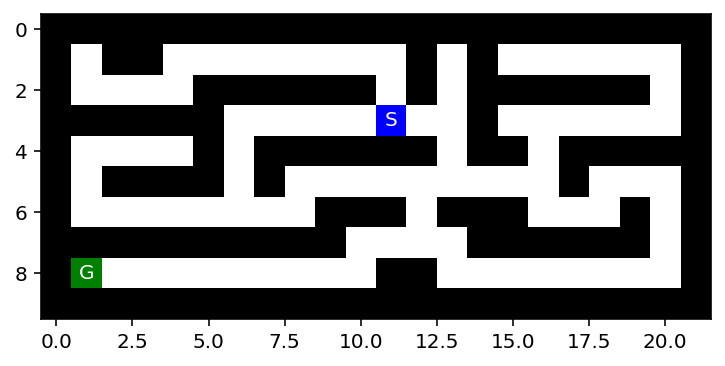

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show_maze(maze)


Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))
print(maze)

Start location: (3, 11)
Goal location: (8, 1)
[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' 'S' ' ' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' 'X' ' ' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X'
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' 'X' ' ' 'X' 'X' 'X' ' ' ' '
  ' ' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']]


## Tree structure

Implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73):

In [5]:
class Node:
    def __init__(self, pos, parent, action, cost, depth = 0):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.depth = depth
        self.children = []
        
    def add_child(self, child_node):
        self.children.append(child_node)
    
    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"
    
    def __eq__(self, r_node):
        if isinstance(r_node, Node): 
            return self.pos == r_node.pos
        return False
    
    def __hash__(self):
        return hash(self.pos)

Example: Create the root node and append the node for going east with a cost of 1.

In [6]:
print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
print(root == node2.parent)
print()
print("Note that the root note is safe from garbage collection as long as we have a reference in node2") 
root = None
print(root)
print("parent of node2 (reference): ", repr(node2.parent))
print()
print("Once we release node2, the whole tree is deleted.")
node2 = None


Create root node
root: Node - pos = (0, 0); parent = None; action = None; cost = 0
root (reference): <__main__.Node object at 0x7f100b23b640>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); parent = <__main__.Node object at 0x7f100b23b640>; action = E; cost = 1
parent of node2:  Node - pos = (0, 0); parent = None; action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x7f100b23b640>
True

Note that the root note is safe from garbage collection as long as we have a reference in node2
None
parent of node2 (reference):  <__main__.Node object at 0x7f100b23b640>

Once we release node2, the whole tree is deleted.


# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

* Initial state = Starting square/node in the maze
* Actions = North, South, East, West
* Transition = Explore/move to new node
* Goal State = End square/node in the maze
* Path cost = 1 cost per node/square ( without heuristics) + heuristic function with heuristics

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Note that the algorithms for BFS and DFS are very different! Make sure that DFS uses less memory by releasing nodes that are not needed anymore. Follow the pseudocode in the textbook.

In [7]:
# Some helper functions
import random
def get_neighbors(cur_node):
    x = cur_node.pos[0]
    y = cur_node.pos[1]
    neighbors = [(x,y-1,'West'),(x+1,y,'South'),\
                 (x,y+1,'East'),(x-1,y,'North')]
    return filter(lambda pos: look(maze, (pos[0],pos[1])) not in ['X'], neighbors)

def get_node_neighbors(cur_node):
    nodes = []
    neighbors = get_neighbors(cur_node)
    for n in neighbors:
         nodes.append(
             Node(pos    = tuple(n[0:2]), \
                  parent = cur_node, \
                  action = n[2],\
                  cost = cur_node.cost + 1,
                  depth = cur_node.depth + 1
             )
         )
    random.shuffle(nodes)
    nodes.reverse()
    return nodes

def mark(maze, collection, mark_char):
    for node in collection:
        pos = node.pos
        to_mark_node = maze[pos[0], pos[1]]
        if not to_mark_node in ['S', 'G']:
            maze[pos[0], pos[1]] = mark_char

def mark_final_path(maze, end_node):
    curr_node = end_node.parent
    while curr_node.parent != None:
        pos = curr_node.pos
        maze[pos[0],pos[1]] = 'P'
        curr_node = curr_node.parent
        

def mark_maze(maze, explored_nodes, frontier, end_node = None):
    mark(maze, frontier, 'F')
    mark(maze, explored_nodes, '.')
    if end_node != None:
        mark_final_path(maze, end_node)
    

# BFS Implementation

My implementation here is heavily following the example from the book. It simply creates the nodes as it expands them, and adds them to the frontier queue as it discovers them, then puts them in the explored set as it expands them. I made some modifications to the node class to make them hashable, as well as provided a way to compare nodes directly. Also I made some helpful functions above to help along the way.

In [8]:
# throw mazes into list to iterato through when testing
mazes = [
    'empty_maze.txt',
    'empty_2_maze.txt',
    'small_maze.txt',
    'loops_maze.txt',
    'wall_maze.txt',
    'open_maze.txt',
    'medium_maze.txt',
    'large_maze.txt'
]

In [9]:
# Your code goes here
#BFS
def bfs(maze, verb = False):
    ''' Initialize the starting node and set the end goal'''
    start = Node(pos    = find_pos(maze, what = "S"),\
                 parent = None, \
                 action = None, \
                 cost   = 0)
    final_pos = find_pos(maze, what = "G")
    frontier = [start]
    explored = set()
    
    ''' Keep track of this data for comparison'''
    max_frontier = 1
    tree_depth = 0
    max_tree_size = 0
    
    
    ''' Logic is essentially from the book and pythonized
        , that is if you can call this pythonized
    '''
    while len(frontier):
        current_node = frontier.pop(0)
        explored.add(current_node)
        children = get_node_neighbors(current_node)
        for child in children:
            tree_depth = max(tree_depth, child.depth)
            if not (child in explored ) and not(child in frontier):
                if child.pos == final_pos:
                    mark_maze(maze, explored, frontier, child)
                    if(verb): show_maze(maze); print(frontier)
                    return (child, len(explored), tree_depth, \
                            len(frontier) + len(explored), max_frontier)
                frontier.append(child)
                max_frontier = max(max_frontier, len(frontier))
        mark_maze(maze, explored, frontier)
        if verb:
            show_maze(maze)
            for f in frontier: print(f.pos, end=' ')
            print()
            for e in explored : print(e.pos, end = ' ')
            print()
        max_frontier = max(max_frontier, len(frontier))
    return None # if no solution
   

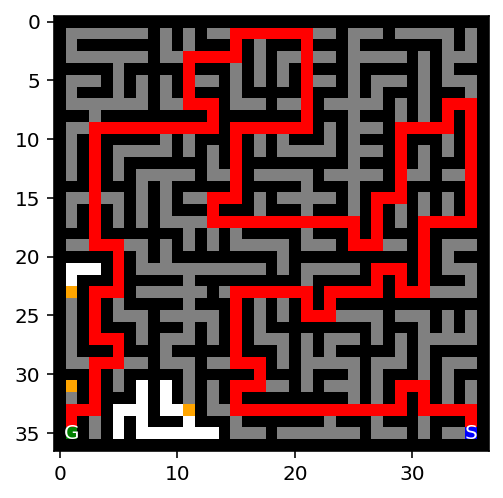

In [10]:
f = open('large_maze.txt', "r")
maze_str = f.read()
maze = parse_maze(maze_str)
bfs(maze,verb=False)
show_maze(maze)

#### BFS solved Mazes

 empty_maze.txt
-------------------


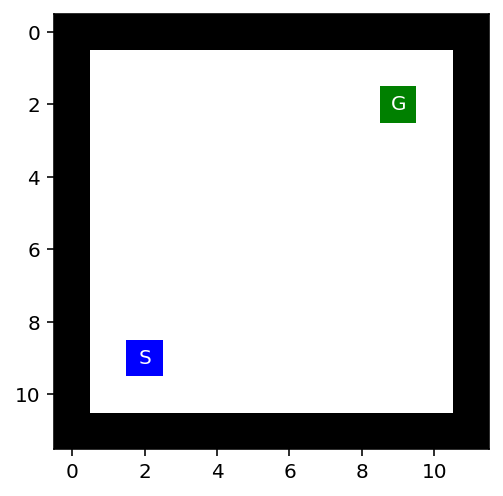

Node - pos = (2, 9); parent = <__main__.Node object at 0x7f100b138130>; action = East; cost = 14
92
14
95
12


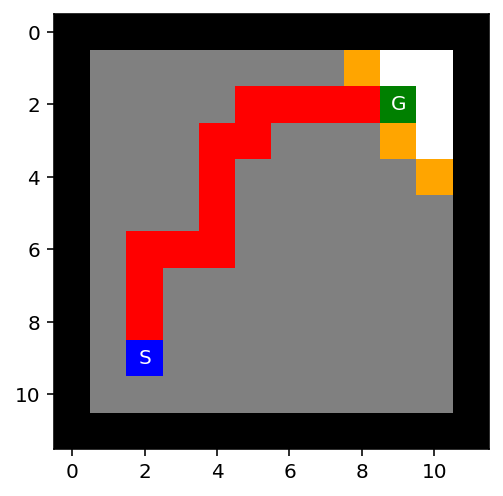

 empty_2_maze.txt
-------------------


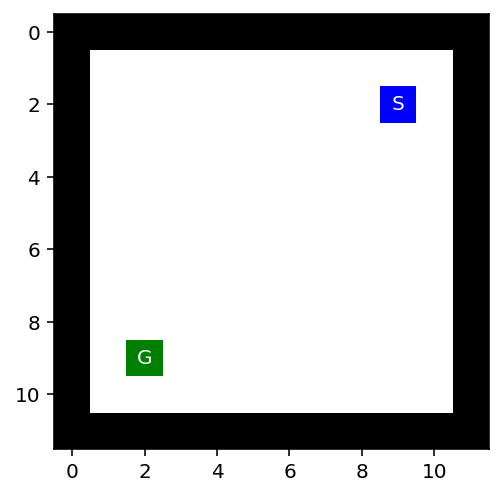

Node - pos = (9, 2); parent = <__main__.Node object at 0x7f100b0687c0>; action = South; cost = 14
91
14
95
12


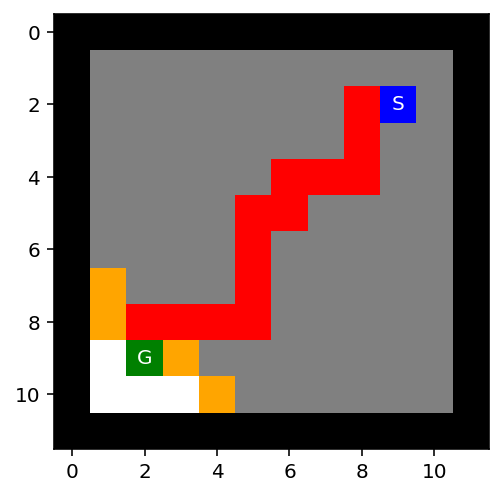

 small_maze.txt
-------------------


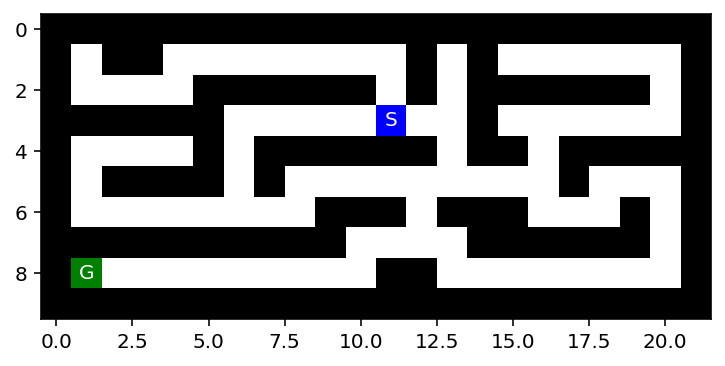

Node - pos = (8, 1); parent = <__main__.Node object at 0x7f100aefbac0>; action = West; cost = 19
91
19
92
9


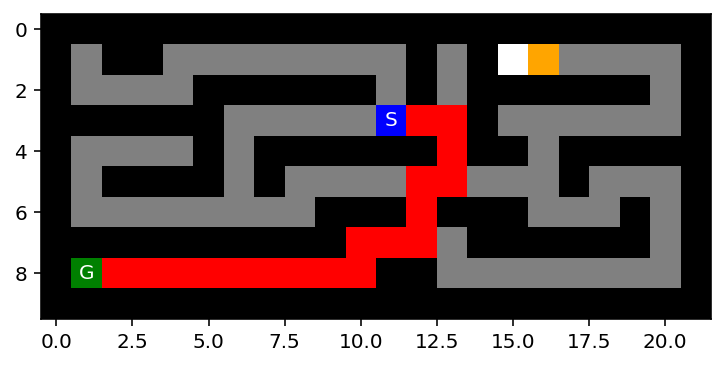

 loops_maze.txt
-------------------


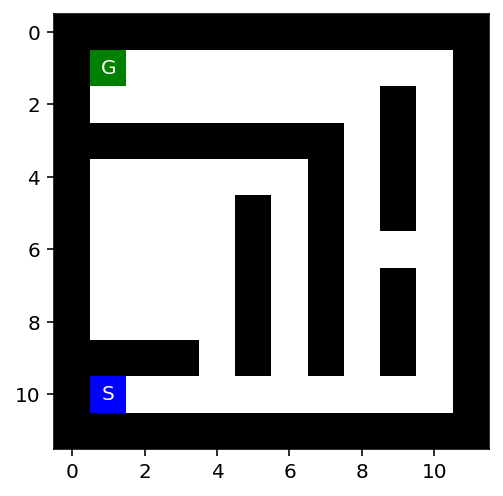

Node - pos = (1, 1); parent = <__main__.Node object at 0x7f100ae30760>; action = West; cost = 23
70
23
71
8


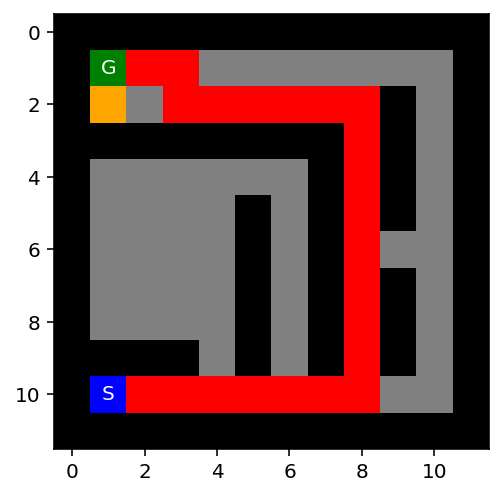

 wall_maze.txt
-------------------


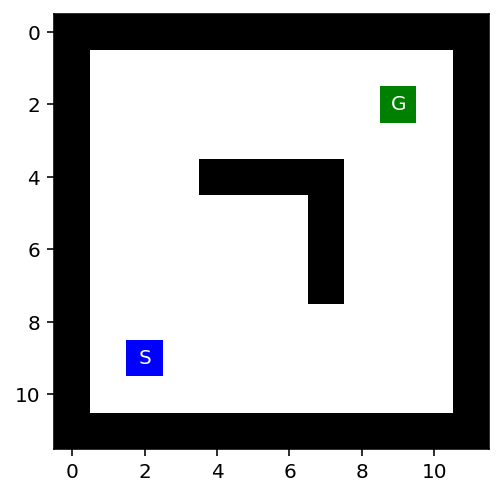

Node - pos = (2, 9); parent = <__main__.Node object at 0x7f100ad67370>; action = North; cost = 14
85
14
88
9


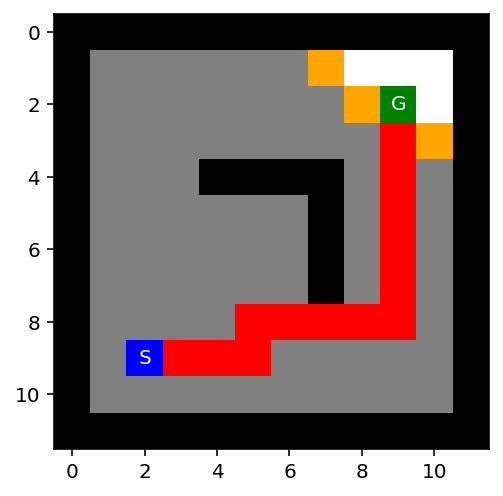

 open_maze.txt
-------------------


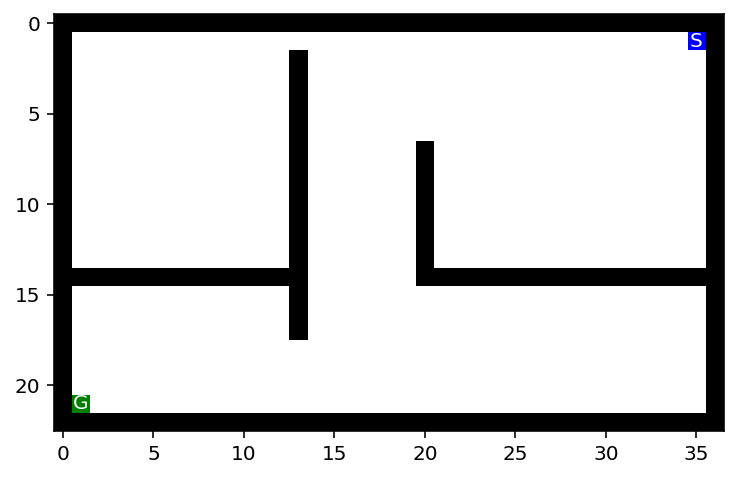

Node - pos = (21, 1); parent = <__main__.Node object at 0x7f100b15e760>; action = West; cost = 54
679
54
682
25


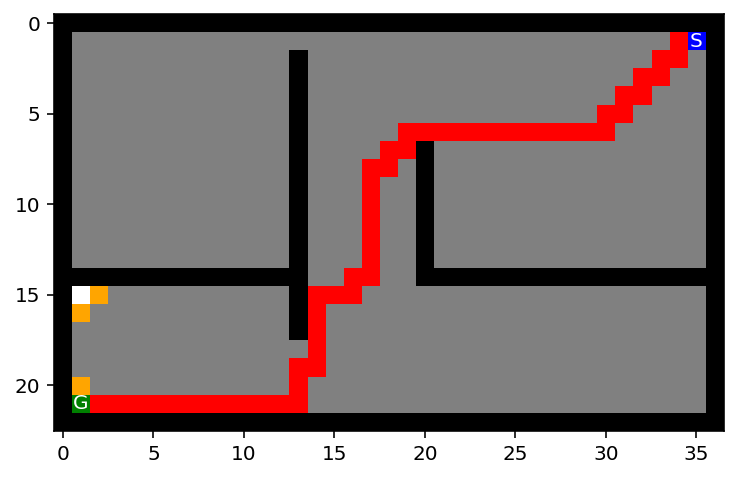

 medium_maze.txt
-------------------


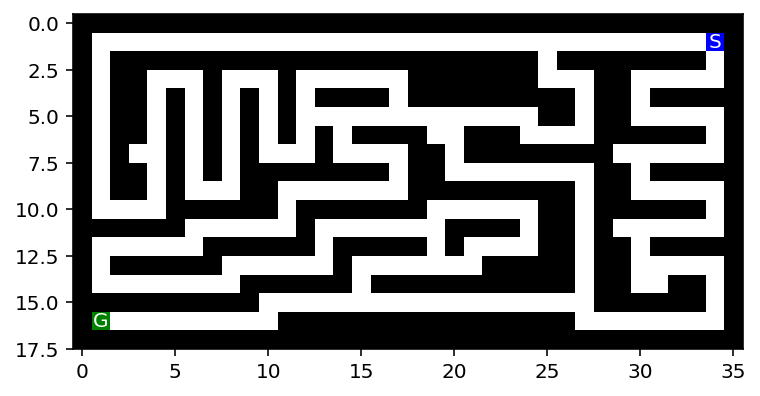

Node - pos = (16, 1); parent = <__main__.Node object at 0x7f100b194c70>; action = West; cost = 68
268
68
270
8


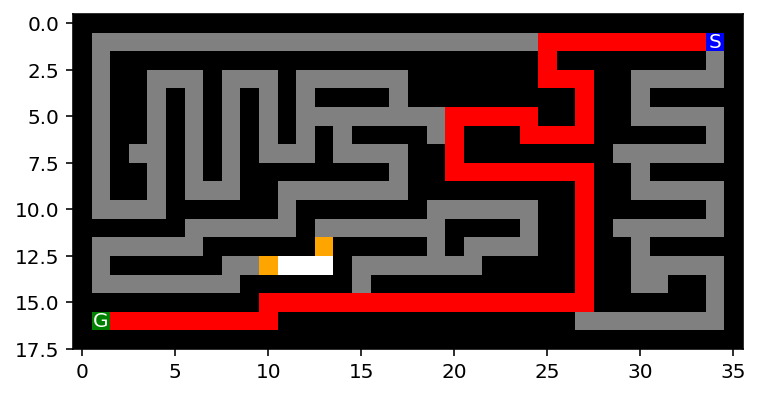

 large_maze.txt
-------------------


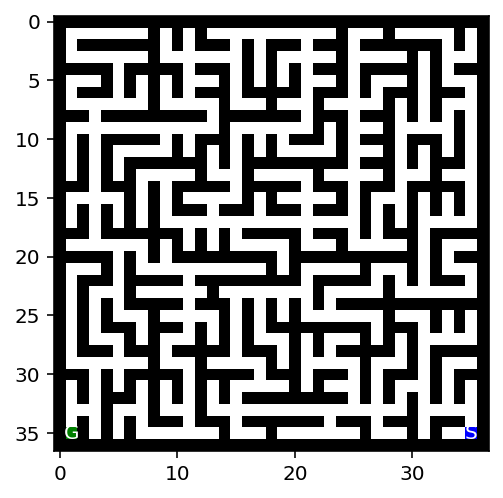

Node - pos = (35, 1); parent = <__main__.Node object at 0x7f100ae4cc70>; action = South; cost = 210
618
210
621
9


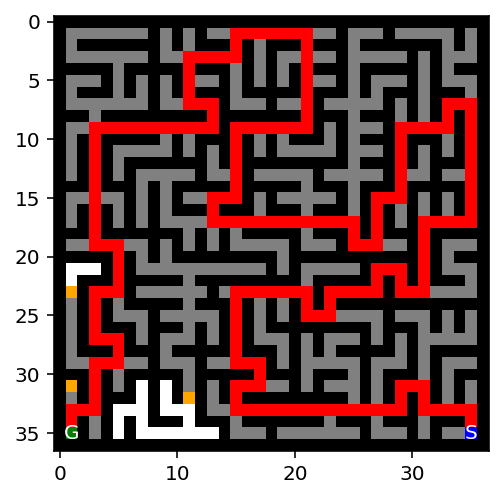

In [11]:
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' {m}\n-------------------')
    show_maze(maze)
    for i in bfs(maze):
        print (i)
    show_maze(maze)  
    f.close()

## DFS Implementation

In [12]:
# some DFS helpers
def rm_node(node_to_remove, frontier):
    for node in frontier:
        if node_to_remove in node.children:
            node.children[node.children.index(node_to_remove)] = None # remove the node.
def add_to_frontier(node, frontier):
    node.children = get_node_neighbors(node) # Need to be aware of adjacent squares
    frontier.append(node)                    # append to frontier
    
class reference:
    def __init__(self, obj): self.obj = obj
    def get(self):    return self.obj
    def set(self, obj):      self.obj = obj

In [13]:

def dfs(maze, verb=False):
    start = Node(pos    = find_pos(maze, what = "S"),\
                 parent = None, \
                 action = None, \
                 cost   = 0)
    start.children = get_node_neighbors(start)
    final_pos = find_pos(maze, what = "G")
    frontier = [start]   
    current_loop = set() # saves nodes that are in the current loop
    remove_node = None
    while(len(frontier)):
        current_node = frontier[-1]     #explore last item in the frontier stack
        dead_end_node = True            # assume node is a dead end     
        current_loop.add(current_node)  # add current node into the current loop set (assuming it is not in it)
        if verb: print(current_node)    # print node if verb                

        for child in current_node.children:                       # considering the children
            if not (child in current_loop) and not (child in frontier) and child != None:
                if child.pos == final_pos:           # if child is final position, return it         
                    mark_maze(maze,current_loop,frontier, child)
                    return child
                add_to_frontier(child, frontier)              # else the child will be added to the frontier
                dead_end_node = False      # if node has reachable children, it is not a dead end
                    
        if dead_end_node: 
            maze[current_node.pos[0], current_node.pos[1]] = 'R'
            current_loop.remove(current_node)
            frontier.pop()
            rm_node(current_node, frontier)

            
        mark_maze(maze, current_loop, frontier)
        if verb: show_maze(maze)
        
        


# DFS Solved mazes

 empty_maze.txt
-------------------


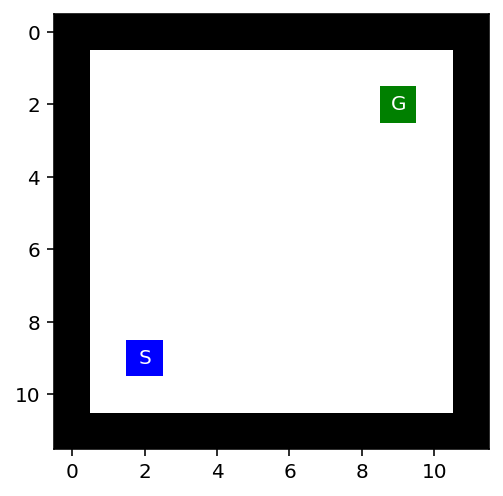

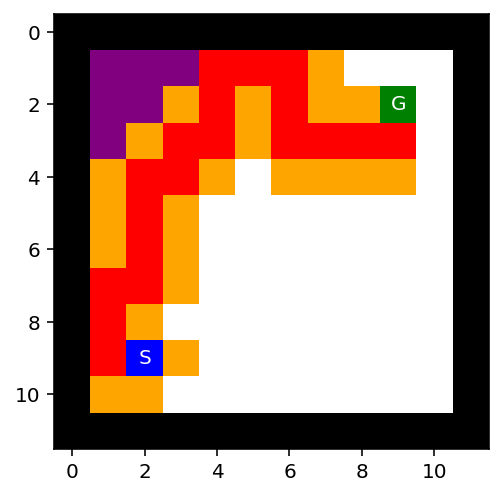

 empty_2_maze.txt
-------------------


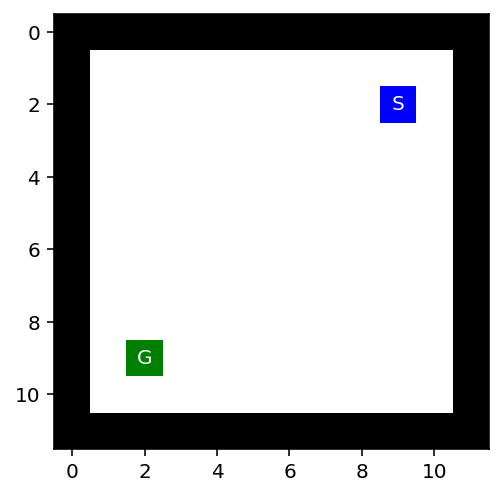

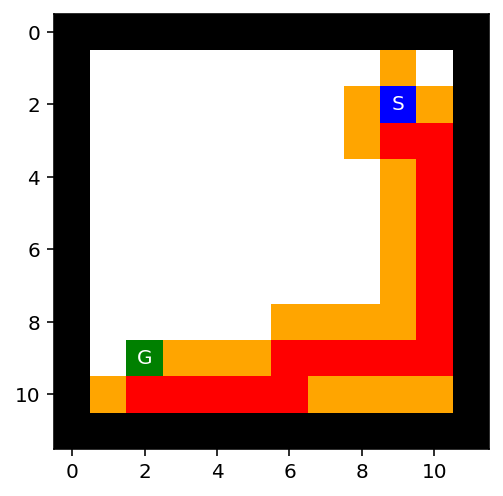

 small_maze.txt
-------------------


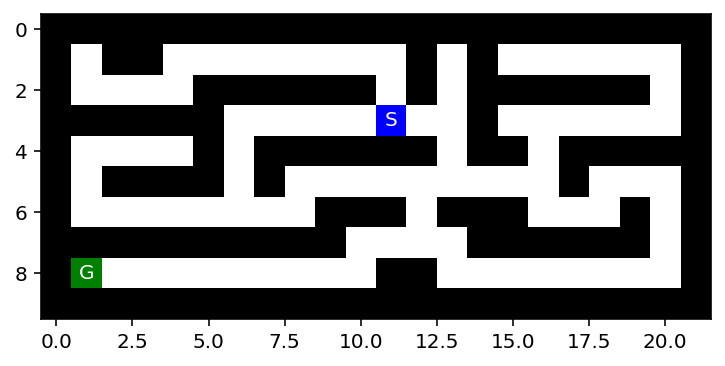

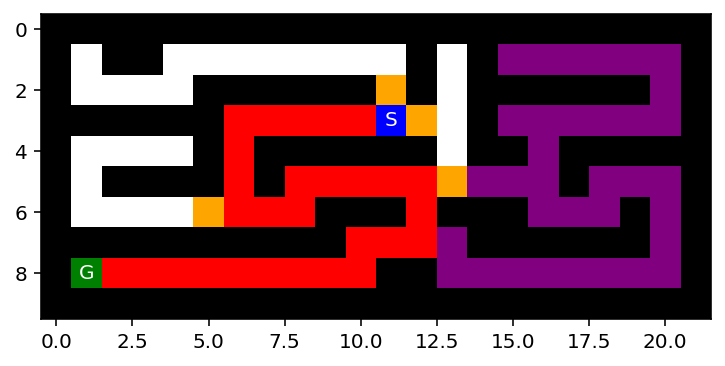

 loops_maze.txt
-------------------


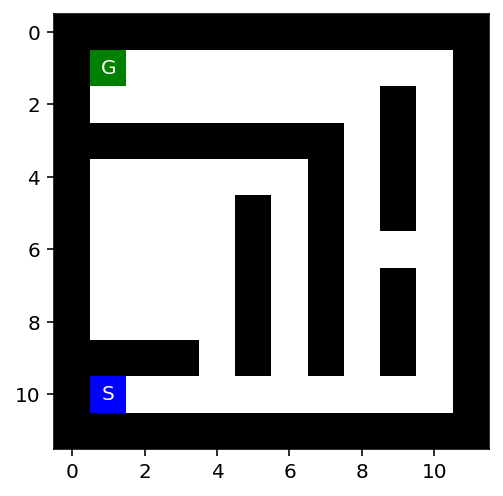

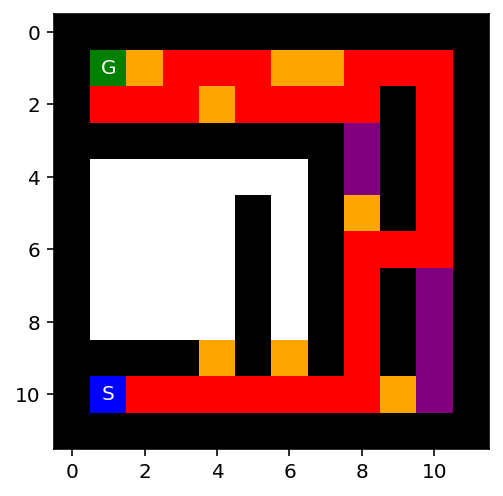

 wall_maze.txt
-------------------


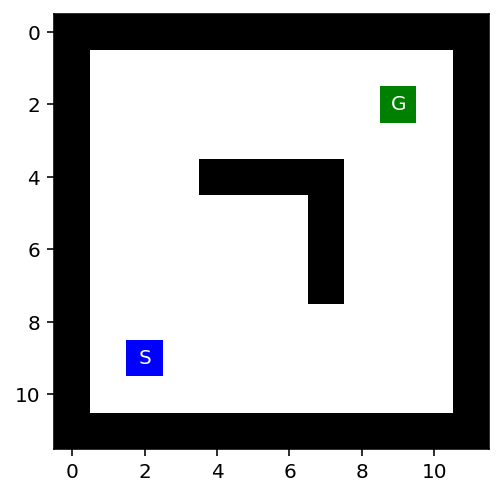

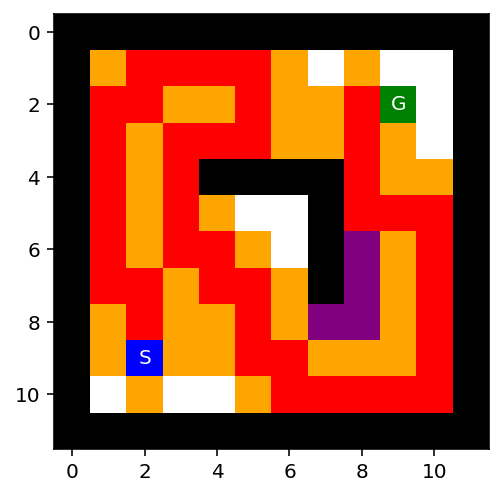

 open_maze.txt
-------------------


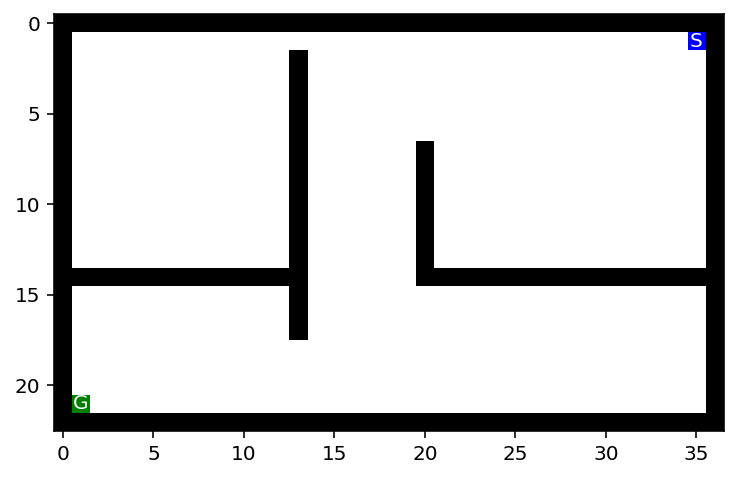

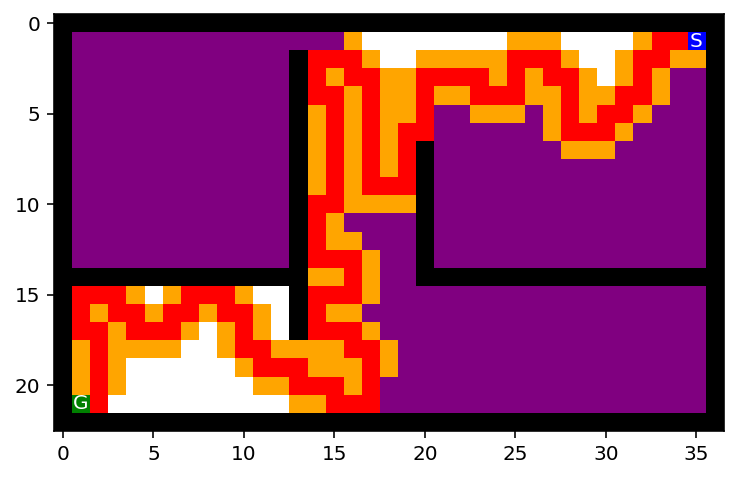

 medium_maze.txt
-------------------


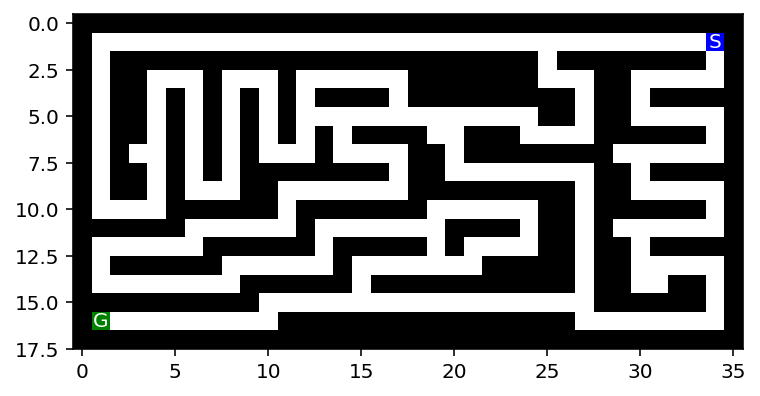

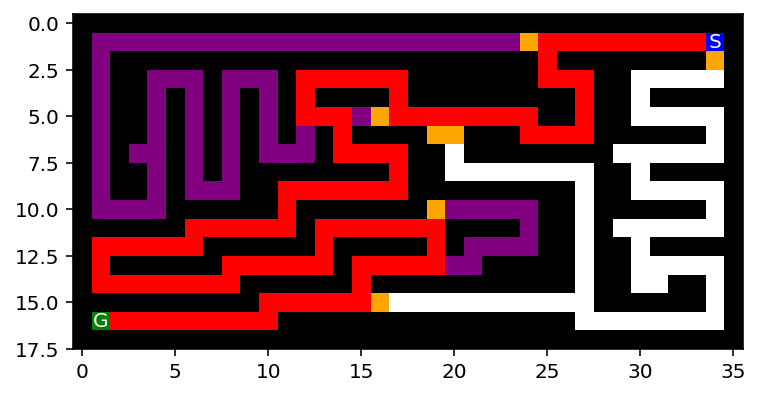

 large_maze.txt
-------------------


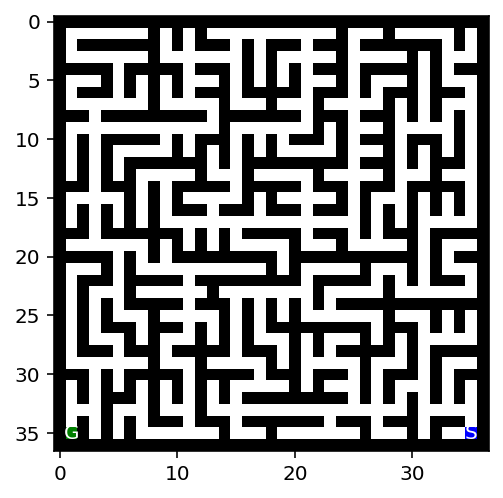

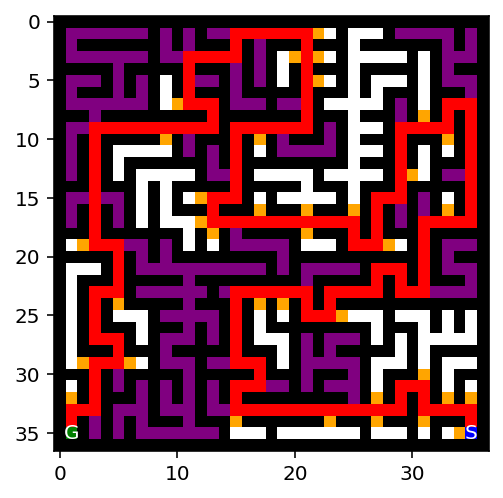

In [14]:
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' {m}\n-------------------')
    show_maze(maze)
    dfs(maze)
    show_maze(maze)  
    f.close()

Node - pos = (1, 35); parent = None; action = None; cost = 0


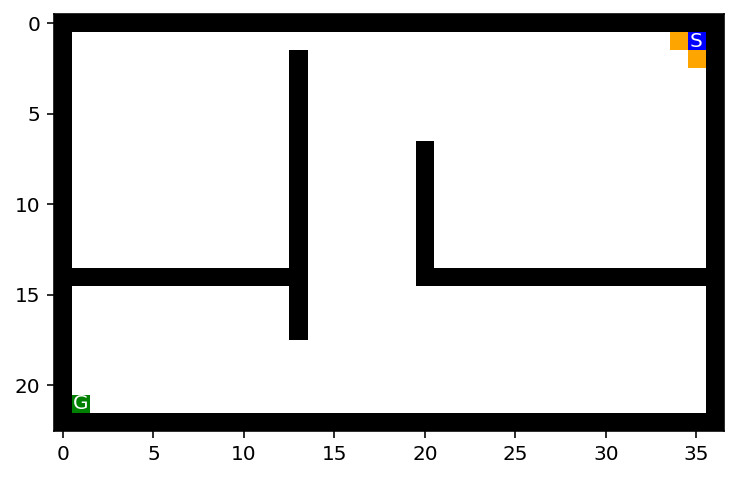

Node - pos = (1, 34); parent = <__main__.Node object at 0x7f100b1ae280>; action = West; cost = 1


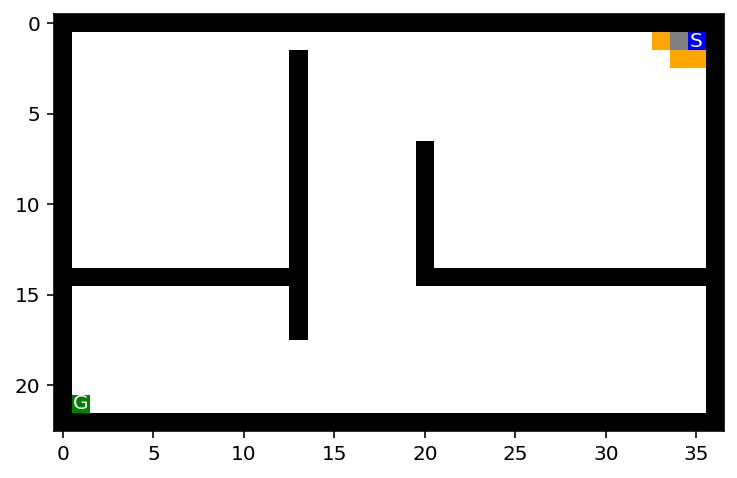

Node - pos = (1, 33); parent = <__main__.Node object at 0x7f100b1ae610>; action = West; cost = 2


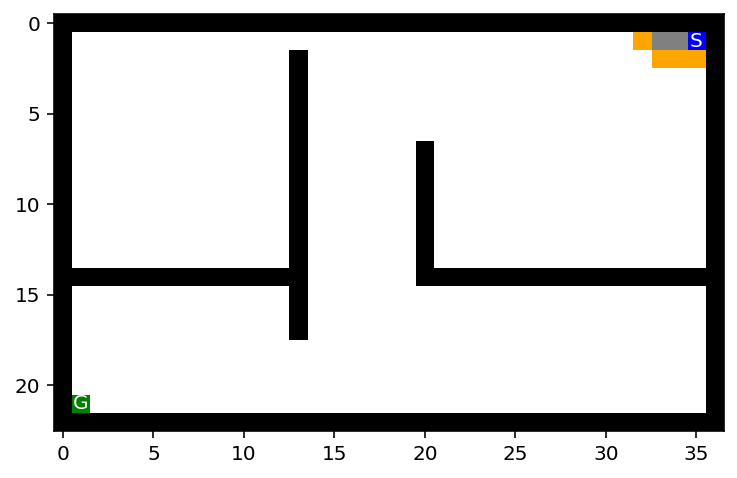

Node - pos = (1, 32); parent = <__main__.Node object at 0x7f100b1ae520>; action = West; cost = 3


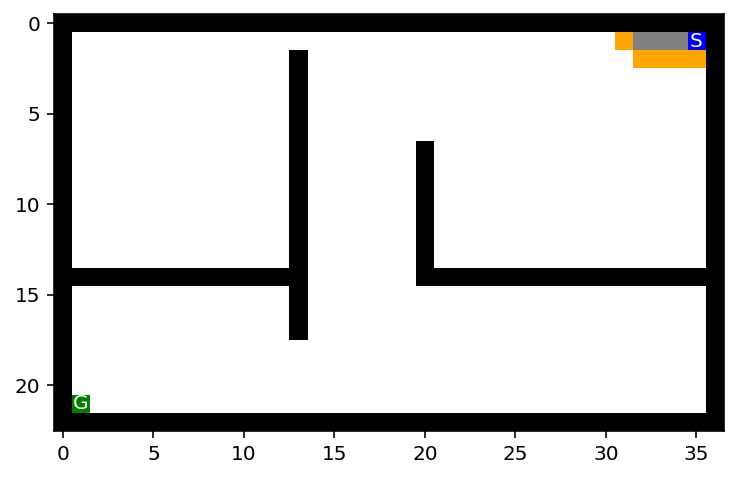

Node - pos = (2, 32); parent = <__main__.Node object at 0x7f100ada9e50>; action = South; cost = 4


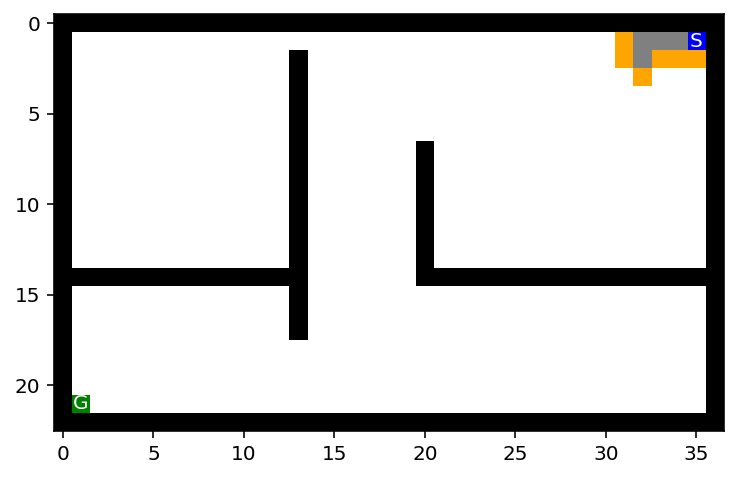

Node - pos = (3, 32); parent = <__main__.Node object at 0x7f100b087c70>; action = South; cost = 5


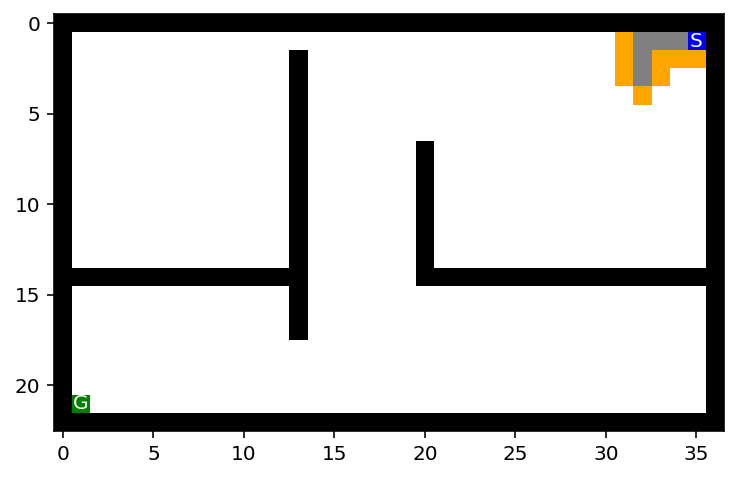

Node - pos = (3, 33); parent = <__main__.Node object at 0x7f100b242d00>; action = East; cost = 6


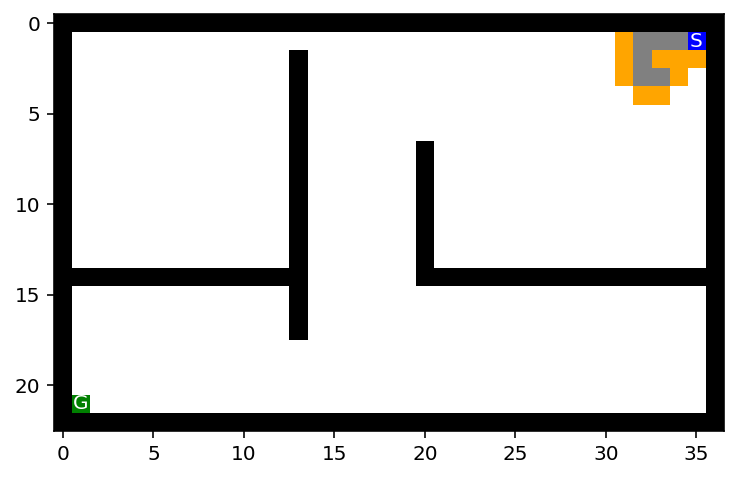

Node - pos = (4, 33); parent = <__main__.Node object at 0x7f100b176d30>; action = South; cost = 7


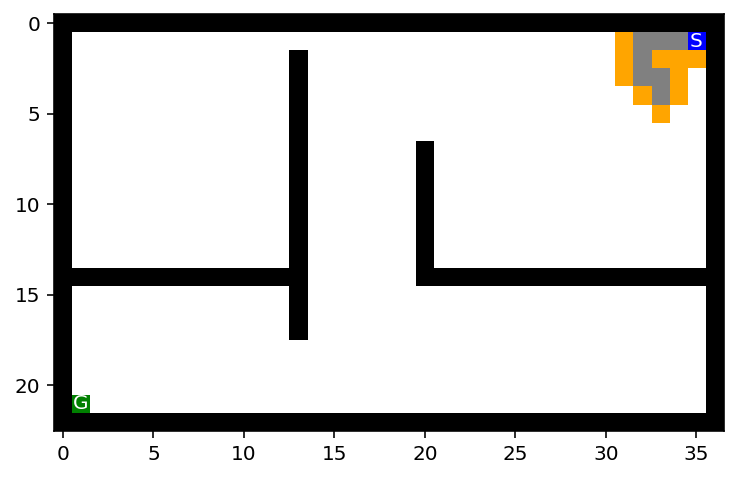

Node - pos = (5, 33); parent = <__main__.Node object at 0x7f100b221d60>; action = South; cost = 8


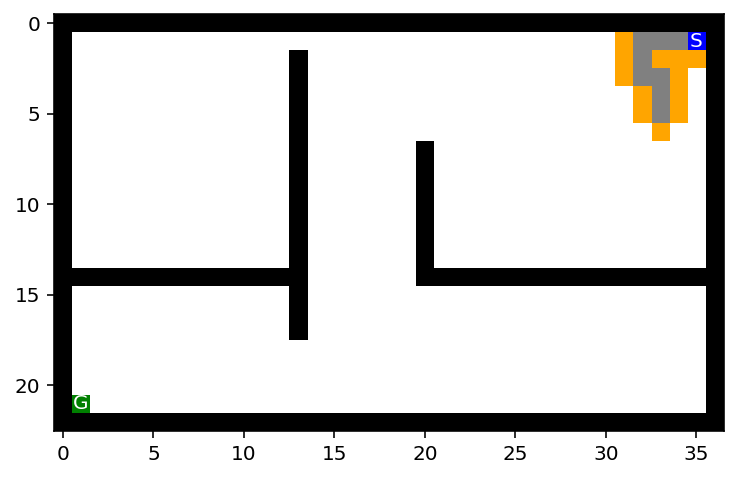

Node - pos = (5, 34); parent = <__main__.Node object at 0x7f100b174a00>; action = East; cost = 9


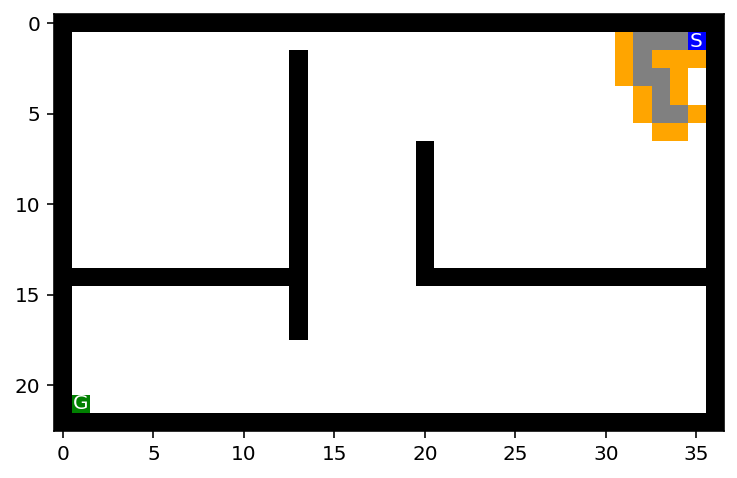

Node - pos = (5, 35); parent = <__main__.Node object at 0x7f100ae98b50>; action = East; cost = 10


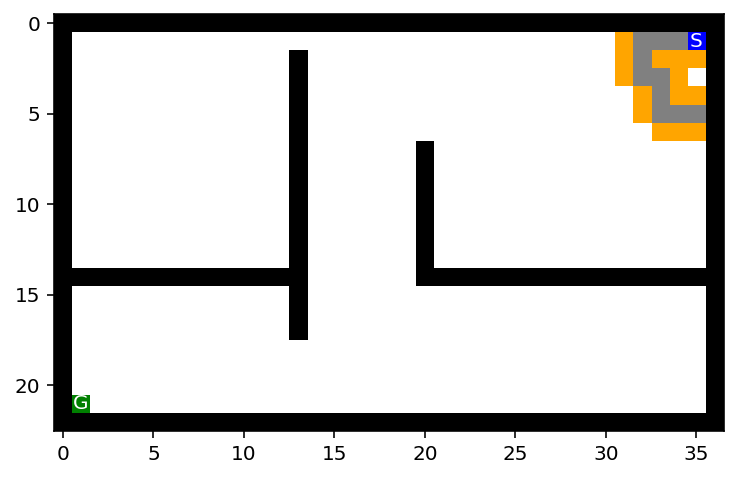

Node - pos = (6, 35); parent = <__main__.Node object at 0x7f100b01fb50>; action = South; cost = 11


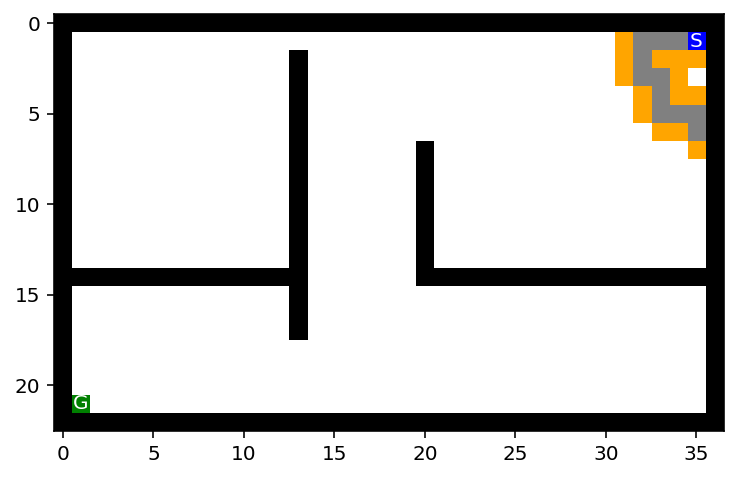

Node - pos = (7, 35); parent = <__main__.Node object at 0x7f100ad7e1c0>; action = South; cost = 12


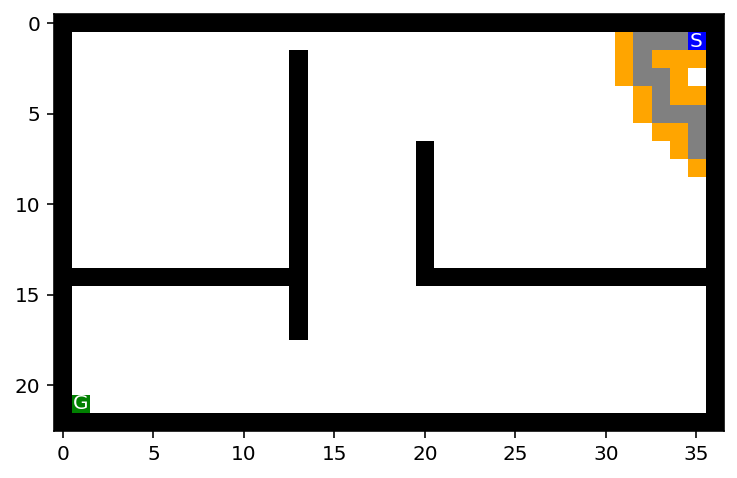

Node - pos = (8, 35); parent = <__main__.Node object at 0x7f100ad8a670>; action = South; cost = 13


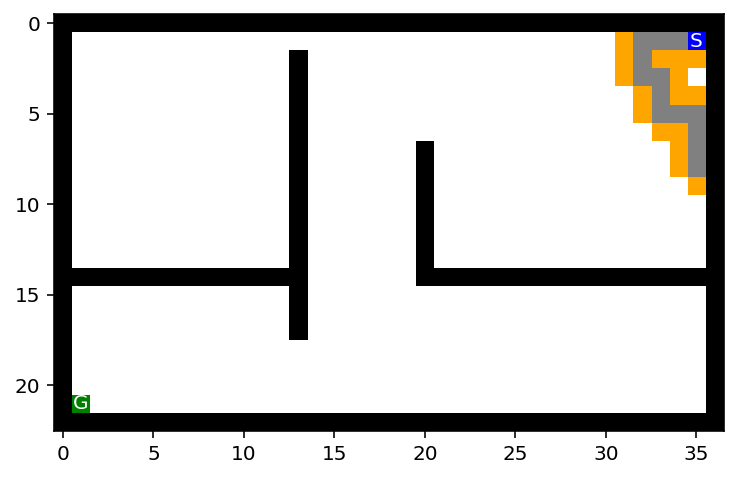

Node - pos = (8, 34); parent = <__main__.Node object at 0x7f100b054100>; action = West; cost = 14


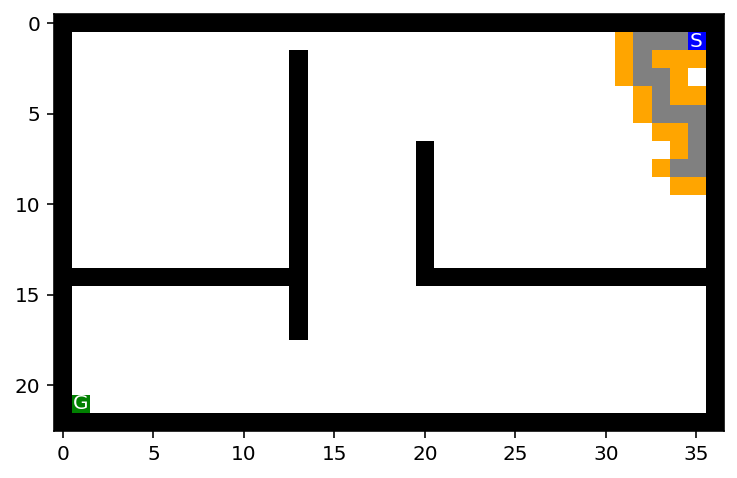

Node - pos = (9, 34); parent = <__main__.Node object at 0x7f100b06e8b0>; action = South; cost = 15


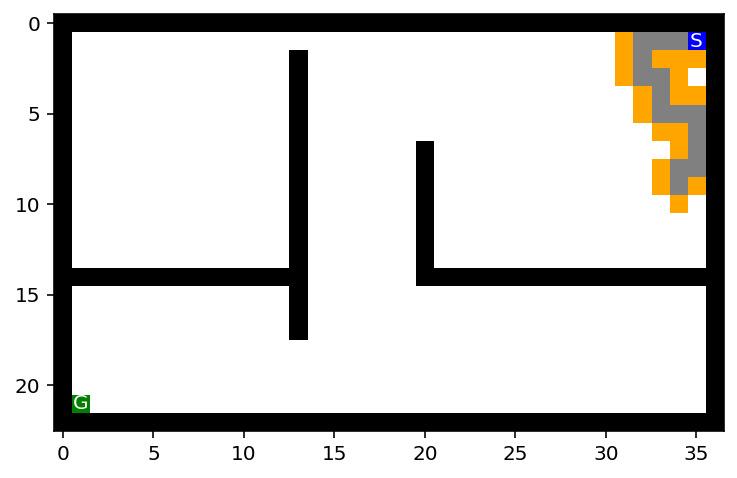

Node - pos = (10, 34); parent = <__main__.Node object at 0x7f100ae93700>; action = South; cost = 16


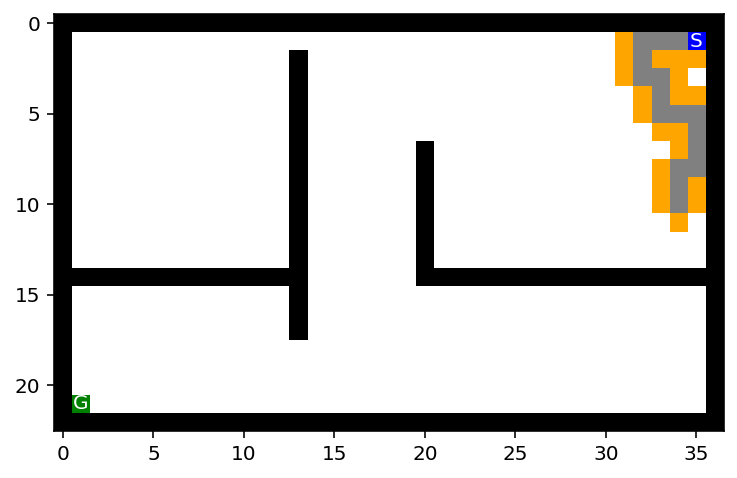

Node - pos = (10, 33); parent = <__main__.Node object at 0x7f100ad8dac0>; action = West; cost = 17


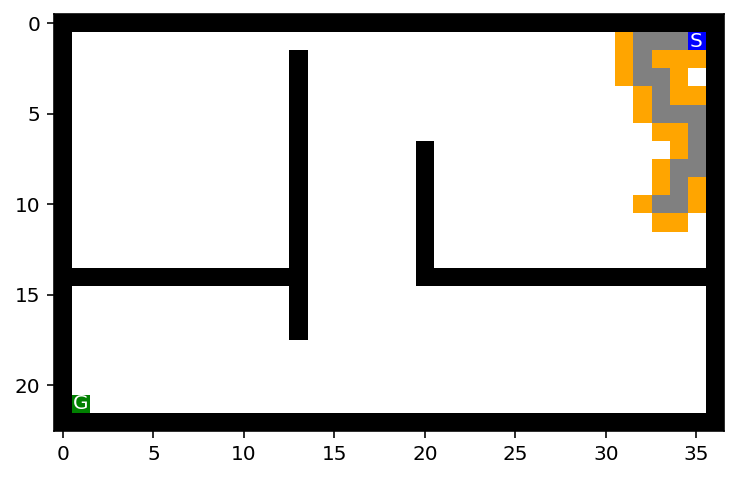

Node - pos = (10, 32); parent = <__main__.Node object at 0x7f100aec2880>; action = West; cost = 18


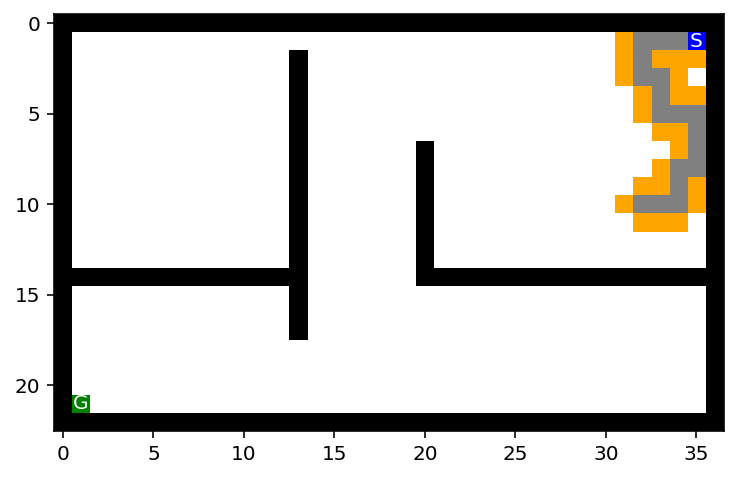

Node - pos = (10, 31); parent = <__main__.Node object at 0x7f100ae2aa30>; action = West; cost = 19


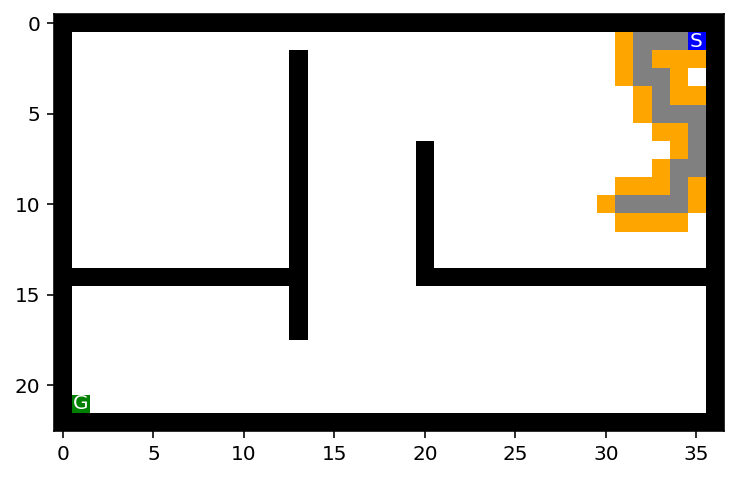

Node - pos = (9, 31); parent = <__main__.Node object at 0x7f100af0c850>; action = North; cost = 20


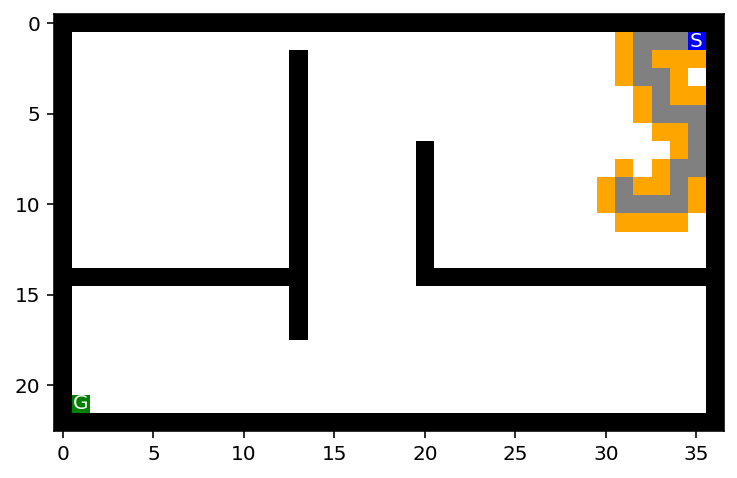

Node - pos = (8, 31); parent = <__main__.Node object at 0x7f100ae52880>; action = North; cost = 21


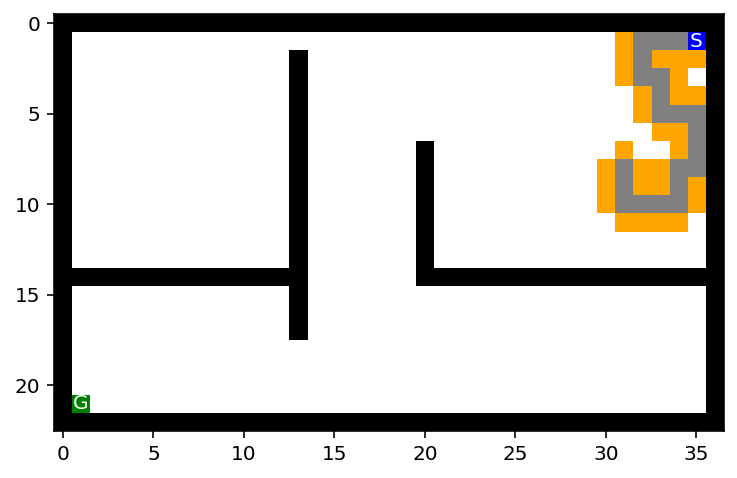

Node - pos = (8, 30); parent = <__main__.Node object at 0x7f100b0948b0>; action = West; cost = 22


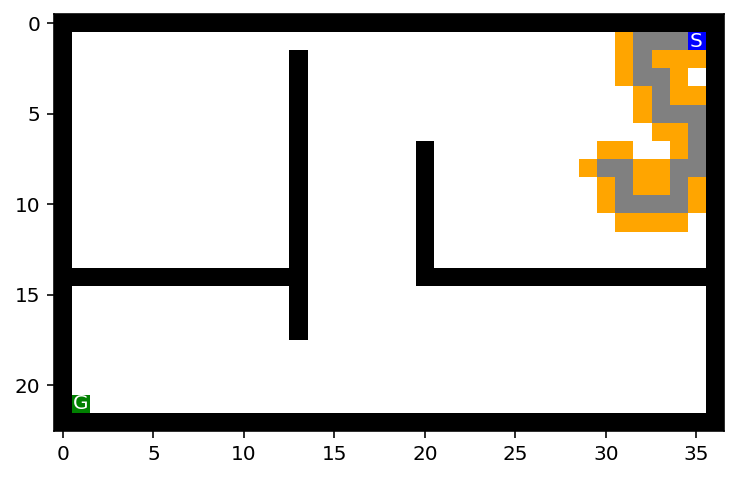

Node - pos = (8, 29); parent = <__main__.Node object at 0x7f100b0ac1f0>; action = West; cost = 23


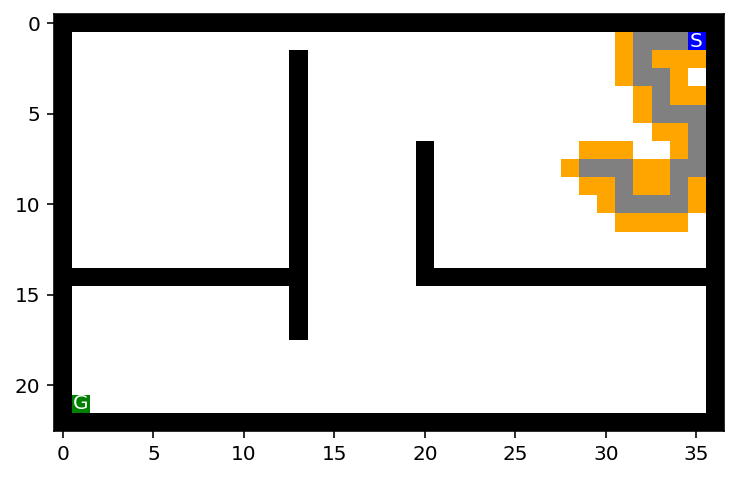

Node - pos = (7, 29); parent = <__main__.Node object at 0x7f100b094940>; action = North; cost = 24


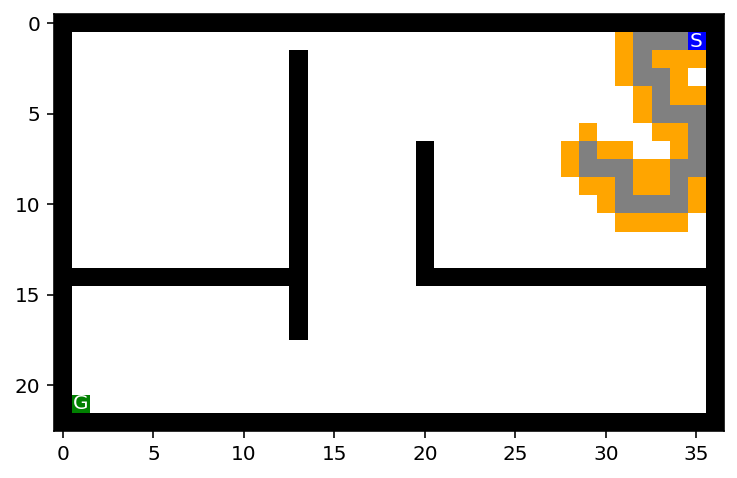

Node - pos = (6, 29); parent = <__main__.Node object at 0x7f100ae585e0>; action = North; cost = 25


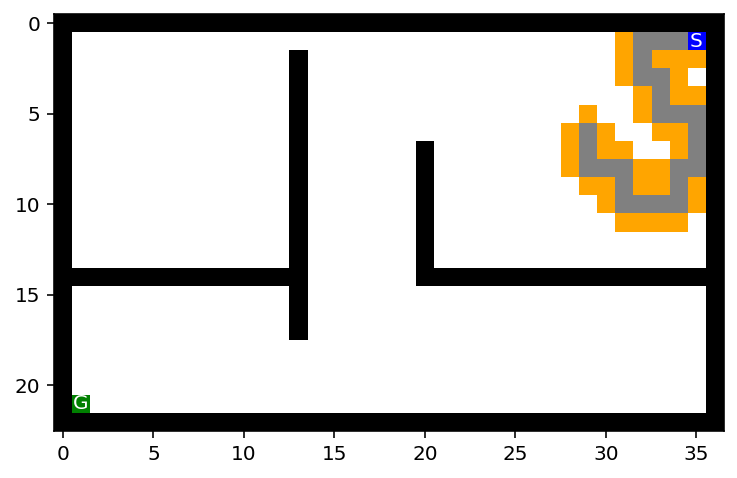

Node - pos = (5, 29); parent = <__main__.Node object at 0x7f100b056970>; action = North; cost = 26


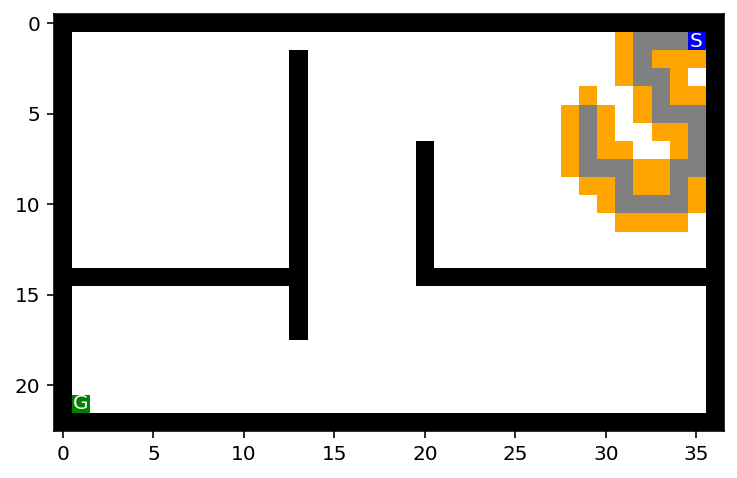

Node - pos = (4, 29); parent = <__main__.Node object at 0x7f100adce790>; action = North; cost = 27


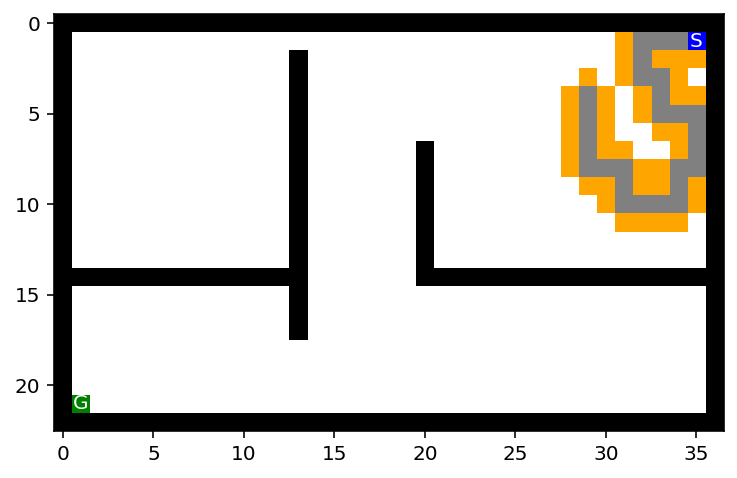

Node - pos = (4, 28); parent = <__main__.Node object at 0x7f100b234040>; action = West; cost = 28


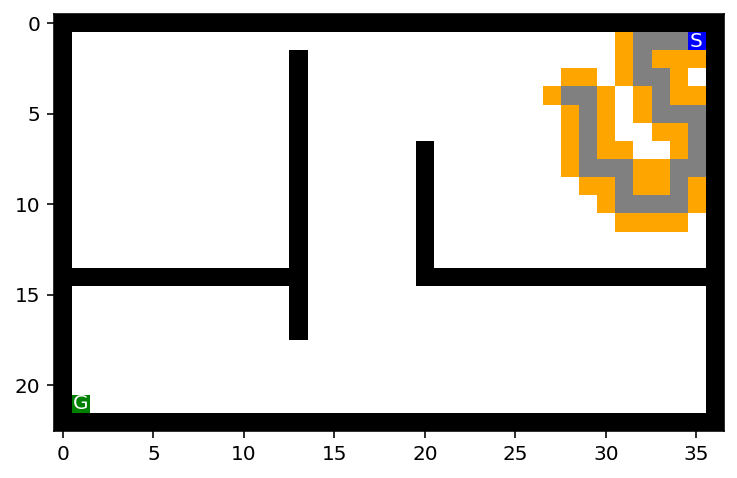

Node - pos = (4, 27); parent = <__main__.Node object at 0x7f100b221ee0>; action = West; cost = 29


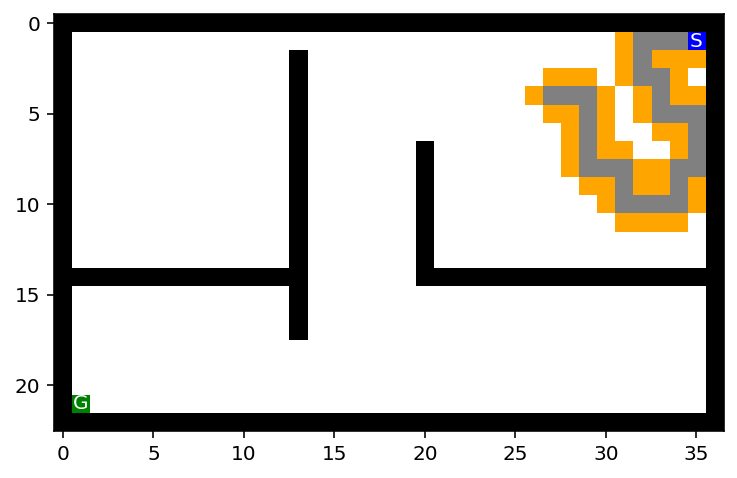

Node - pos = (3, 27); parent = <__main__.Node object at 0x7f100b142490>; action = North; cost = 30


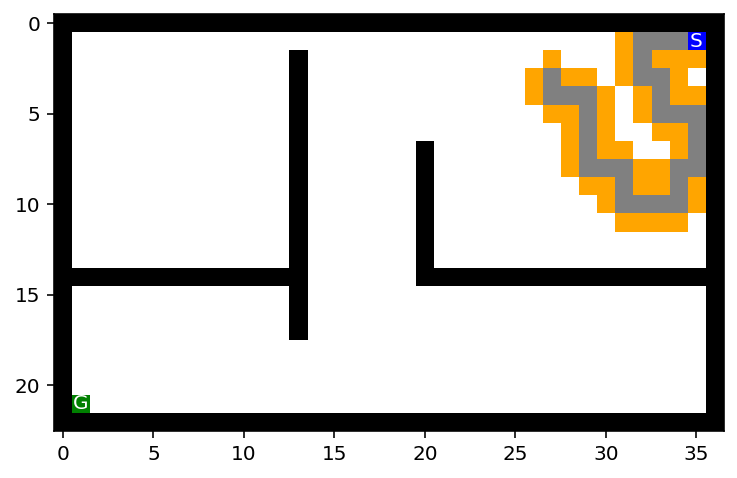

Node - pos = (2, 27); parent = <__main__.Node object at 0x7f100ad7e100>; action = North; cost = 31


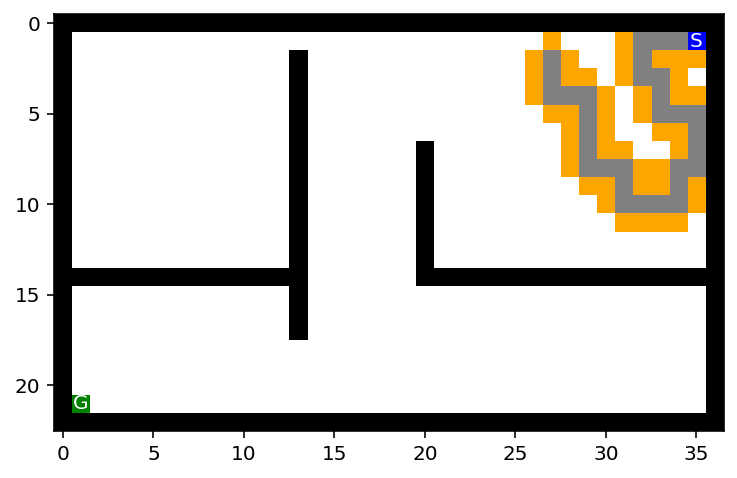

Node - pos = (2, 26); parent = <__main__.Node object at 0x7f100adf54f0>; action = West; cost = 32


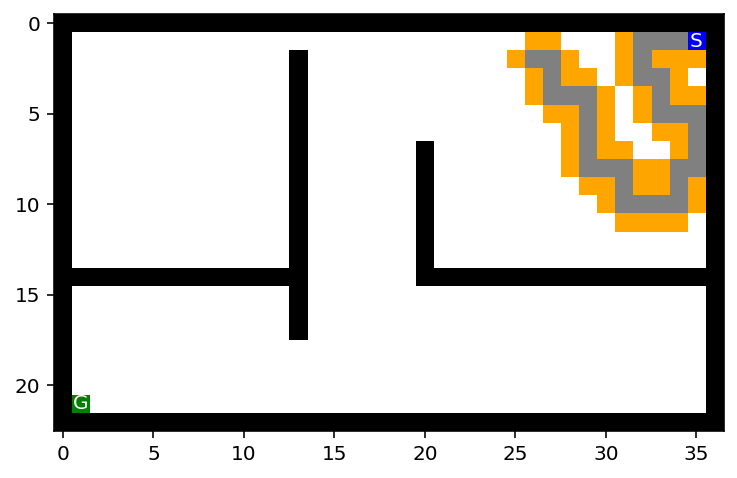

Node - pos = (2, 25); parent = <__main__.Node object at 0x7f100b1910d0>; action = West; cost = 33


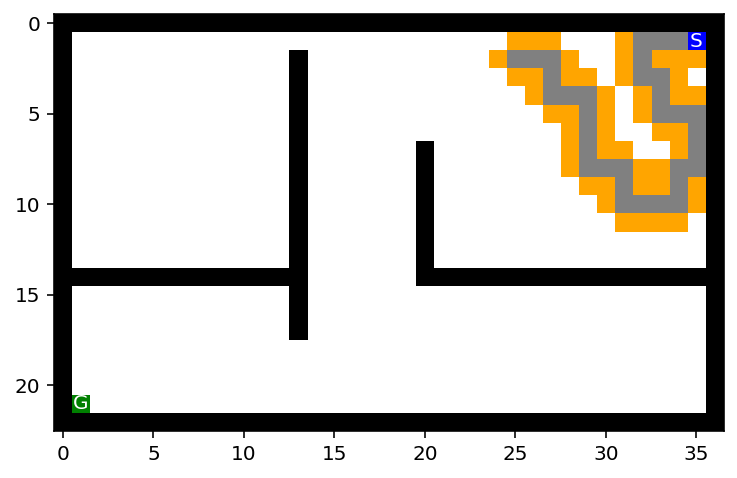

Node - pos = (3, 25); parent = <__main__.Node object at 0x7f100aec3af0>; action = South; cost = 34


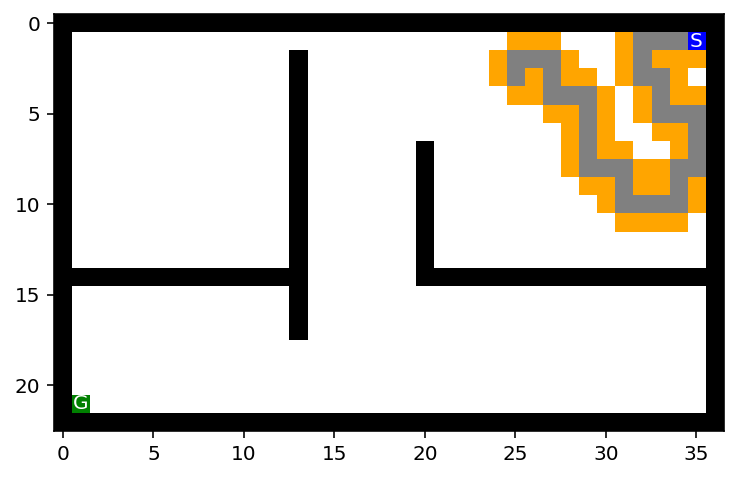

Node - pos = (3, 24); parent = <__main__.Node object at 0x7f100b1035b0>; action = West; cost = 35


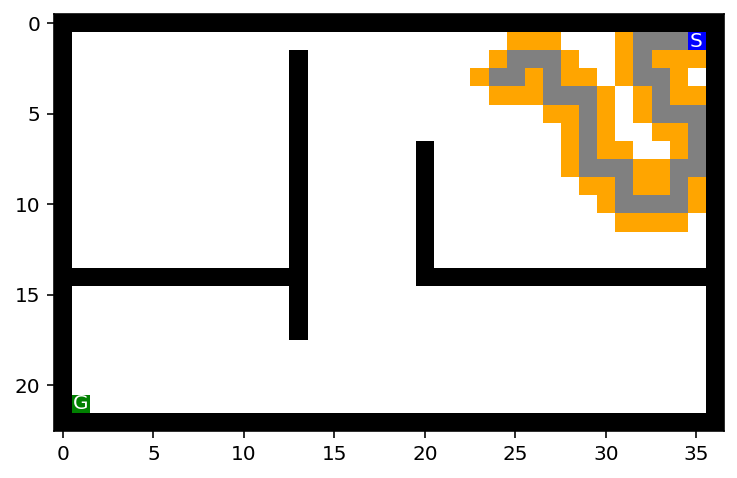

Node - pos = (4, 24); parent = <__main__.Node object at 0x7f100b0cfd90>; action = South; cost = 36


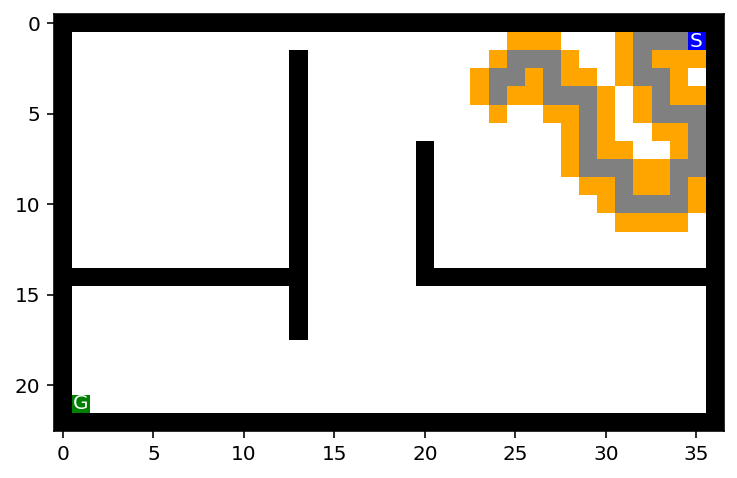

Node - pos = (4, 23); parent = <__main__.Node object at 0x7f100ad60b20>; action = West; cost = 37


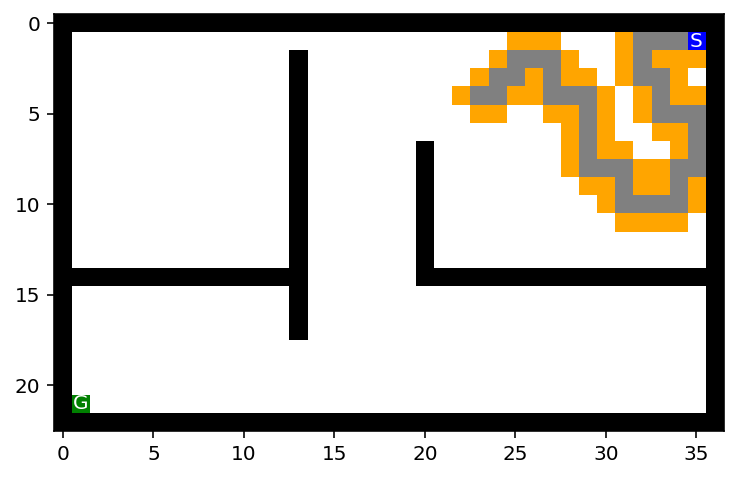

Node - pos = (4, 22); parent = <__main__.Node object at 0x7f100b01d2b0>; action = West; cost = 38


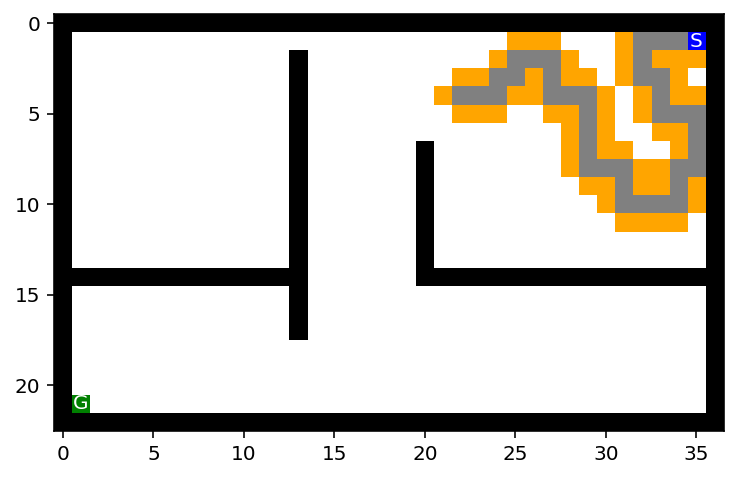

Node - pos = (4, 21); parent = <__main__.Node object at 0x7f102866e7c0>; action = West; cost = 39


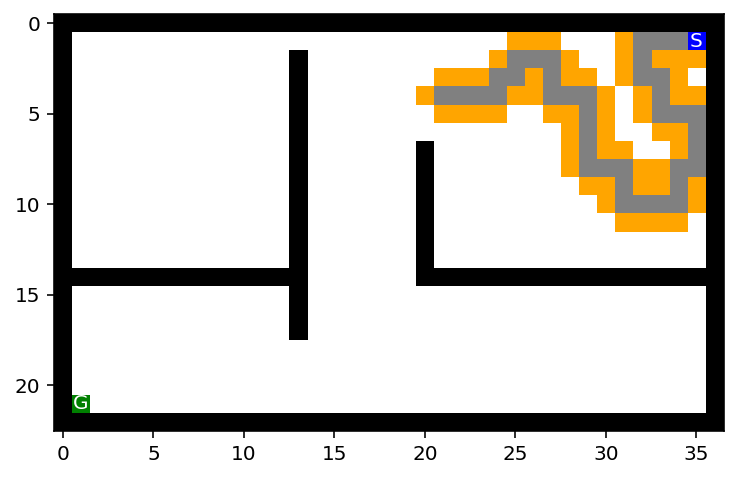

Node - pos = (5, 21); parent = <__main__.Node object at 0x7f100af38b50>; action = South; cost = 40


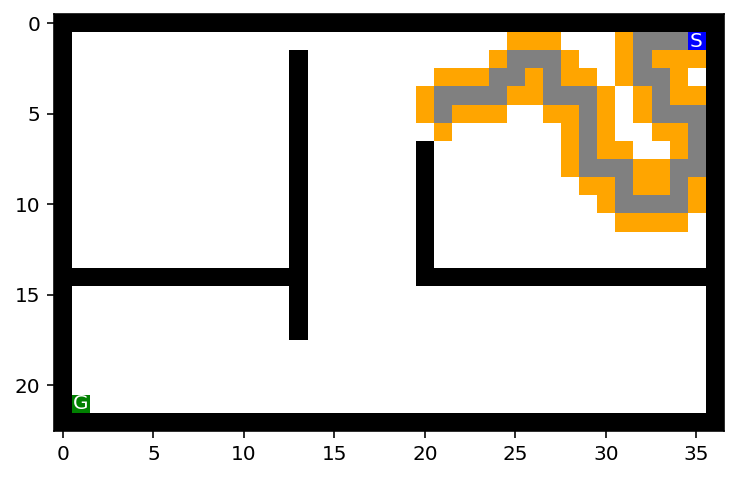

Node - pos = (6, 21); parent = <__main__.Node object at 0x7f100ae58c10>; action = South; cost = 41


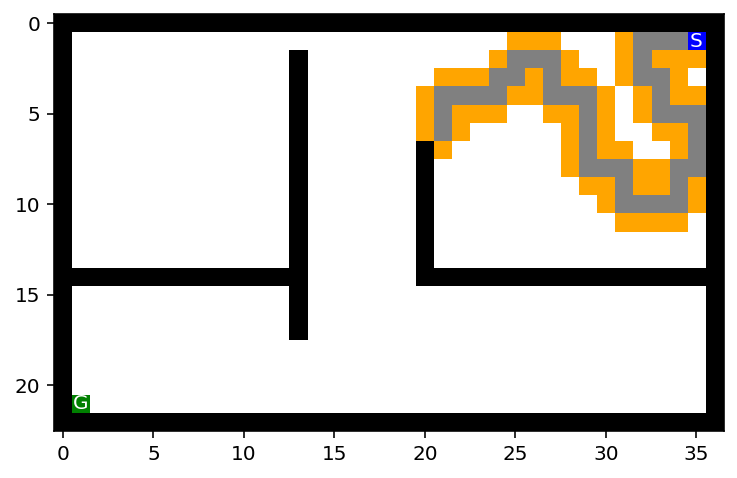

Node - pos = (6, 22); parent = <__main__.Node object at 0x7f100af7e370>; action = East; cost = 42


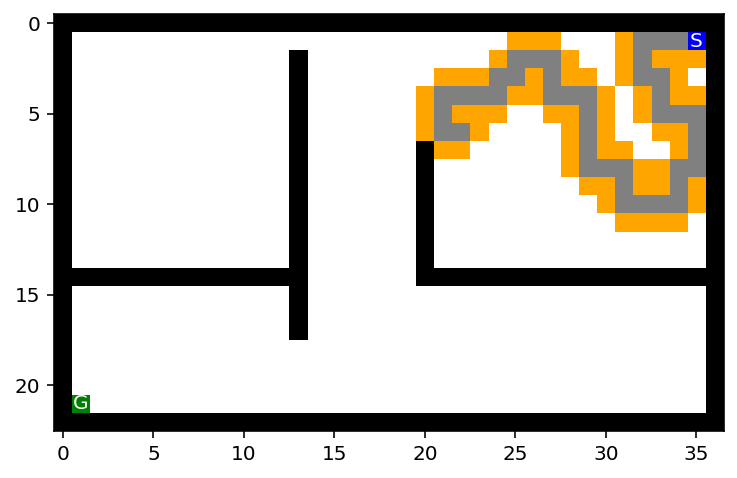

Node - pos = (7, 22); parent = <__main__.Node object at 0x7f100b14ac10>; action = South; cost = 43


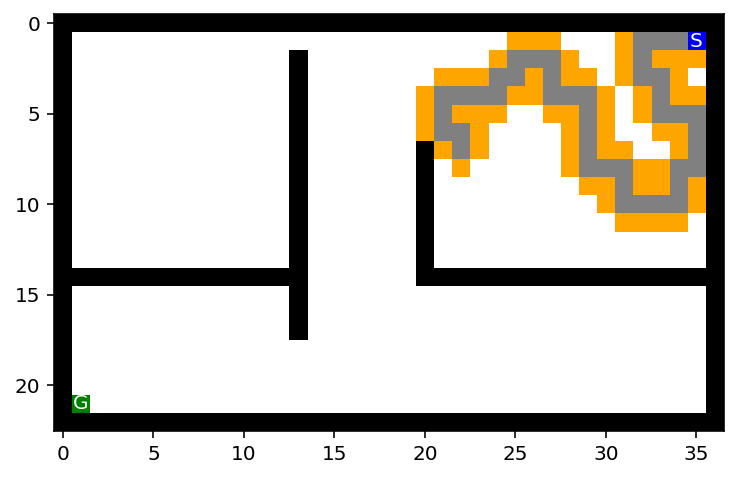

Node - pos = (7, 23); parent = <__main__.Node object at 0x7f100b1a7940>; action = East; cost = 44


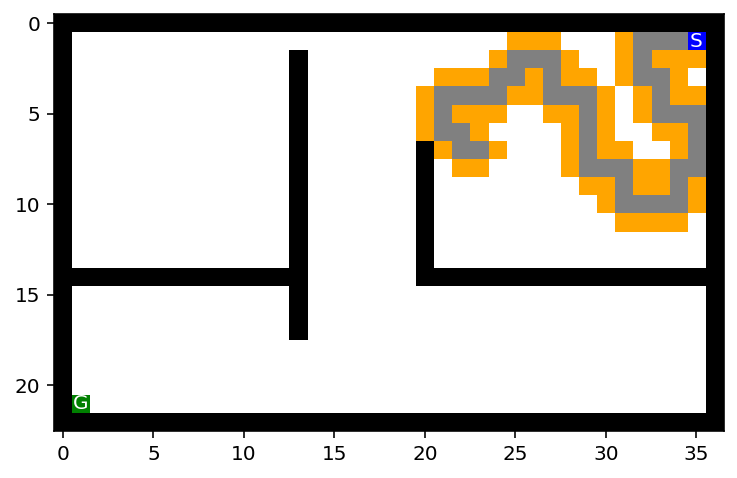

Node - pos = (8, 23); parent = <__main__.Node object at 0x7f100ae9a640>; action = South; cost = 45


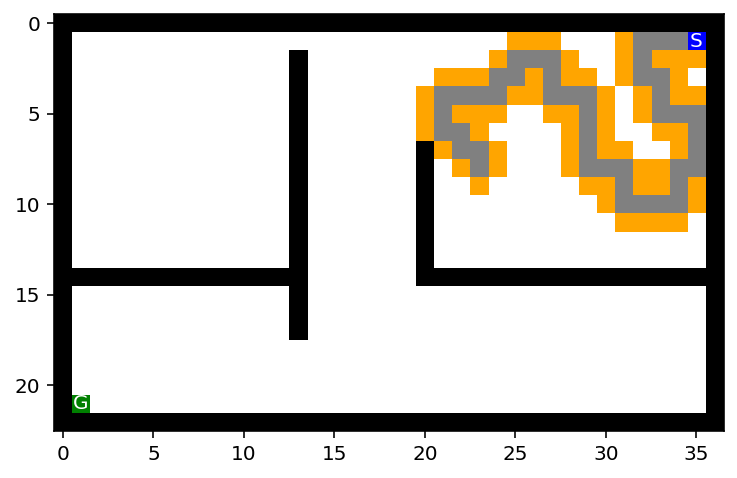

Node - pos = (8, 24); parent = <__main__.Node object at 0x7f100ae5d790>; action = East; cost = 46


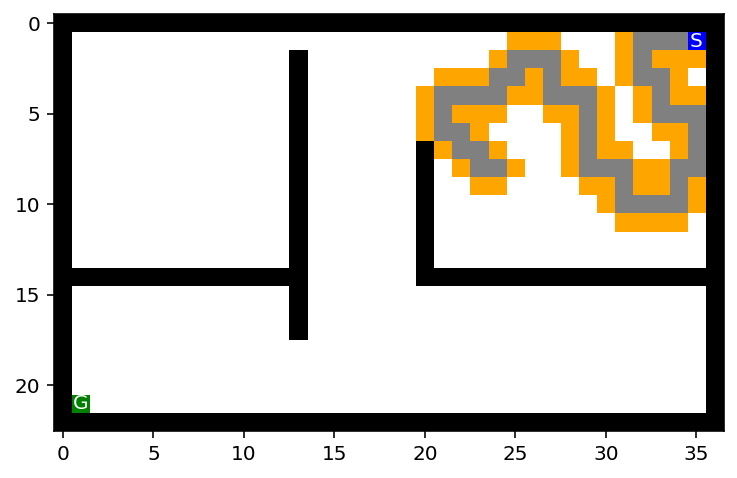

Node - pos = (8, 25); parent = <__main__.Node object at 0x7f100b00a7f0>; action = East; cost = 47


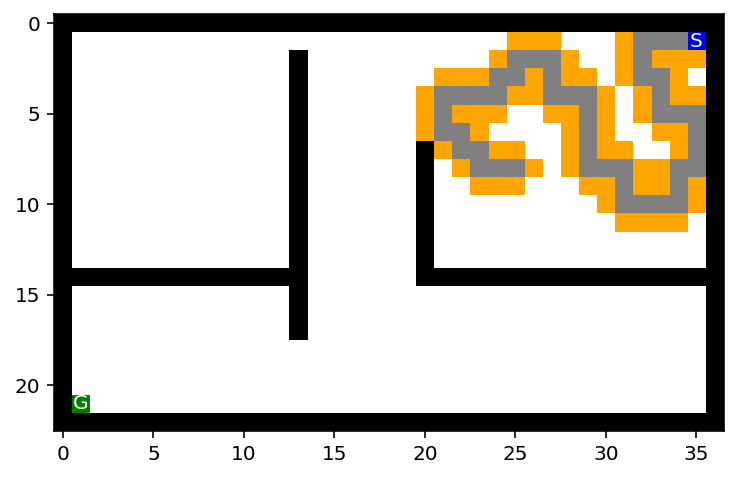

Node - pos = (7, 25); parent = <__main__.Node object at 0x7f100ae58190>; action = North; cost = 48


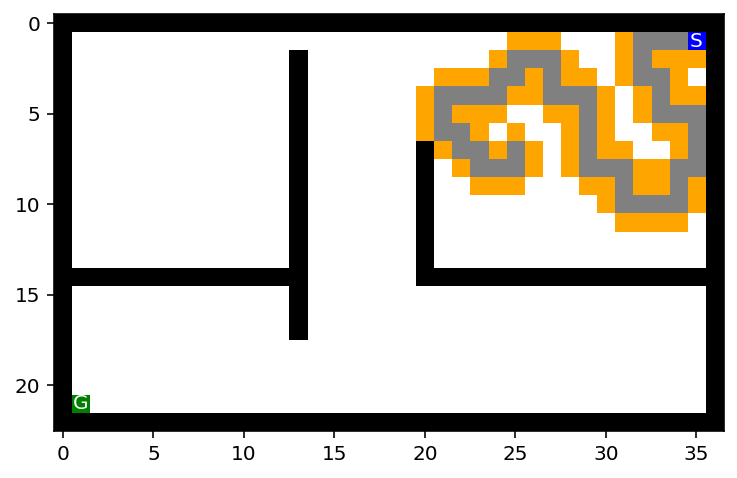

Node - pos = (7, 26); parent = <__main__.Node object at 0x7f100b056d00>; action = East; cost = 49


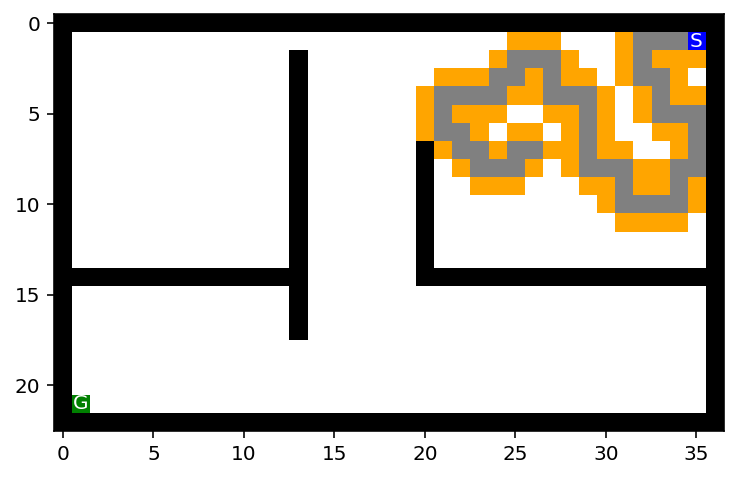

Node - pos = (7, 27); parent = <__main__.Node object at 0x7f100b242af0>; action = East; cost = 50


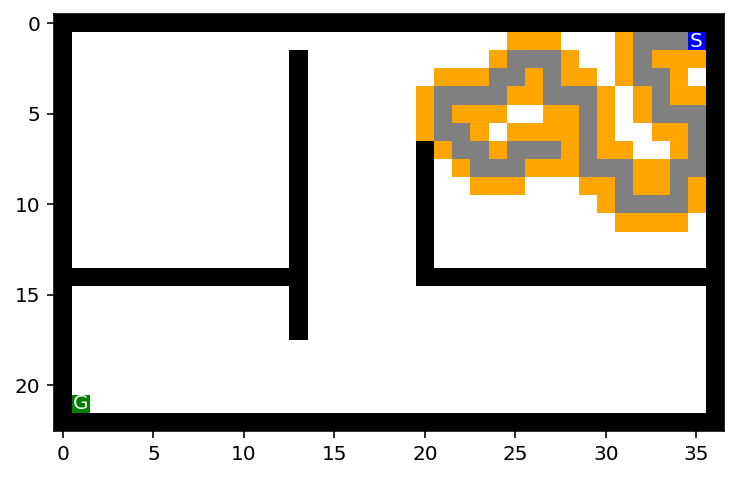

Node - pos = (8, 27); parent = <__main__.Node object at 0x7f100b221880>; action = South; cost = 51


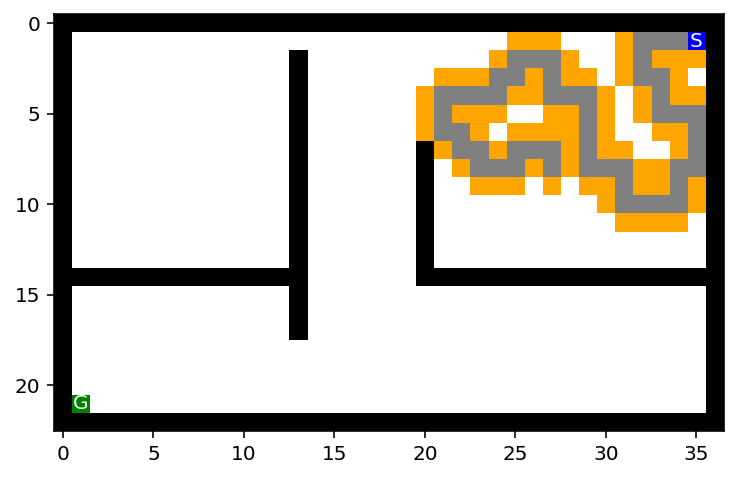

Node - pos = (9, 27); parent = <__main__.Node object at 0x7f100ae98970>; action = South; cost = 52


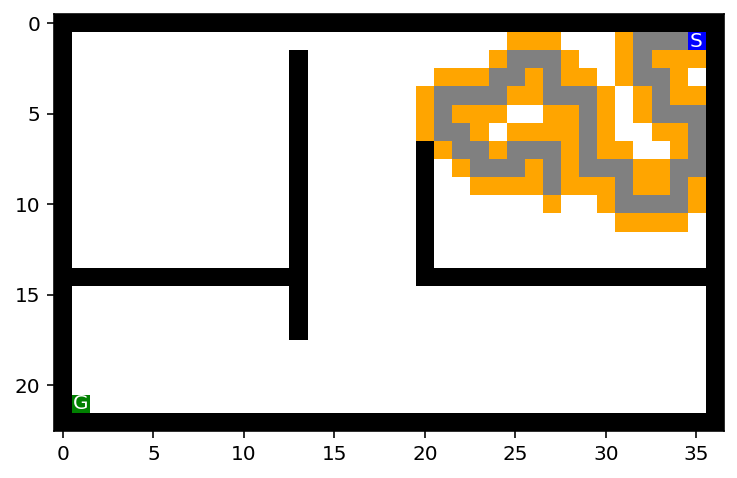

Node - pos = (9, 26); parent = <__main__.Node object at 0x7f100b135a00>; action = West; cost = 53


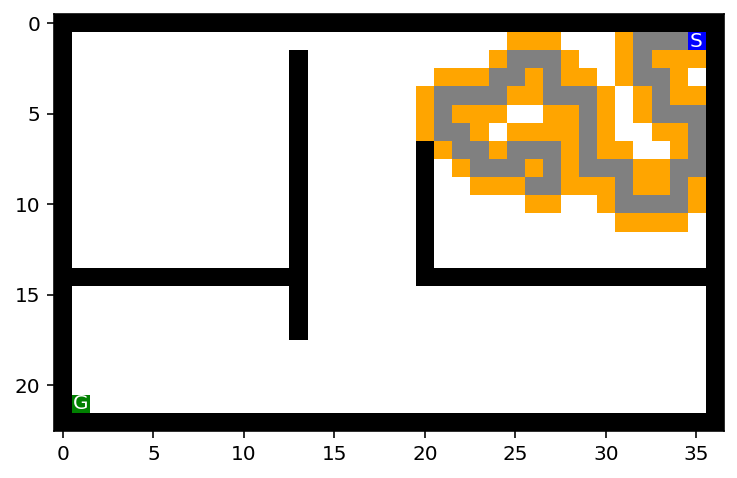

Node - pos = (10, 26); parent = <__main__.Node object at 0x7f100b103a90>; action = South; cost = 54


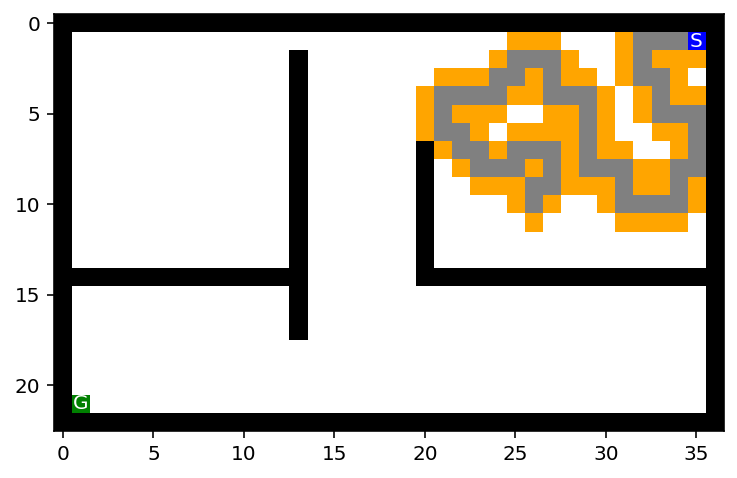

Node - pos = (10, 25); parent = <__main__.Node object at 0x7f100ad9fa30>; action = West; cost = 55


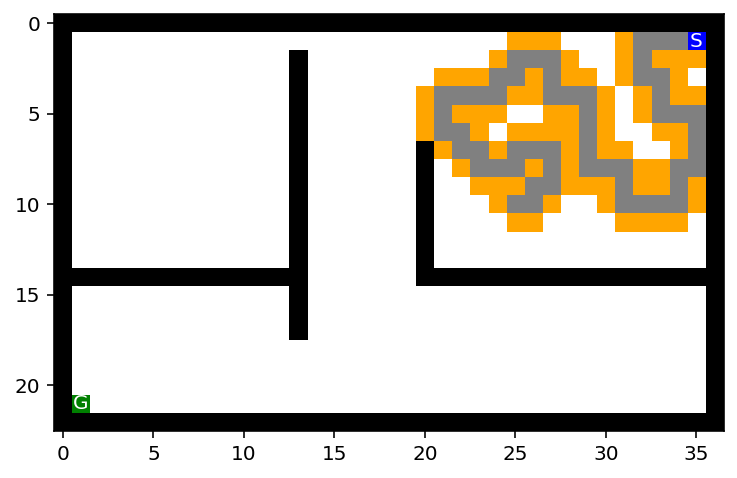

Node - pos = (10, 24); parent = <__main__.Node object at 0x7f100b0d4250>; action = West; cost = 56


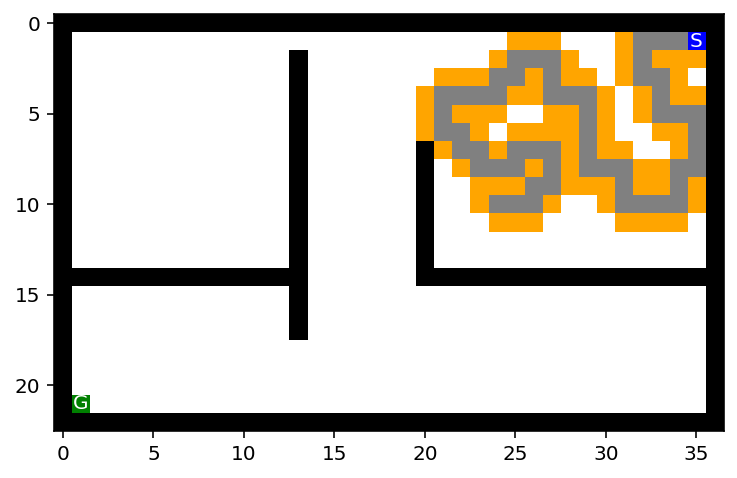

Node - pos = (10, 23); parent = <__main__.Node object at 0x7f100ad9f760>; action = West; cost = 57


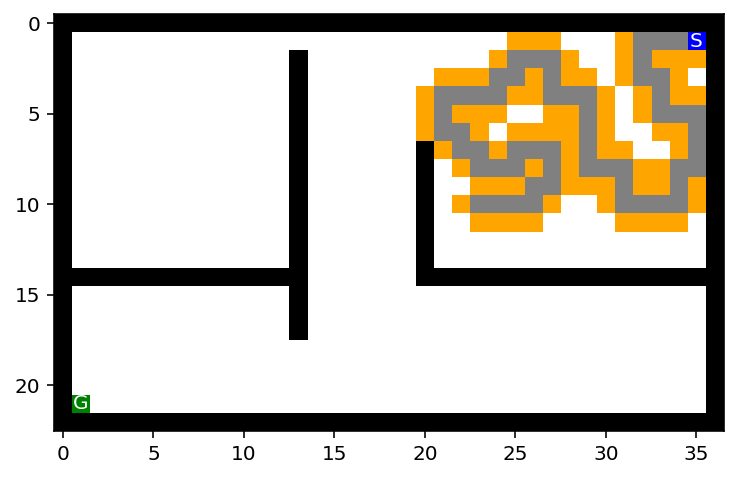

Node - pos = (11, 23); parent = <__main__.Node object at 0x7f100b18c580>; action = South; cost = 58


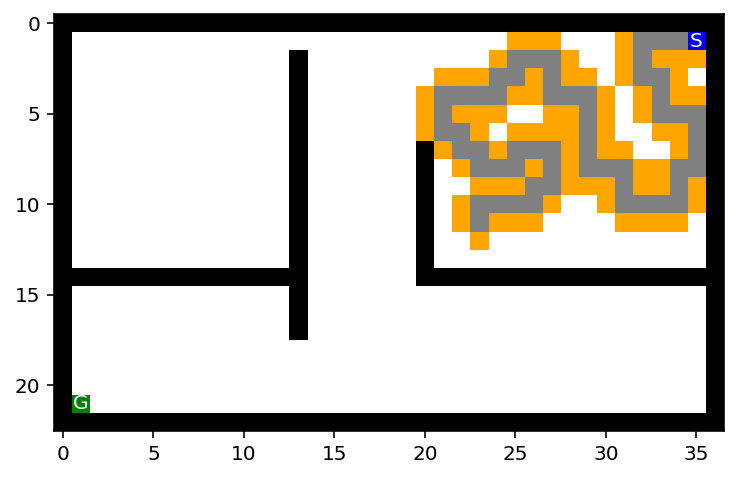

Node - pos = (12, 23); parent = <__main__.Node object at 0x7f100b103c40>; action = South; cost = 59


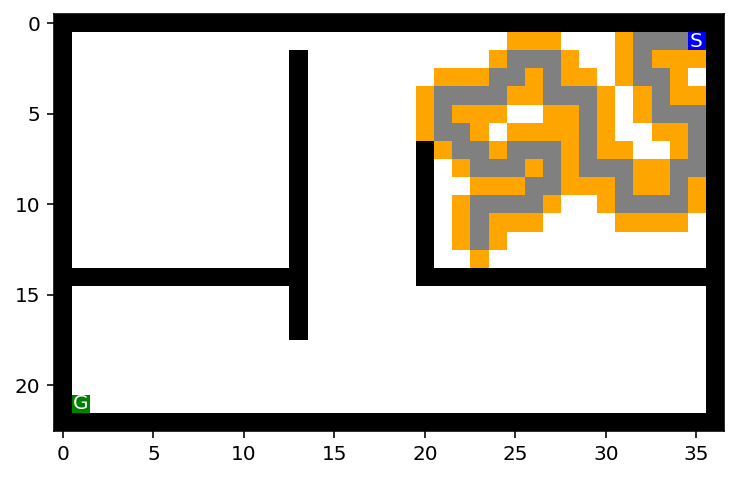

Node - pos = (12, 24); parent = <__main__.Node object at 0x7f100b15ea30>; action = East; cost = 60


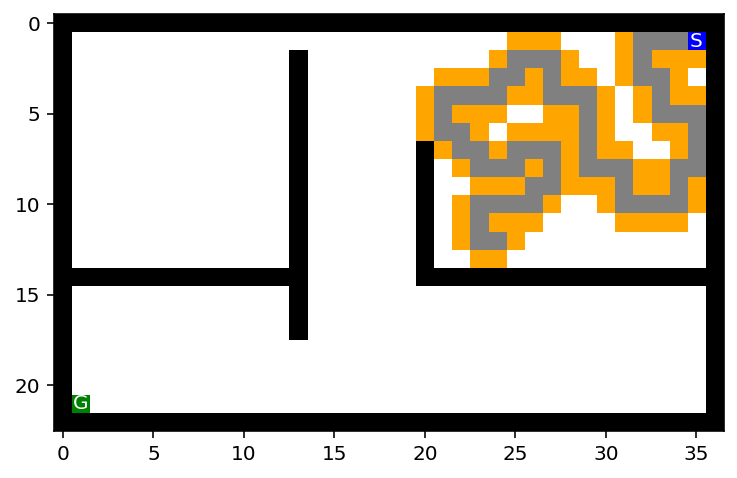

Node - pos = (13, 24); parent = <__main__.Node object at 0x7f100b0c2e50>; action = South; cost = 61


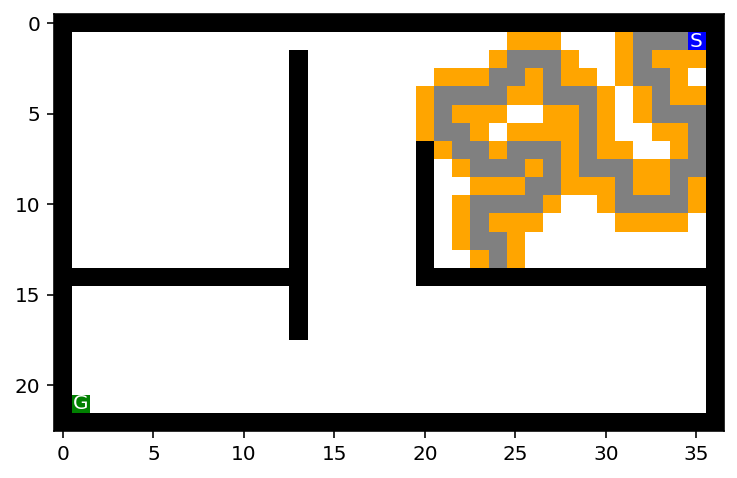

Node - pos = (13, 25); parent = <__main__.Node object at 0x7f100b187d60>; action = East; cost = 62


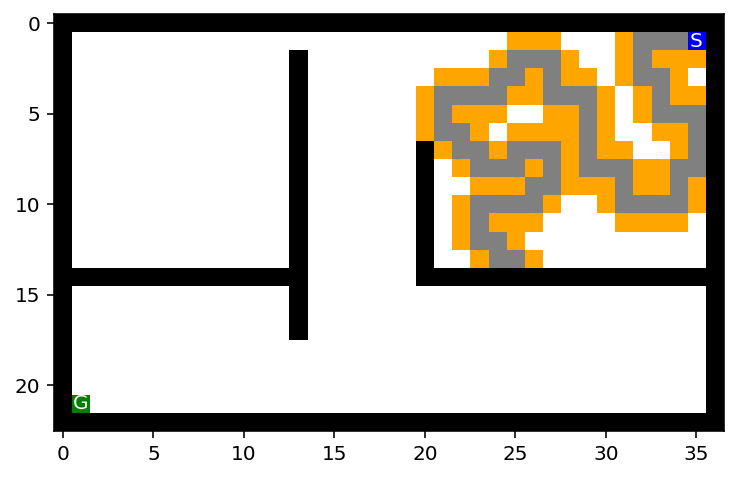

Node - pos = (13, 26); parent = <__main__.Node object at 0x7f100aec37f0>; action = East; cost = 63


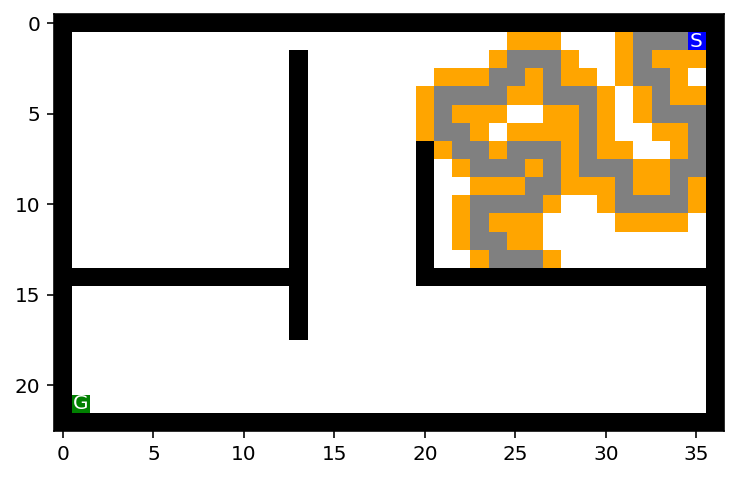

Node - pos = (13, 27); parent = <__main__.Node object at 0x7f100addbd00>; action = East; cost = 64


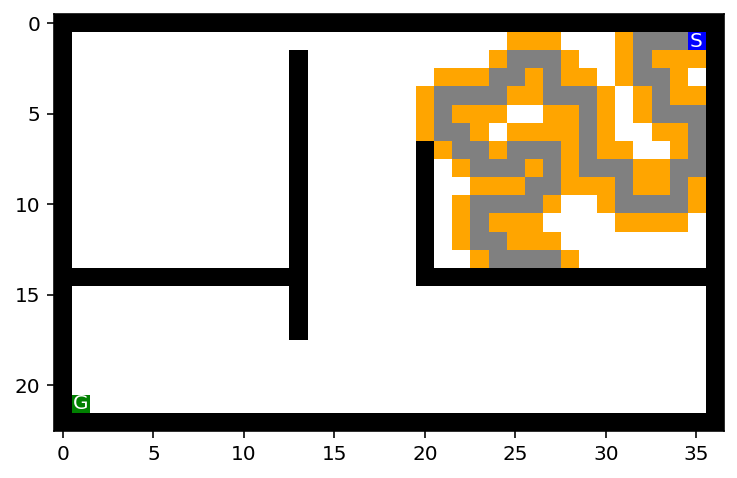

Node - pos = (12, 27); parent = <__main__.Node object at 0x7f100ae5dd30>; action = North; cost = 65


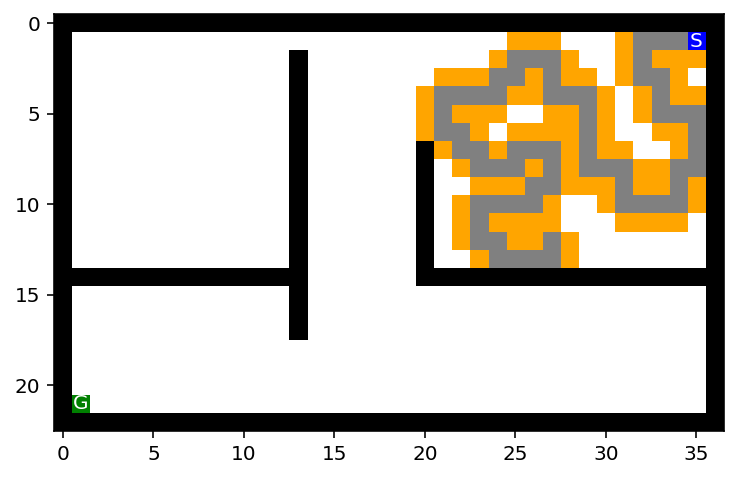

Node - pos = (12, 28); parent = <__main__.Node object at 0x7f100b0953a0>; action = East; cost = 66


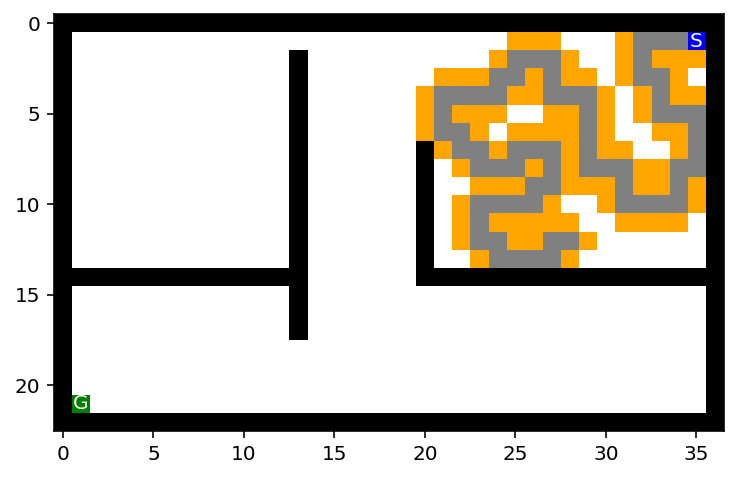

Node - pos = (12, 29); parent = <__main__.Node object at 0x7f100ae34af0>; action = East; cost = 67


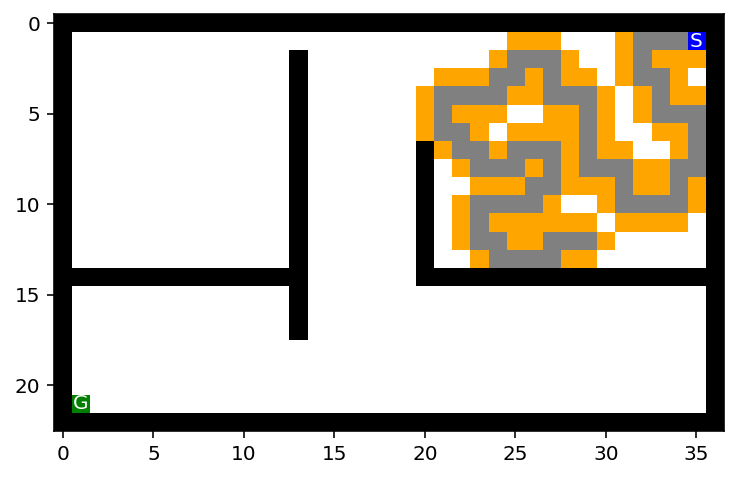

Node - pos = (11, 29); parent = <__main__.Node object at 0x7f100b176f10>; action = North; cost = 68


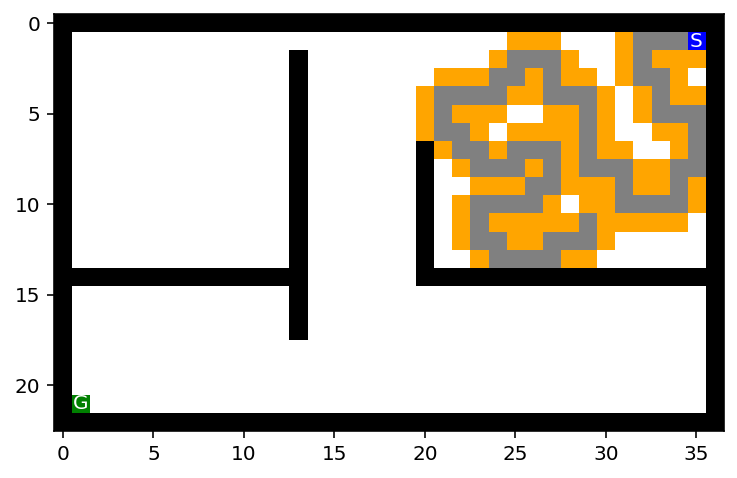

Node - pos = (11, 30); parent = <__main__.Node object at 0x7f100b01dc70>; action = East; cost = 69


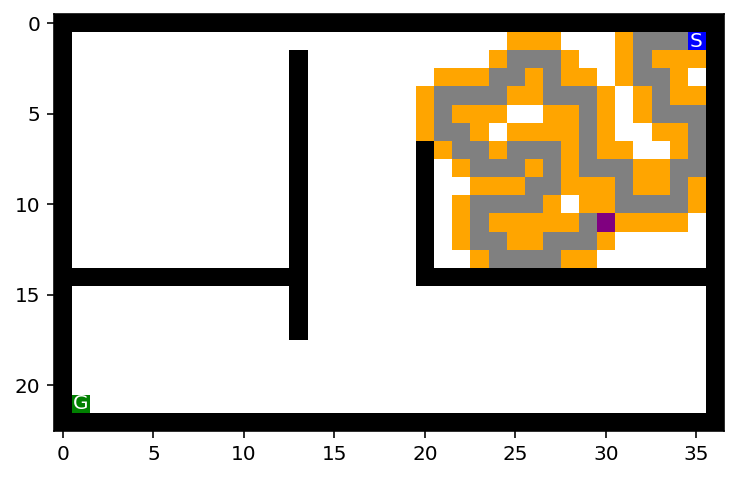

Node - pos = (10, 29); parent = <__main__.Node object at 0x7f100b01dc70>; action = North; cost = 69


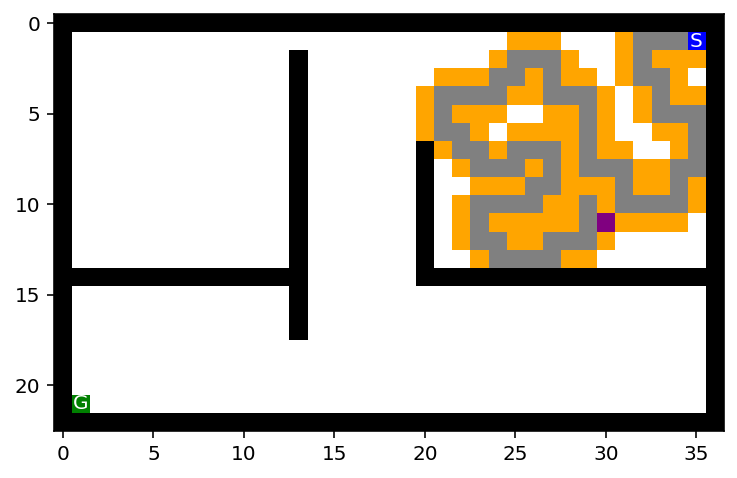

Node - pos = (10, 28); parent = <__main__.Node object at 0x7f100aed2610>; action = West; cost = 70


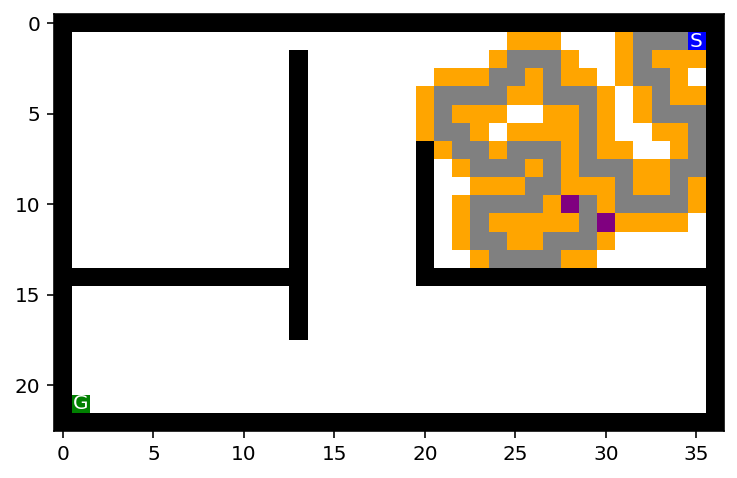

Node - pos = (10, 29); parent = <__main__.Node object at 0x7f100b01dc70>; action = North; cost = 69


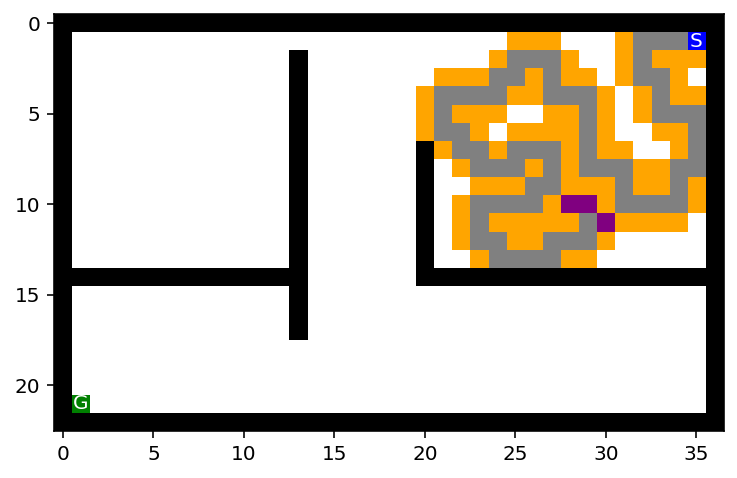

Node - pos = (11, 29); parent = <__main__.Node object at 0x7f100b176f10>; action = North; cost = 68


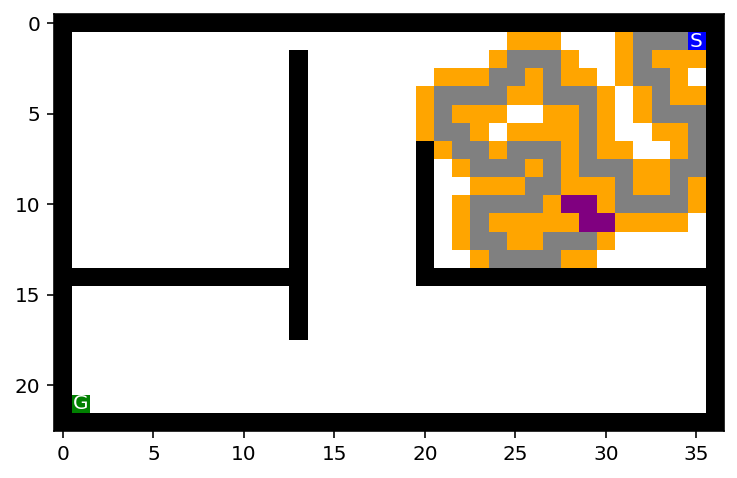

Node - pos = (13, 29); parent = <__main__.Node object at 0x7f100b176f10>; action = South; cost = 68


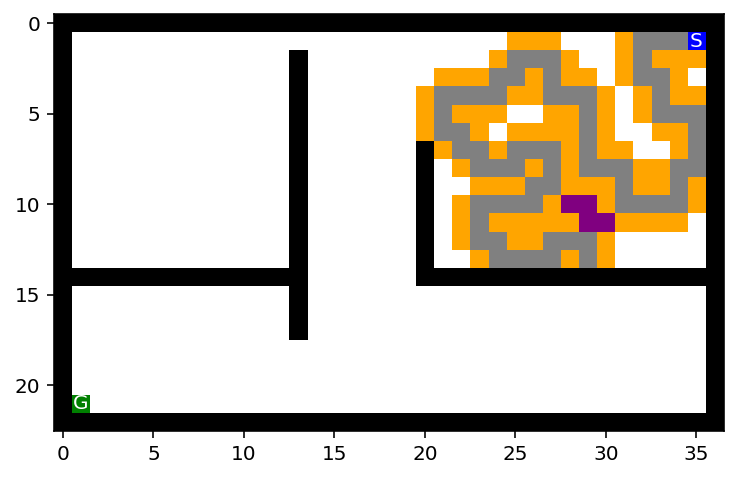

Node - pos = (13, 30); parent = <__main__.Node object at 0x7f100b01d4c0>; action = East; cost = 69


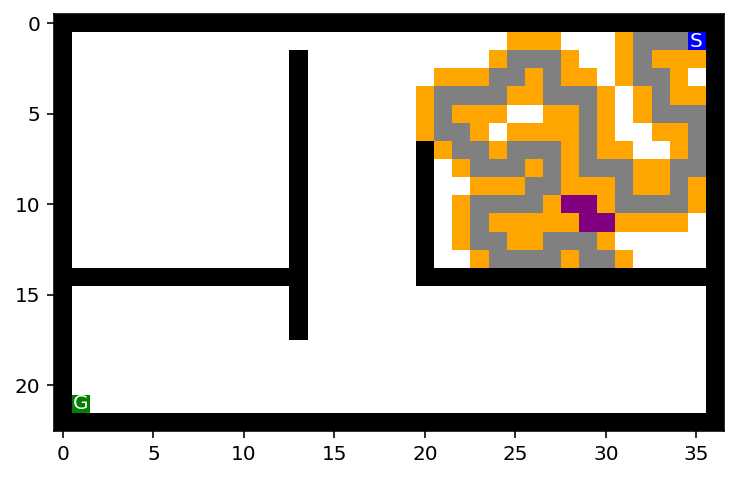

Node - pos = (13, 31); parent = <__main__.Node object at 0x7f100aed26a0>; action = East; cost = 70


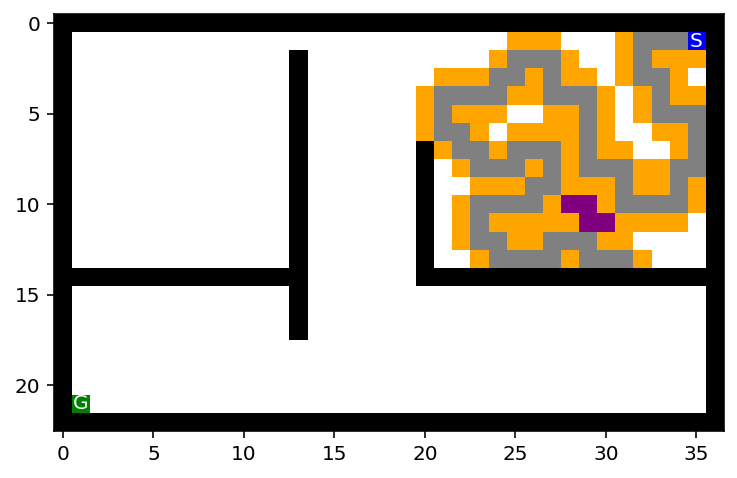

Node - pos = (13, 32); parent = <__main__.Node object at 0x7f100b142c70>; action = East; cost = 71


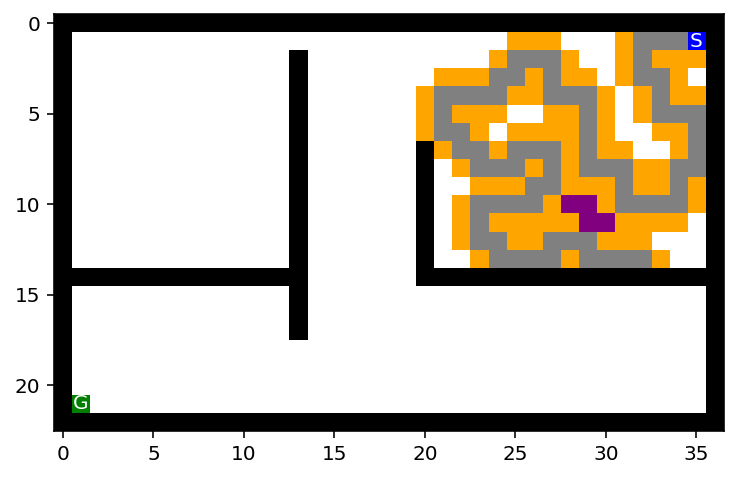

Node - pos = (12, 32); parent = <__main__.Node object at 0x7f100af426a0>; action = North; cost = 72


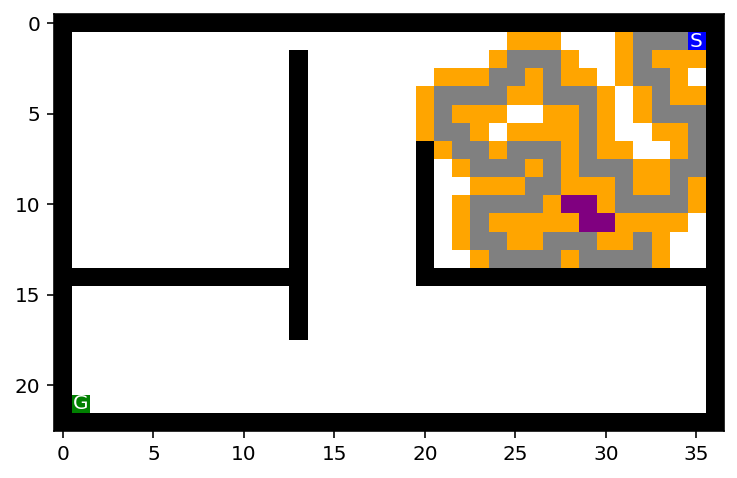

Node - pos = (12, 33); parent = <__main__.Node object at 0x7f100af54be0>; action = East; cost = 73


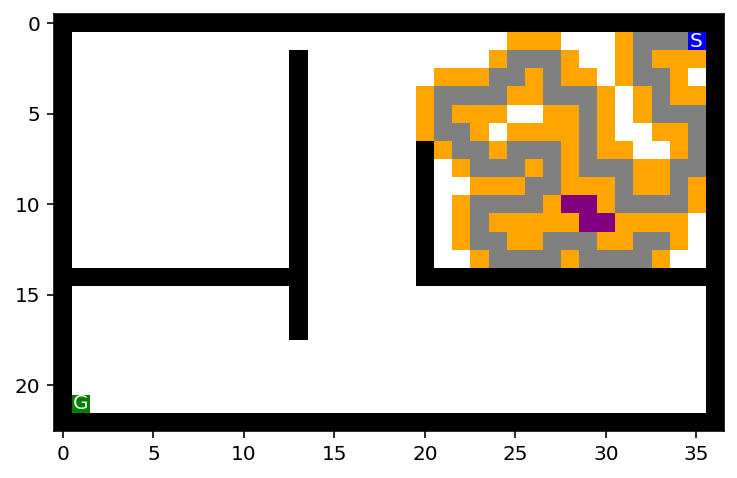

Node - pos = (12, 34); parent = <__main__.Node object at 0x7f100ae9adf0>; action = East; cost = 74


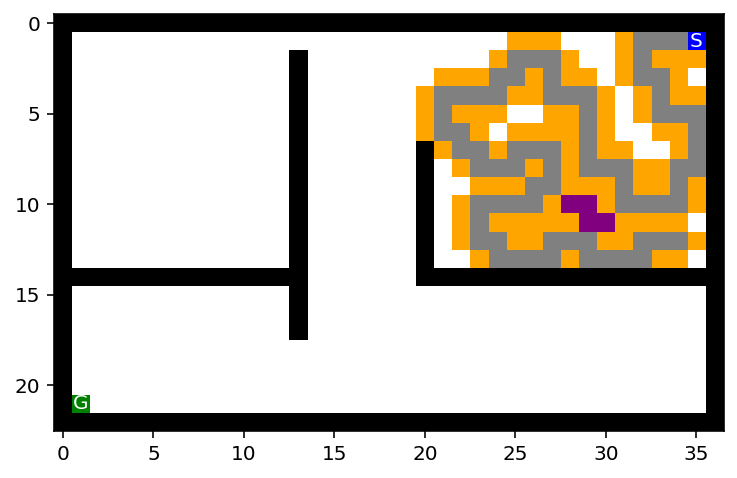

Node - pos = (12, 35); parent = <__main__.Node object at 0x7f100b103490>; action = East; cost = 75


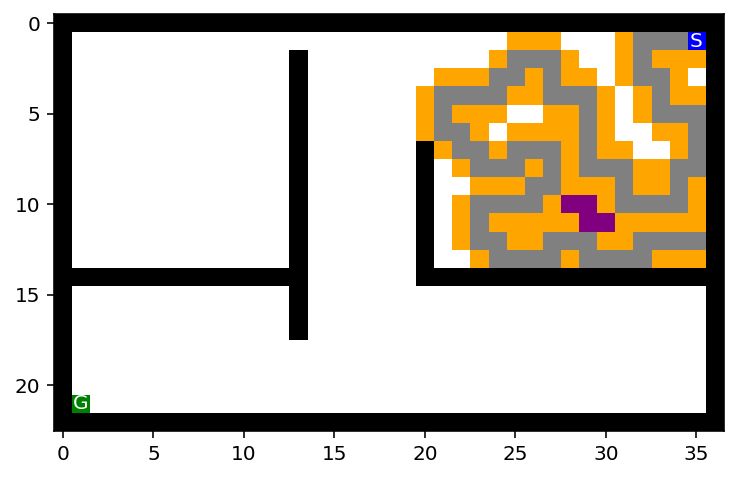

Node - pos = (11, 35); parent = <__main__.Node object at 0x7f100b1bcdf0>; action = North; cost = 76


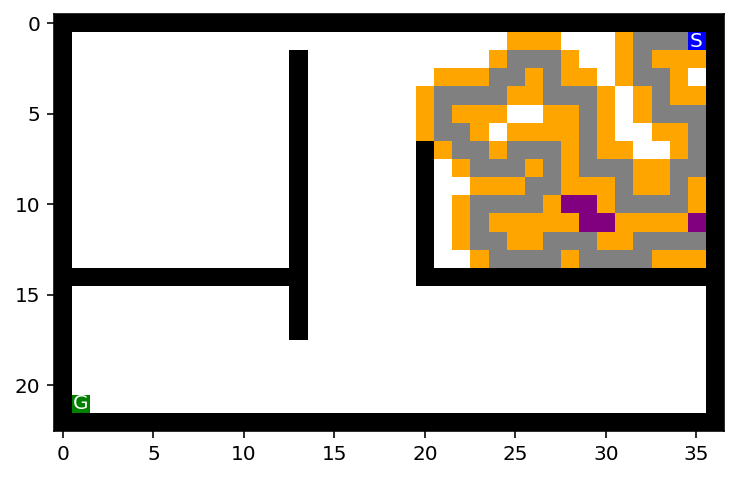

Node - pos = (13, 35); parent = <__main__.Node object at 0x7f100b1bcdf0>; action = South; cost = 76


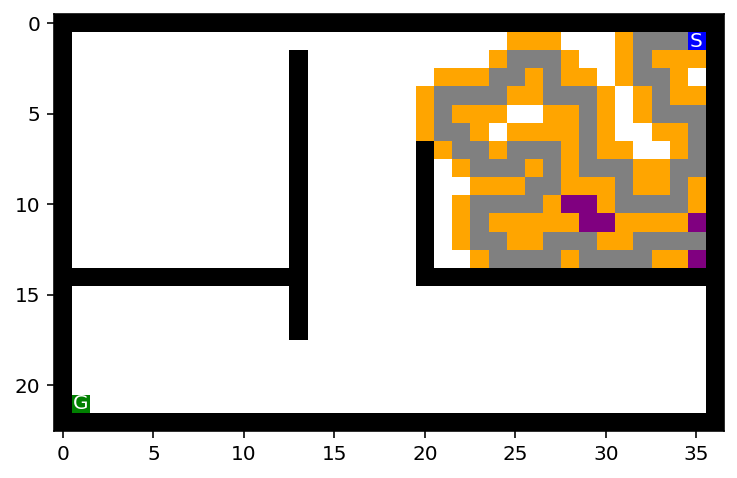

Node - pos = (12, 35); parent = <__main__.Node object at 0x7f100b103490>; action = East; cost = 75


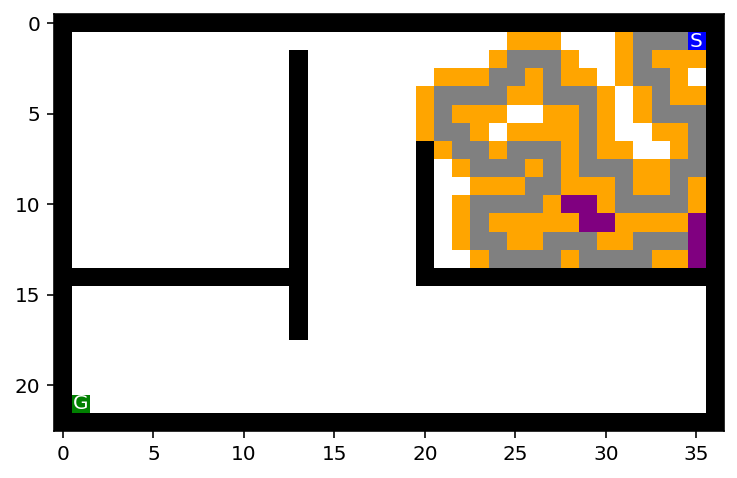

Node - pos = (13, 34); parent = <__main__.Node object at 0x7f100b103490>; action = South; cost = 75


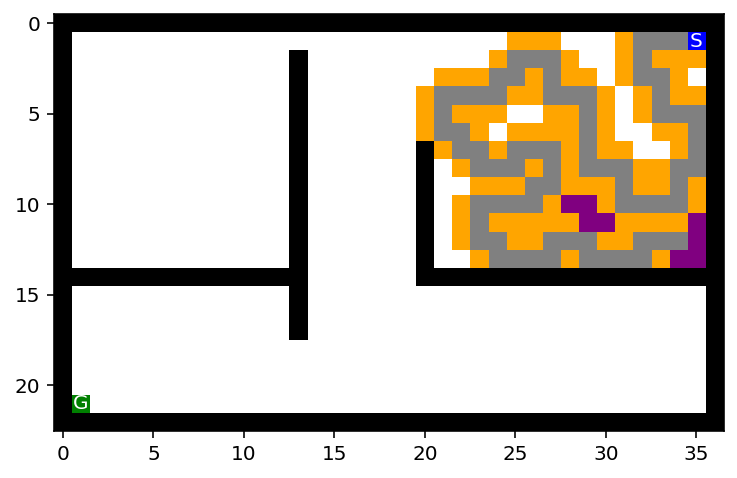

Node - pos = (12, 34); parent = <__main__.Node object at 0x7f100ae9adf0>; action = East; cost = 74


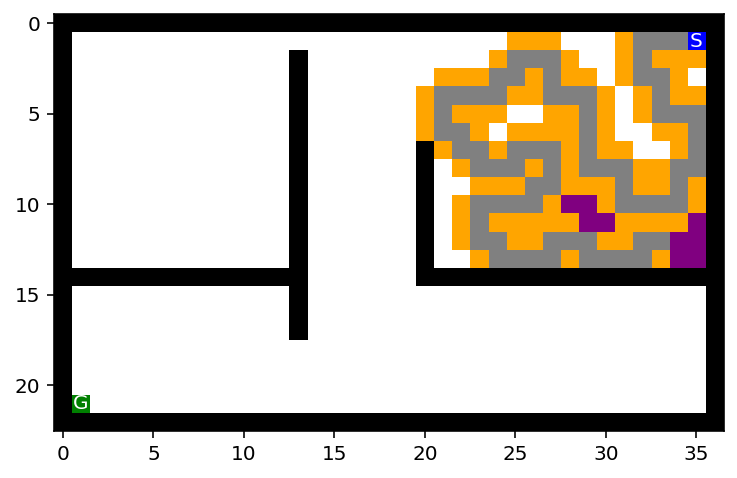

Node - pos = (12, 33); parent = <__main__.Node object at 0x7f100af54be0>; action = East; cost = 73


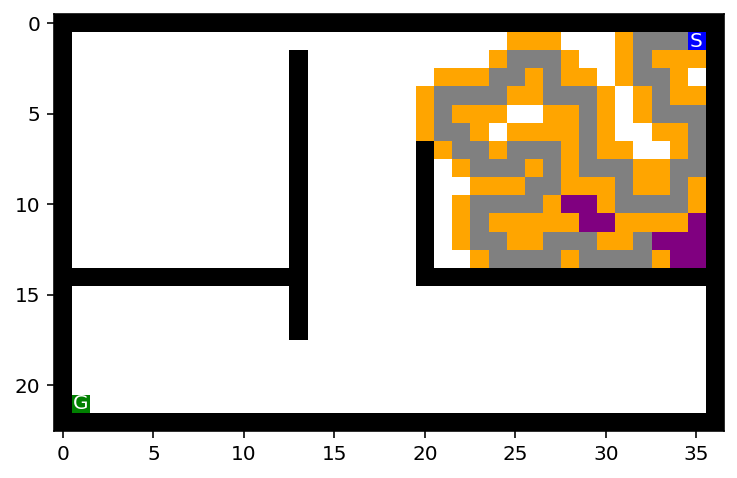

Node - pos = (12, 32); parent = <__main__.Node object at 0x7f100af426a0>; action = North; cost = 72


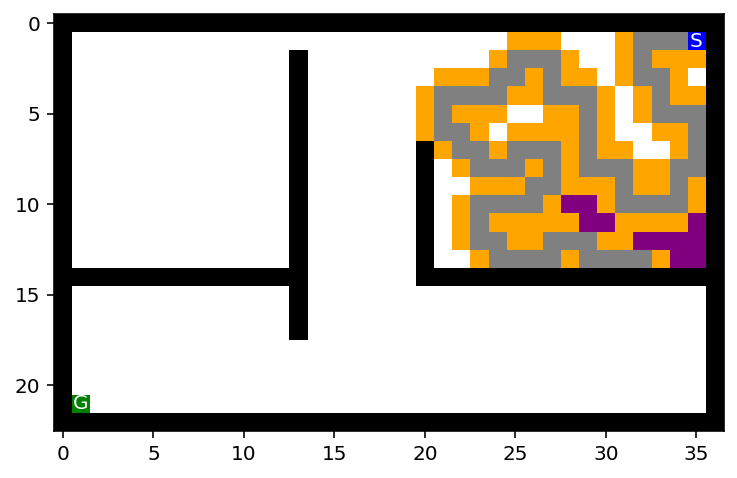

Node - pos = (13, 33); parent = <__main__.Node object at 0x7f100af426a0>; action = East; cost = 72


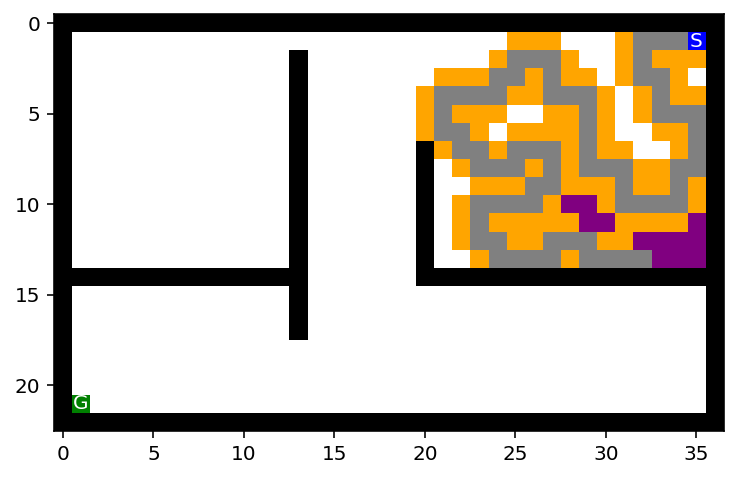

Node - pos = (13, 32); parent = <__main__.Node object at 0x7f100b142c70>; action = East; cost = 71


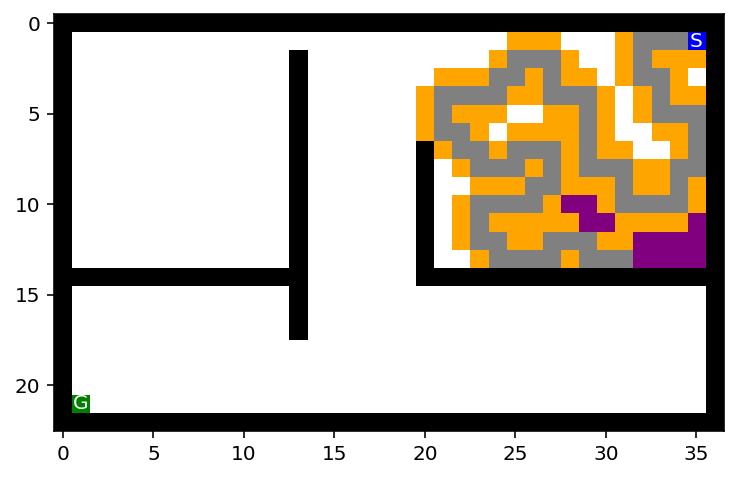

Node - pos = (12, 31); parent = <__main__.Node object at 0x7f100b142c70>; action = North; cost = 71


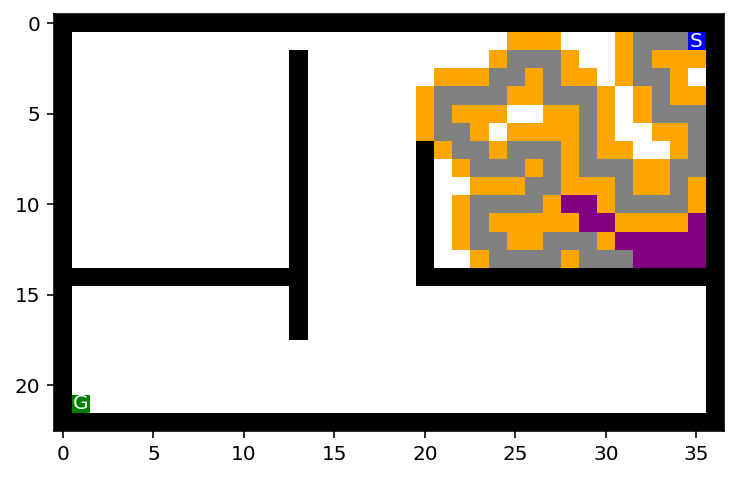

Node - pos = (13, 31); parent = <__main__.Node object at 0x7f100aed26a0>; action = East; cost = 70


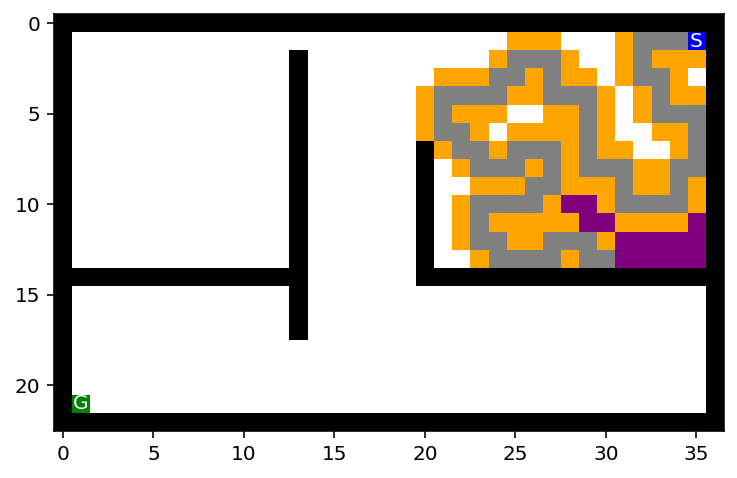

Node - pos = (13, 30); parent = <__main__.Node object at 0x7f100b01d4c0>; action = East; cost = 69


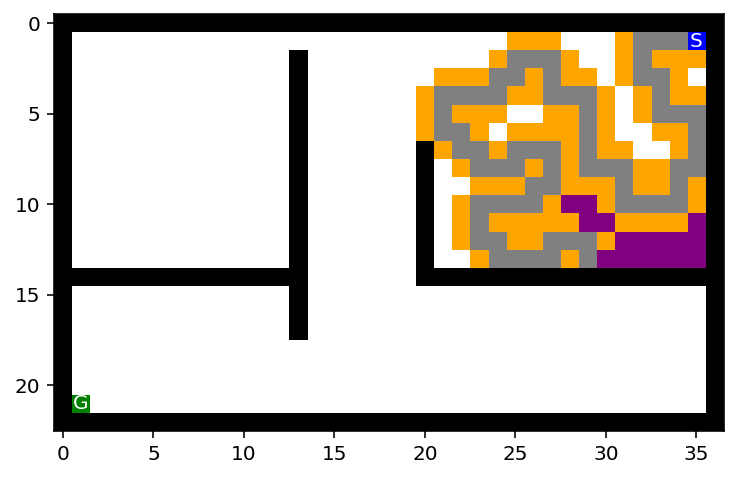

Node - pos = (13, 29); parent = <__main__.Node object at 0x7f100b176f10>; action = South; cost = 68


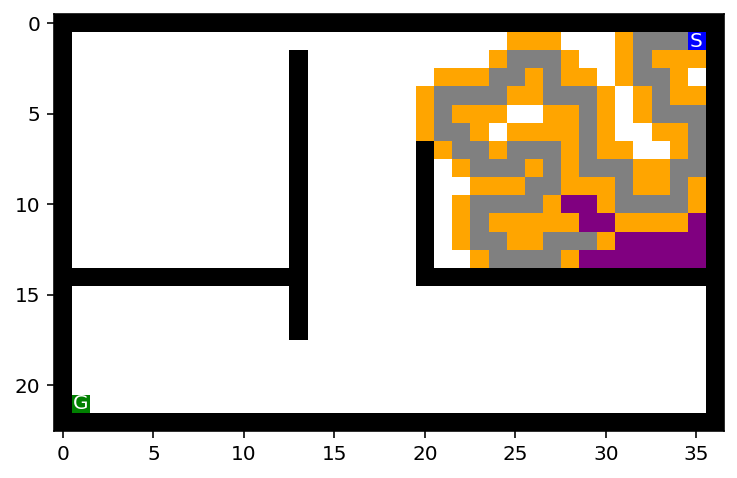

Node - pos = (12, 30); parent = <__main__.Node object at 0x7f100b176f10>; action = East; cost = 68


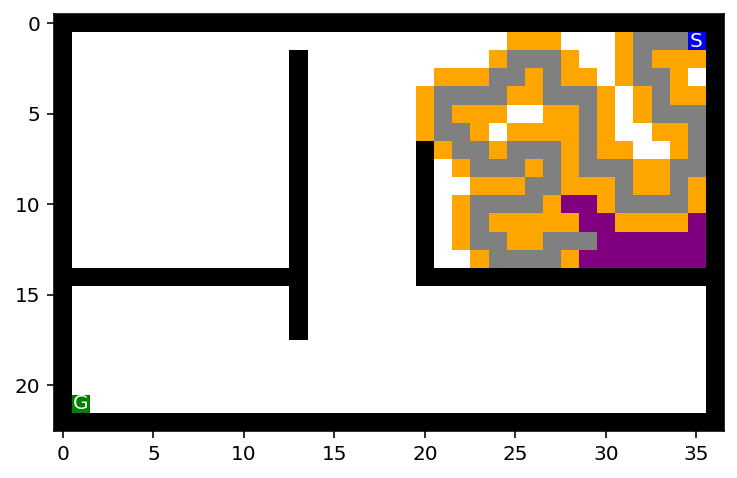

Node - pos = (12, 29); parent = <__main__.Node object at 0x7f100ae34af0>; action = East; cost = 67


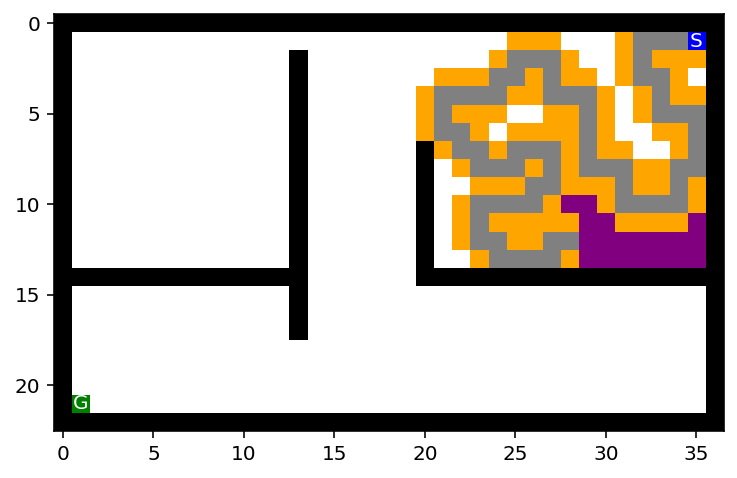

Node - pos = (11, 28); parent = <__main__.Node object at 0x7f100ae34af0>; action = North; cost = 67


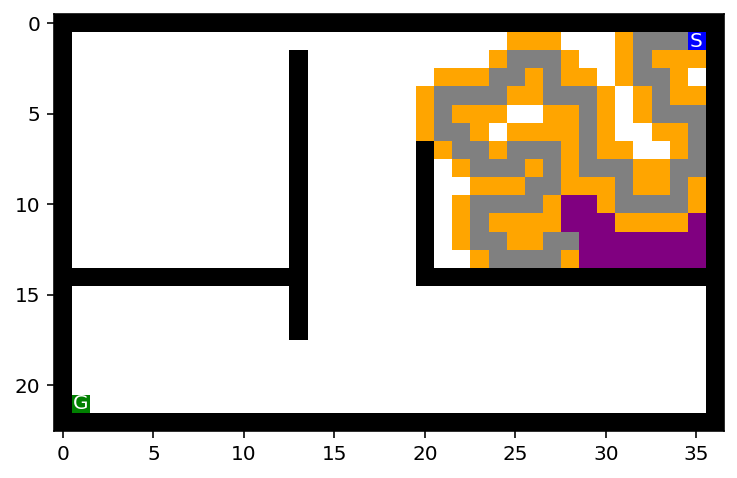

Node - pos = (12, 28); parent = <__main__.Node object at 0x7f100b0953a0>; action = East; cost = 66


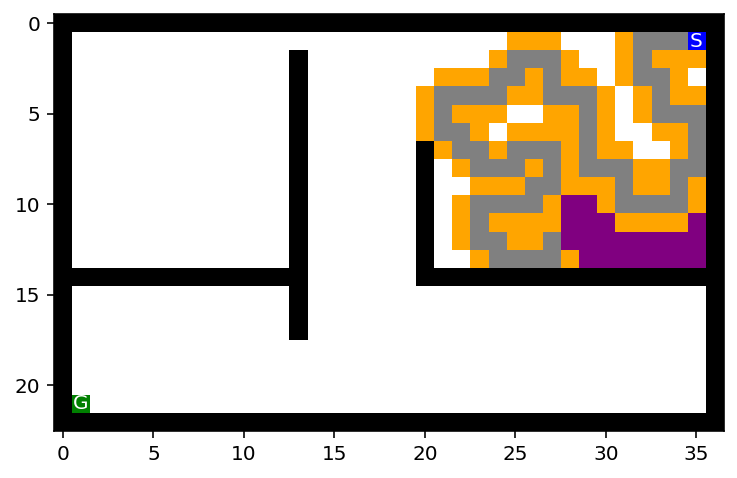

Node - pos = (11, 27); parent = <__main__.Node object at 0x7f100b0953a0>; action = North; cost = 66


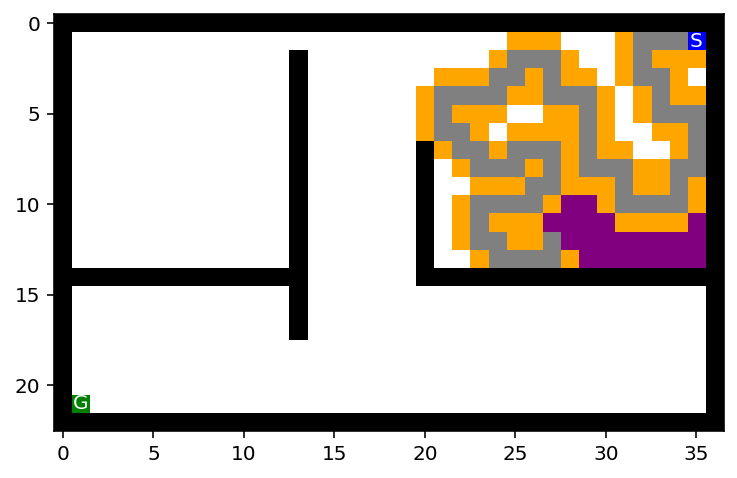

Node - pos = (12, 27); parent = <__main__.Node object at 0x7f100ae5dd30>; action = North; cost = 65


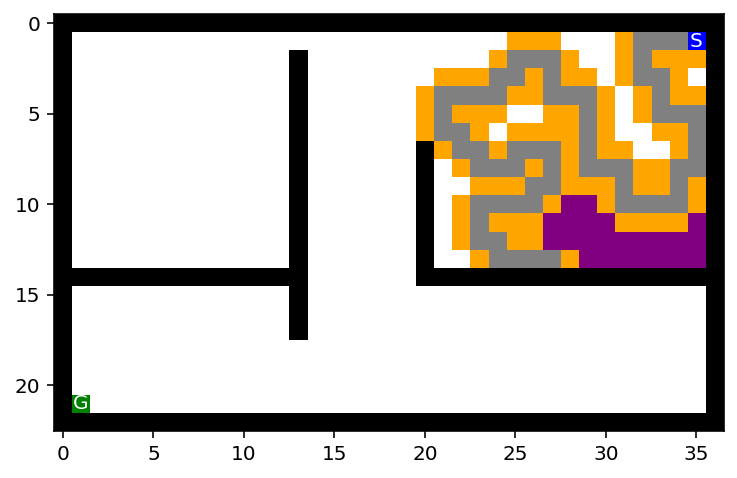

Node - pos = (13, 28); parent = <__main__.Node object at 0x7f100ae5dd30>; action = East; cost = 65


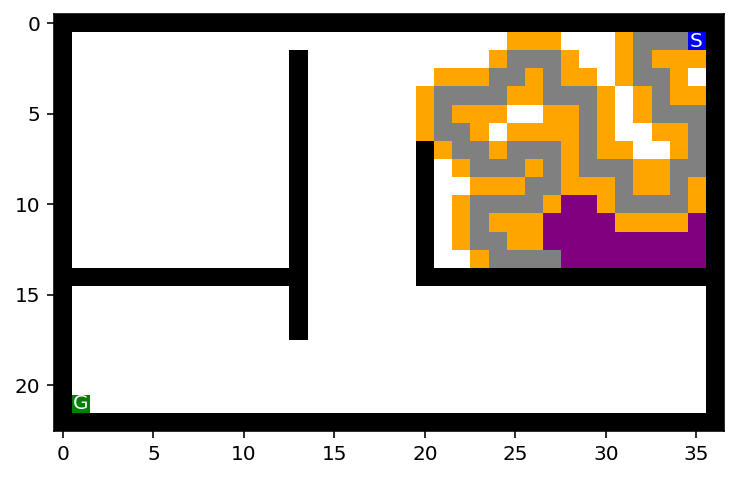

Node - pos = (13, 27); parent = <__main__.Node object at 0x7f100addbd00>; action = East; cost = 64


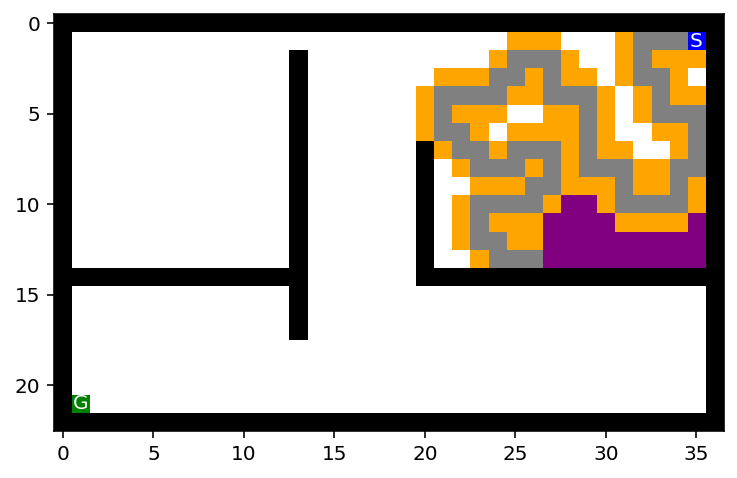

Node - pos = (12, 26); parent = <__main__.Node object at 0x7f100addbd00>; action = North; cost = 64


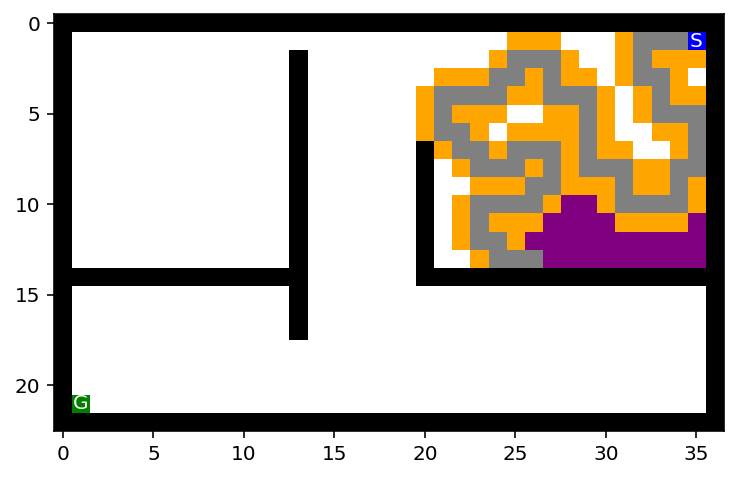

Node - pos = (13, 26); parent = <__main__.Node object at 0x7f100aec37f0>; action = East; cost = 63


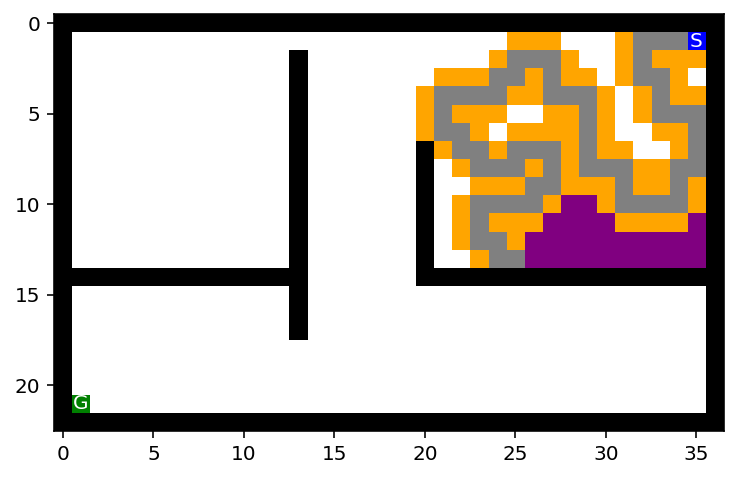

Node - pos = (13, 25); parent = <__main__.Node object at 0x7f100b187d60>; action = East; cost = 62


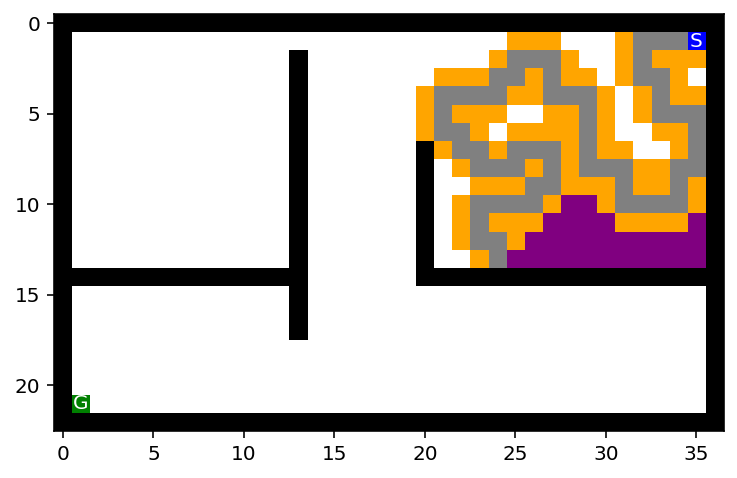

Node - pos = (13, 24); parent = <__main__.Node object at 0x7f100b0c2e50>; action = South; cost = 61


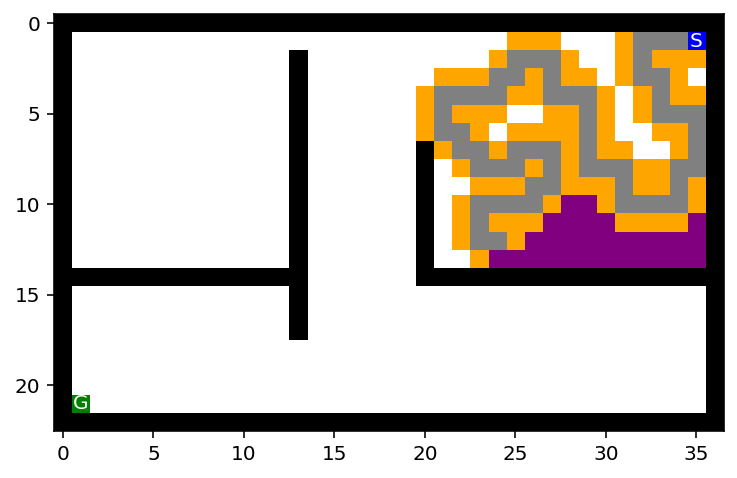

Node - pos = (12, 25); parent = <__main__.Node object at 0x7f100b0c2e50>; action = East; cost = 61


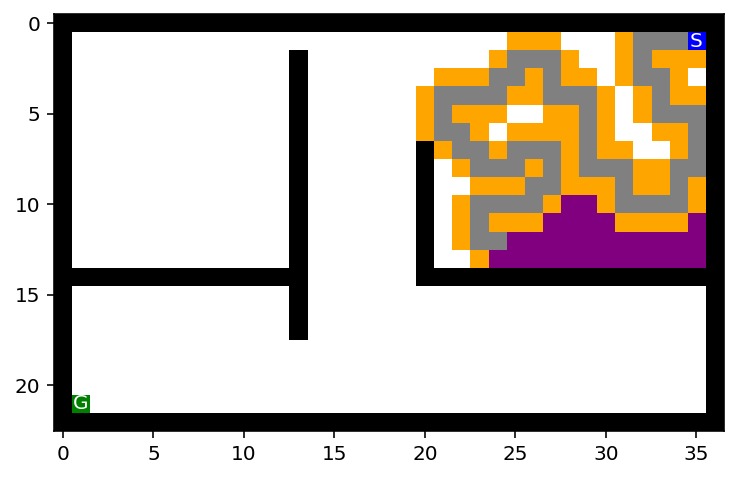

Node - pos = (12, 24); parent = <__main__.Node object at 0x7f100b15ea30>; action = East; cost = 60


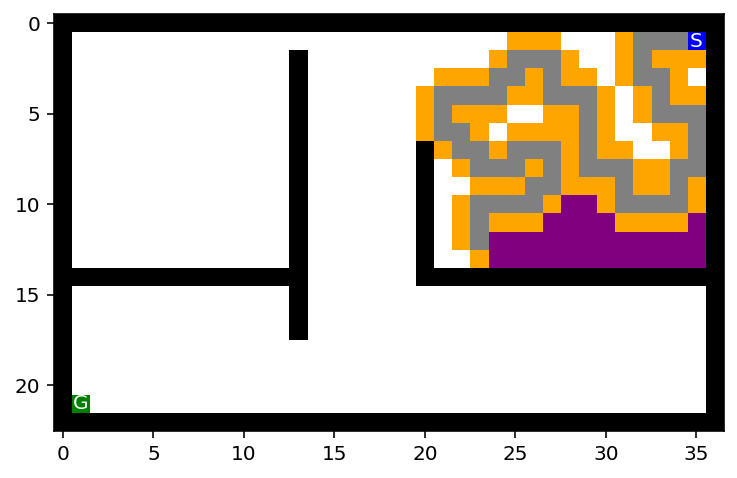

Node - pos = (13, 23); parent = <__main__.Node object at 0x7f100b15ea30>; action = South; cost = 60


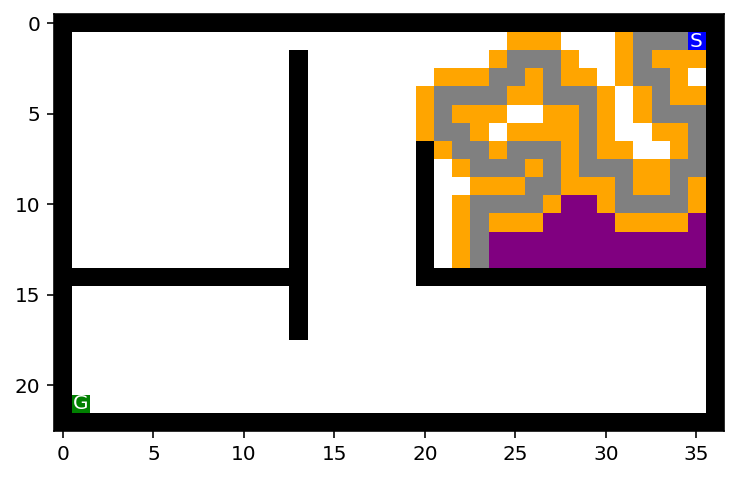

Node - pos = (13, 22); parent = <__main__.Node object at 0x7f100b0c2370>; action = West; cost = 61


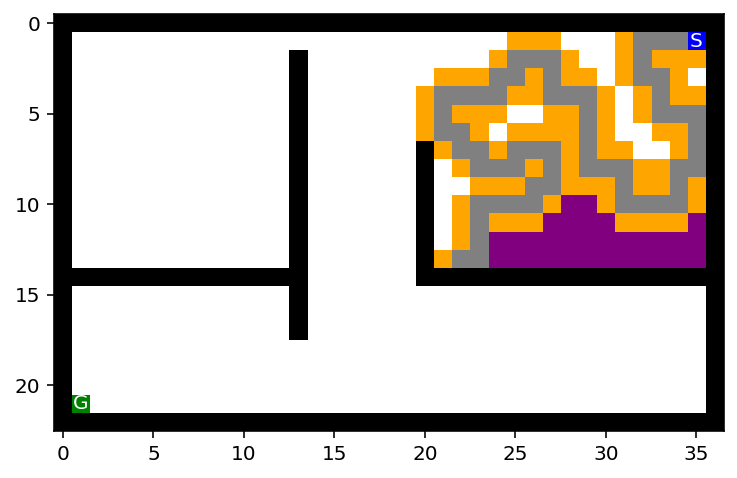

Node - pos = (13, 21); parent = <__main__.Node object at 0x7f100adc7430>; action = West; cost = 62


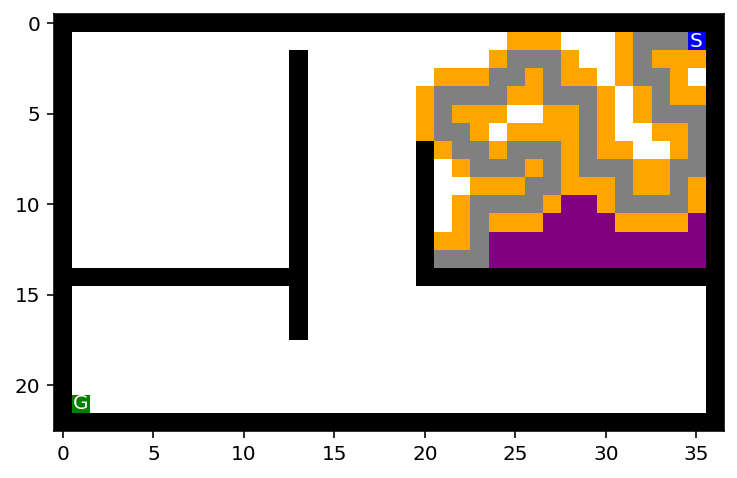

Node - pos = (12, 21); parent = <__main__.Node object at 0x7f100af5a4c0>; action = North; cost = 63


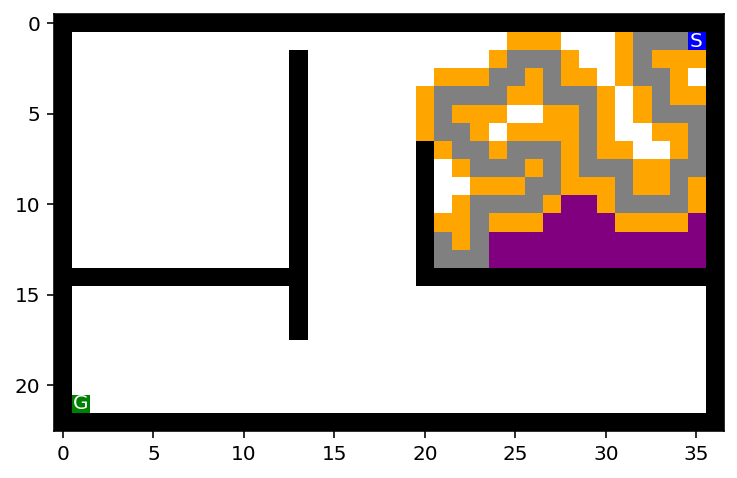

Node - pos = (11, 21); parent = <__main__.Node object at 0x7f100b00aee0>; action = North; cost = 64


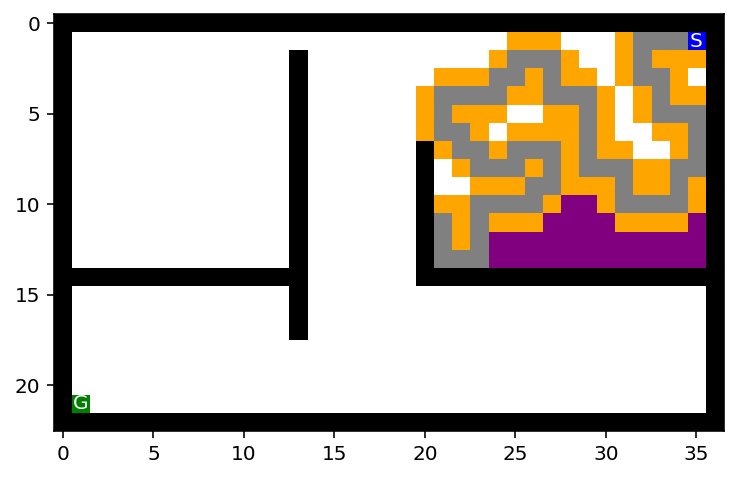

Node - pos = (10, 21); parent = <__main__.Node object at 0x7f100b1030a0>; action = North; cost = 65


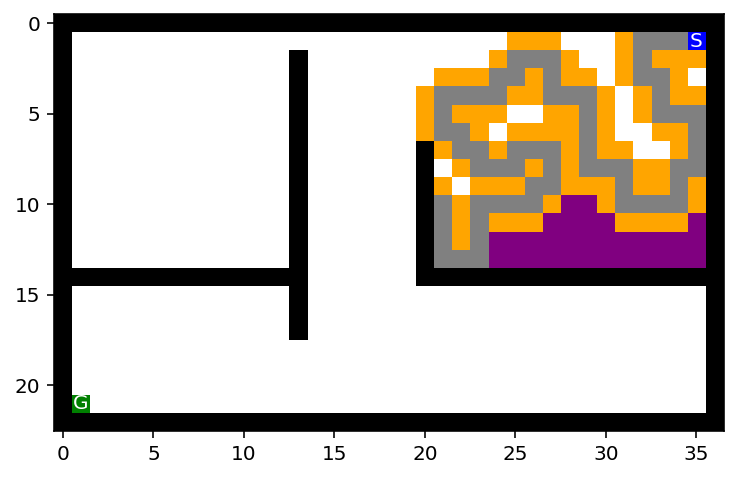

Node - pos = (9, 21); parent = <__main__.Node object at 0x7f100ad8d400>; action = North; cost = 66


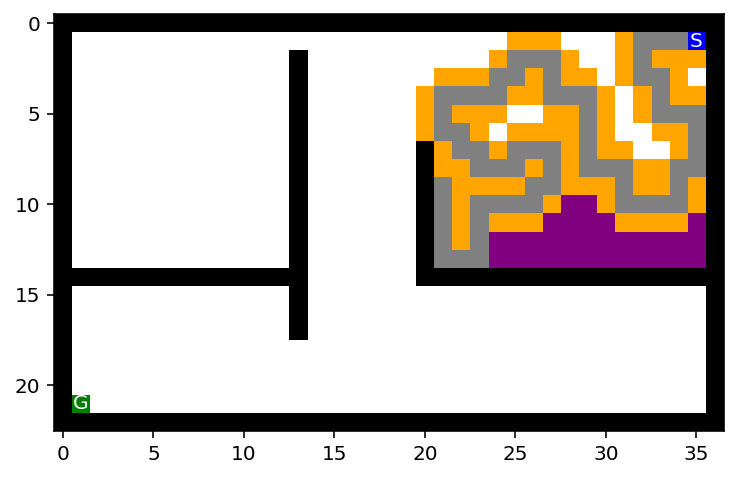

Node - pos = (8, 21); parent = <__main__.Node object at 0x7f100af16d90>; action = North; cost = 67


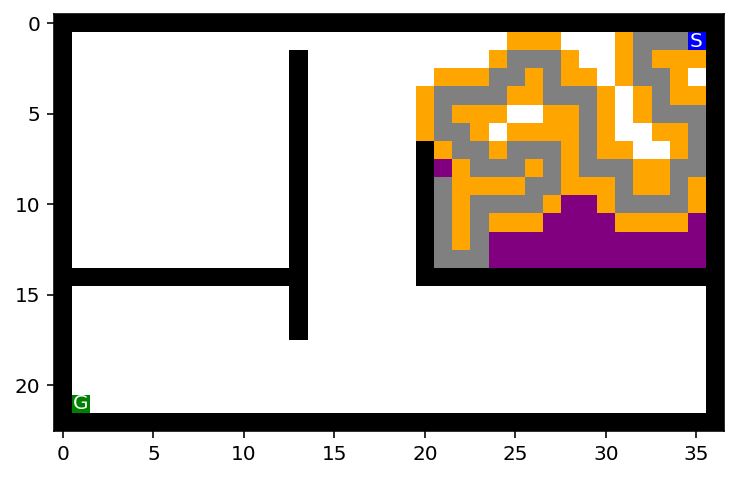

Node - pos = (9, 22); parent = <__main__.Node object at 0x7f100af16d90>; action = East; cost = 67


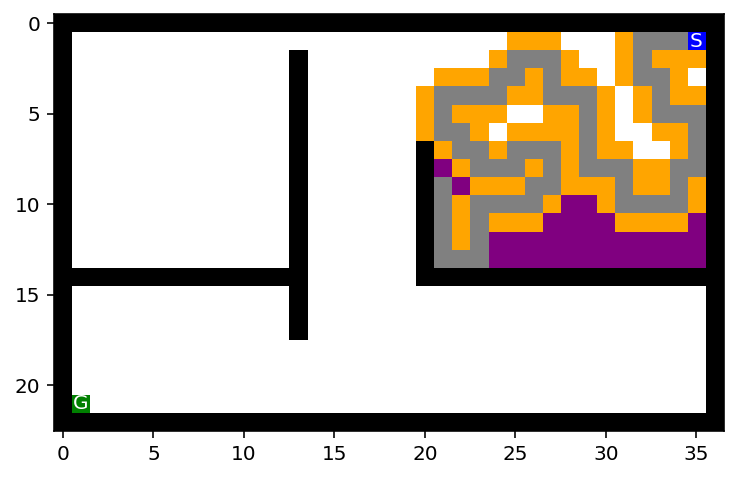

Node - pos = (9, 21); parent = <__main__.Node object at 0x7f100ad8d400>; action = North; cost = 66


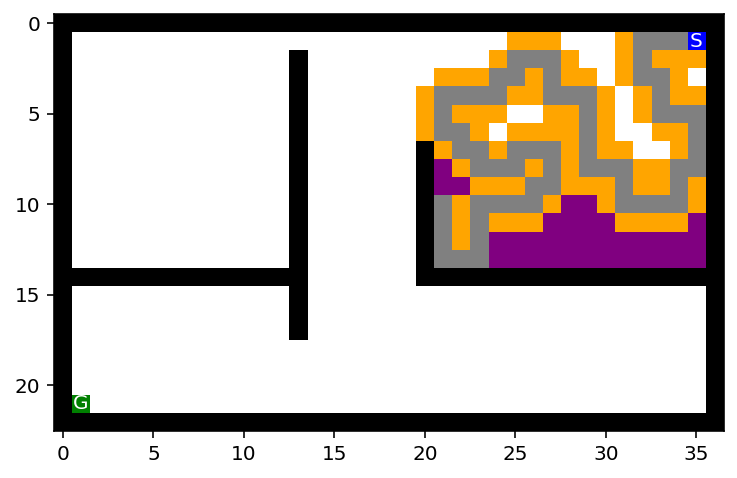

Node - pos = (10, 21); parent = <__main__.Node object at 0x7f100b1030a0>; action = North; cost = 65


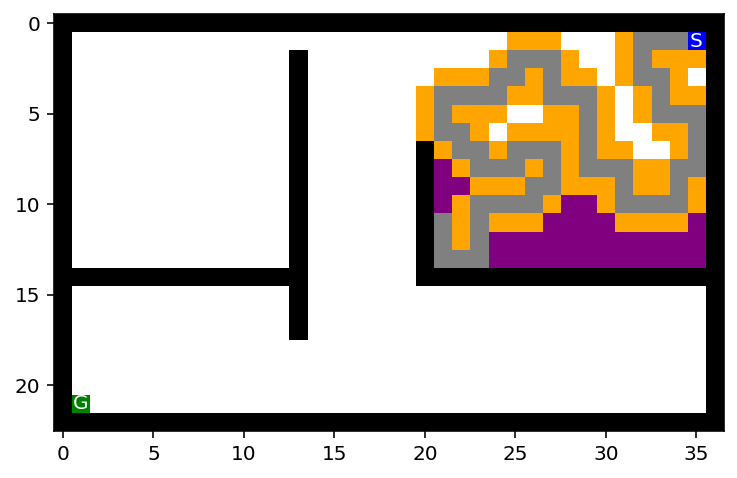

Node - pos = (11, 21); parent = <__main__.Node object at 0x7f100b00aee0>; action = North; cost = 64


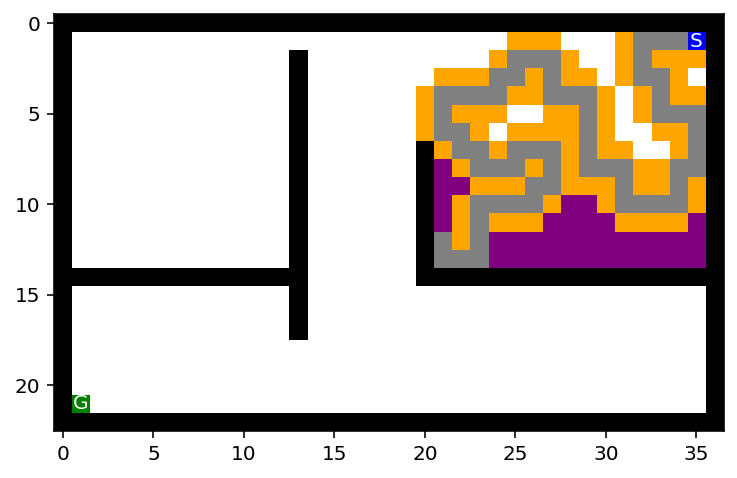

Node - pos = (12, 21); parent = <__main__.Node object at 0x7f100af5a4c0>; action = North; cost = 63


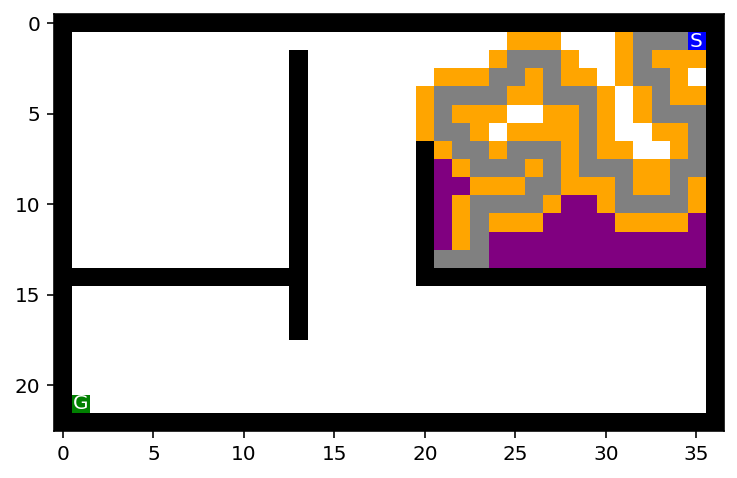

Node - pos = (13, 21); parent = <__main__.Node object at 0x7f100adc7430>; action = West; cost = 62


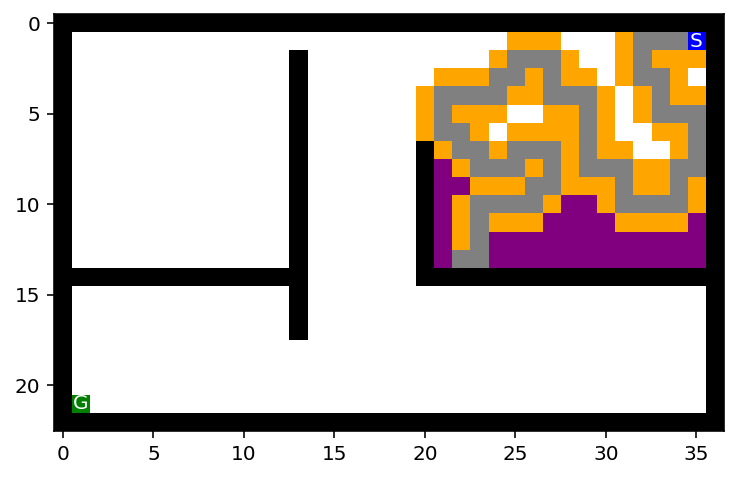

Node - pos = (13, 22); parent = <__main__.Node object at 0x7f100b0c2370>; action = West; cost = 61


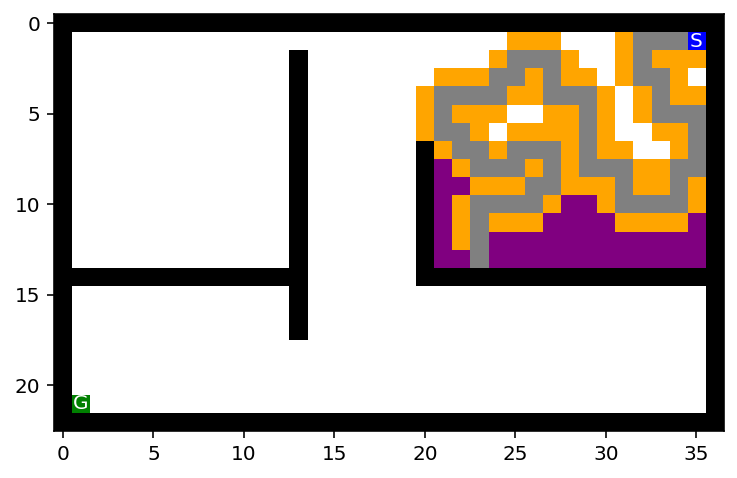

Node - pos = (13, 23); parent = <__main__.Node object at 0x7f100b15ea30>; action = South; cost = 60


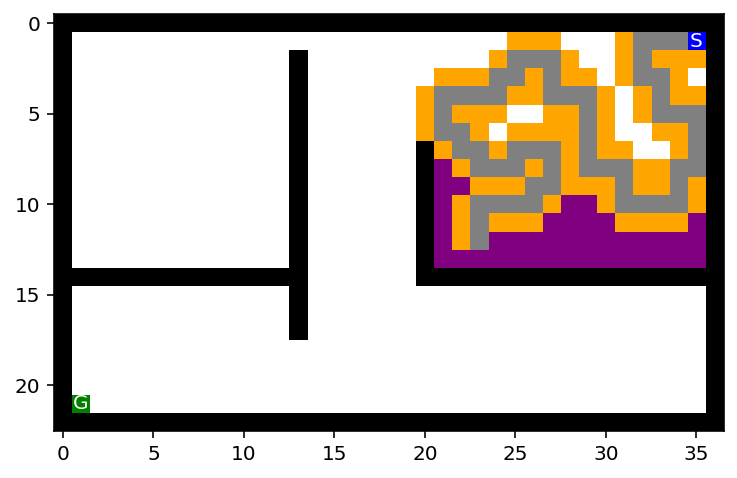

Node - pos = (12, 22); parent = <__main__.Node object at 0x7f100b15ea30>; action = West; cost = 60


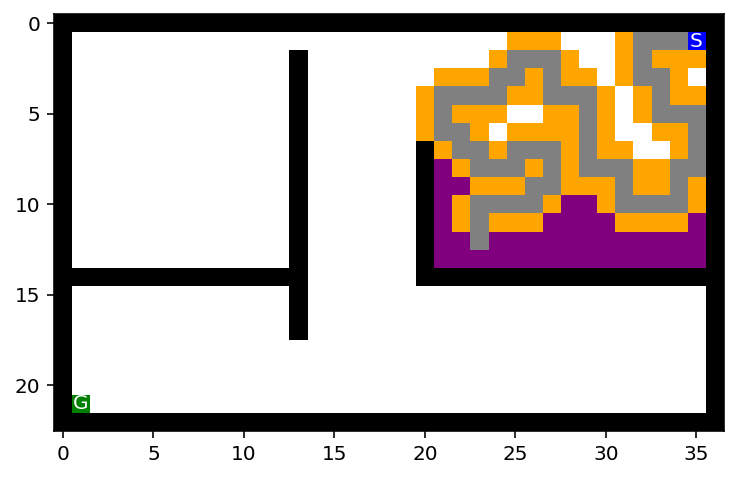

Node - pos = (12, 23); parent = <__main__.Node object at 0x7f100b103c40>; action = South; cost = 59


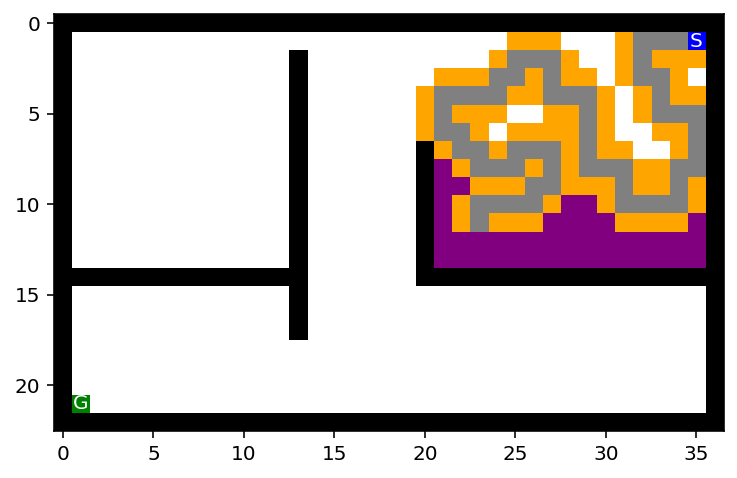

Node - pos = (11, 22); parent = <__main__.Node object at 0x7f100b103c40>; action = West; cost = 59


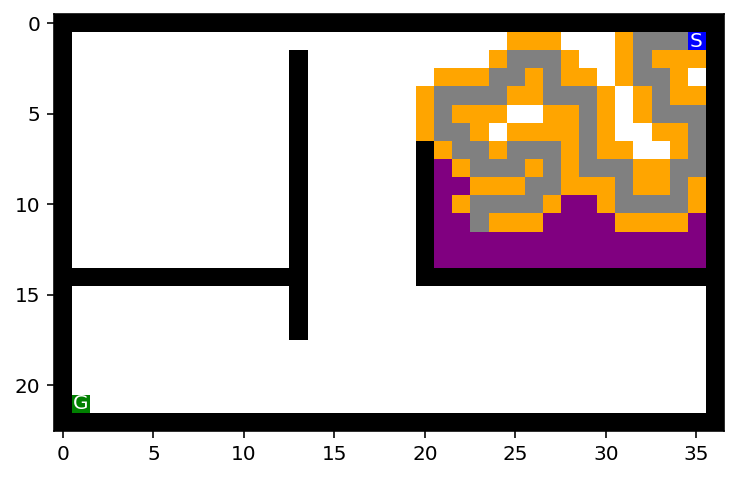

Node - pos = (11, 23); parent = <__main__.Node object at 0x7f100b18c580>; action = South; cost = 58


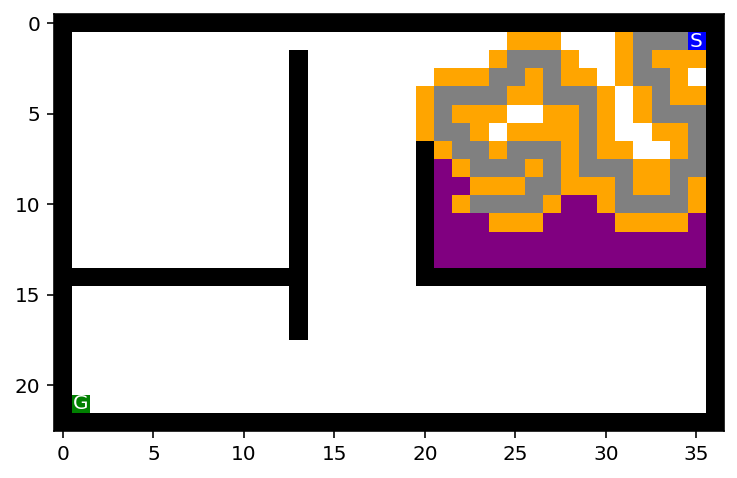

Node - pos = (10, 22); parent = <__main__.Node object at 0x7f100b18c580>; action = West; cost = 58


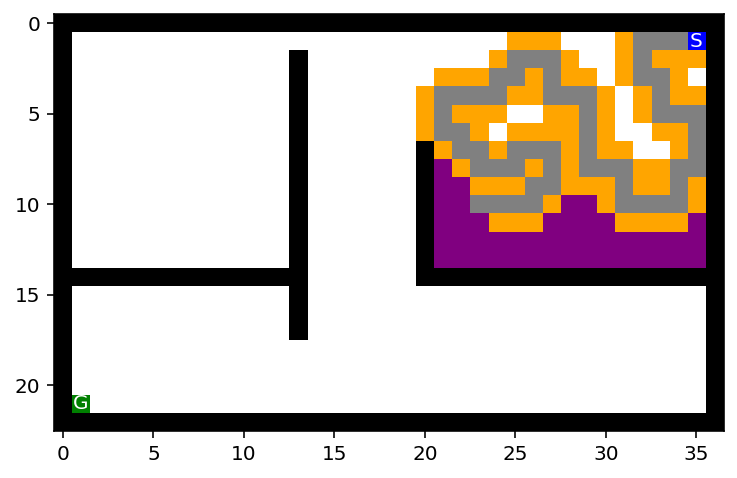

Node - pos = (10, 23); parent = <__main__.Node object at 0x7f100ad9f760>; action = West; cost = 57


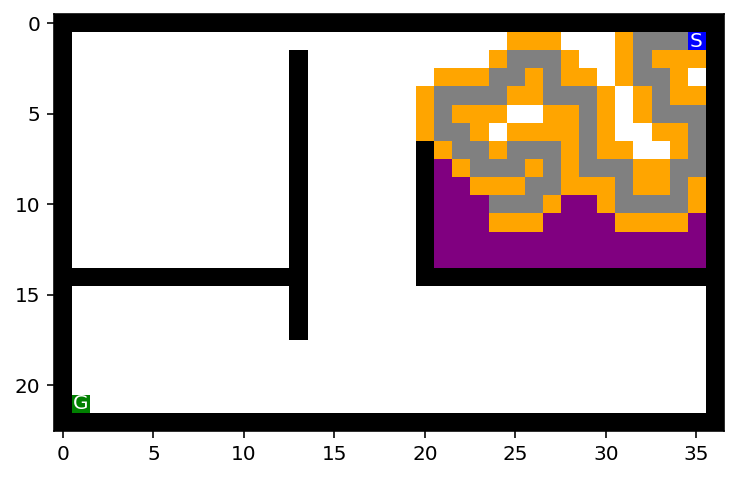

Node - pos = (11, 24); parent = <__main__.Node object at 0x7f100ad9f760>; action = South; cost = 57


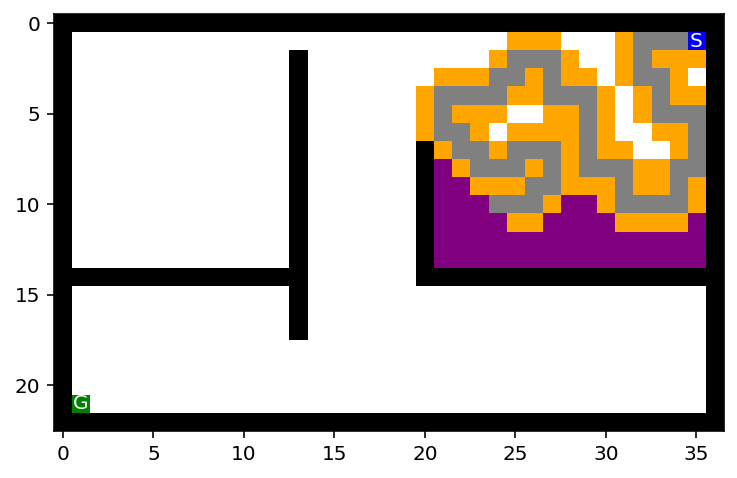

Node - pos = (10, 24); parent = <__main__.Node object at 0x7f100b0d4250>; action = West; cost = 56


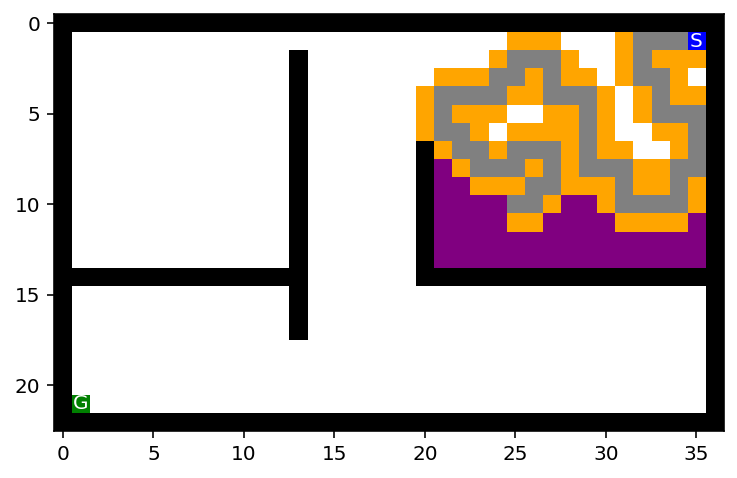

Node - pos = (11, 25); parent = <__main__.Node object at 0x7f100b0d4250>; action = South; cost = 56


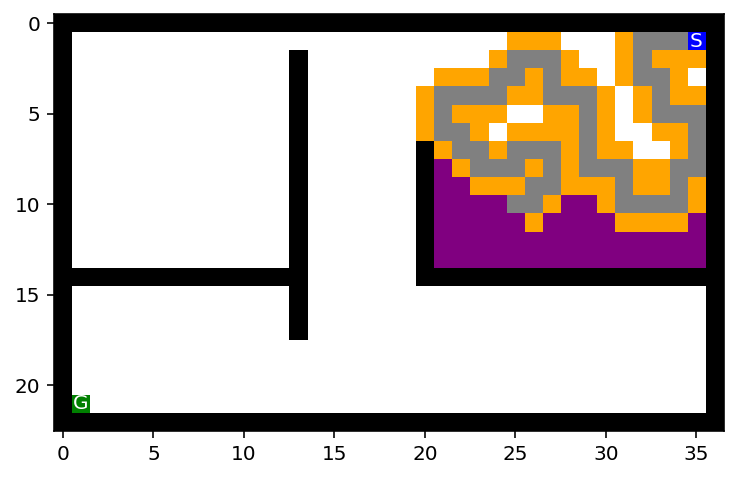

Node - pos = (10, 25); parent = <__main__.Node object at 0x7f100ad9fa30>; action = West; cost = 55


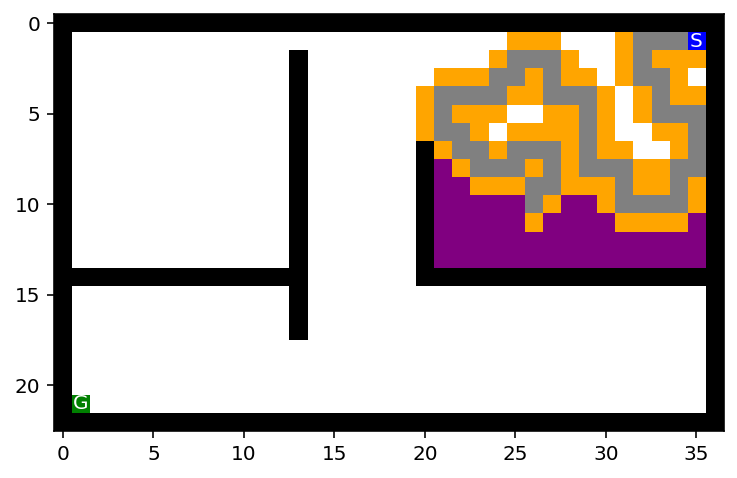

Node - pos = (11, 26); parent = <__main__.Node object at 0x7f100ad9fa30>; action = South; cost = 55


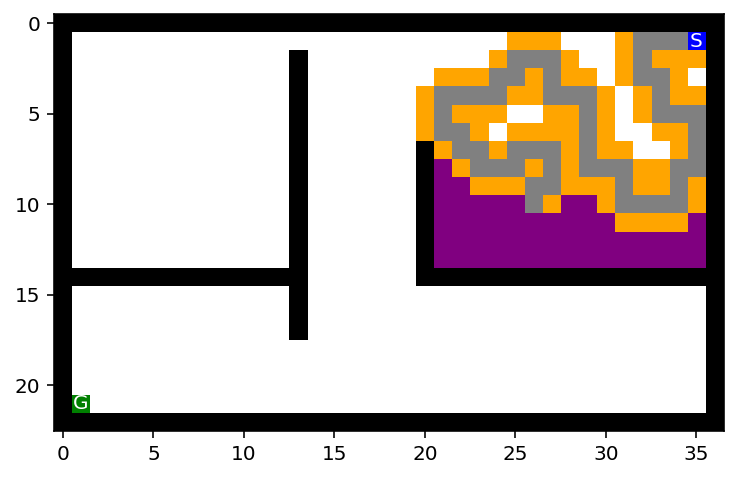

Node - pos = (10, 26); parent = <__main__.Node object at 0x7f100b103a90>; action = South; cost = 54


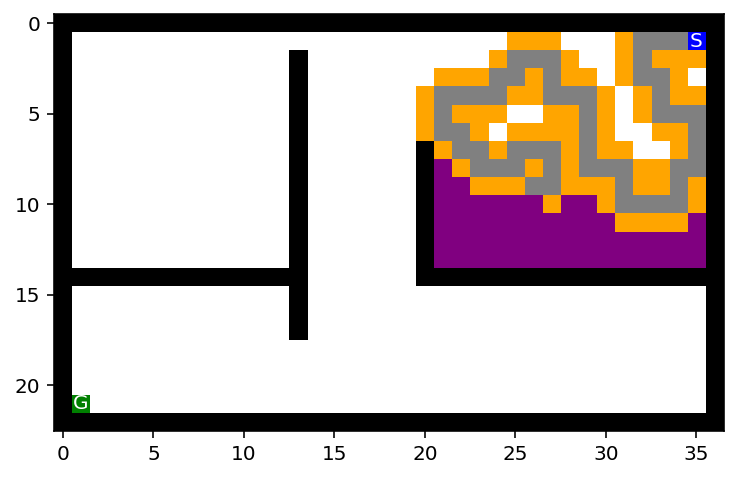

Node - pos = (9, 26); parent = <__main__.Node object at 0x7f100b135a00>; action = West; cost = 53


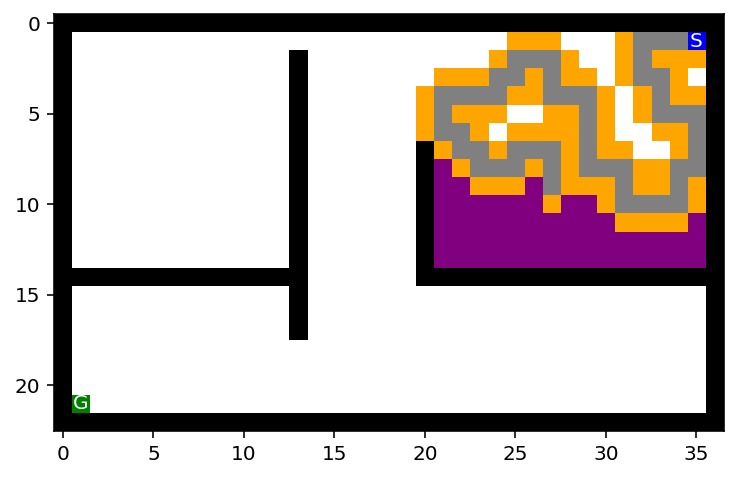

Node - pos = (10, 27); parent = <__main__.Node object at 0x7f100b135a00>; action = South; cost = 53


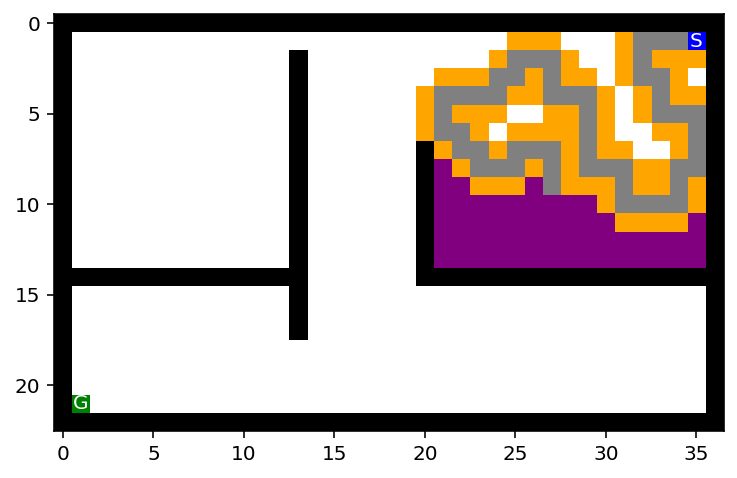

Node - pos = (9, 28); parent = <__main__.Node object at 0x7f100b135a00>; action = East; cost = 53


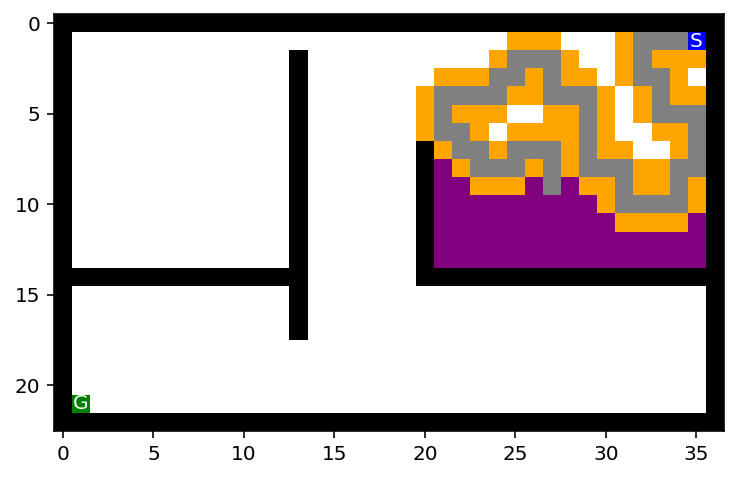

Node - pos = (9, 27); parent = <__main__.Node object at 0x7f100ae98970>; action = South; cost = 52


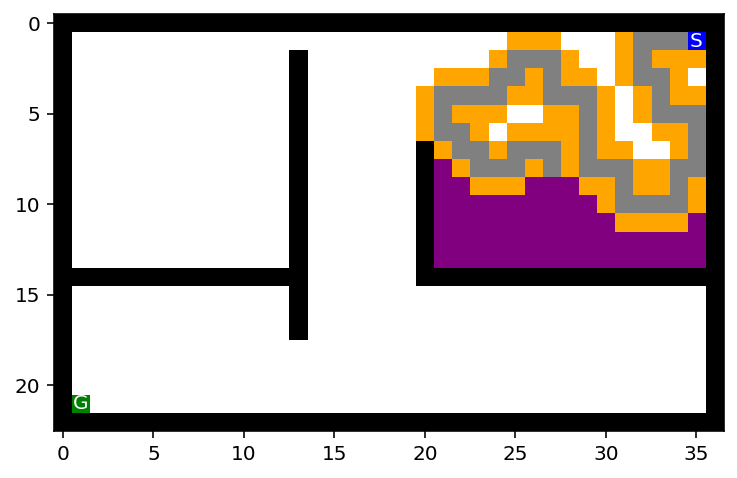

Node - pos = (8, 27); parent = <__main__.Node object at 0x7f100b221880>; action = South; cost = 51


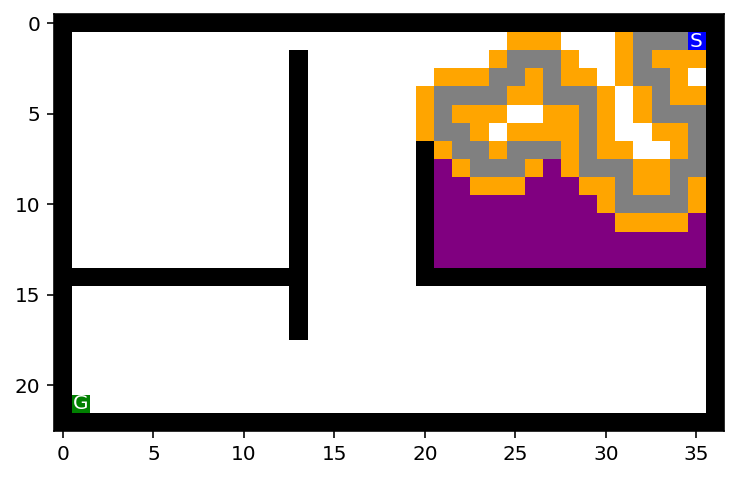

Node - pos = (6, 27); parent = <__main__.Node object at 0x7f100b221880>; action = North; cost = 51


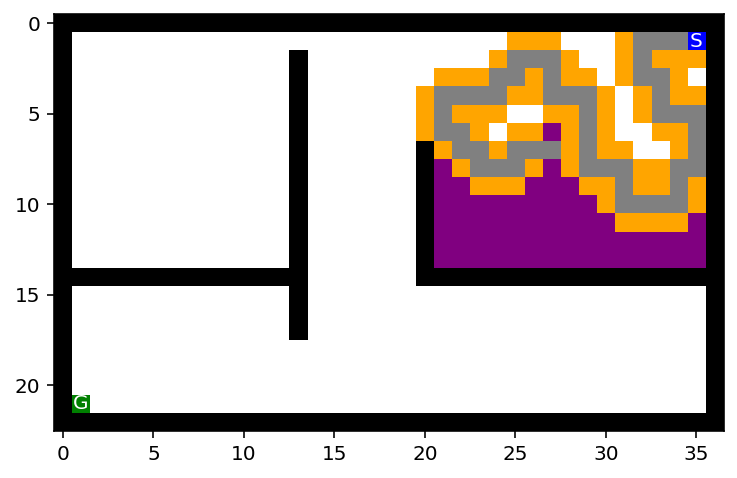

Node - pos = (7, 27); parent = <__main__.Node object at 0x7f100b242af0>; action = East; cost = 50


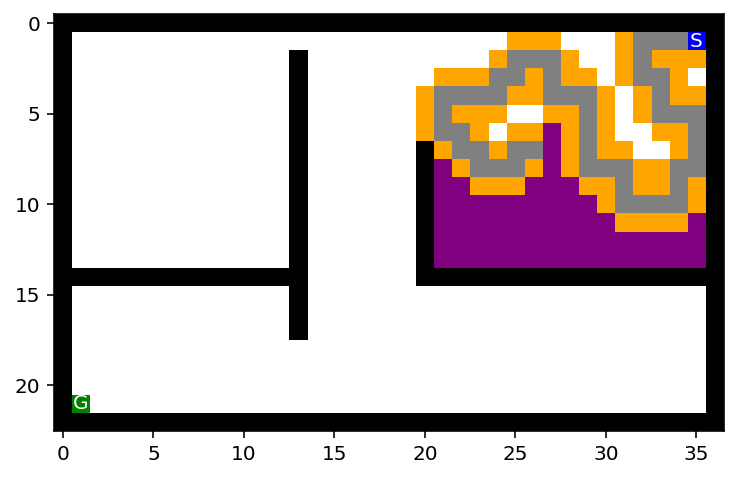

Node - pos = (6, 26); parent = <__main__.Node object at 0x7f100b242af0>; action = North; cost = 50


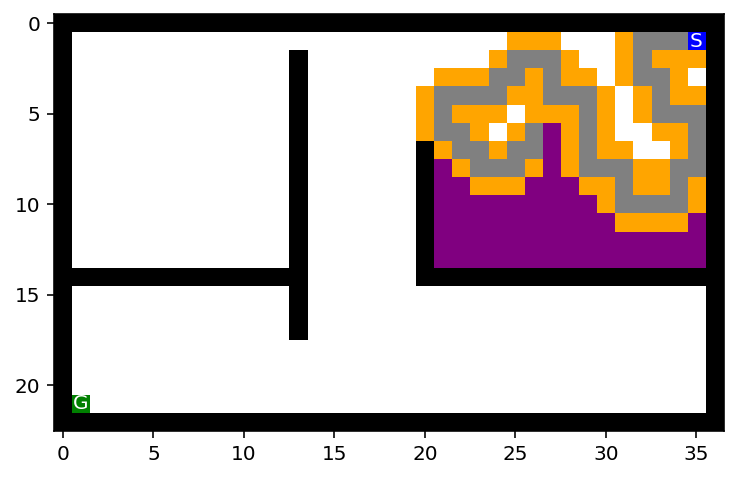

Node - pos = (5, 26); parent = <__main__.Node object at 0x7f100af22b80>; action = North; cost = 51


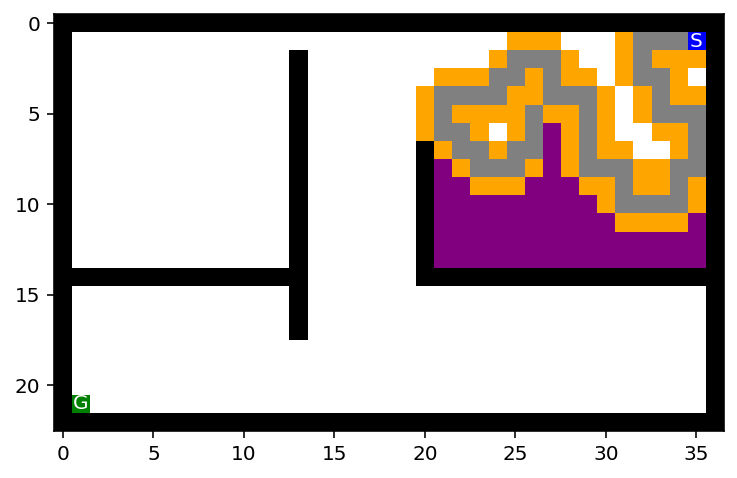

Node - pos = (5, 25); parent = <__main__.Node object at 0x7f100ad600a0>; action = West; cost = 52


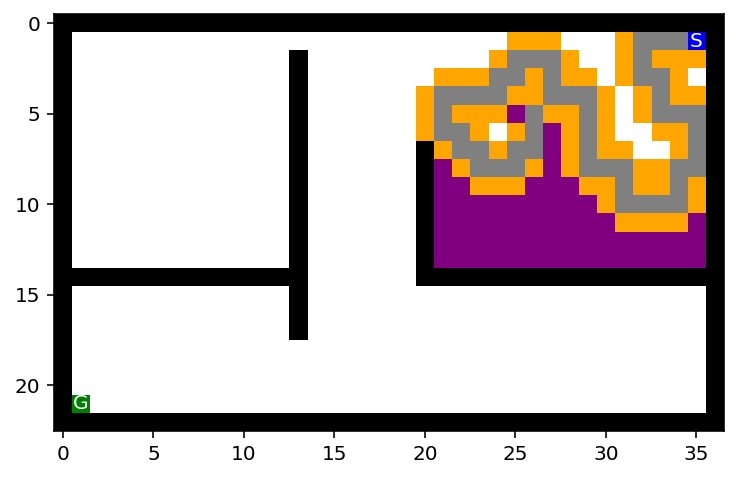

Node - pos = (5, 26); parent = <__main__.Node object at 0x7f100af22b80>; action = North; cost = 51


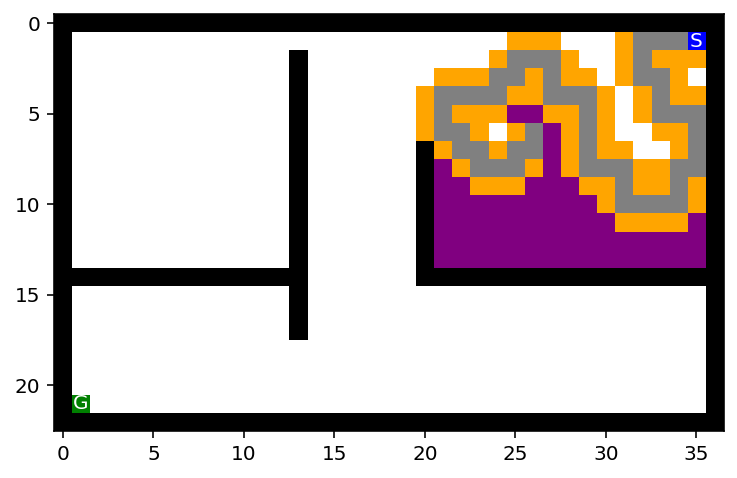

Node - pos = (6, 26); parent = <__main__.Node object at 0x7f100b242af0>; action = North; cost = 50


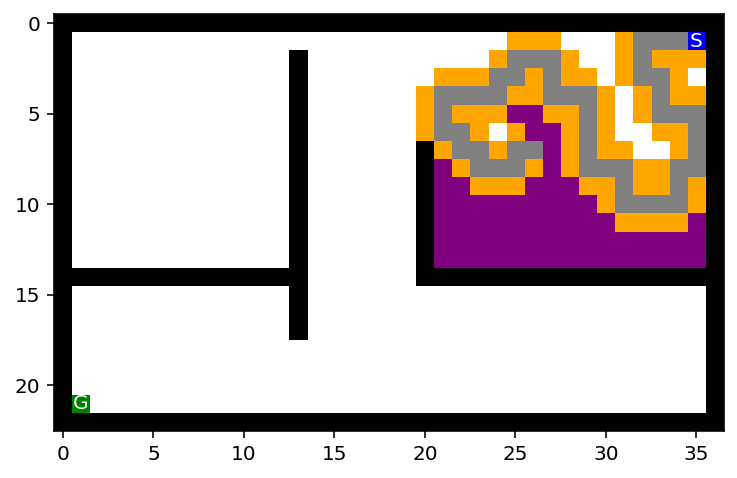

Node - pos = (7, 26); parent = <__main__.Node object at 0x7f100b056d00>; action = East; cost = 49


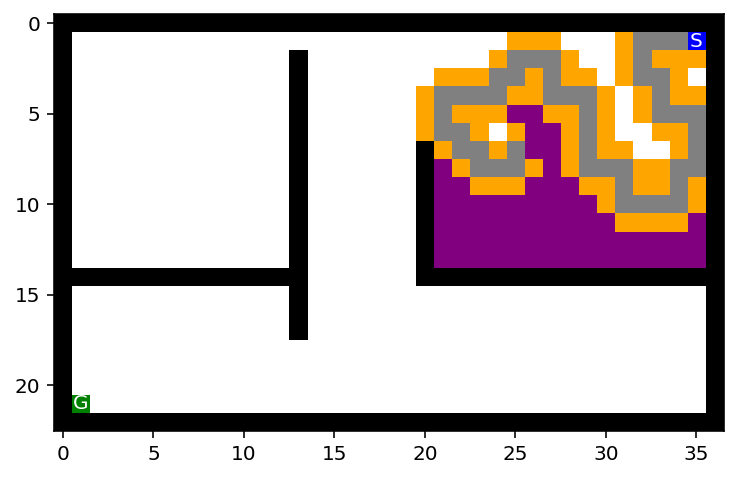

Node - pos = (6, 25); parent = <__main__.Node object at 0x7f100b056d00>; action = North; cost = 49


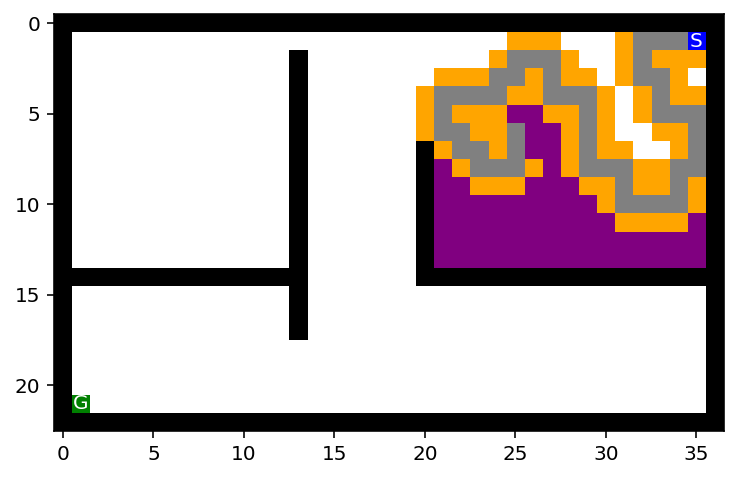

Node - pos = (6, 24); parent = <__main__.Node object at 0x7f100b2424c0>; action = West; cost = 50


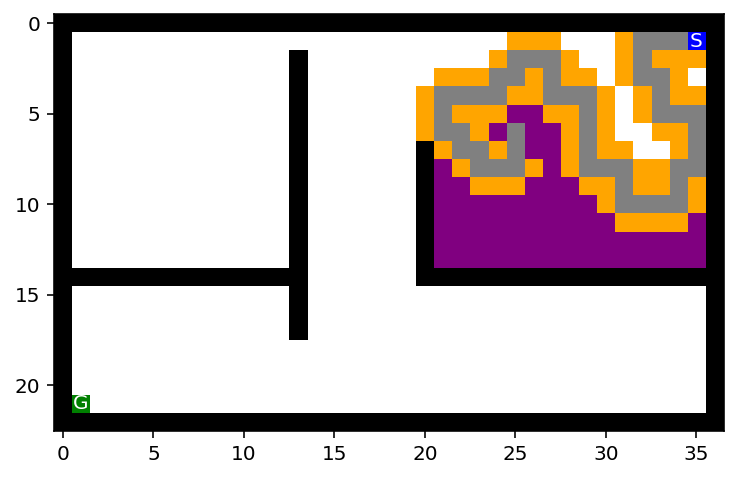

Node - pos = (6, 25); parent = <__main__.Node object at 0x7f100b056d00>; action = North; cost = 49


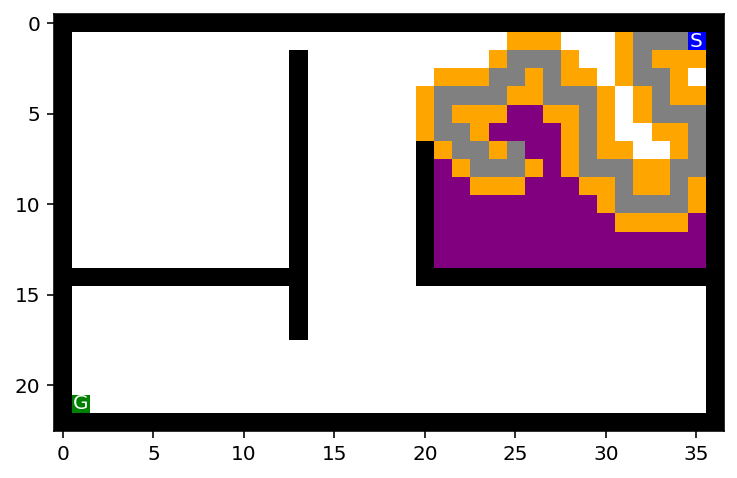

Node - pos = (7, 25); parent = <__main__.Node object at 0x7f100ae58190>; action = North; cost = 48


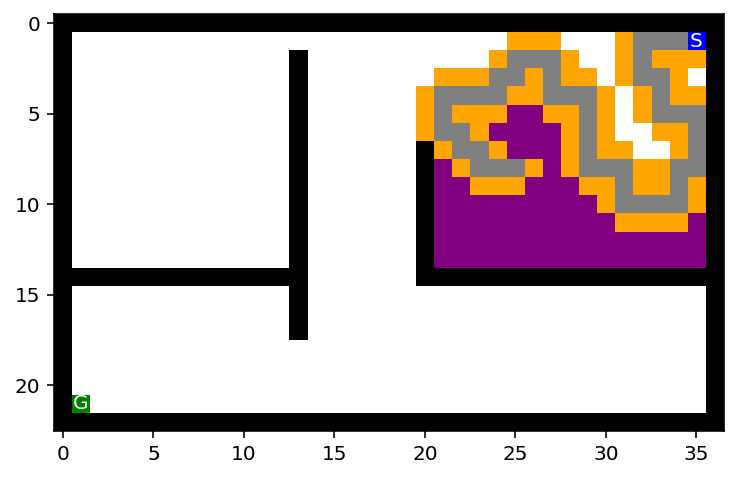

Node - pos = (8, 26); parent = <__main__.Node object at 0x7f100ae58190>; action = East; cost = 48


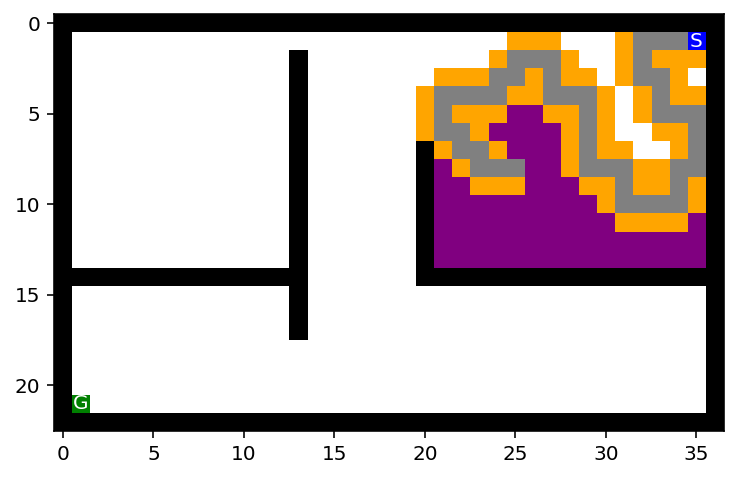

Node - pos = (9, 25); parent = <__main__.Node object at 0x7f100ae58190>; action = South; cost = 48


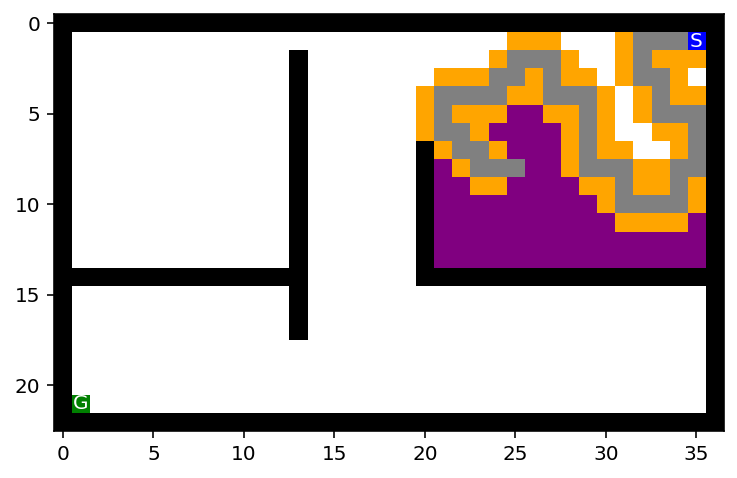

Node - pos = (8, 25); parent = <__main__.Node object at 0x7f100b00a7f0>; action = East; cost = 47


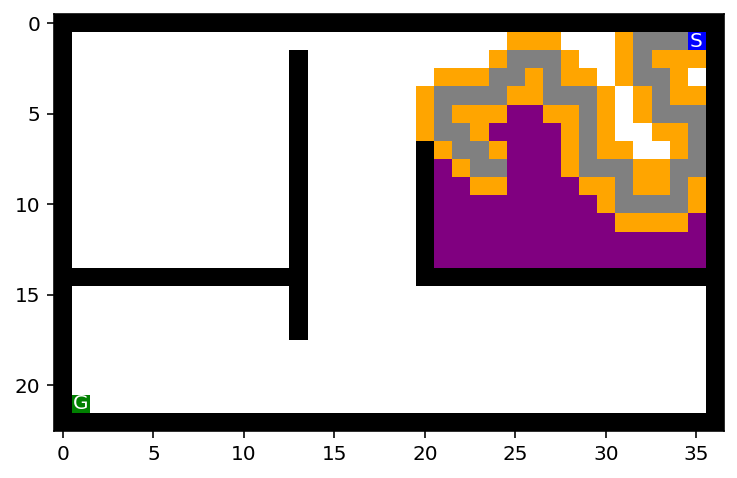

Node - pos = (9, 24); parent = <__main__.Node object at 0x7f100b00a7f0>; action = South; cost = 47


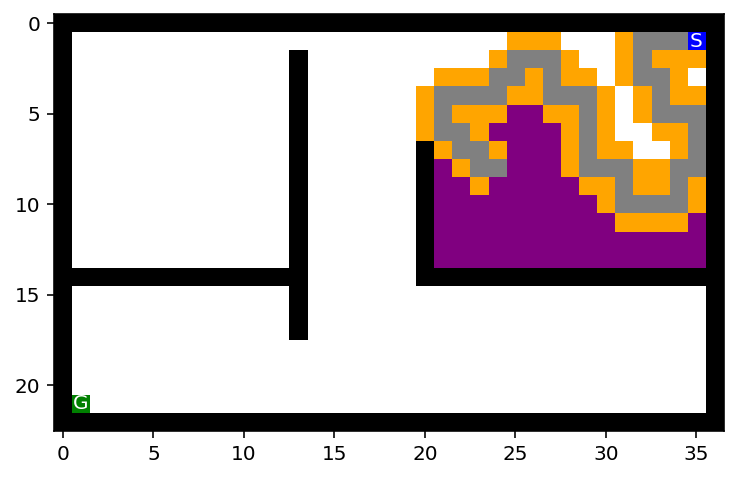

Node - pos = (8, 24); parent = <__main__.Node object at 0x7f100ae5d790>; action = East; cost = 46


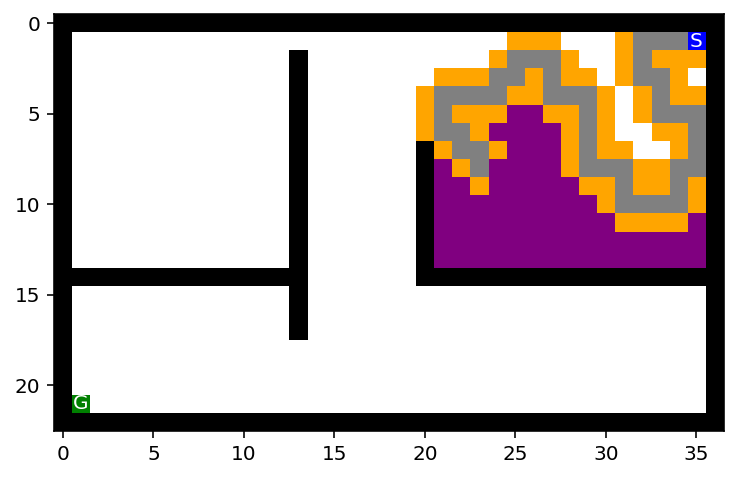

Node - pos = (9, 23); parent = <__main__.Node object at 0x7f100ae5d790>; action = South; cost = 46


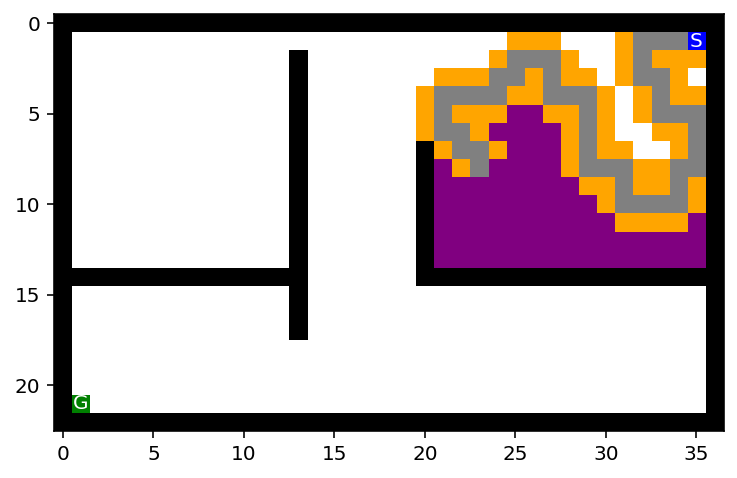

Node - pos = (8, 23); parent = <__main__.Node object at 0x7f100ae9a640>; action = South; cost = 45


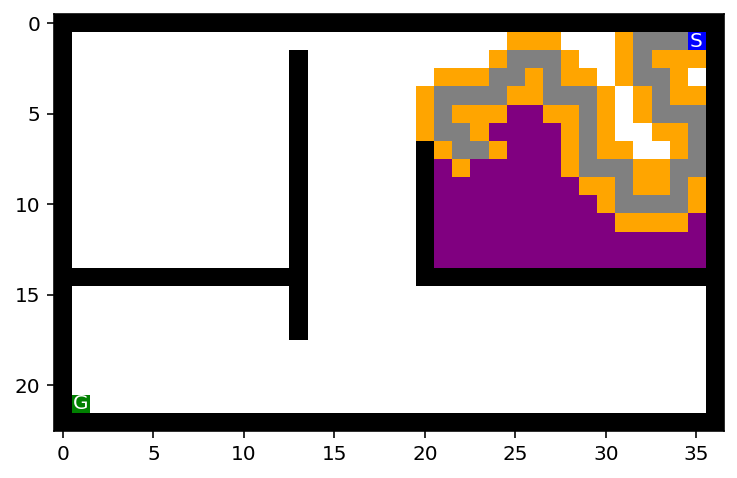

Node - pos = (7, 24); parent = <__main__.Node object at 0x7f100ae9a640>; action = East; cost = 45


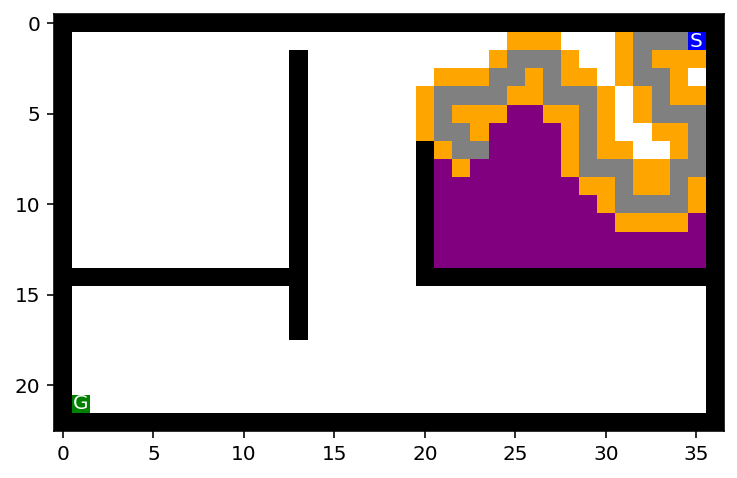

Node - pos = (7, 23); parent = <__main__.Node object at 0x7f100b1a7940>; action = East; cost = 44


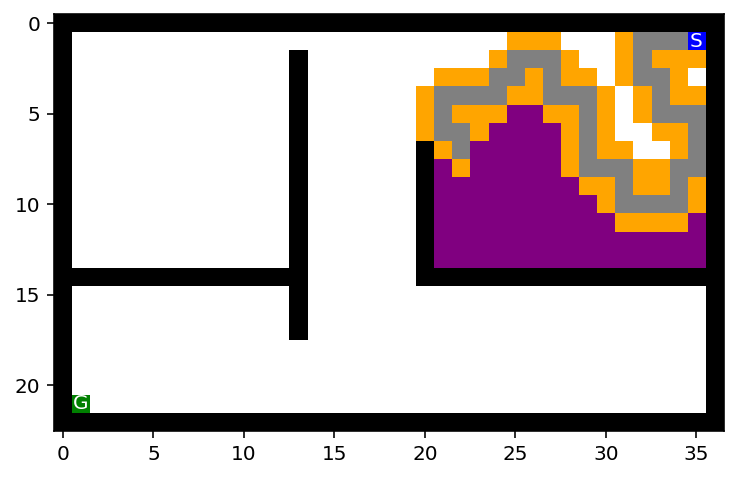

Node - pos = (8, 22); parent = <__main__.Node object at 0x7f100b1a7940>; action = South; cost = 44


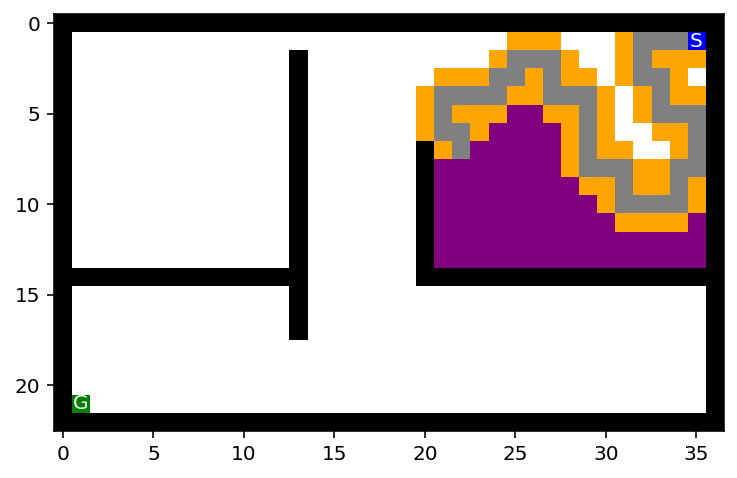

Node - pos = (7, 22); parent = <__main__.Node object at 0x7f100b14ac10>; action = South; cost = 43


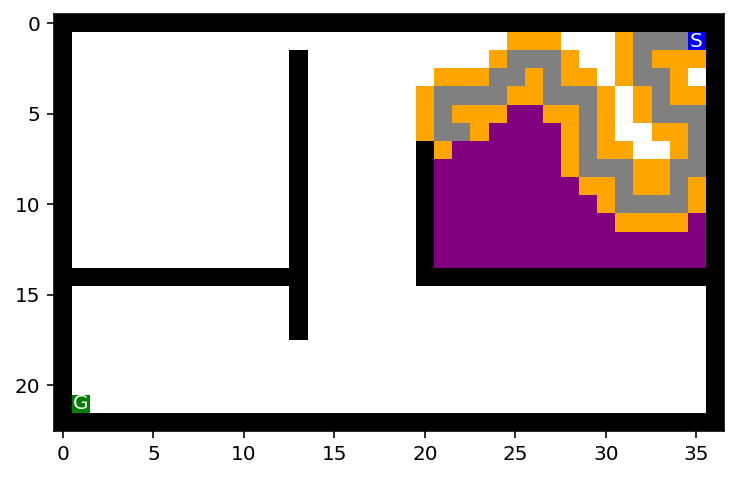

Node - pos = (6, 23); parent = <__main__.Node object at 0x7f100b14ac10>; action = East; cost = 43


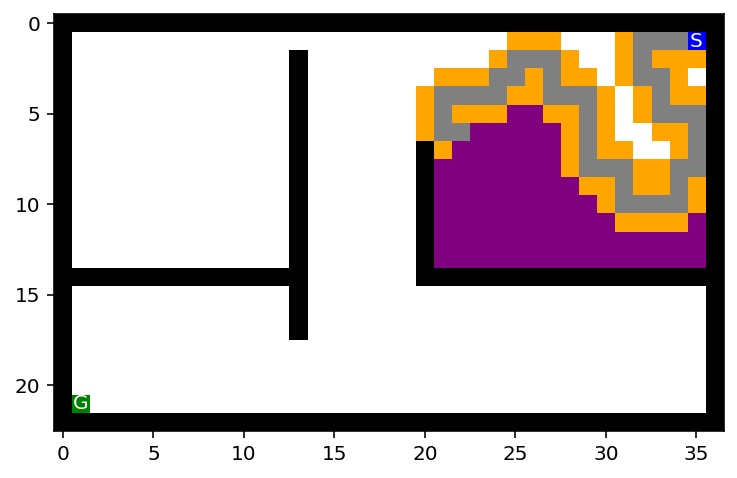

Node - pos = (6, 22); parent = <__main__.Node object at 0x7f100af7e370>; action = East; cost = 42


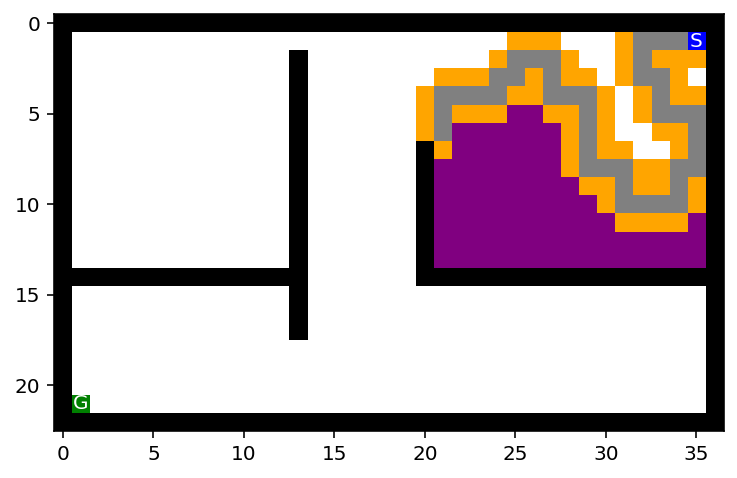

Node - pos = (6, 20); parent = <__main__.Node object at 0x7f100af7e370>; action = West; cost = 42


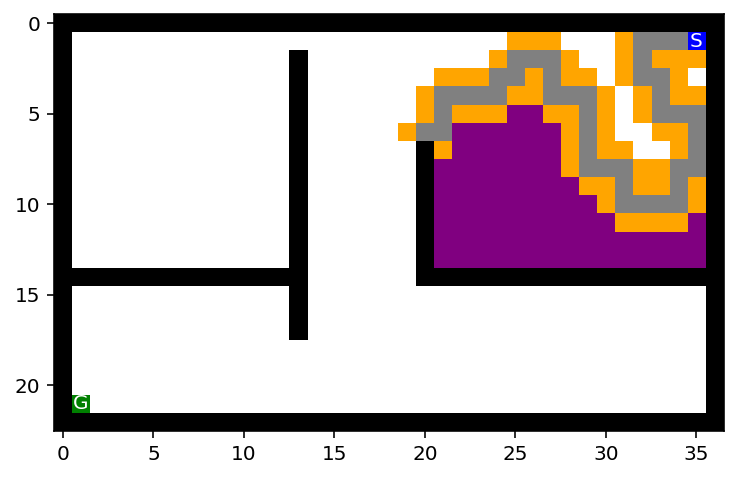

Node - pos = (6, 19); parent = <__main__.Node object at 0x7f100b14ab20>; action = West; cost = 43


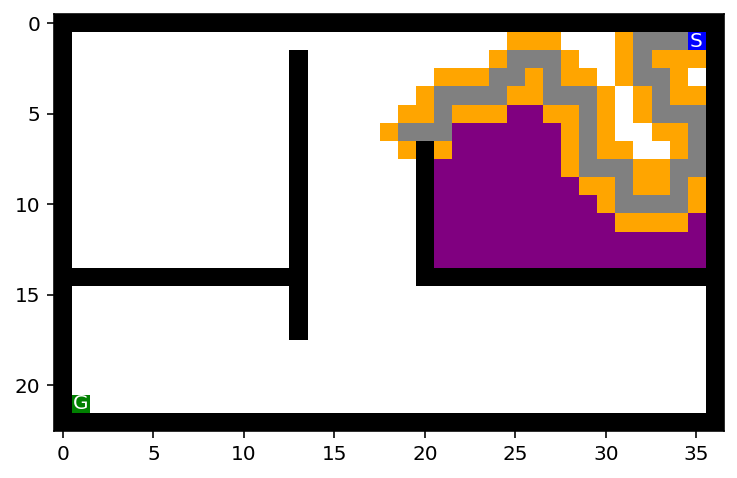

Node - pos = (5, 19); parent = <__main__.Node object at 0x7f100b095d30>; action = North; cost = 44


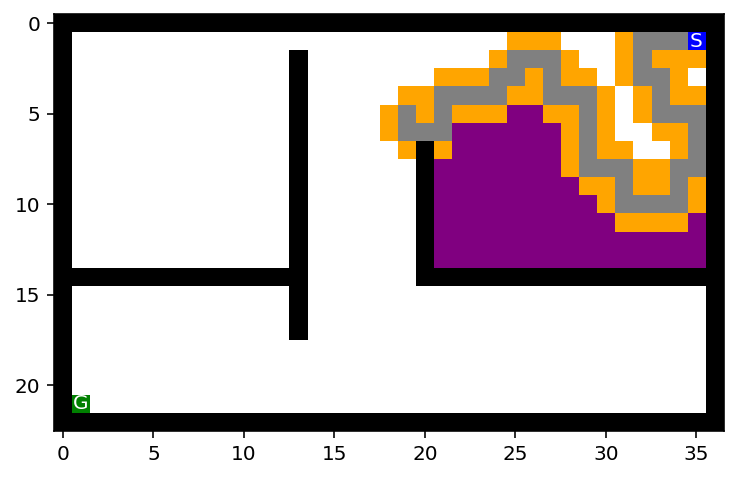

Node - pos = (4, 19); parent = <__main__.Node object at 0x7f100b06efd0>; action = North; cost = 45


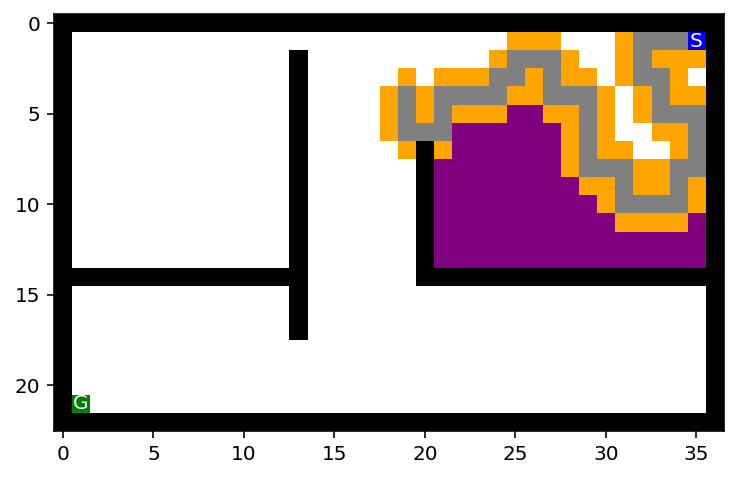

Node - pos = (4, 18); parent = <__main__.Node object at 0x7f100b0693d0>; action = West; cost = 46


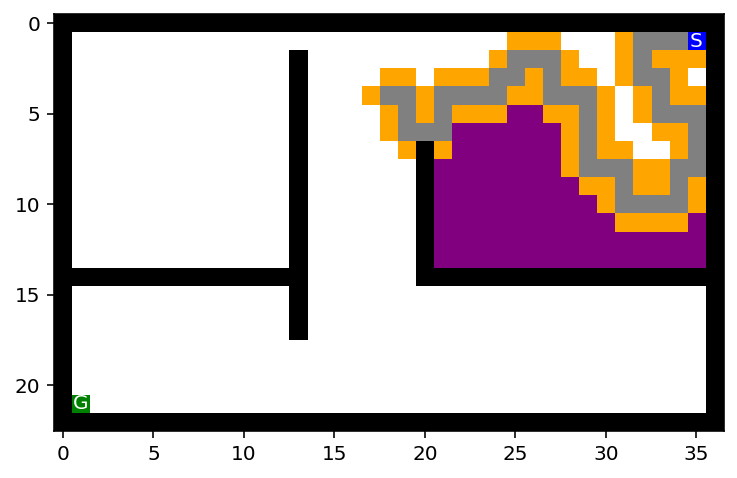

Node - pos = (4, 17); parent = <__main__.Node object at 0x7f100b0ac640>; action = West; cost = 47


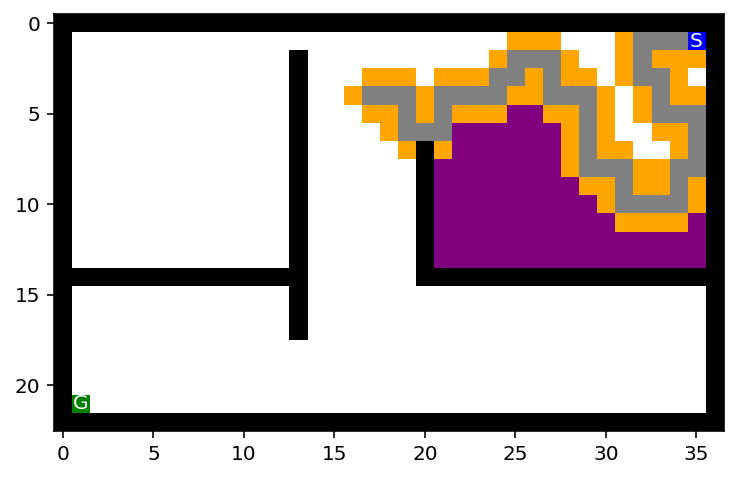

Node - pos = (3, 17); parent = <__main__.Node object at 0x7f100b1b2250>; action = North; cost = 48


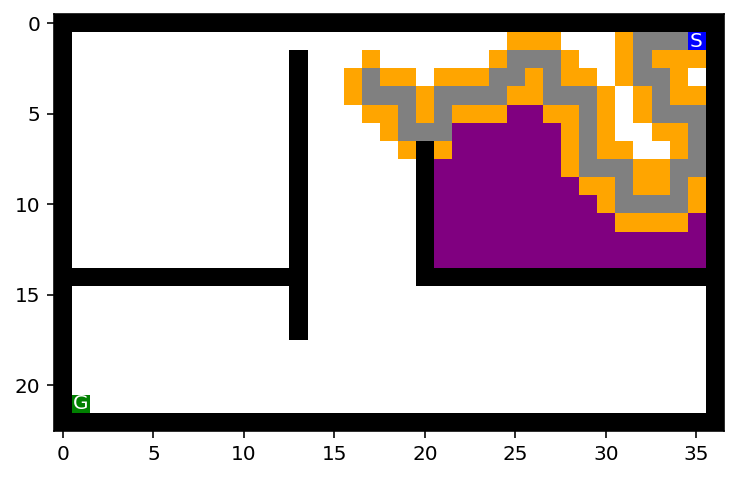

Node - pos = (3, 16); parent = <__main__.Node object at 0x7f100b101730>; action = West; cost = 49


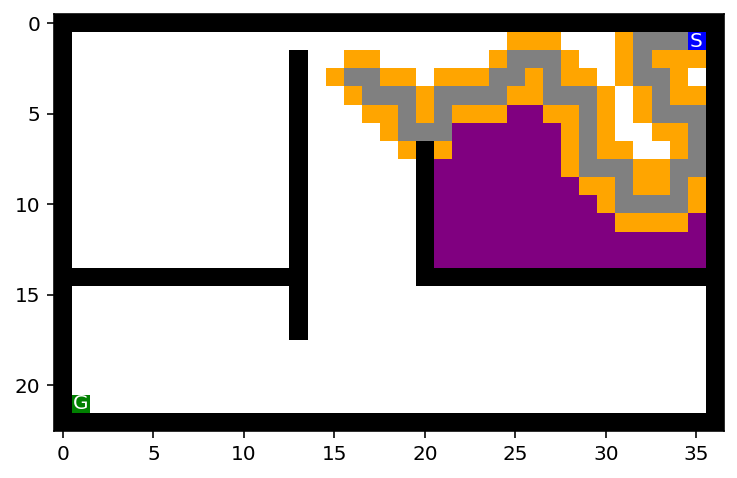

Node - pos = (2, 16); parent = <__main__.Node object at 0x7f100b0b0fd0>; action = North; cost = 50


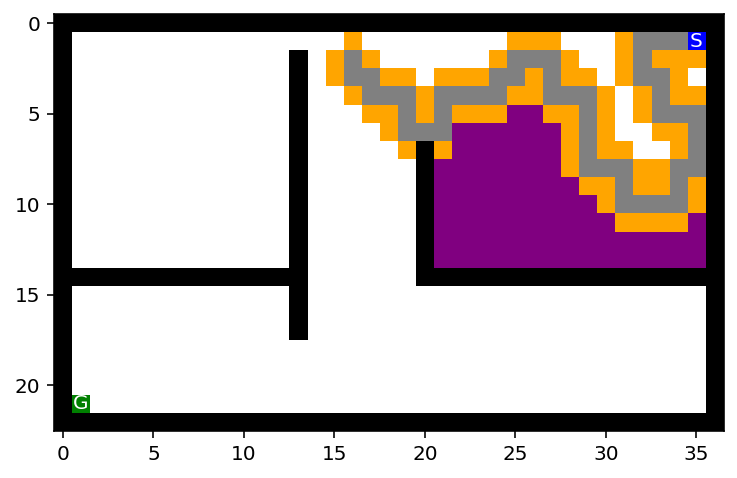

Node - pos = (1, 16); parent = <__main__.Node object at 0x7f100b278520>; action = North; cost = 51


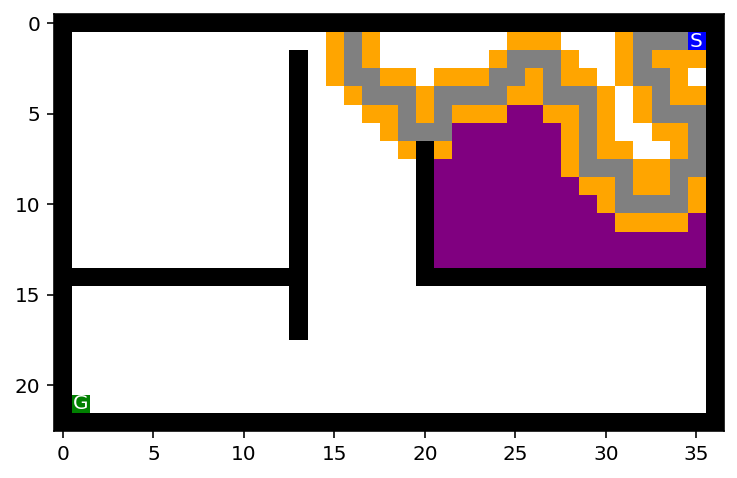

Node - pos = (1, 17); parent = <__main__.Node object at 0x7f100b135550>; action = East; cost = 52


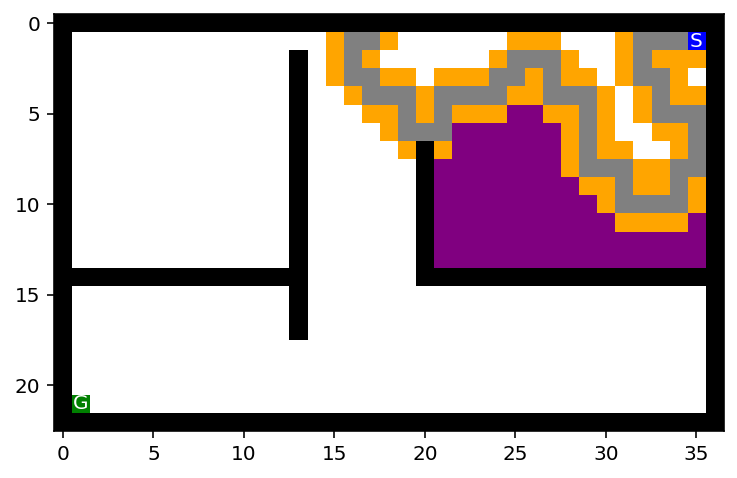

Node - pos = (1, 18); parent = <__main__.Node object at 0x7f100b01d4f0>; action = East; cost = 53


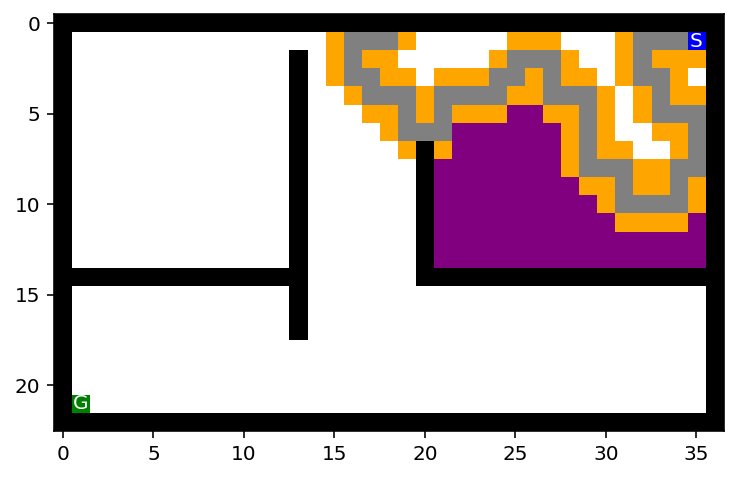

Node - pos = (1, 19); parent = <__main__.Node object at 0x7f100b0942b0>; action = East; cost = 54


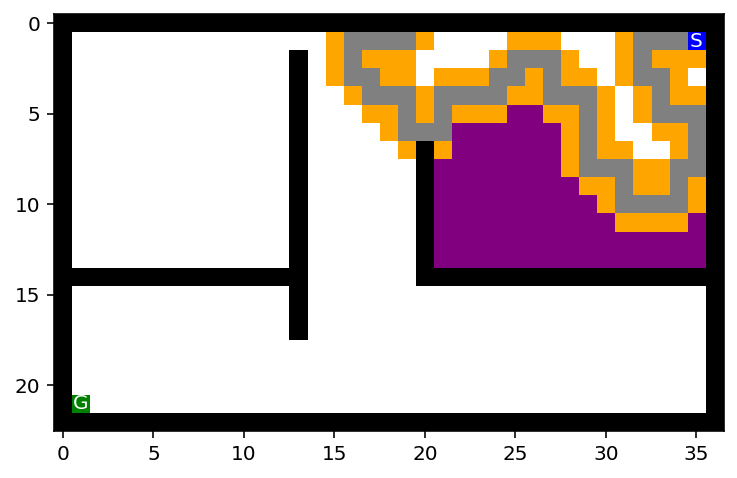

Node - pos = (2, 19); parent = <__main__.Node object at 0x7f100ae07bb0>; action = South; cost = 55


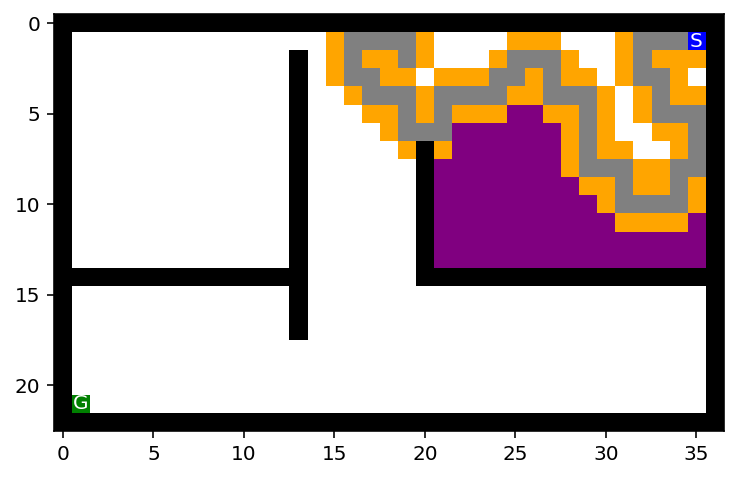

Node - pos = (2, 20); parent = <__main__.Node object at 0x7f100af1c370>; action = East; cost = 56


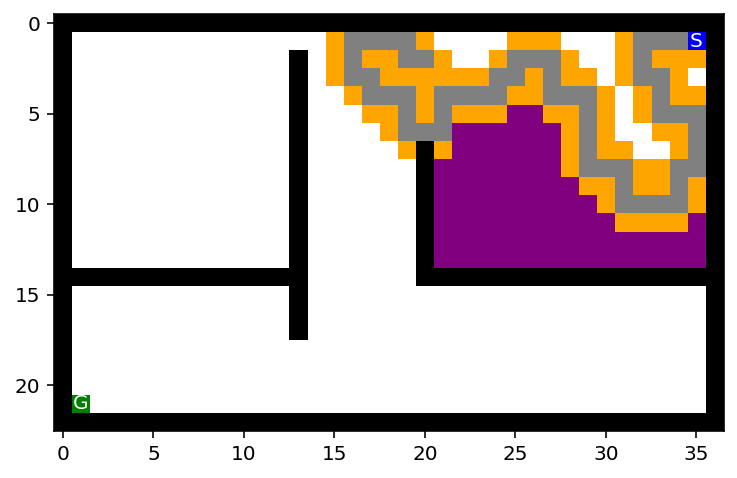

Node - pos = (3, 20); parent = <__main__.Node object at 0x7f100b1aec70>; action = South; cost = 57


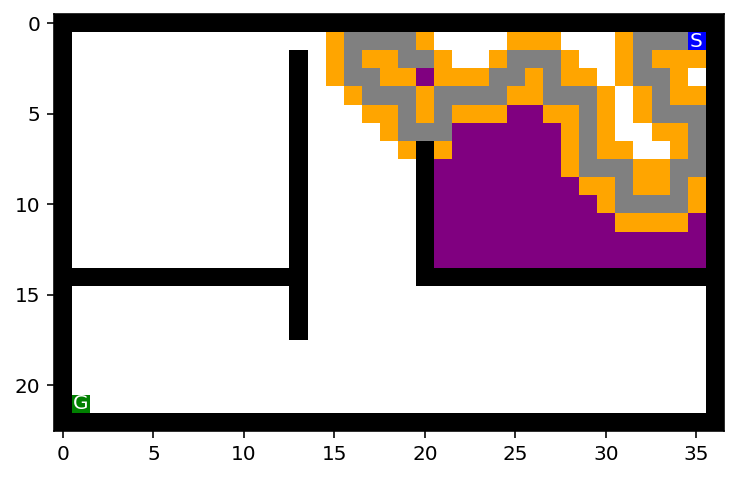

Node - pos = (2, 21); parent = <__main__.Node object at 0x7f100b1aec70>; action = East; cost = 57


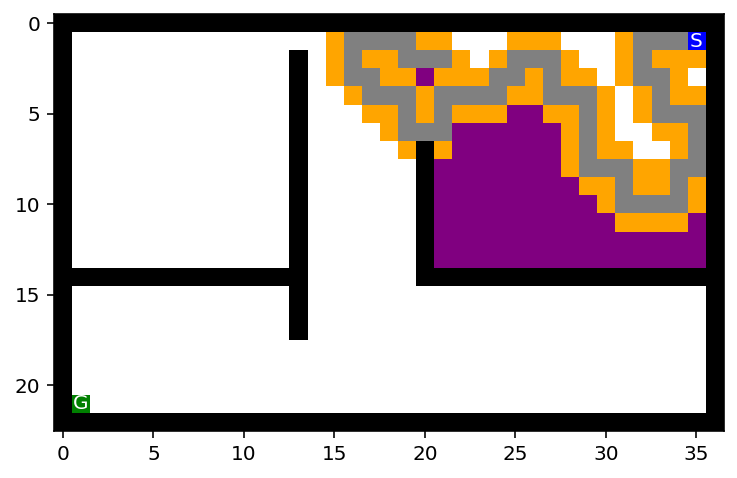

Node - pos = (2, 22); parent = <__main__.Node object at 0x7f100b00ce20>; action = East; cost = 58


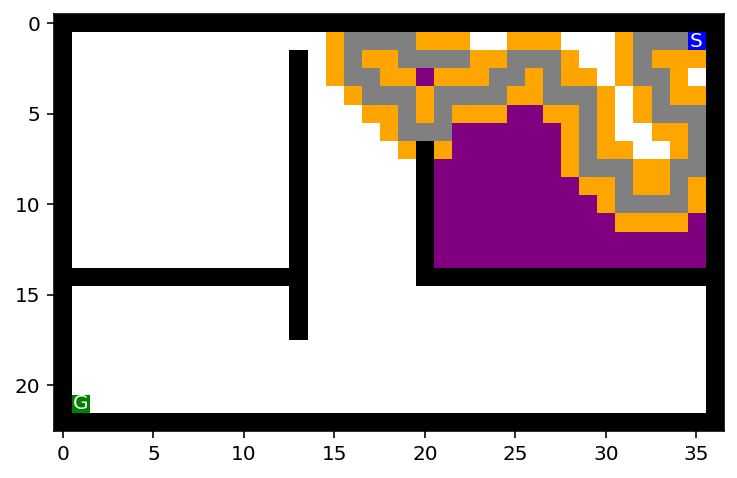

Node - pos = (1, 22); parent = <__main__.Node object at 0x7f100b0cf790>; action = North; cost = 59


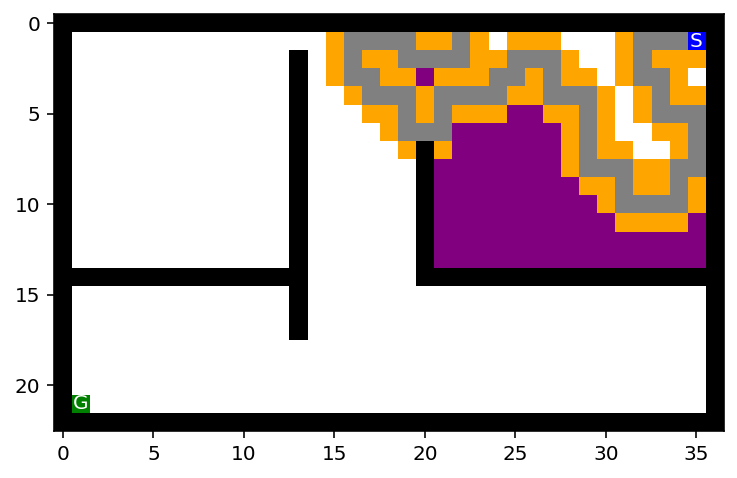

Node - pos = (1, 23); parent = <__main__.Node object at 0x7f100ae3aa30>; action = East; cost = 60


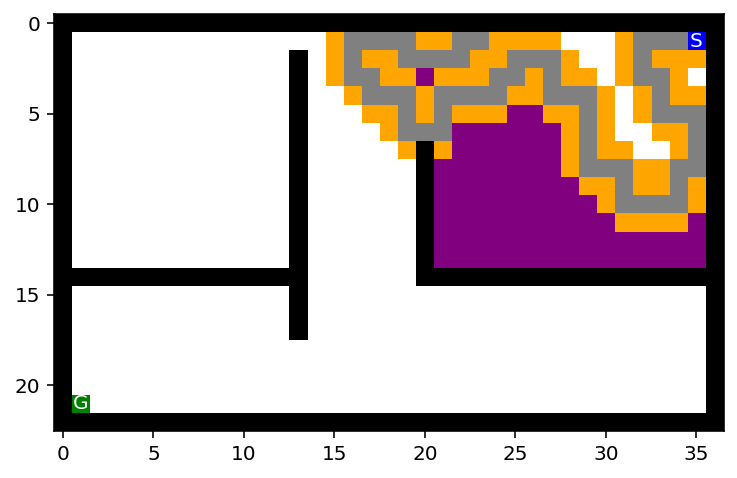

Node - pos = (1, 24); parent = <__main__.Node object at 0x7f100af1f310>; action = East; cost = 61


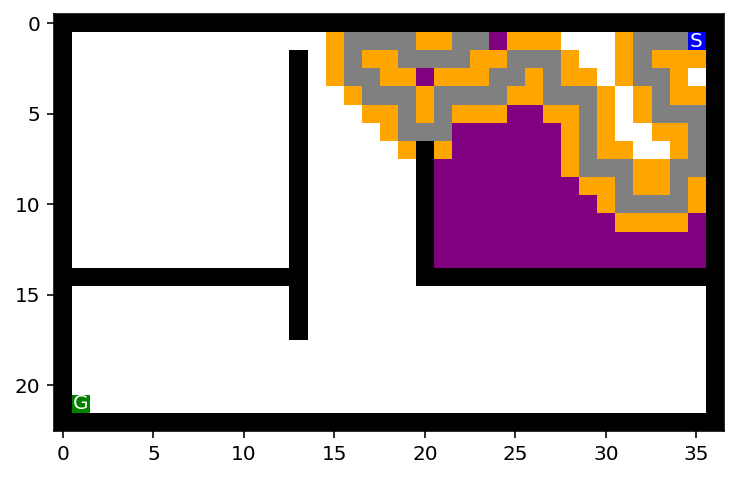

Node - pos = (1, 23); parent = <__main__.Node object at 0x7f100ae3aa30>; action = East; cost = 60


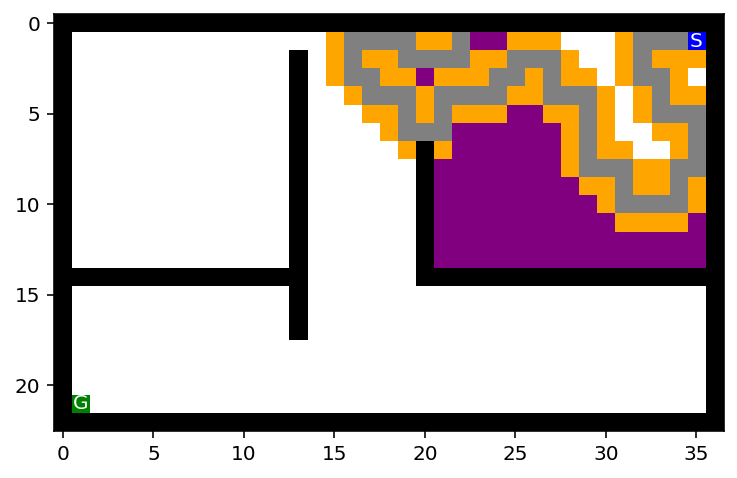

Node - pos = (1, 22); parent = <__main__.Node object at 0x7f100b0cf790>; action = North; cost = 59


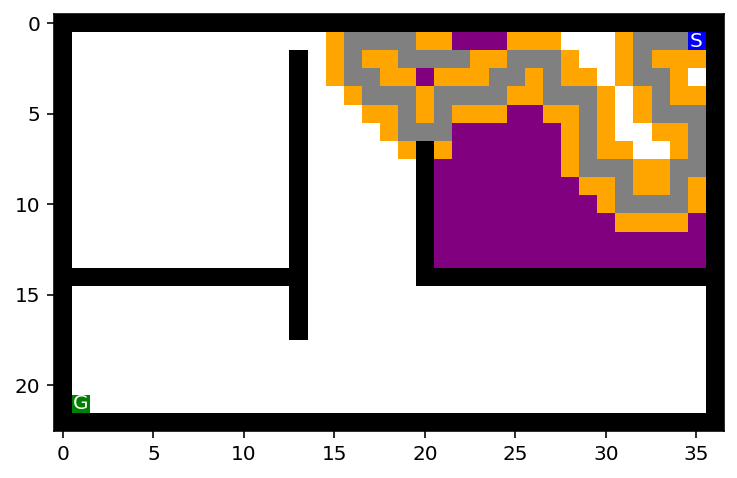

Node - pos = (2, 23); parent = <__main__.Node object at 0x7f100b0cf790>; action = East; cost = 59


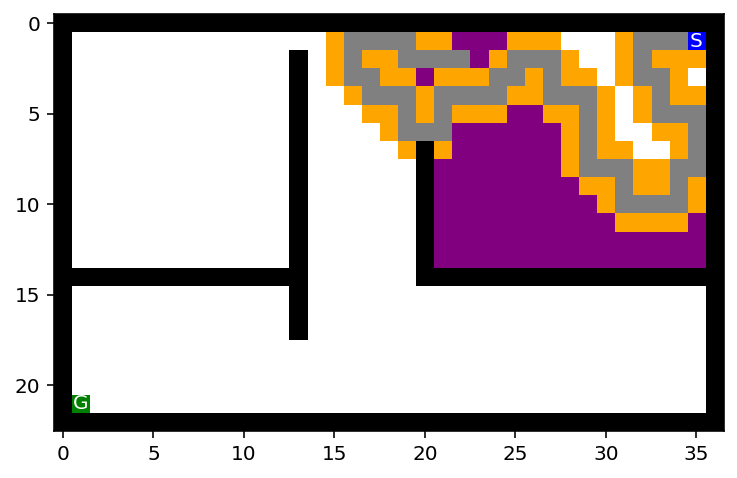

Node - pos = (2, 22); parent = <__main__.Node object at 0x7f100b00ce20>; action = East; cost = 58


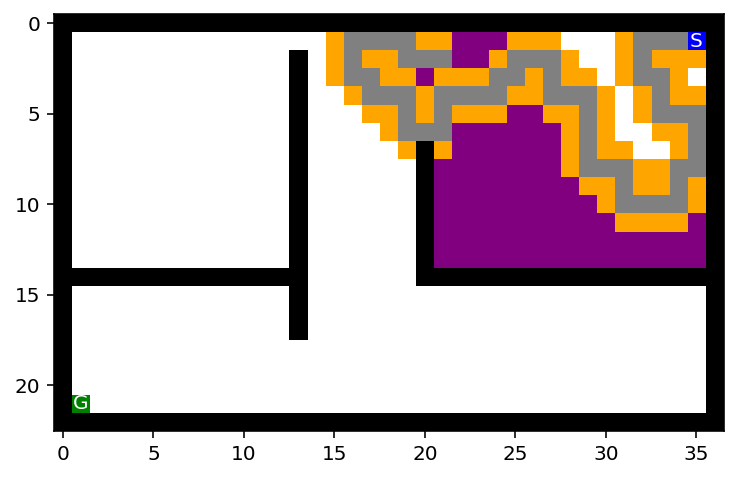

Node - pos = (1, 21); parent = <__main__.Node object at 0x7f100b00ce20>; action = North; cost = 58


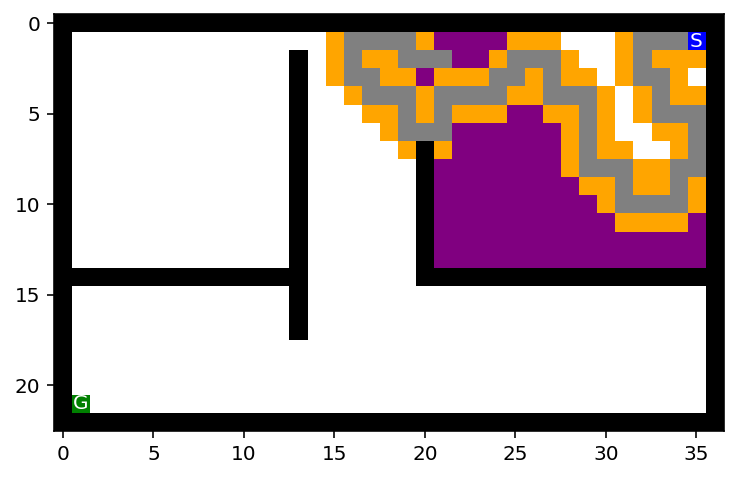

Node - pos = (2, 21); parent = <__main__.Node object at 0x7f100b1aec70>; action = East; cost = 57


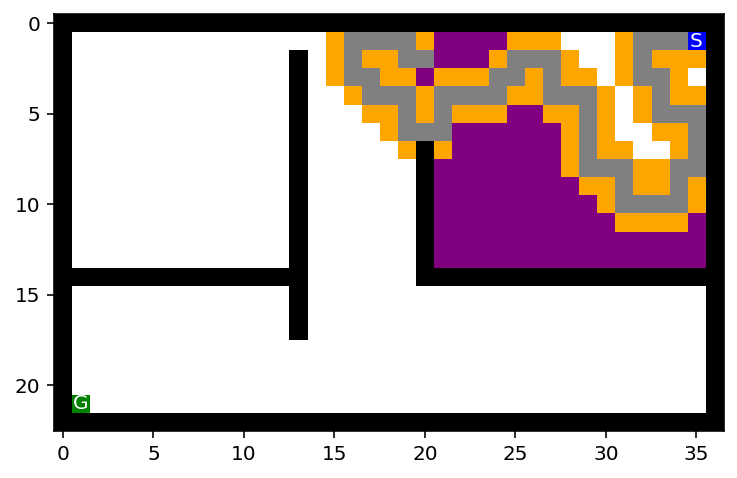

Node - pos = (2, 20); parent = <__main__.Node object at 0x7f100af1c370>; action = East; cost = 56


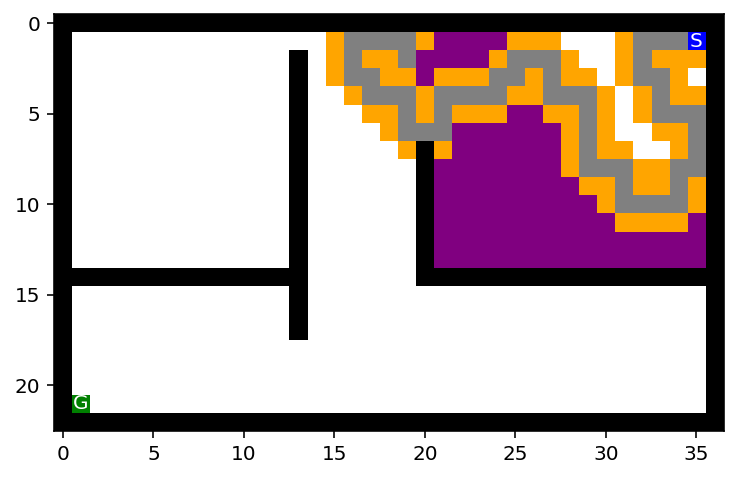

Node - pos = (2, 19); parent = <__main__.Node object at 0x7f100ae07bb0>; action = South; cost = 55


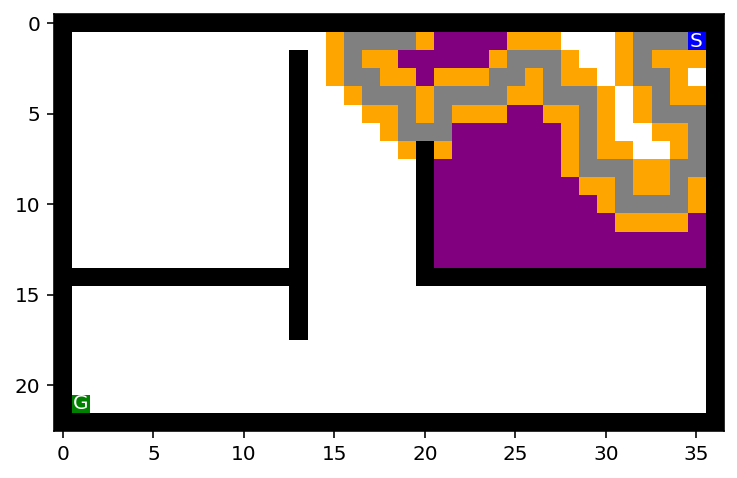

Node - pos = (1, 20); parent = <__main__.Node object at 0x7f100ae07bb0>; action = East; cost = 55


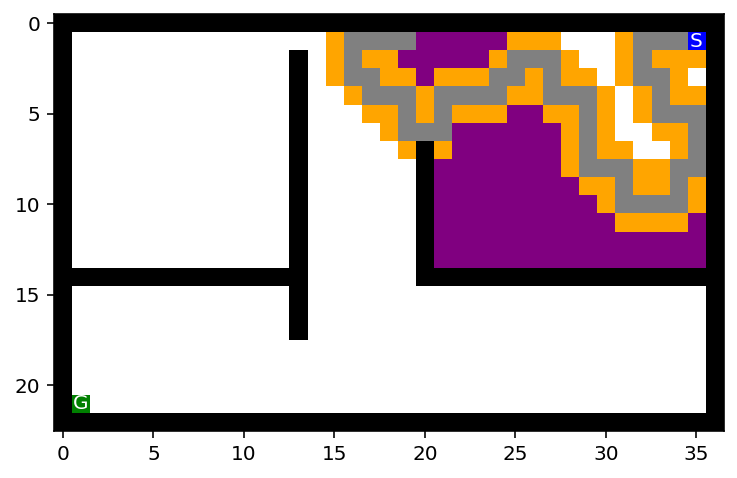

Node - pos = (1, 19); parent = <__main__.Node object at 0x7f100b0942b0>; action = East; cost = 54


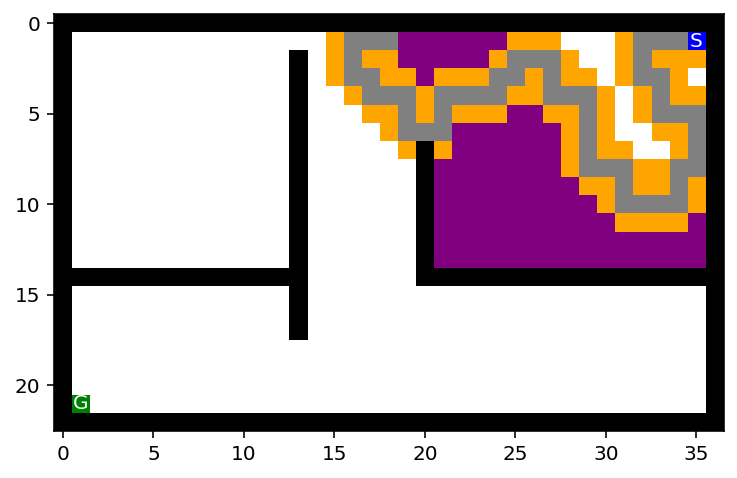

Node - pos = (2, 18); parent = <__main__.Node object at 0x7f100b0942b0>; action = South; cost = 54


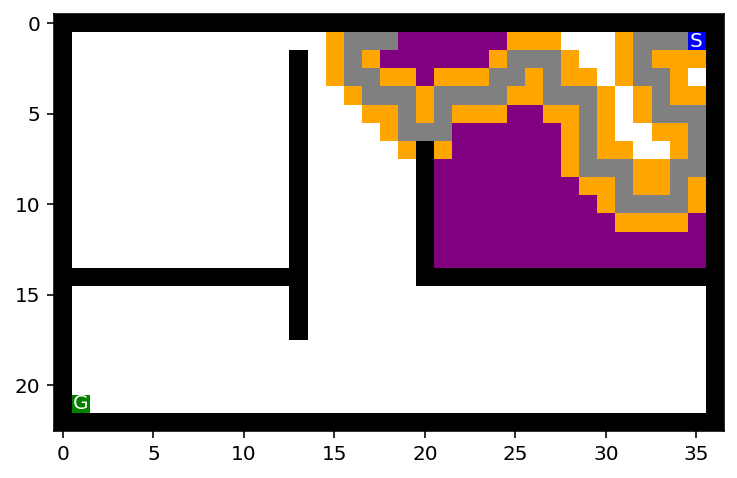

Node - pos = (1, 18); parent = <__main__.Node object at 0x7f100b01d4f0>; action = East; cost = 53


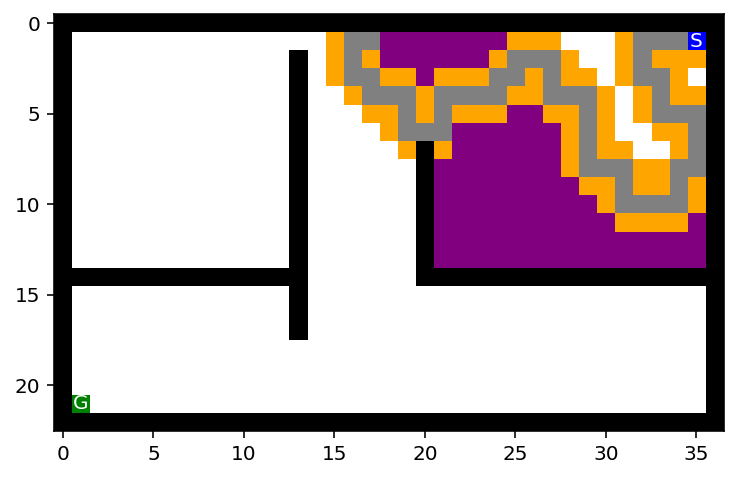

Node - pos = (1, 17); parent = <__main__.Node object at 0x7f100b135550>; action = East; cost = 52


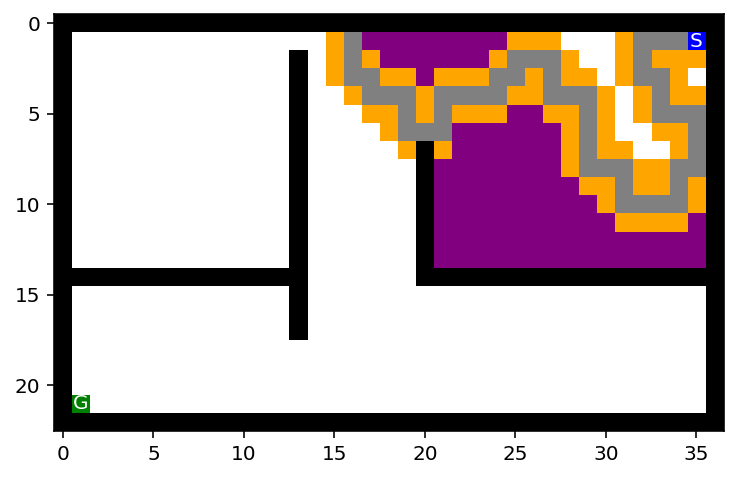

Node - pos = (1, 15); parent = <__main__.Node object at 0x7f100b135550>; action = West; cost = 52


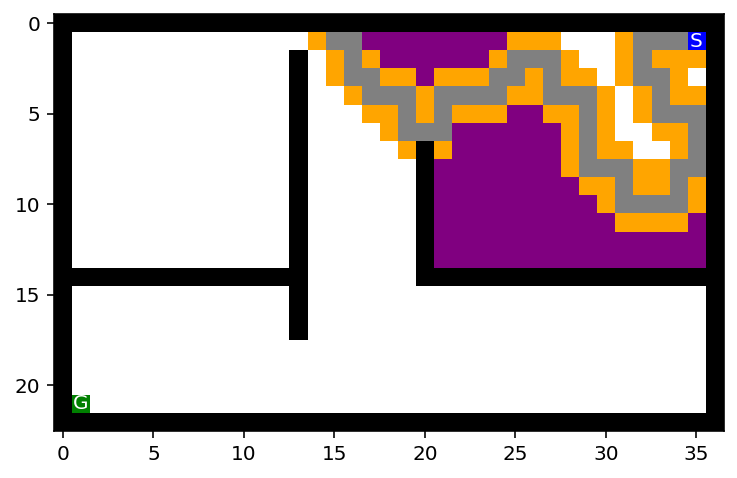

Node - pos = (1, 14); parent = <__main__.Node object at 0x7f100b01de50>; action = West; cost = 53


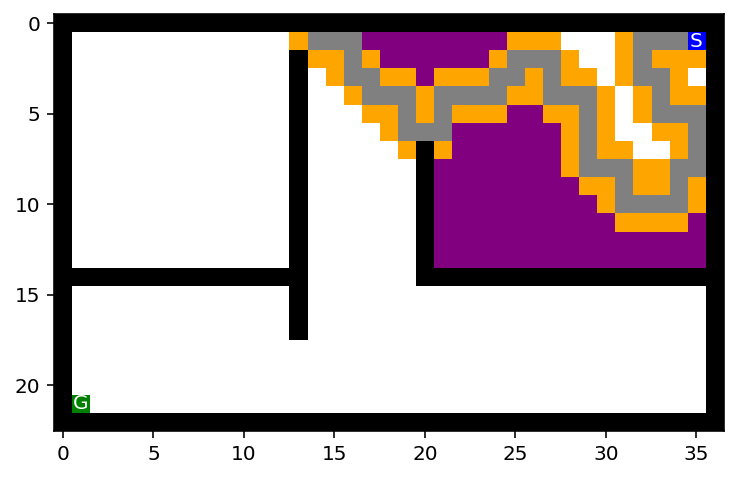

Node - pos = (2, 14); parent = <__main__.Node object at 0x7f100add89d0>; action = South; cost = 54


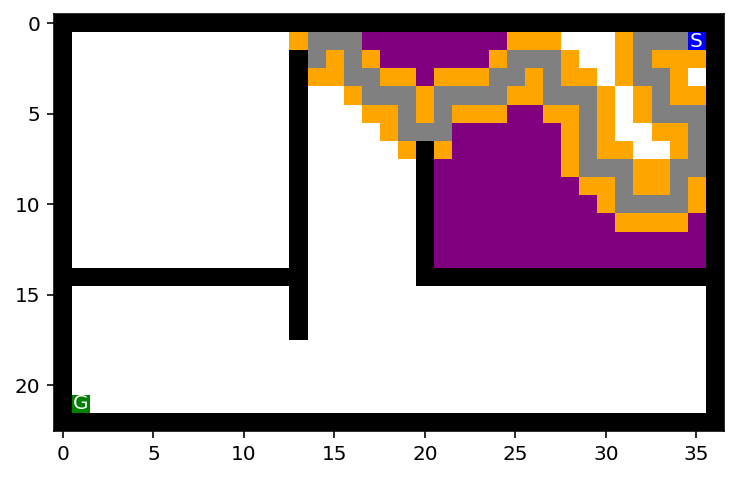

Node - pos = (3, 14); parent = <__main__.Node object at 0x7f100aec3f70>; action = South; cost = 55


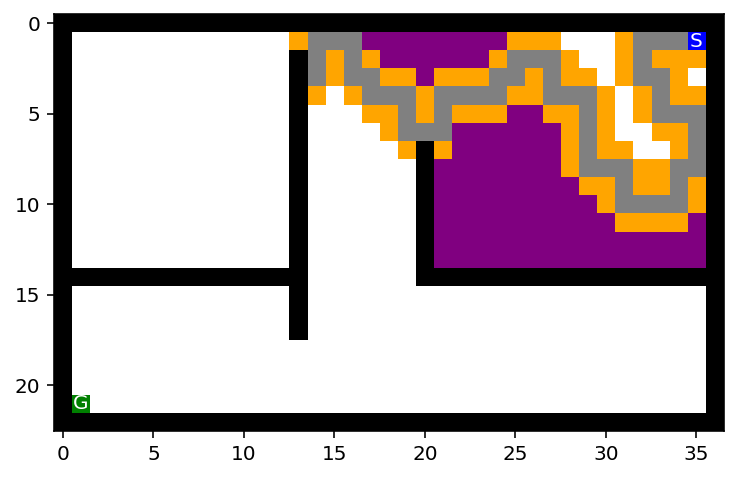

Node - pos = (4, 14); parent = <__main__.Node object at 0x7f100af98880>; action = South; cost = 56


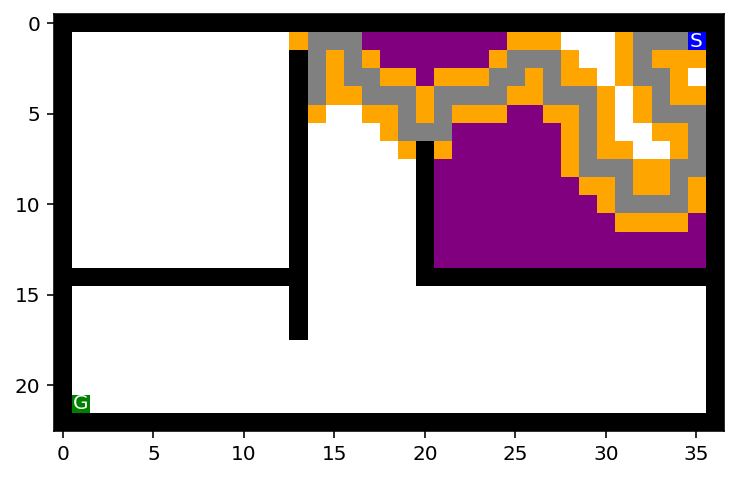

Node - pos = (4, 15); parent = <__main__.Node object at 0x7f100ad8d8e0>; action = East; cost = 57


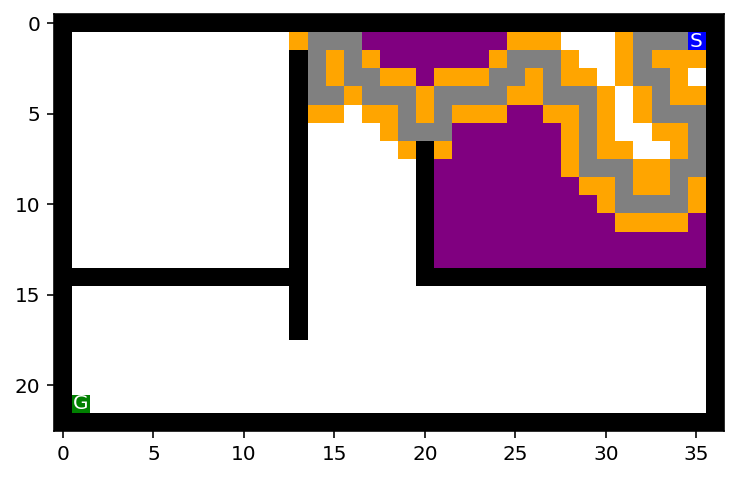

Node - pos = (5, 15); parent = <__main__.Node object at 0x7f100af0c0a0>; action = South; cost = 58


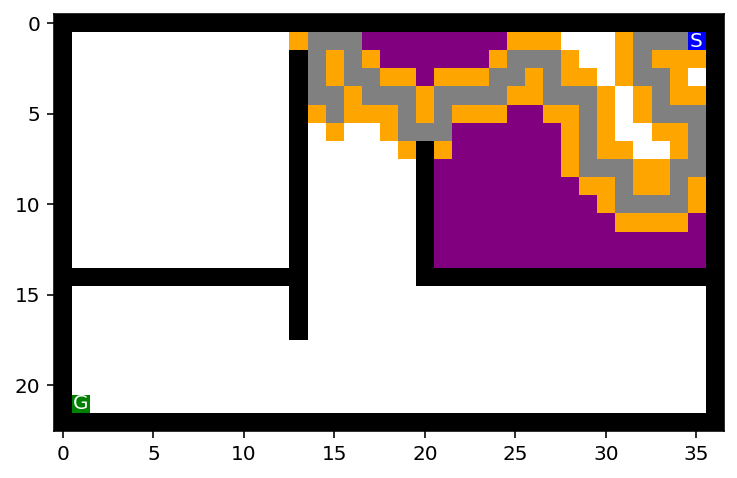

Node - pos = (6, 15); parent = <__main__.Node object at 0x7f100b1aed60>; action = South; cost = 59


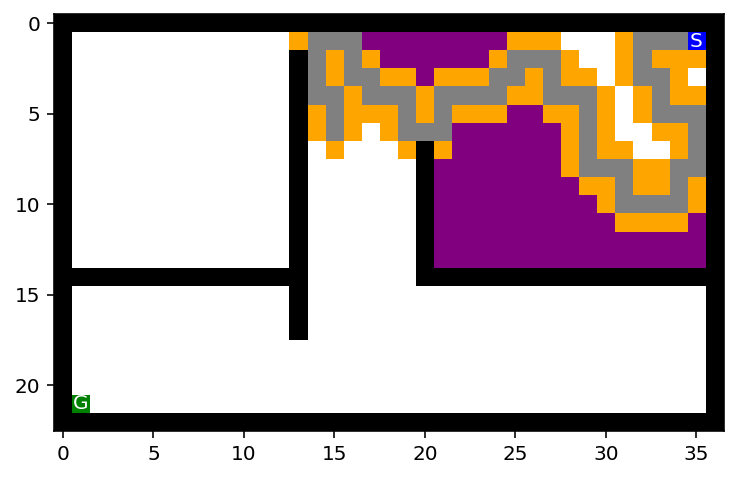

Node - pos = (6, 14); parent = <__main__.Node object at 0x7f100b095160>; action = West; cost = 60


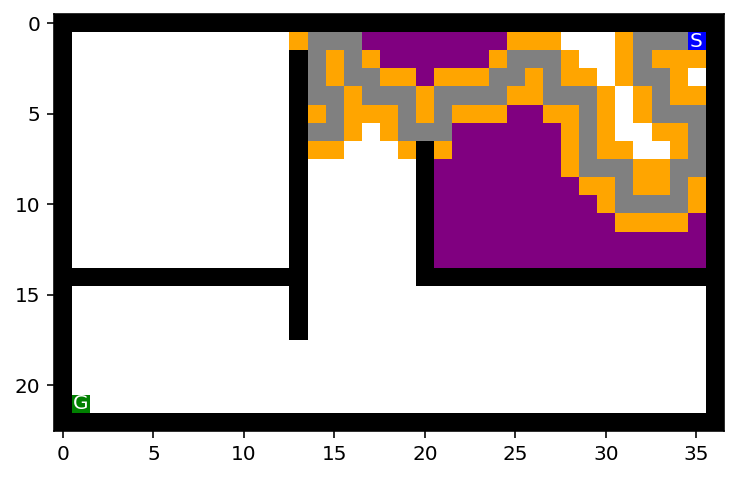

Node - pos = (7, 14); parent = <__main__.Node object at 0x7f100aec76d0>; action = South; cost = 61


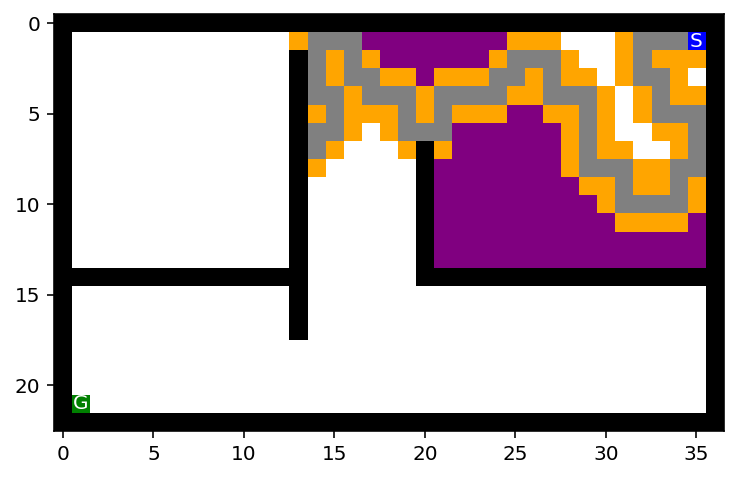

Node - pos = (8, 14); parent = <__main__.Node object at 0x7f100b0eac10>; action = South; cost = 62


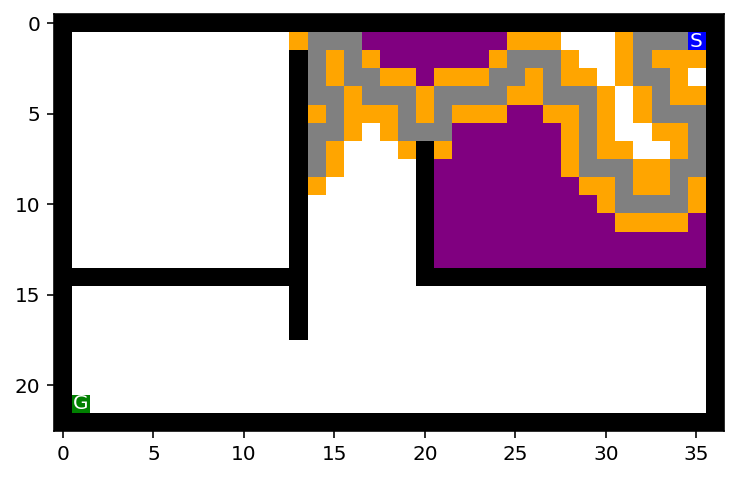

Node - pos = (8, 15); parent = <__main__.Node object at 0x7f100ae097f0>; action = East; cost = 63


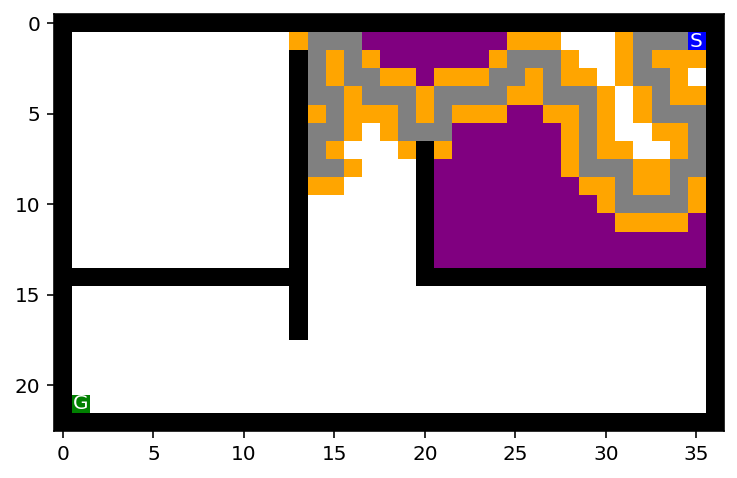

Node - pos = (9, 15); parent = <__main__.Node object at 0x7f100b174d60>; action = South; cost = 64


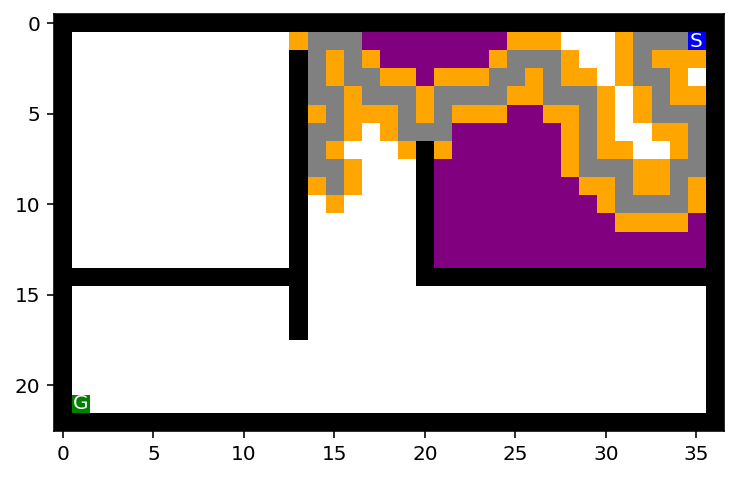

Node - pos = (9, 16); parent = <__main__.Node object at 0x7f100b1bc610>; action = East; cost = 65


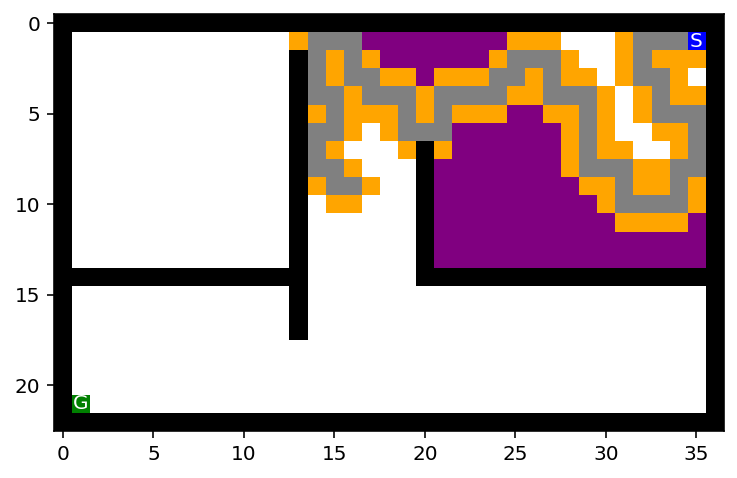

Node - pos = (10, 16); parent = <__main__.Node object at 0x7f100af98b50>; action = South; cost = 66


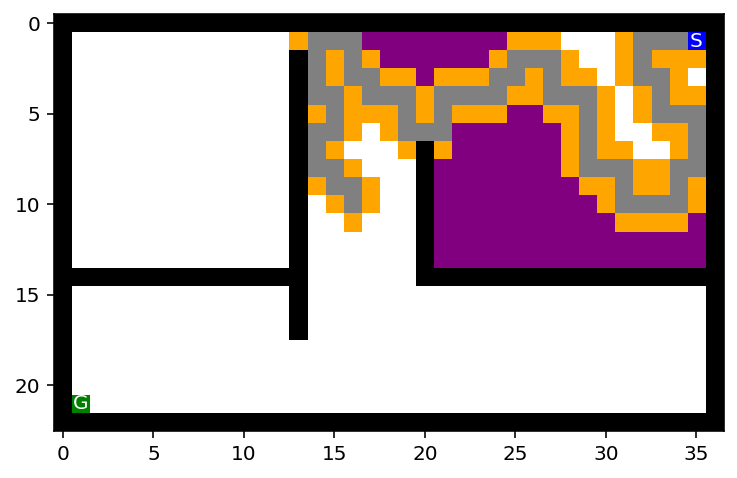

Node - pos = (11, 16); parent = <__main__.Node object at 0x7f100af69c40>; action = South; cost = 67


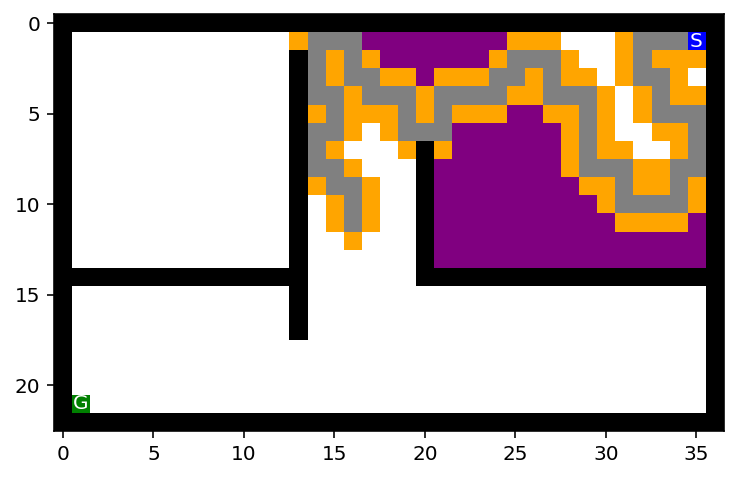

Node - pos = (11, 17); parent = <__main__.Node object at 0x7f100b1420a0>; action = East; cost = 68


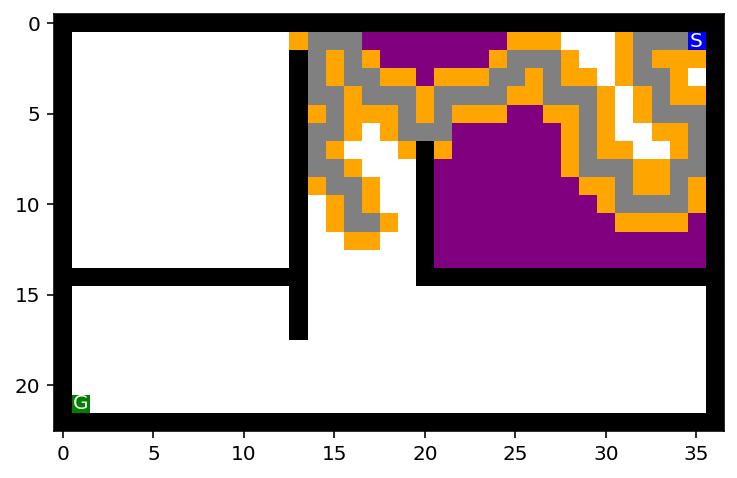

Node - pos = (12, 17); parent = <__main__.Node object at 0x7f100b135100>; action = South; cost = 69


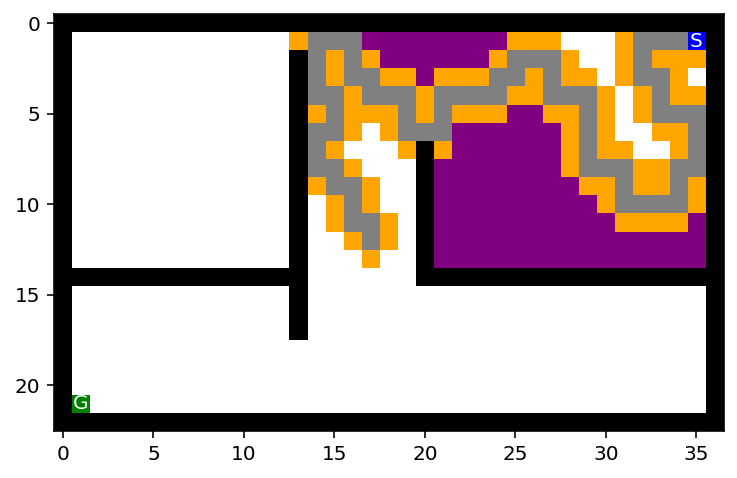

Node - pos = (12, 18); parent = <__main__.Node object at 0x7f100ae071c0>; action = East; cost = 70


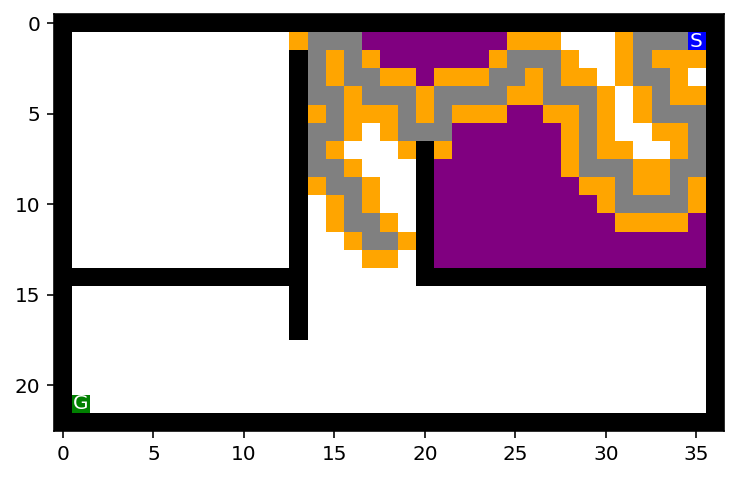

Node - pos = (12, 19); parent = <__main__.Node object at 0x7f100b00ad00>; action = East; cost = 71


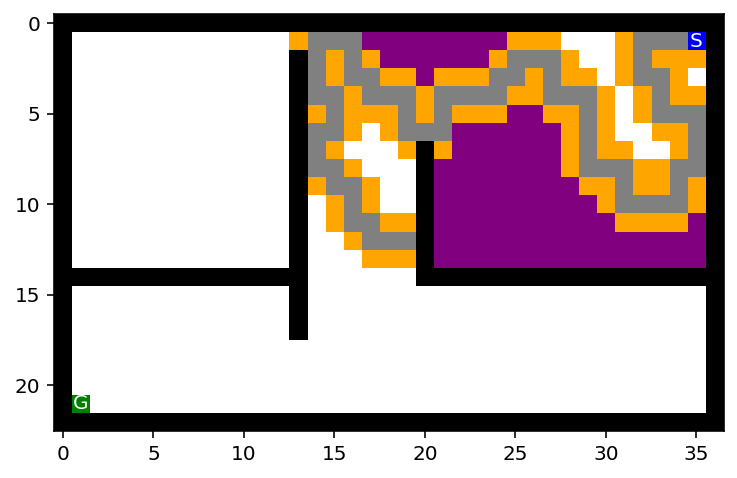

Node - pos = (11, 19); parent = <__main__.Node object at 0x7f100aee7550>; action = North; cost = 72


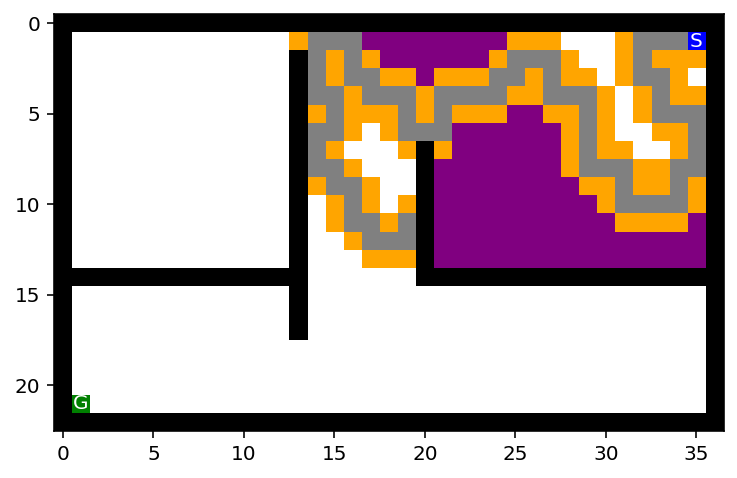

Node - pos = (10, 19); parent = <__main__.Node object at 0x7f100b1041c0>; action = North; cost = 73


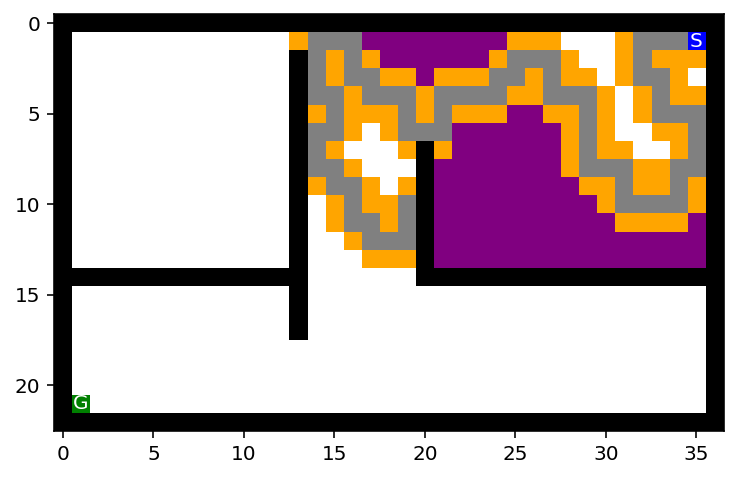

Node - pos = (10, 18); parent = <__main__.Node object at 0x7f100b0d3a90>; action = West; cost = 74


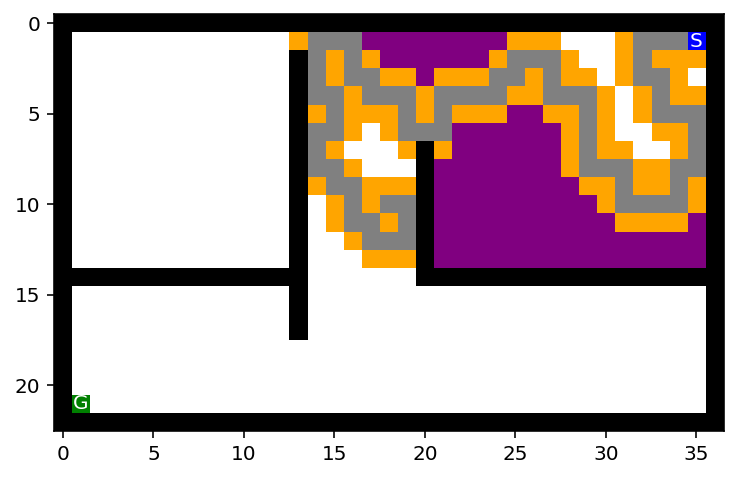

Node - pos = (9, 18); parent = <__main__.Node object at 0x7f100aeed160>; action = North; cost = 75


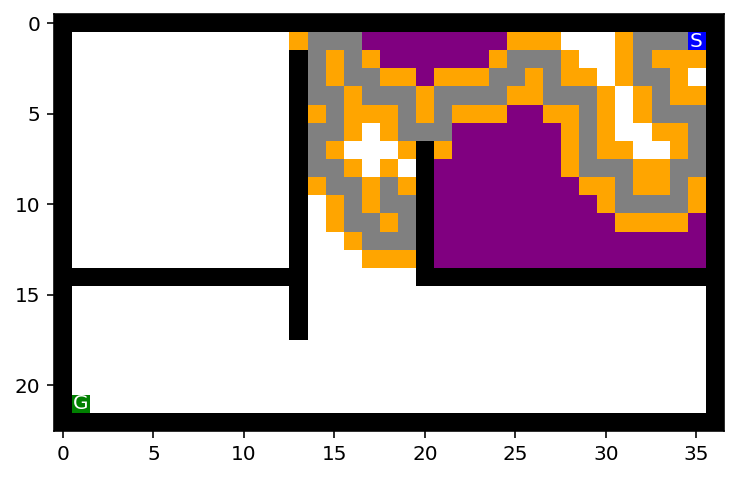

Node - pos = (8, 18); parent = <__main__.Node object at 0x7f100b134bb0>; action = North; cost = 76


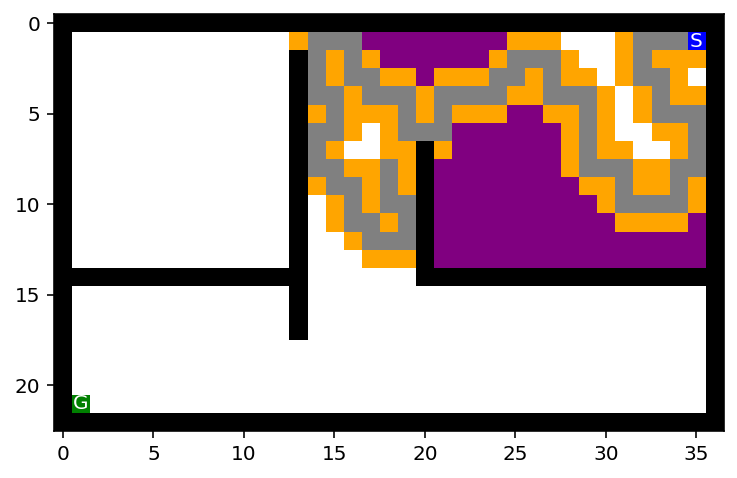

Node - pos = (8, 17); parent = <__main__.Node object at 0x7f100ada8c70>; action = West; cost = 77


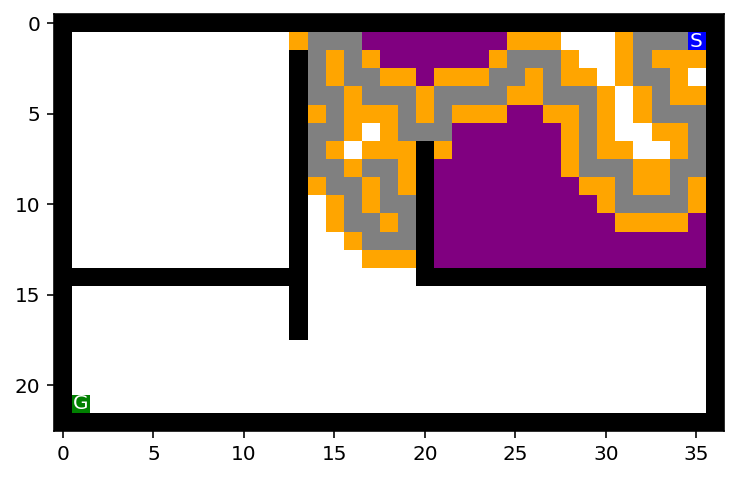

Node - pos = (7, 17); parent = <__main__.Node object at 0x7f100ad7edf0>; action = North; cost = 78


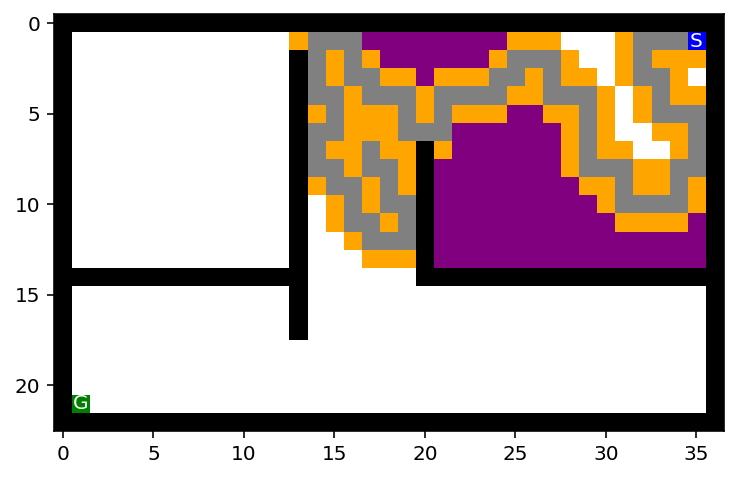

Node - pos = (6, 17); parent = <__main__.Node object at 0x7f100b06c3d0>; action = North; cost = 79


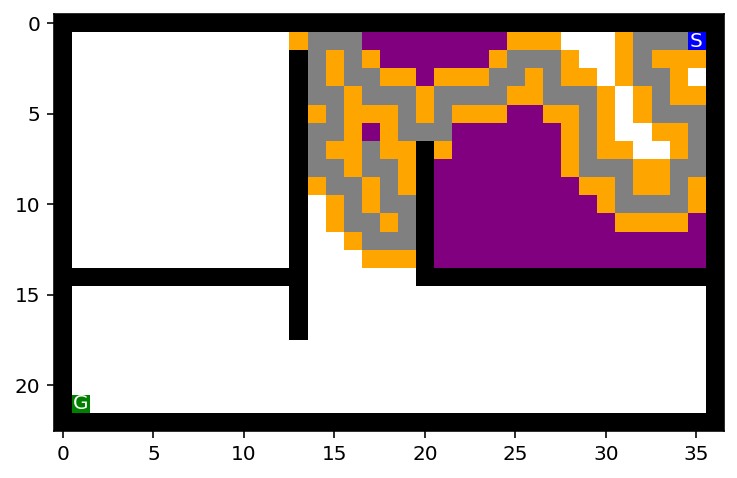

Node - pos = (7, 16); parent = <__main__.Node object at 0x7f100b06c3d0>; action = West; cost = 79


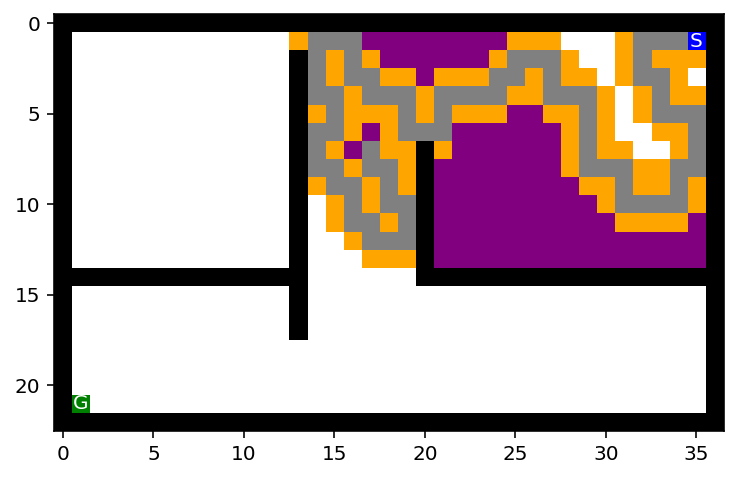

Node - pos = (7, 17); parent = <__main__.Node object at 0x7f100ad7edf0>; action = North; cost = 78


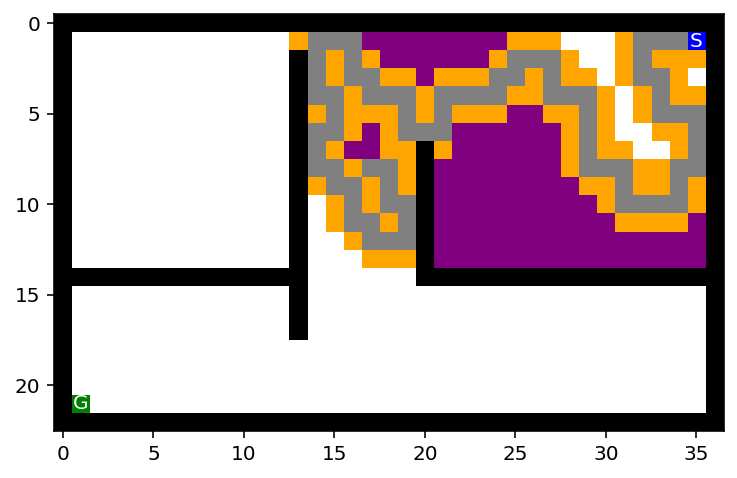

Node - pos = (8, 17); parent = <__main__.Node object at 0x7f100ada8c70>; action = West; cost = 77


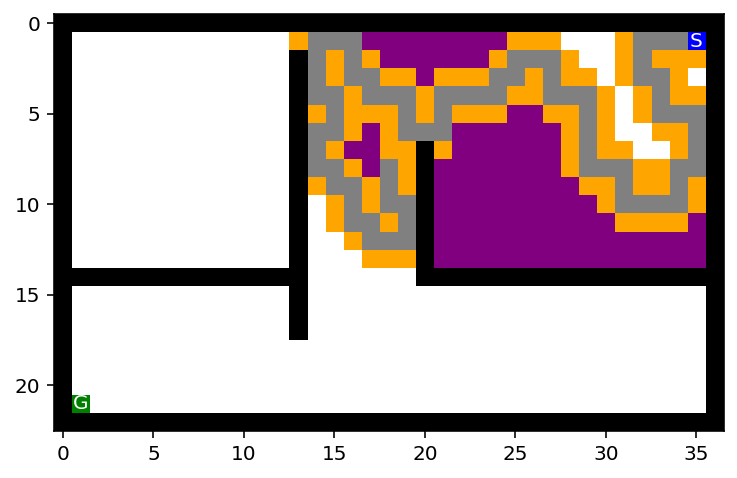

Node - pos = (7, 18); parent = <__main__.Node object at 0x7f100ada8c70>; action = North; cost = 77


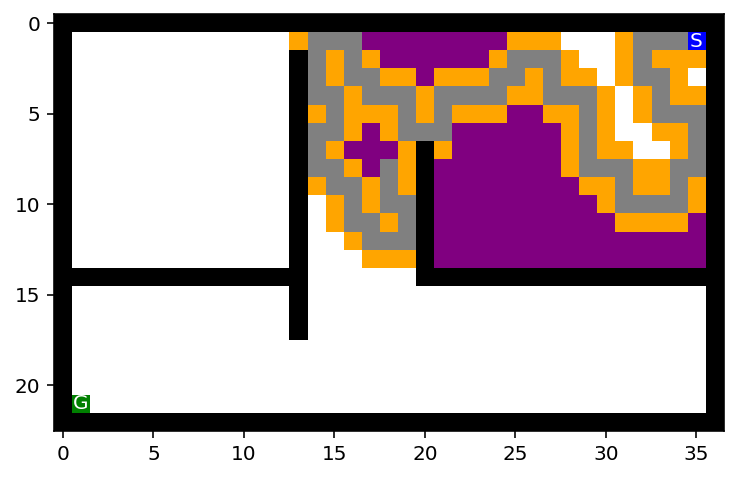

Node - pos = (8, 19); parent = <__main__.Node object at 0x7f100ada8c70>; action = East; cost = 77


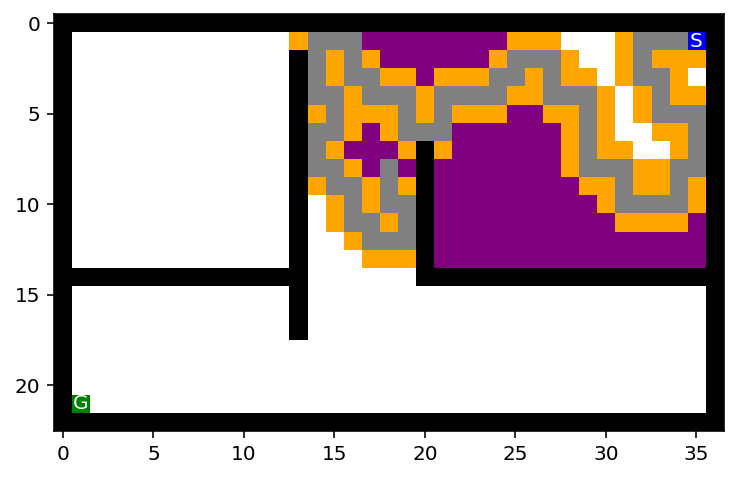

Node - pos = (8, 18); parent = <__main__.Node object at 0x7f100b134bb0>; action = North; cost = 76


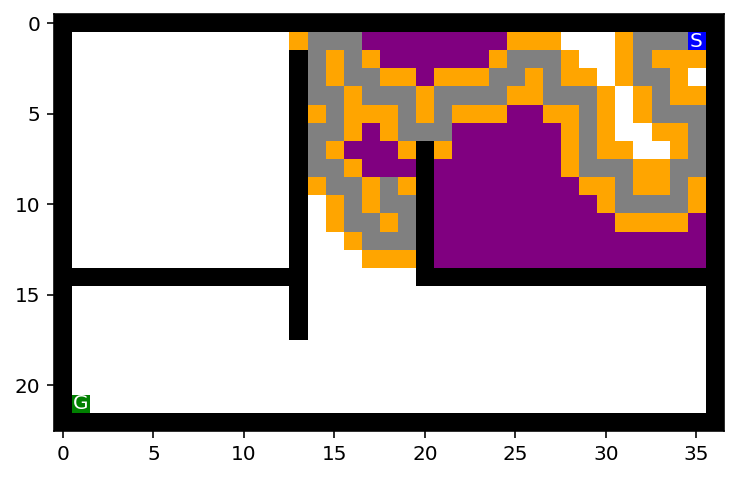

Node - pos = (9, 18); parent = <__main__.Node object at 0x7f100aeed160>; action = North; cost = 75


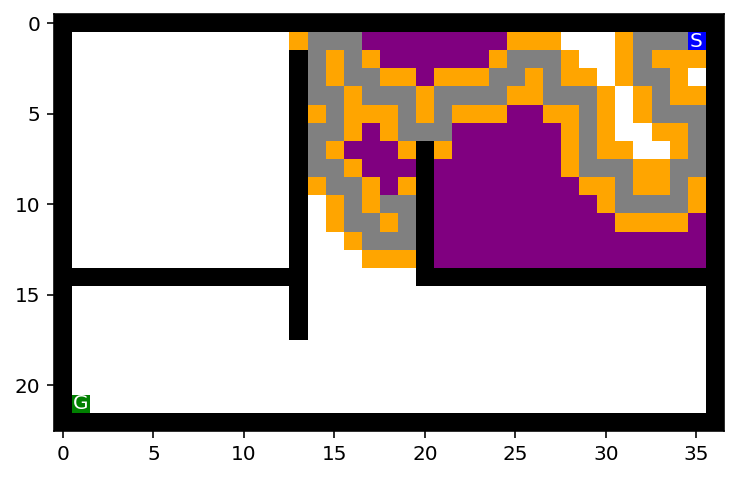

Node - pos = (10, 18); parent = <__main__.Node object at 0x7f100b0d3a90>; action = West; cost = 74


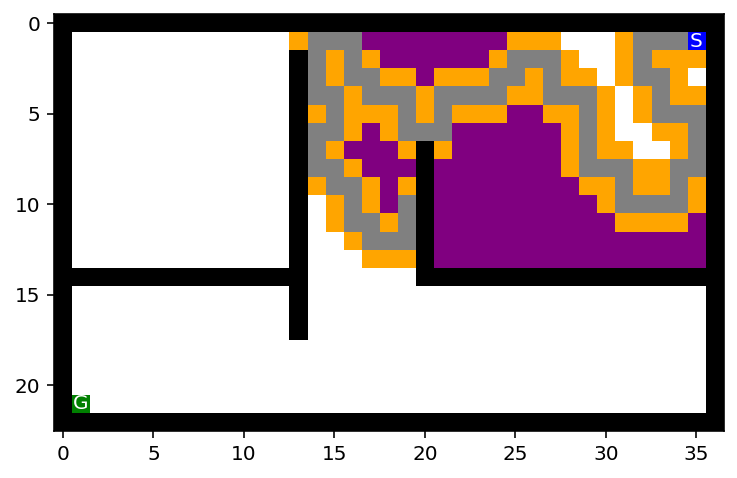

Node - pos = (9, 19); parent = <__main__.Node object at 0x7f100b0d3a90>; action = North; cost = 74


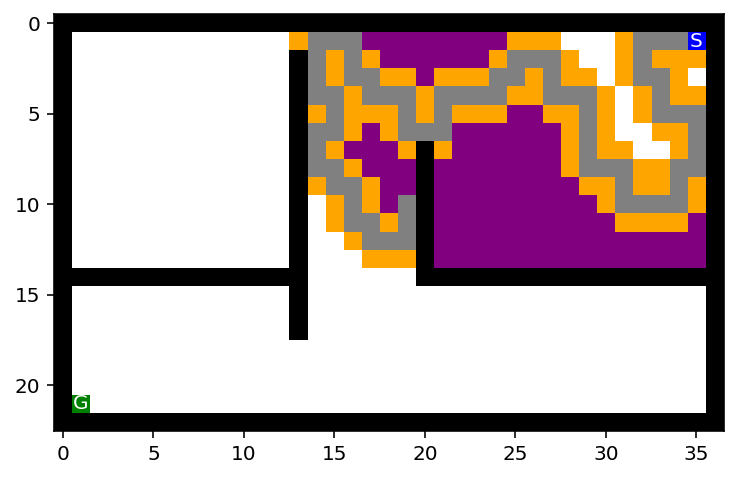

Node - pos = (10, 19); parent = <__main__.Node object at 0x7f100b1041c0>; action = North; cost = 73


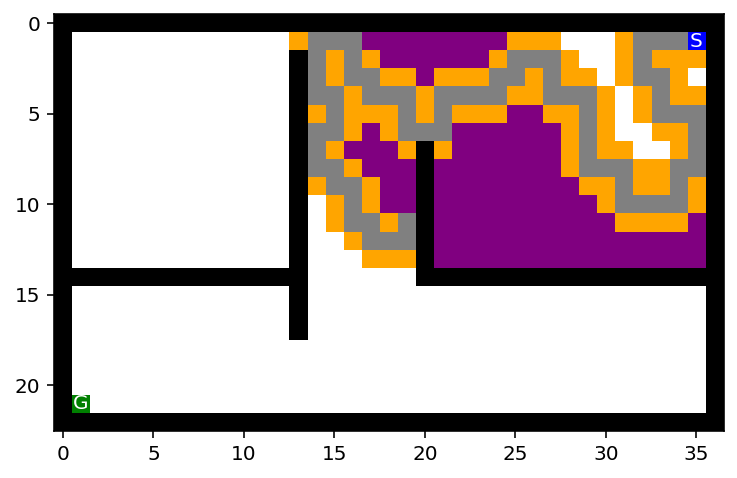

Node - pos = (11, 19); parent = <__main__.Node object at 0x7f100aee7550>; action = North; cost = 72


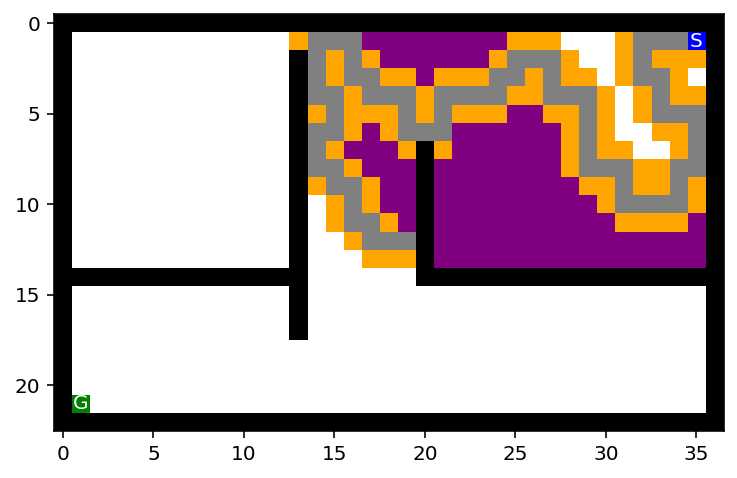

Node - pos = (13, 19); parent = <__main__.Node object at 0x7f100aee7550>; action = South; cost = 72


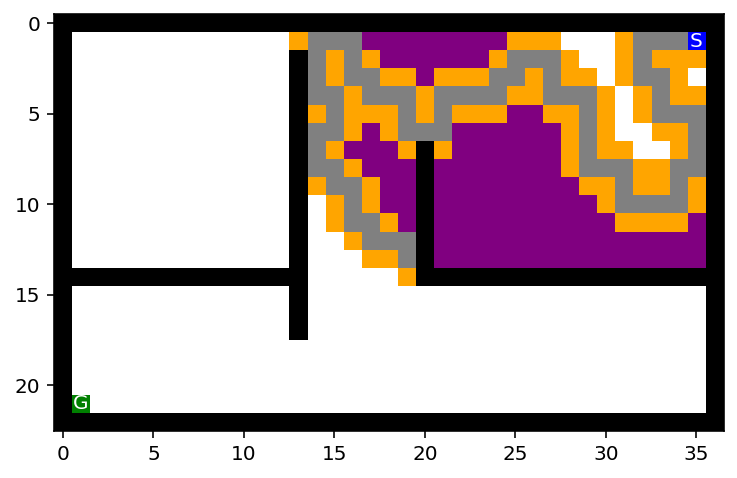

Node - pos = (14, 19); parent = <__main__.Node object at 0x7f100b104d60>; action = South; cost = 73


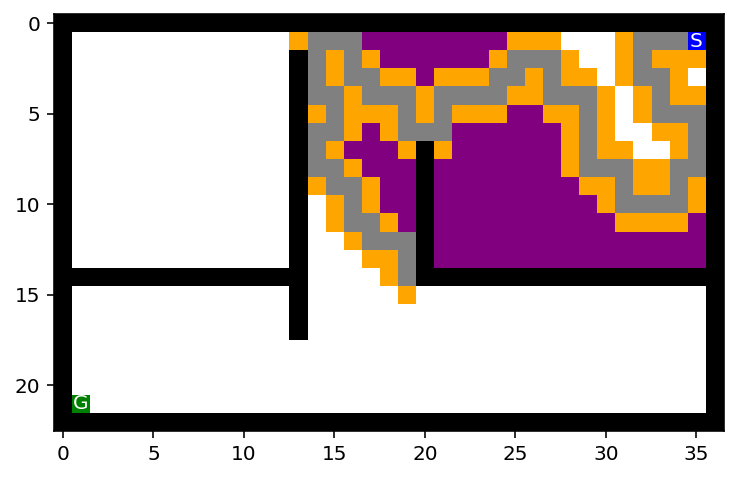

Node - pos = (14, 18); parent = <__main__.Node object at 0x7f100b101940>; action = West; cost = 74


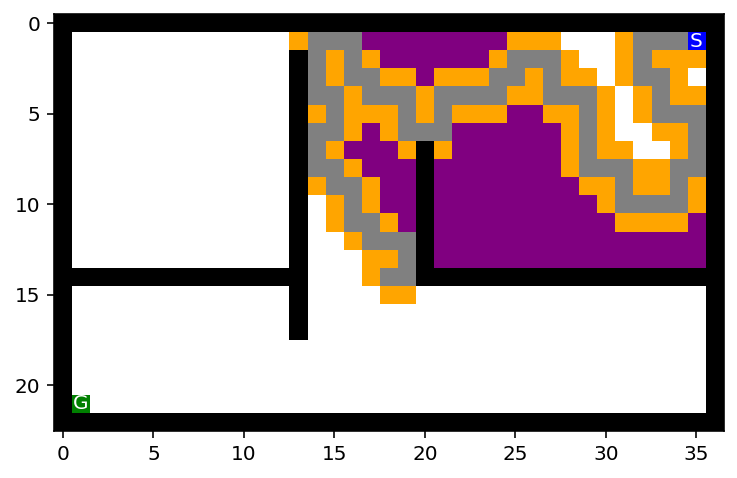

Node - pos = (14, 17); parent = <__main__.Node object at 0x7f100add1760>; action = West; cost = 75


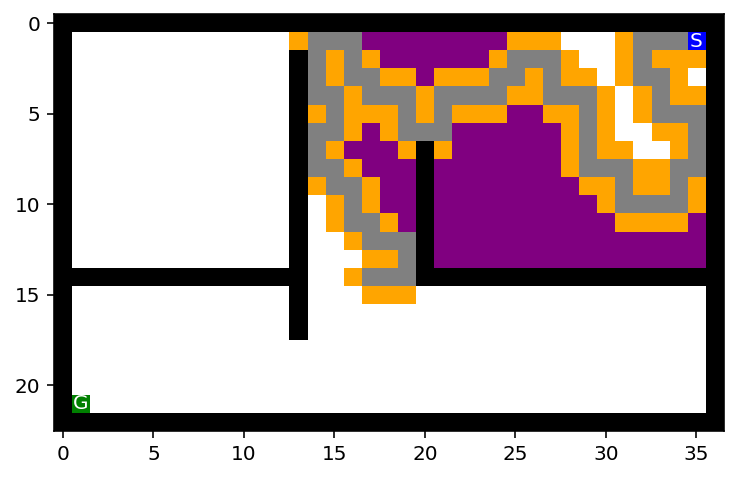

Node - pos = (15, 17); parent = <__main__.Node object at 0x7f100b083670>; action = South; cost = 76


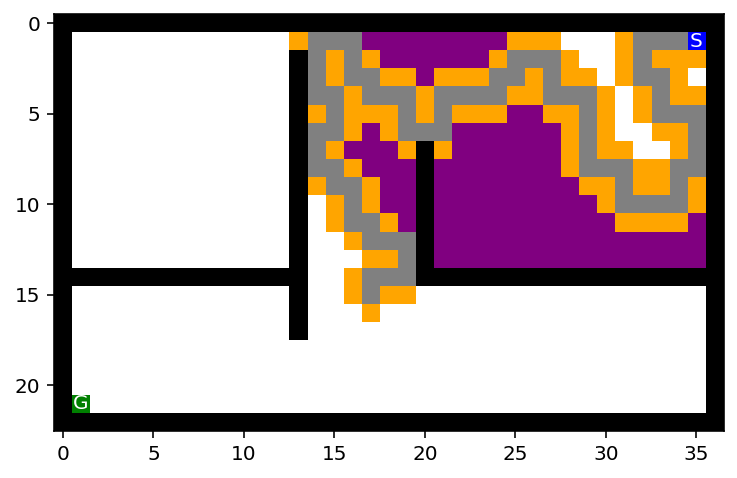

Node - pos = (15, 16); parent = <__main__.Node object at 0x7f100ae5db20>; action = West; cost = 77


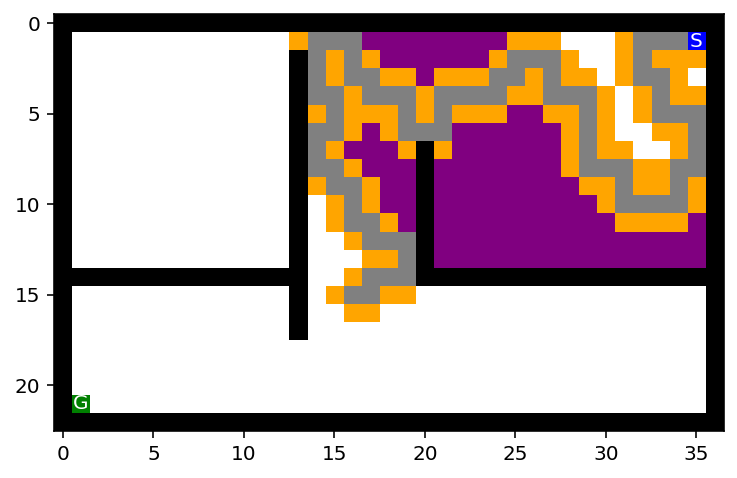

Node - pos = (16, 16); parent = <__main__.Node object at 0x7f100b101130>; action = South; cost = 78


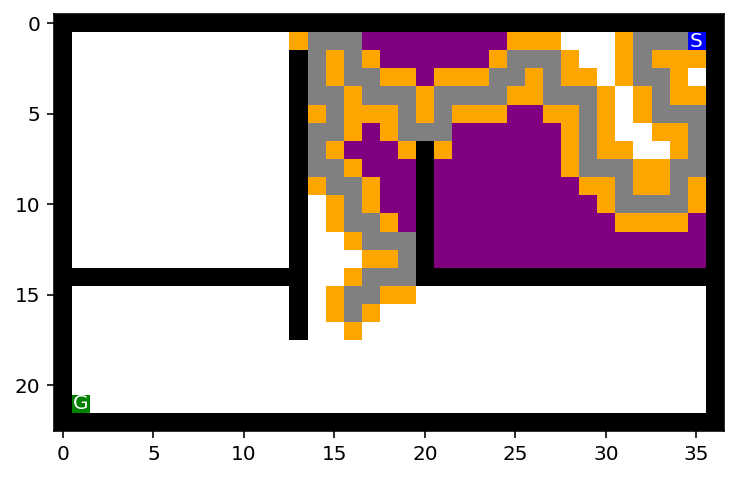

Node - pos = (17, 16); parent = <__main__.Node object at 0x7f1028694c40>; action = South; cost = 79


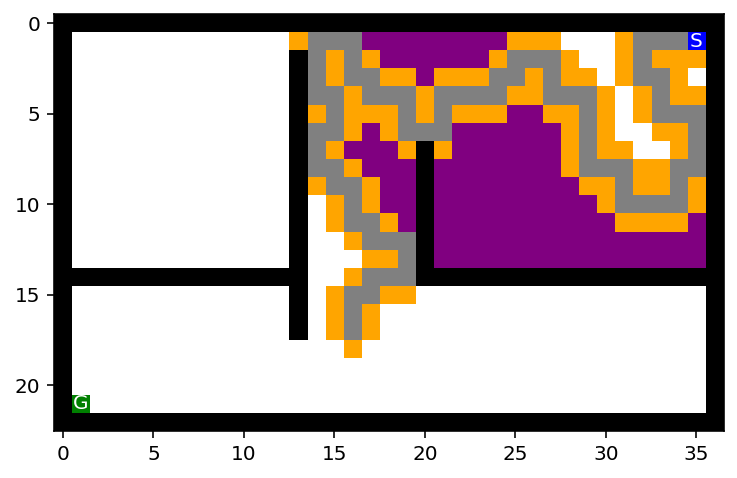

Node - pos = (17, 17); parent = <__main__.Node object at 0x7f100aeb6250>; action = East; cost = 80


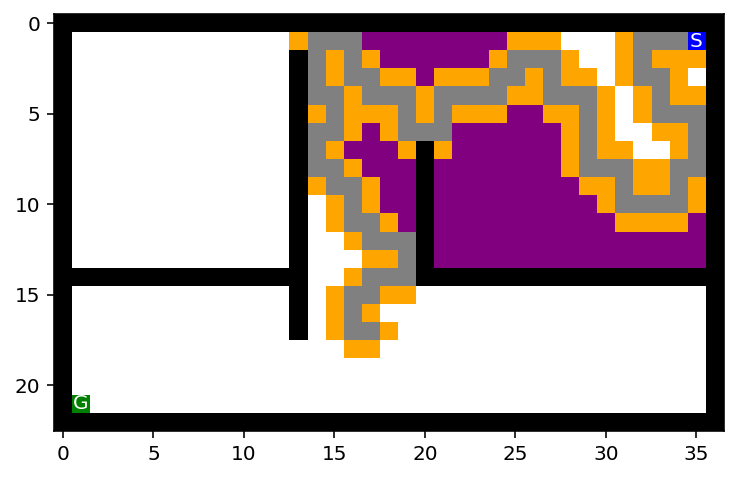

Node - pos = (18, 17); parent = <__main__.Node object at 0x7f100b174fa0>; action = South; cost = 81


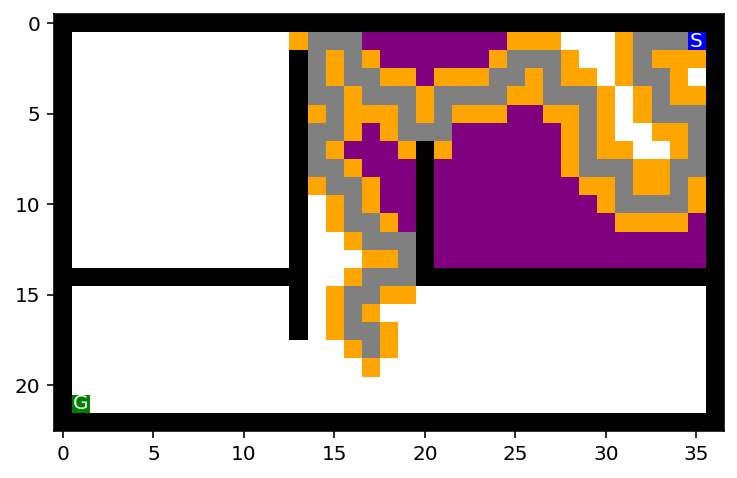

Node - pos = (19, 17); parent = <__main__.Node object at 0x7f100ae099d0>; action = South; cost = 82


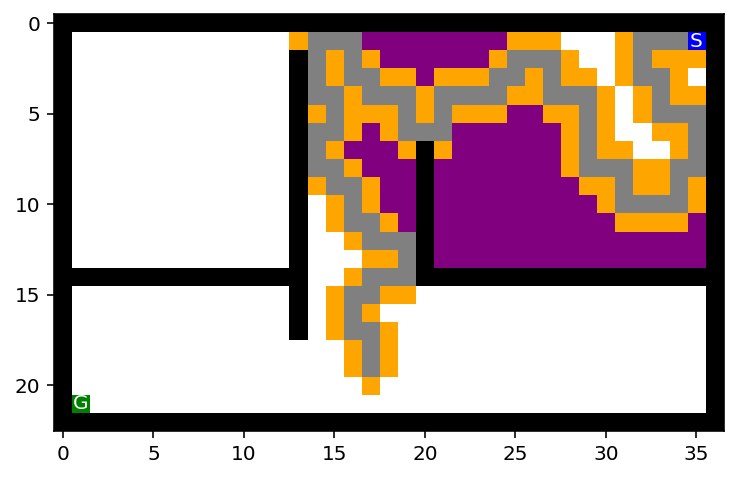

Node - pos = (20, 17); parent = <__main__.Node object at 0x7f100adf5040>; action = South; cost = 83


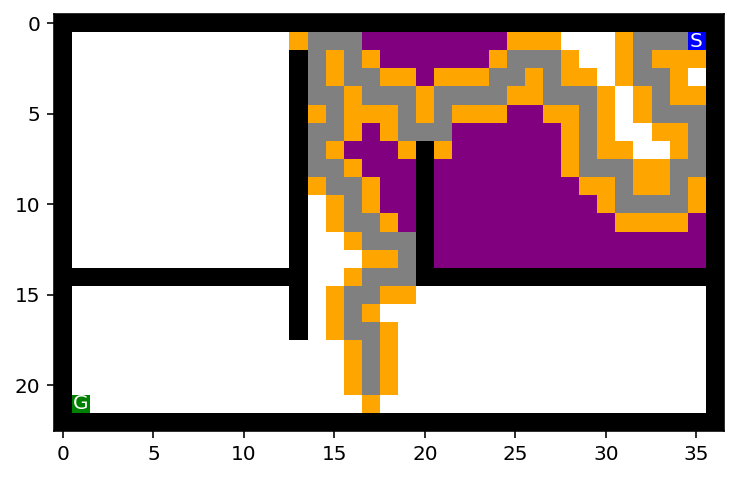

Node - pos = (20, 18); parent = <__main__.Node object at 0x7f100ada8bb0>; action = East; cost = 84


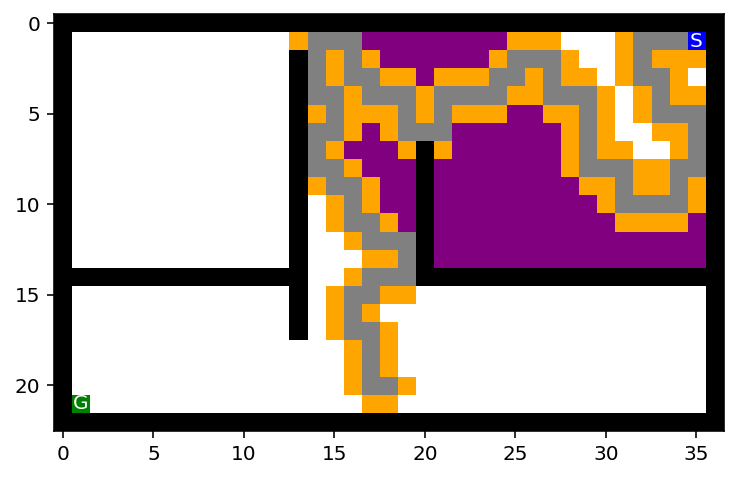

Node - pos = (21, 18); parent = <__main__.Node object at 0x7f100adce100>; action = South; cost = 85


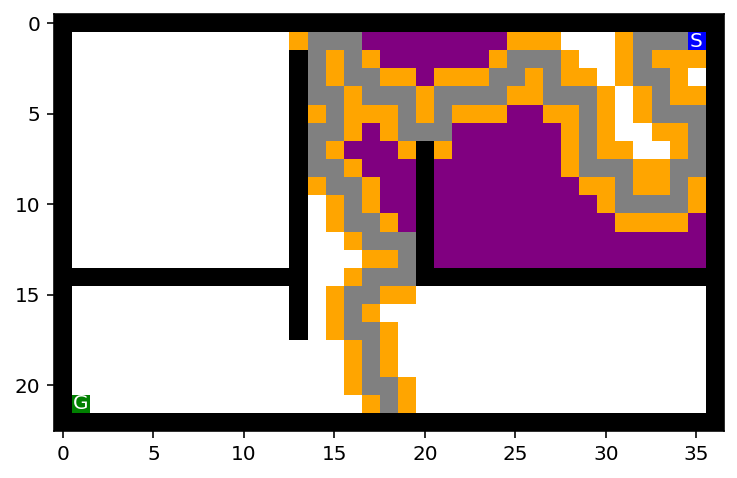

Node - pos = (21, 19); parent = <__main__.Node object at 0x7f100b0060d0>; action = East; cost = 86


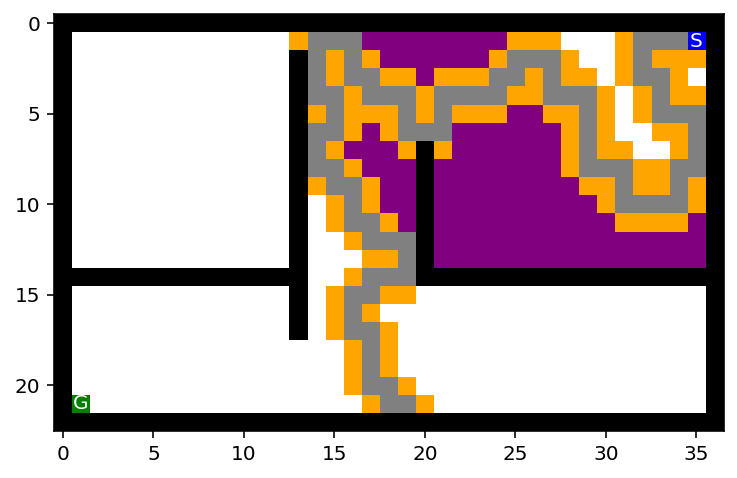

Node - pos = (21, 20); parent = <__main__.Node object at 0x7f100b154c70>; action = East; cost = 87


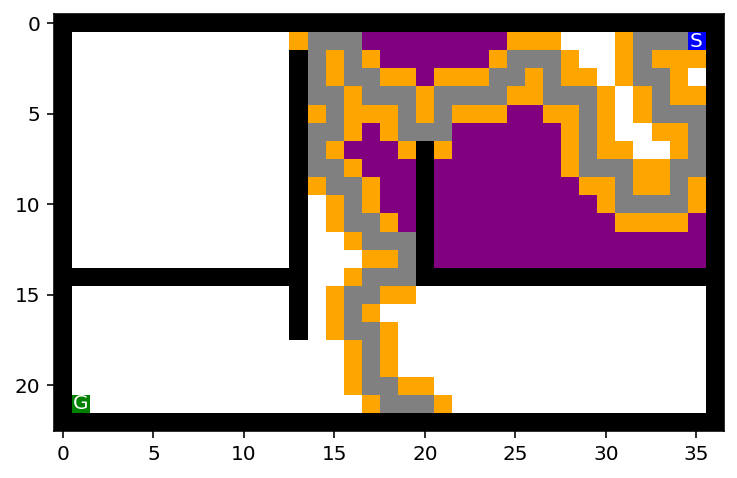

Node - pos = (21, 21); parent = <__main__.Node object at 0x7f100aec2430>; action = East; cost = 88


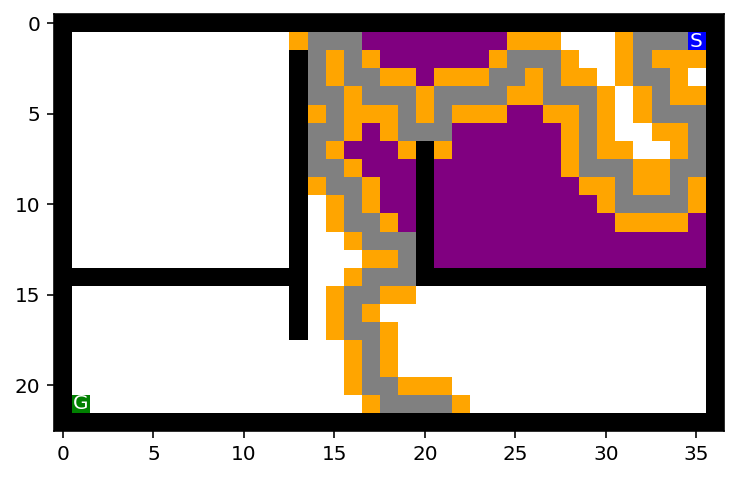

Node - pos = (20, 21); parent = <__main__.Node object at 0x7f100adb0af0>; action = North; cost = 89


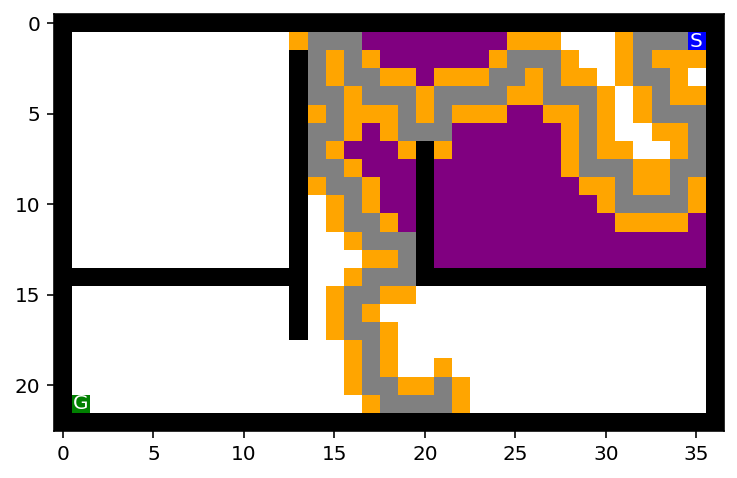

Node - pos = (20, 22); parent = <__main__.Node object at 0x7f100af16df0>; action = East; cost = 90


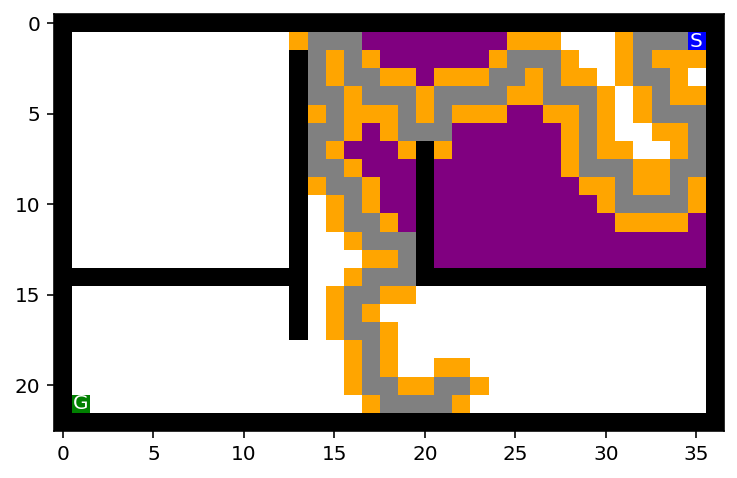

Node - pos = (20, 23); parent = <__main__.Node object at 0x7f100ae58580>; action = East; cost = 91


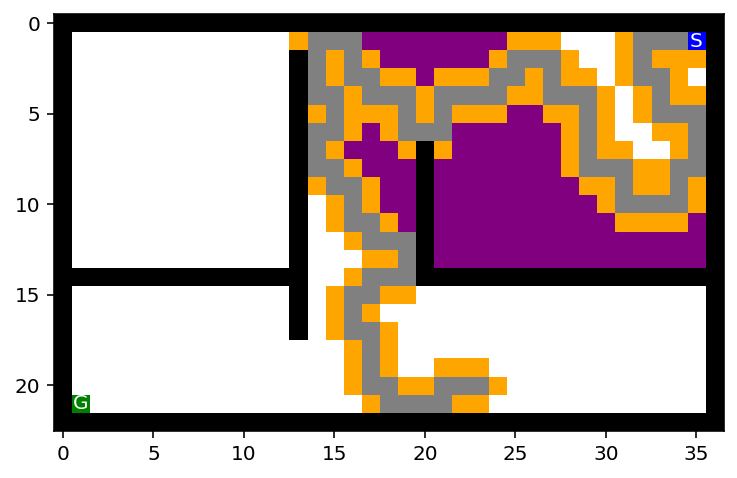

Node - pos = (20, 24); parent = <__main__.Node object at 0x7f100addbd30>; action = East; cost = 92


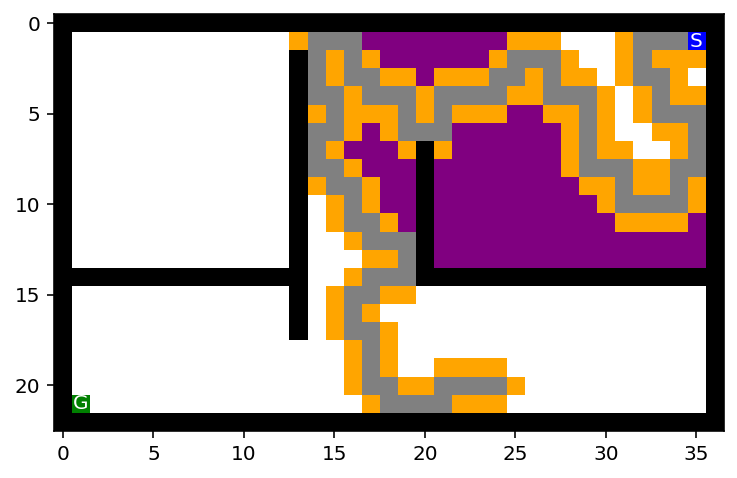

Node - pos = (19, 24); parent = <__main__.Node object at 0x7f100af98160>; action = North; cost = 93


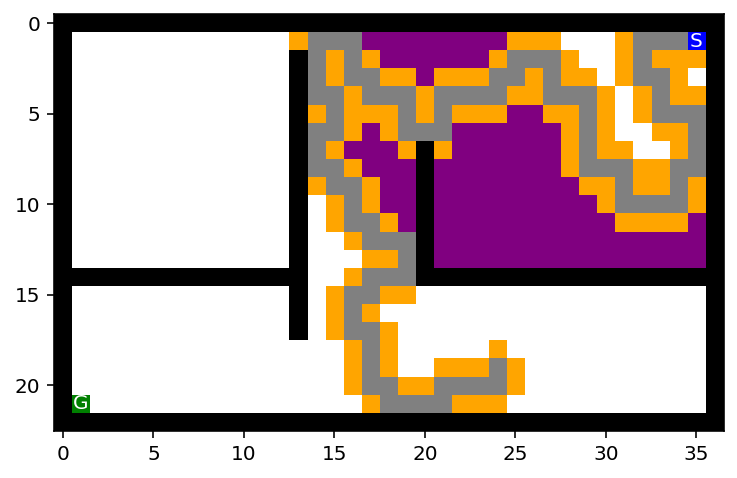

Node - pos = (18, 24); parent = <__main__.Node object at 0x7f100b056d30>; action = North; cost = 94


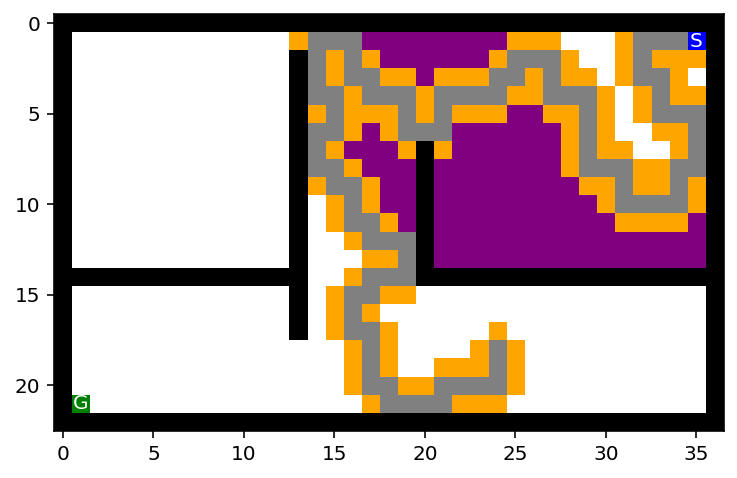

Node - pos = (17, 24); parent = <__main__.Node object at 0x7f100b18c850>; action = North; cost = 95


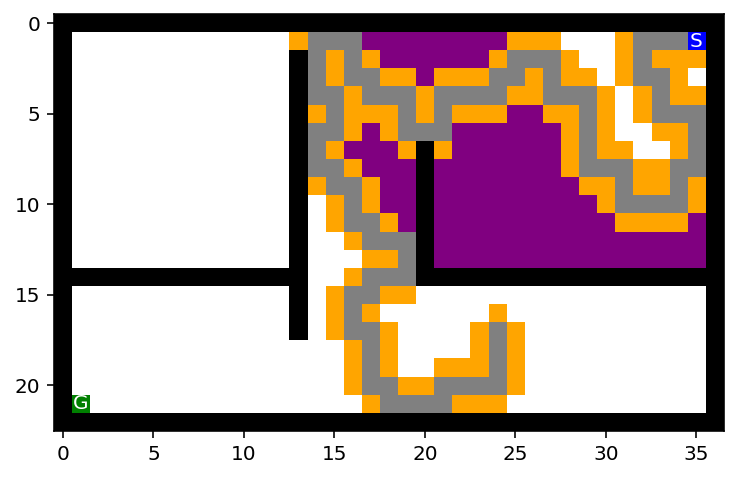

Node - pos = (16, 24); parent = <__main__.Node object at 0x7f100b04ad60>; action = North; cost = 96


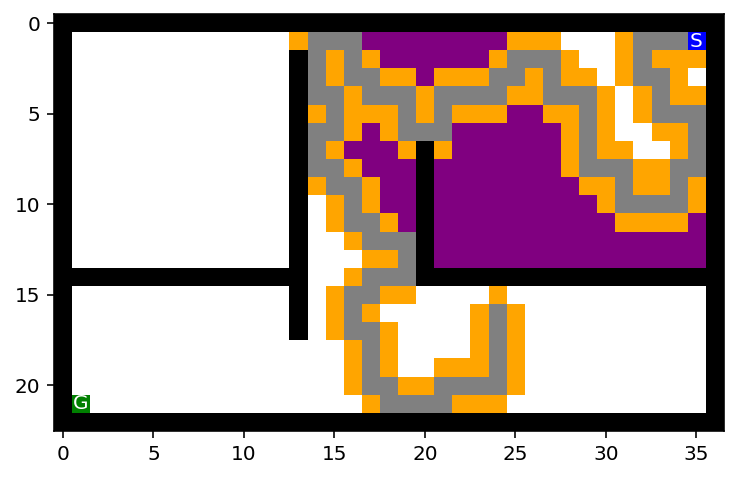

Node - pos = (16, 25); parent = <__main__.Node object at 0x7f100b12a7f0>; action = East; cost = 97


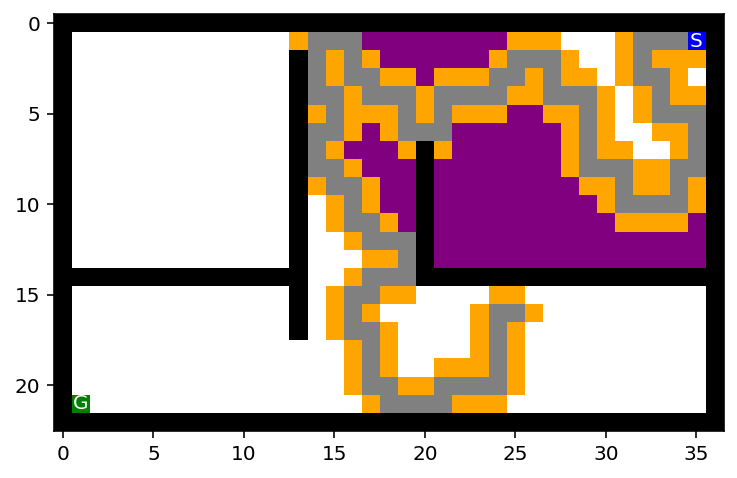

Node - pos = (15, 25); parent = <__main__.Node object at 0x7f100b12a880>; action = North; cost = 98


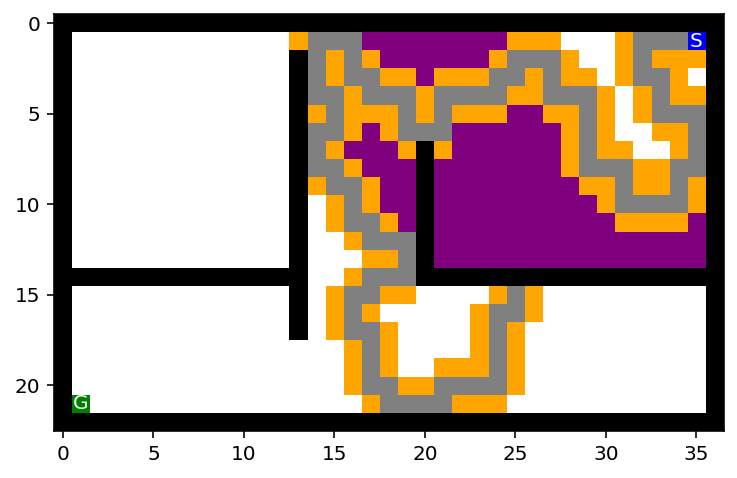

Node - pos = (15, 26); parent = <__main__.Node object at 0x7f100af0cd90>; action = East; cost = 99


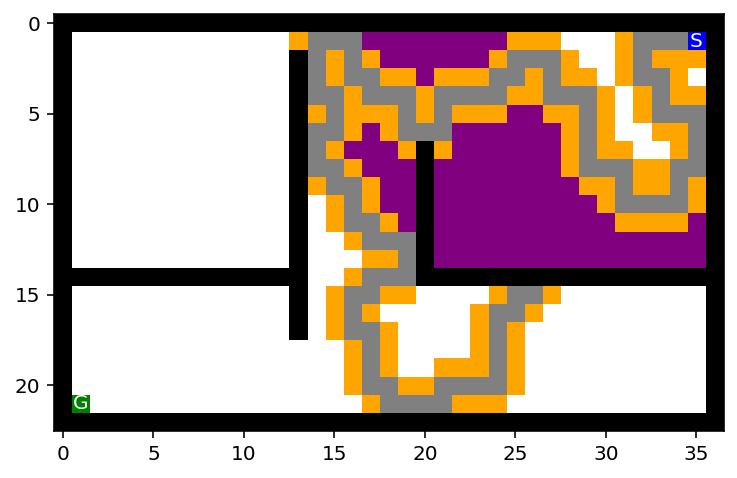

Node - pos = (15, 27); parent = <__main__.Node object at 0x7f100b18cc10>; action = East; cost = 100


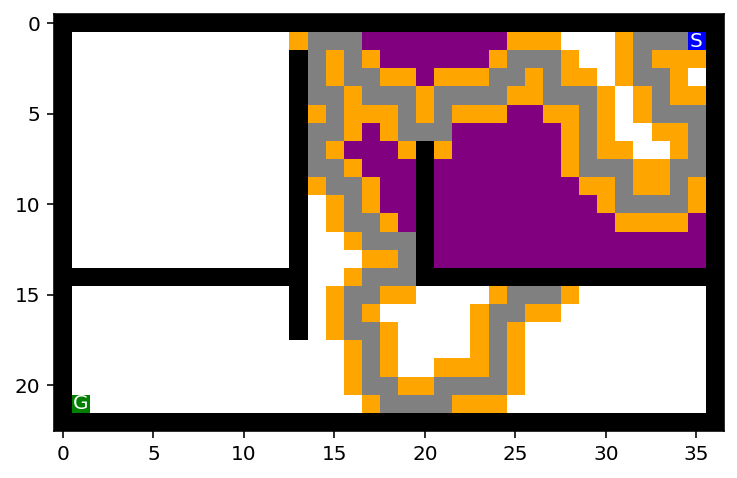

Node - pos = (15, 28); parent = <__main__.Node object at 0x7f100af38fd0>; action = East; cost = 101


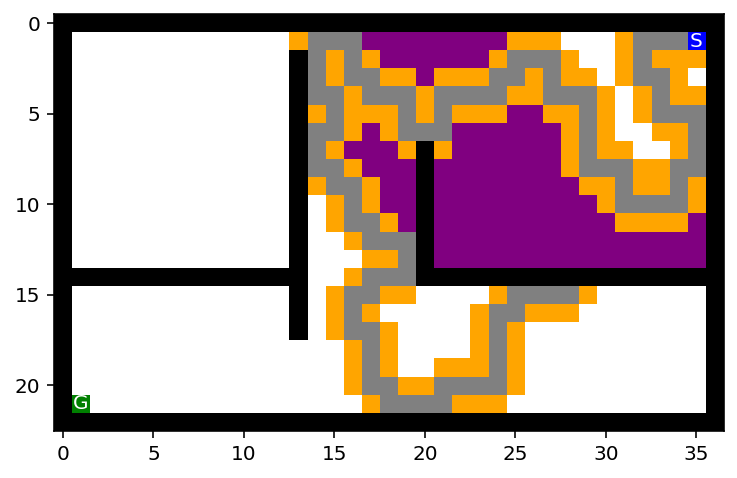

Node - pos = (15, 29); parent = <__main__.Node object at 0x7f100b0854f0>; action = East; cost = 102


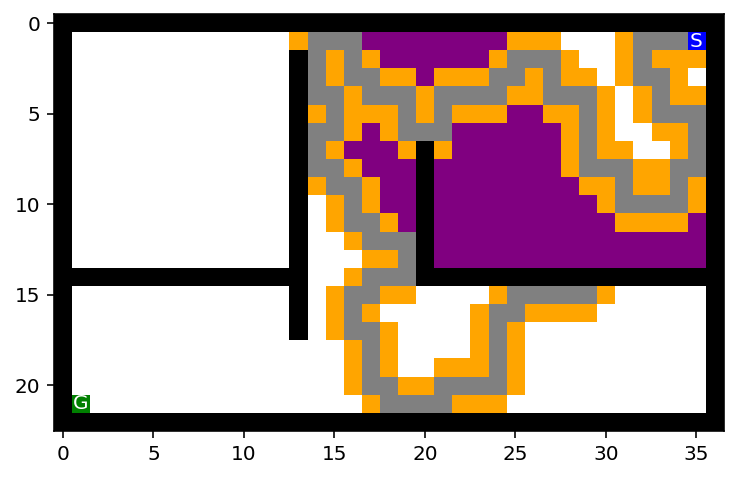

Node - pos = (16, 29); parent = <__main__.Node object at 0x7f100addba90>; action = South; cost = 103


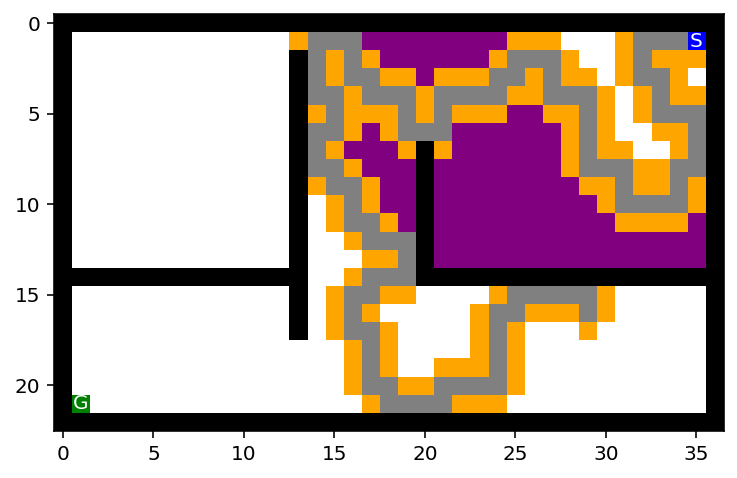

Node - pos = (17, 29); parent = <__main__.Node object at 0x7f100ae30970>; action = South; cost = 104


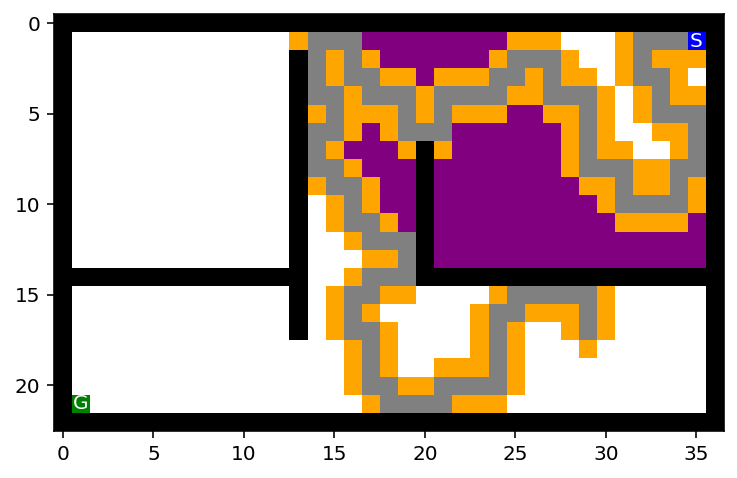

Node - pos = (18, 29); parent = <__main__.Node object at 0x7f100b104e80>; action = South; cost = 105


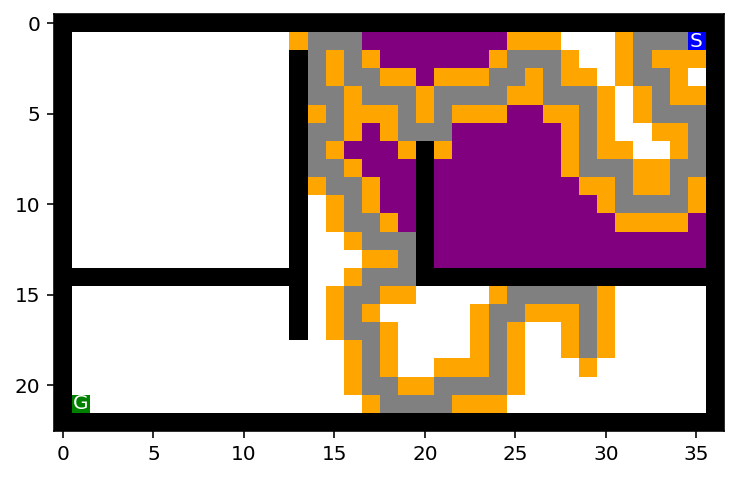

Node - pos = (19, 29); parent = <__main__.Node object at 0x7f100ae177f0>; action = South; cost = 106


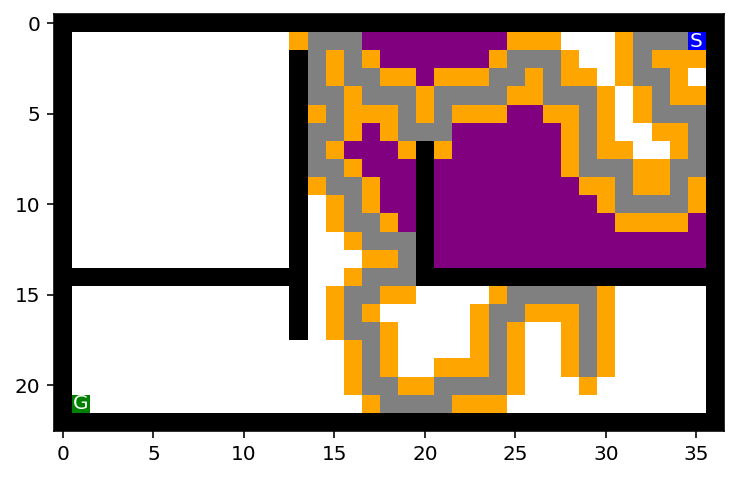

Node - pos = (20, 29); parent = <__main__.Node object at 0x7f100af23940>; action = South; cost = 107


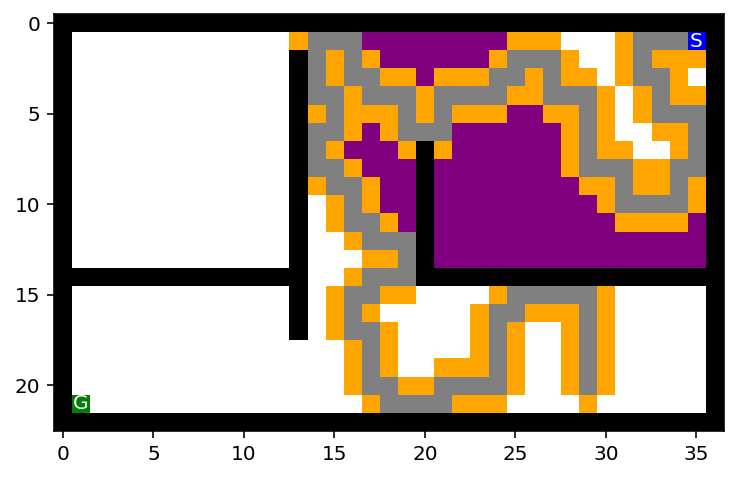

Node - pos = (21, 29); parent = <__main__.Node object at 0x7f100ad8d880>; action = South; cost = 108


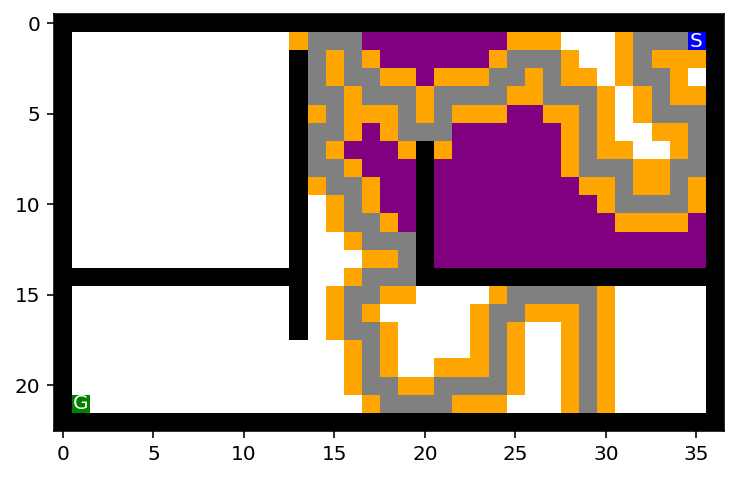

Node - pos = (21, 28); parent = <__main__.Node object at 0x7f100af1cd30>; action = West; cost = 109


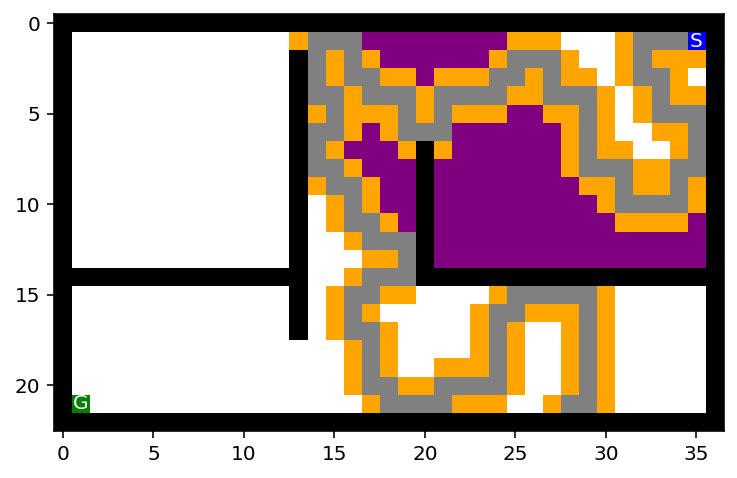

Node - pos = (21, 27); parent = <__main__.Node object at 0x7f100b006730>; action = West; cost = 110


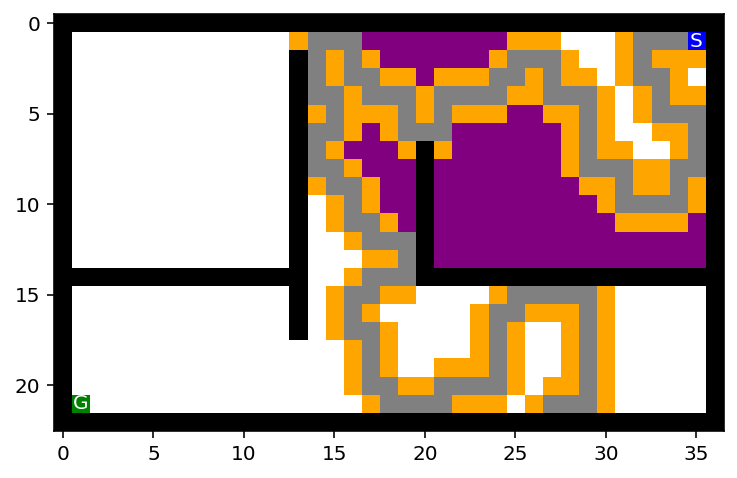

Node - pos = (21, 26); parent = <__main__.Node object at 0x7f100adcee80>; action = West; cost = 111


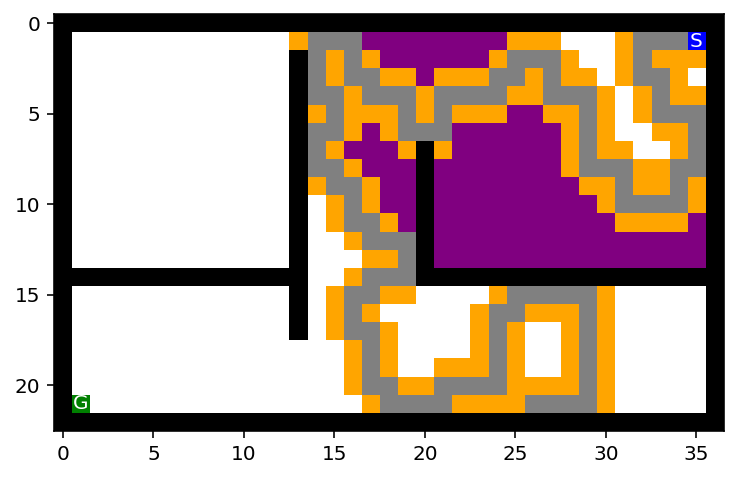

Node - pos = (21, 25); parent = <__main__.Node object at 0x7f100b1bcbb0>; action = West; cost = 112


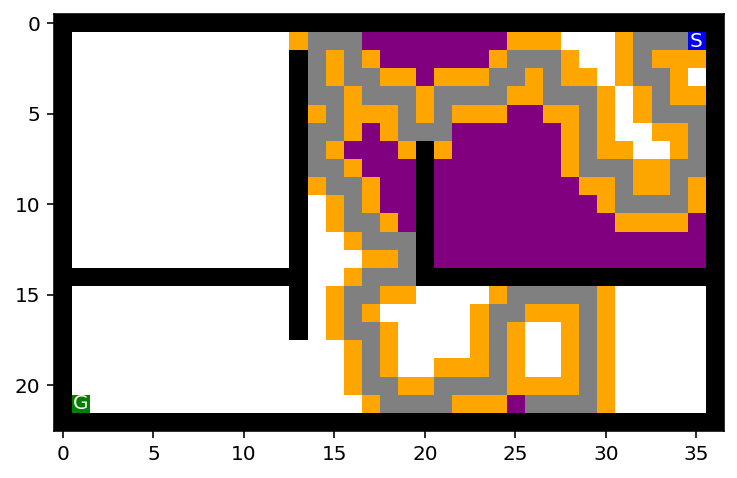

Node - pos = (20, 26); parent = <__main__.Node object at 0x7f100b1bcbb0>; action = North; cost = 112


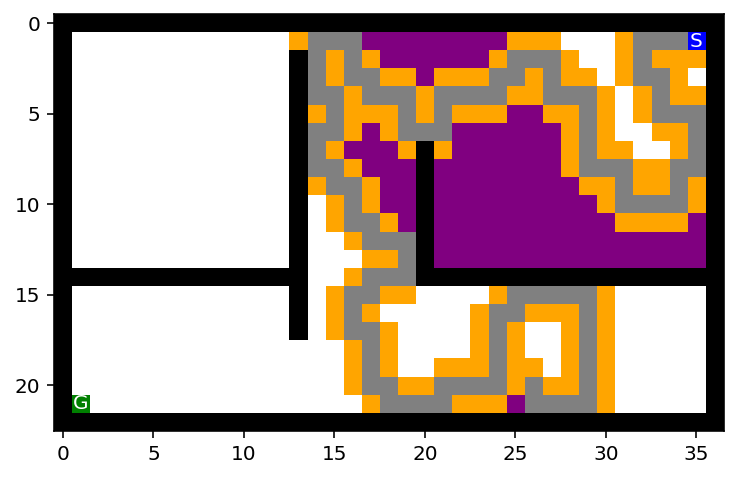

Node - pos = (19, 26); parent = <__main__.Node object at 0x7f100ad769a0>; action = North; cost = 113


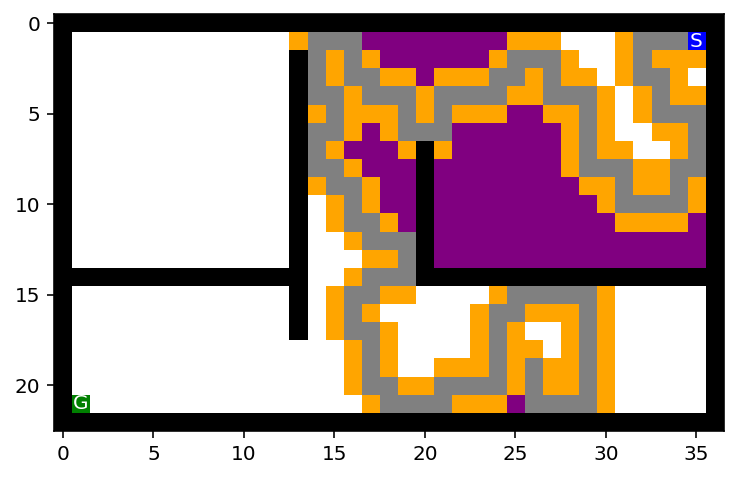

Node - pos = (18, 26); parent = <__main__.Node object at 0x7f100b14a4f0>; action = North; cost = 114


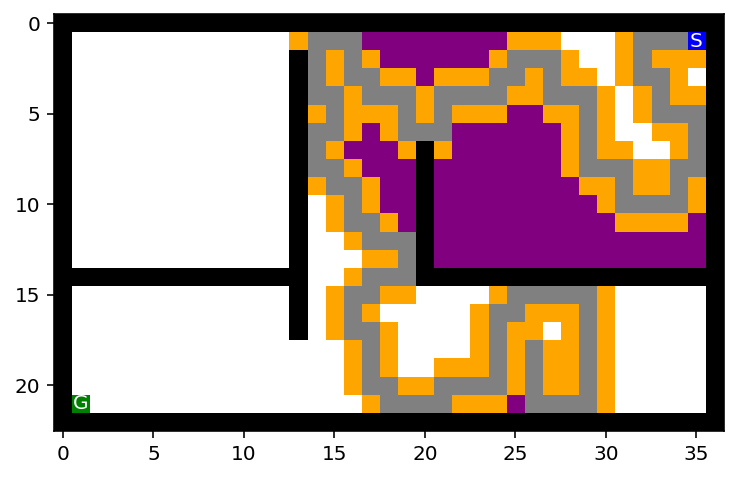

Node - pos = (18, 27); parent = <__main__.Node object at 0x7f100add1eb0>; action = East; cost = 115


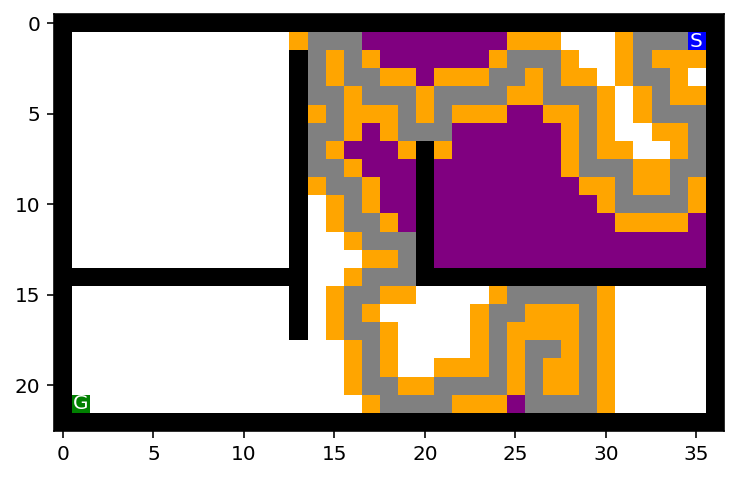

Node - pos = (17, 27); parent = <__main__.Node object at 0x7f100b054eb0>; action = North; cost = 116


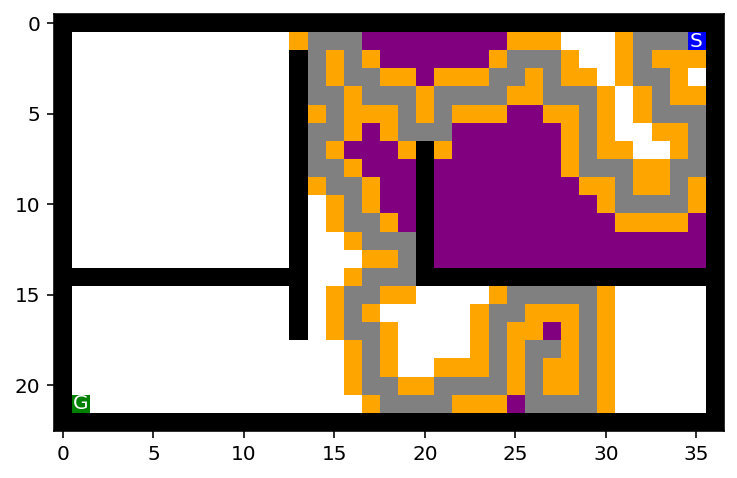

Node - pos = (18, 27); parent = <__main__.Node object at 0x7f100add1eb0>; action = East; cost = 115


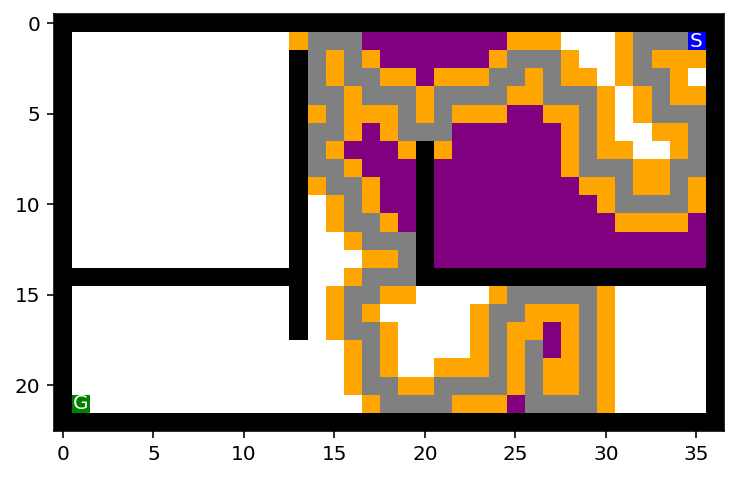

Node - pos = (17, 26); parent = <__main__.Node object at 0x7f100add1eb0>; action = North; cost = 115


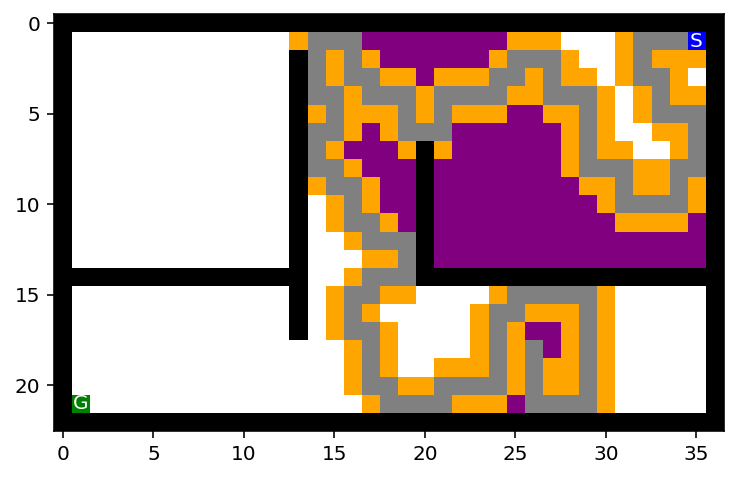

Node - pos = (18, 26); parent = <__main__.Node object at 0x7f100b14a4f0>; action = North; cost = 114


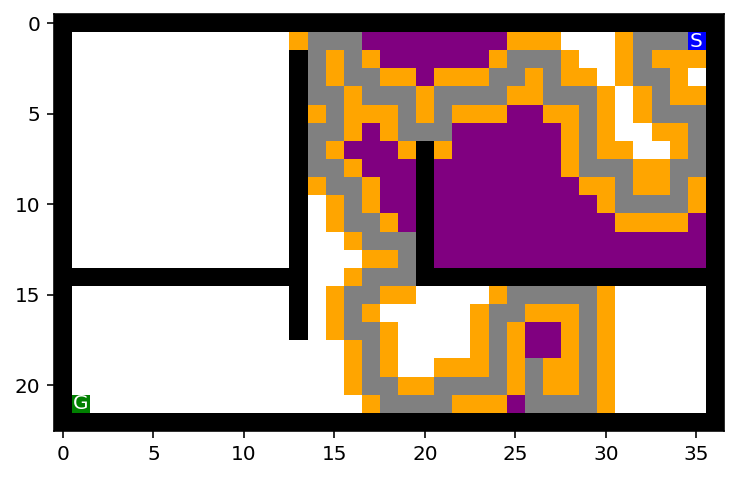

Node - pos = (19, 27); parent = <__main__.Node object at 0x7f100b14a4f0>; action = East; cost = 114


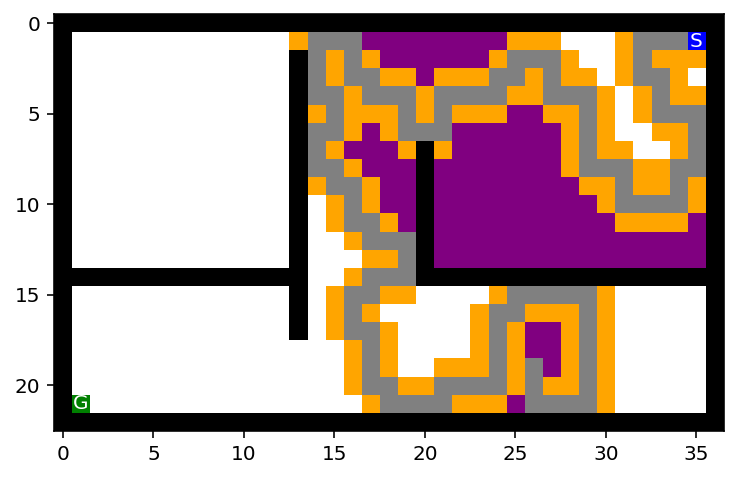

Node - pos = (19, 26); parent = <__main__.Node object at 0x7f100ad769a0>; action = North; cost = 113


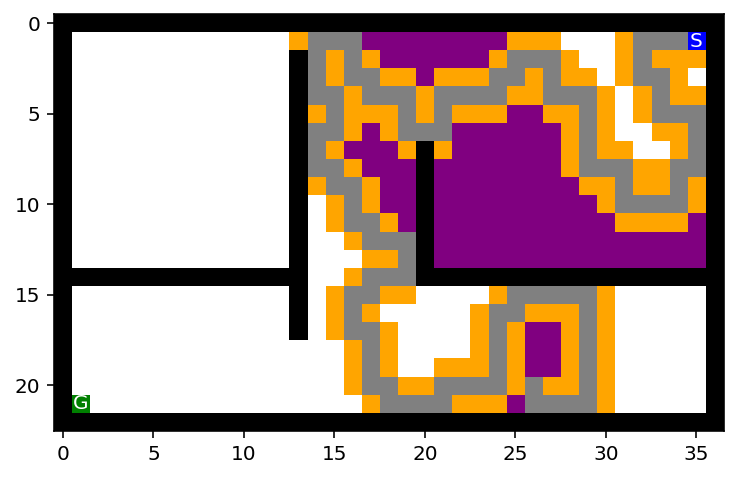

Node - pos = (20, 26); parent = <__main__.Node object at 0x7f100b1bcbb0>; action = North; cost = 112


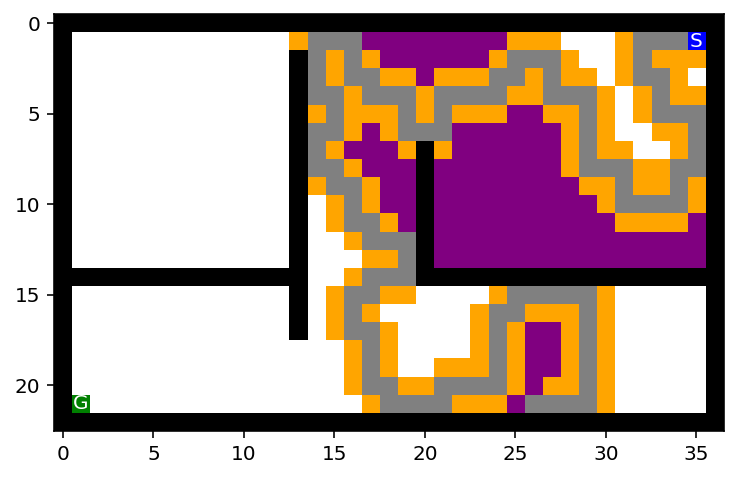

Node - pos = (21, 26); parent = <__main__.Node object at 0x7f100adcee80>; action = West; cost = 111


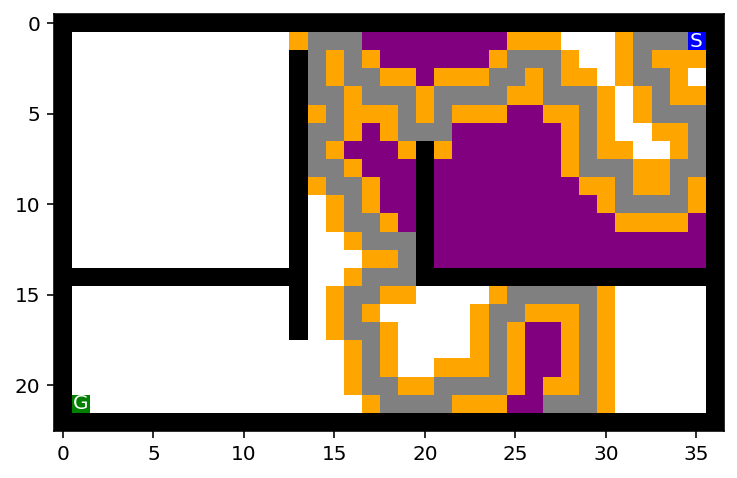

Node - pos = (20, 27); parent = <__main__.Node object at 0x7f100adcee80>; action = North; cost = 111


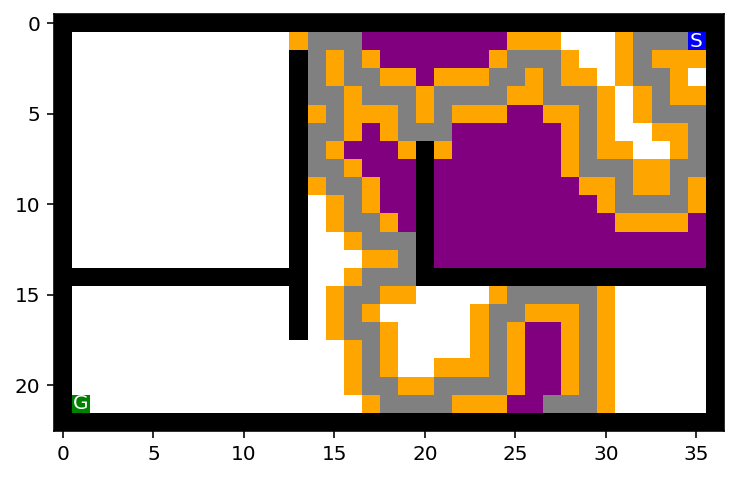

Node - pos = (21, 27); parent = <__main__.Node object at 0x7f100b006730>; action = West; cost = 110


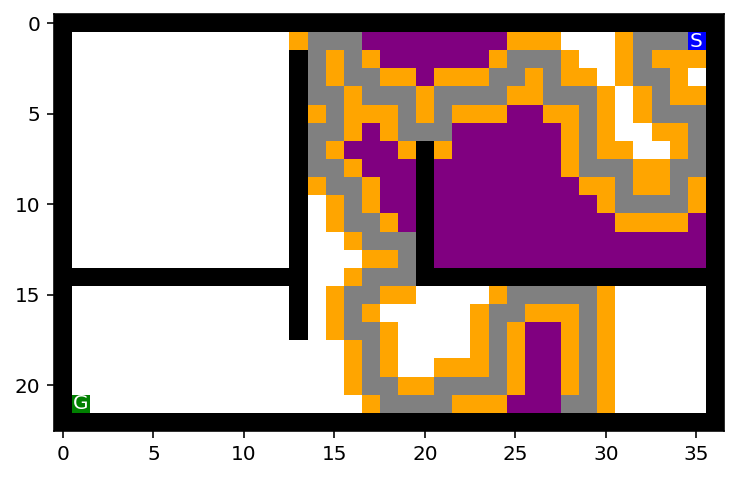

Node - pos = (21, 28); parent = <__main__.Node object at 0x7f100af1cd30>; action = West; cost = 109


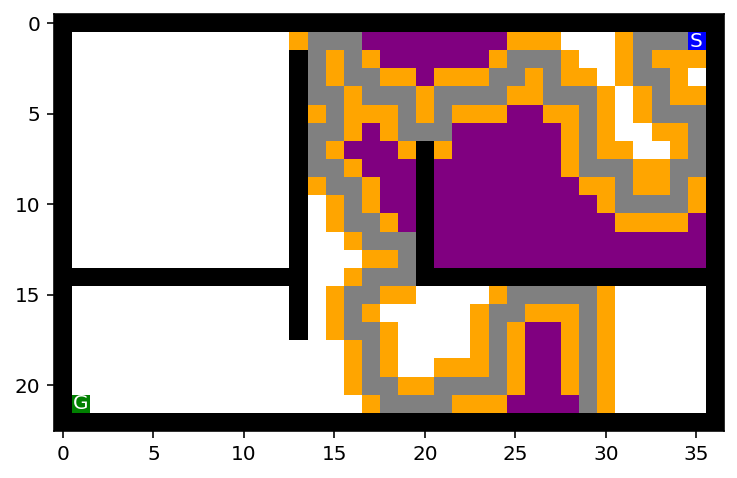

Node - pos = (21, 30); parent = <__main__.Node object at 0x7f100af1cd30>; action = East; cost = 109


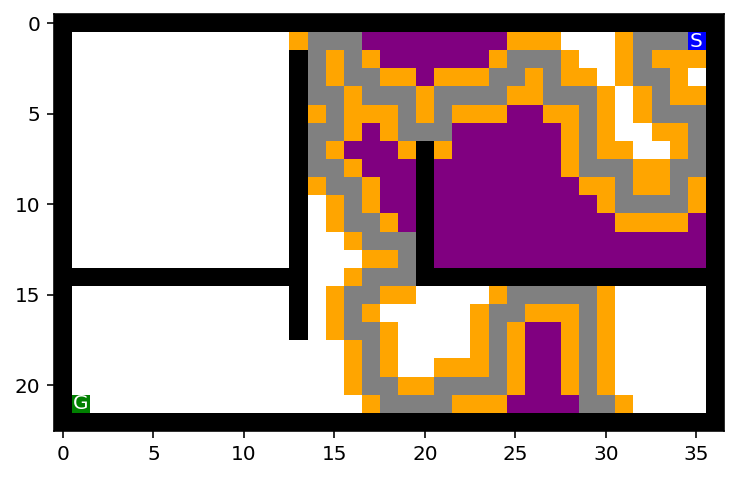

Node - pos = (21, 31); parent = <__main__.Node object at 0x7f100b0069d0>; action = East; cost = 110


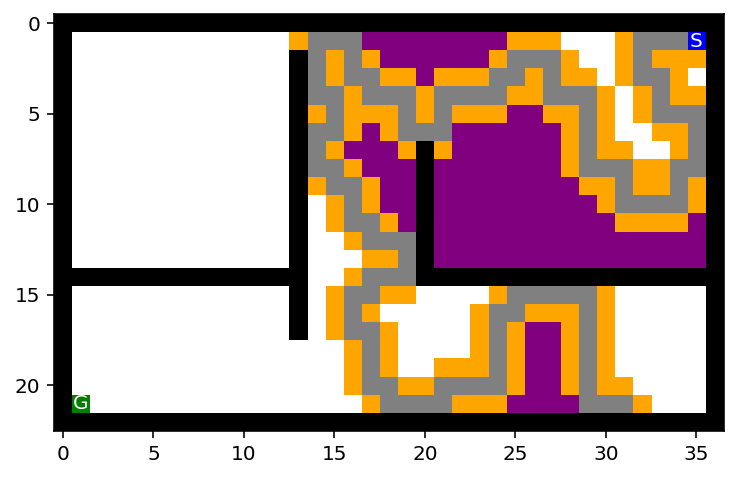

Node - pos = (20, 31); parent = <__main__.Node object at 0x7f100adce370>; action = North; cost = 111


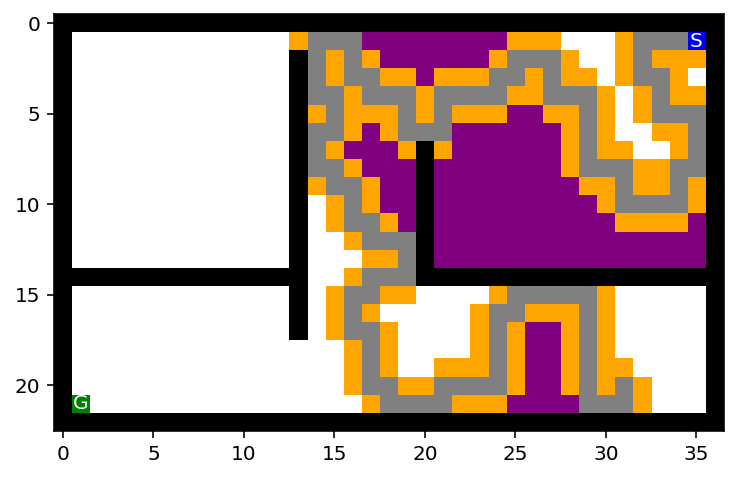

Node - pos = (20, 32); parent = <__main__.Node object at 0x7f100af164f0>; action = East; cost = 112


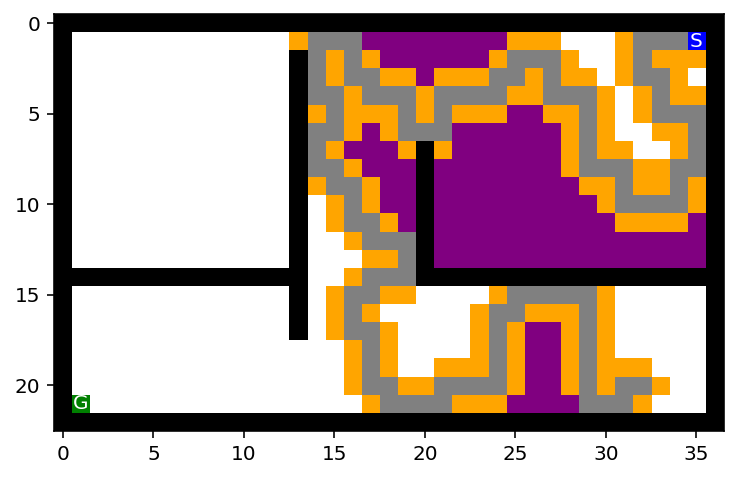

Node - pos = (20, 33); parent = <__main__.Node object at 0x7f100aefafa0>; action = East; cost = 113


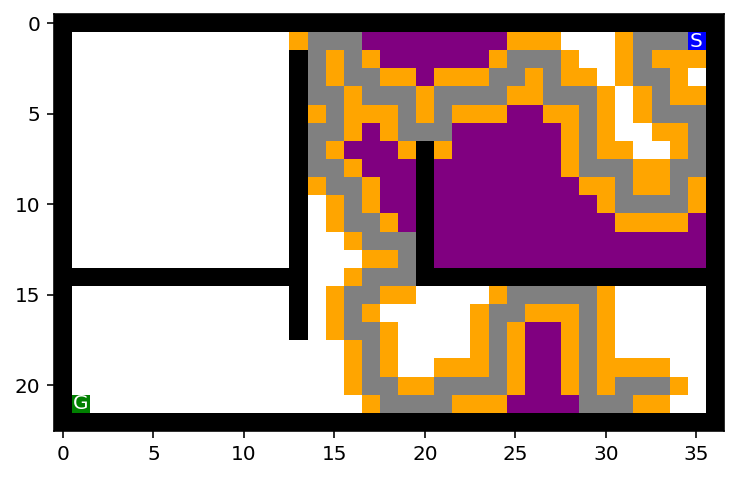

Node - pos = (19, 33); parent = <__main__.Node object at 0x7f100ad607c0>; action = North; cost = 114


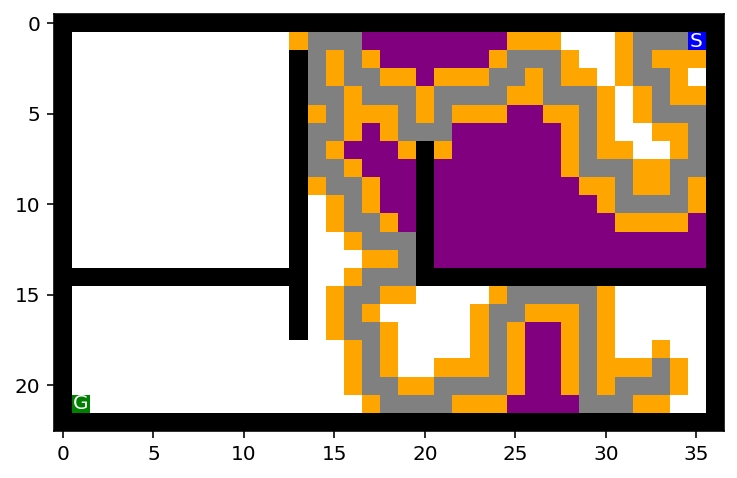

Node - pos = (19, 34); parent = <__main__.Node object at 0x7f100ae52850>; action = East; cost = 115


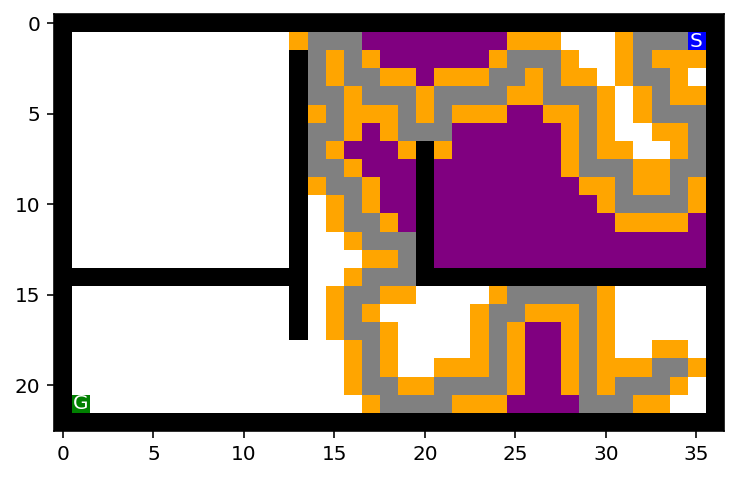

Node - pos = (19, 35); parent = <__main__.Node object at 0x7f102867cac0>; action = East; cost = 116


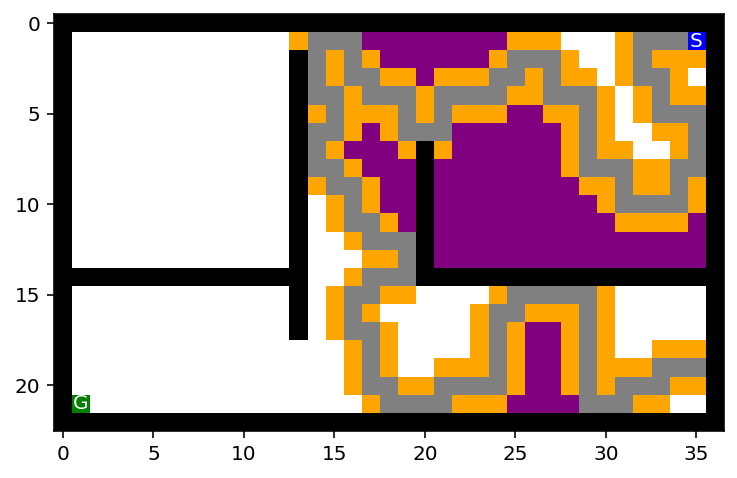

Node - pos = (20, 35); parent = <__main__.Node object at 0x7f100aee6730>; action = South; cost = 117


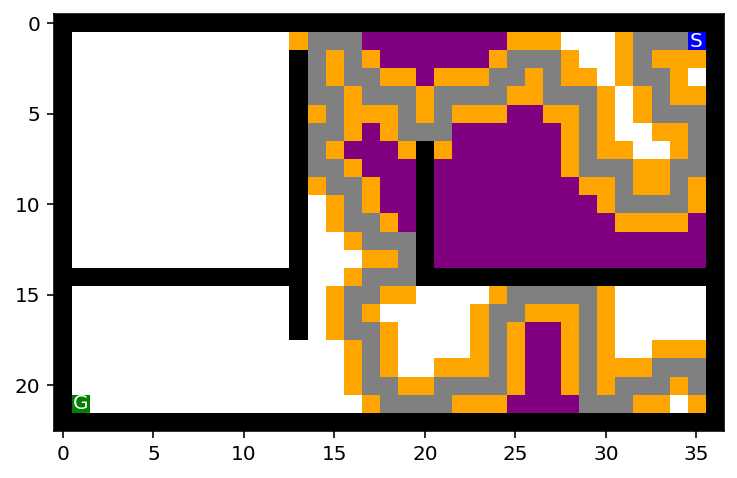

Node - pos = (21, 35); parent = <__main__.Node object at 0x7f100ae6c0a0>; action = South; cost = 118


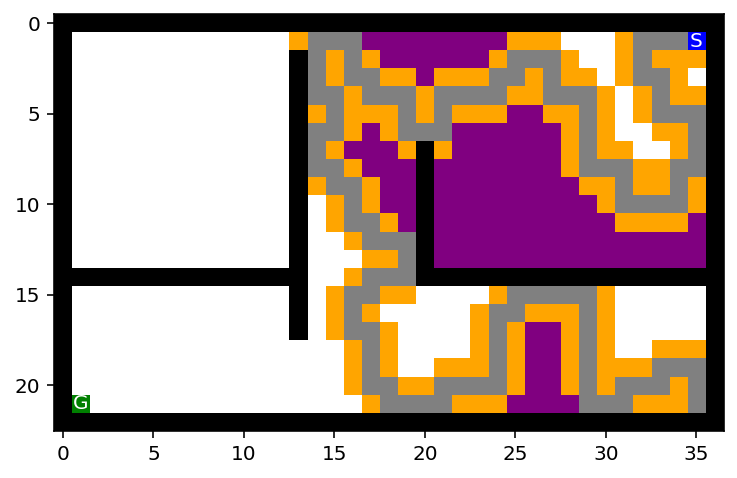

Node - pos = (21, 34); parent = <__main__.Node object at 0x7f100b1162b0>; action = West; cost = 119


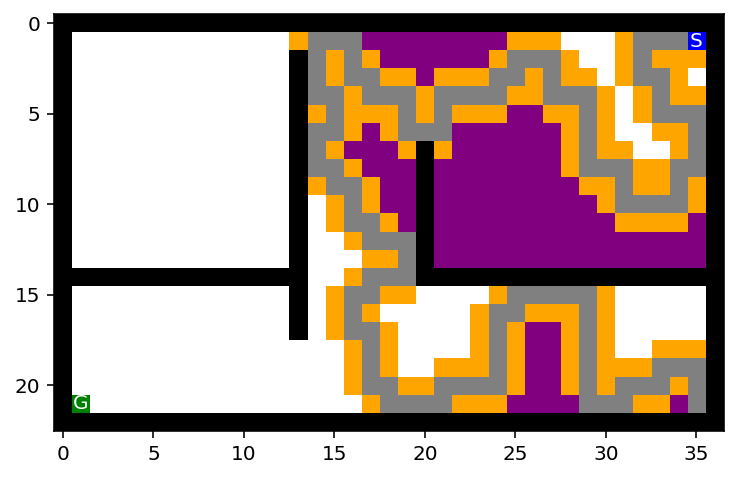

Node - pos = (21, 35); parent = <__main__.Node object at 0x7f100ae6c0a0>; action = South; cost = 118


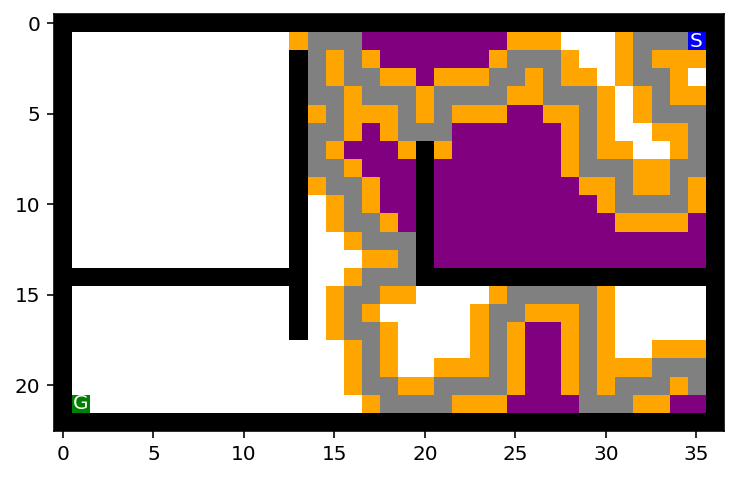

Node - pos = (20, 35); parent = <__main__.Node object at 0x7f100aee6730>; action = South; cost = 117


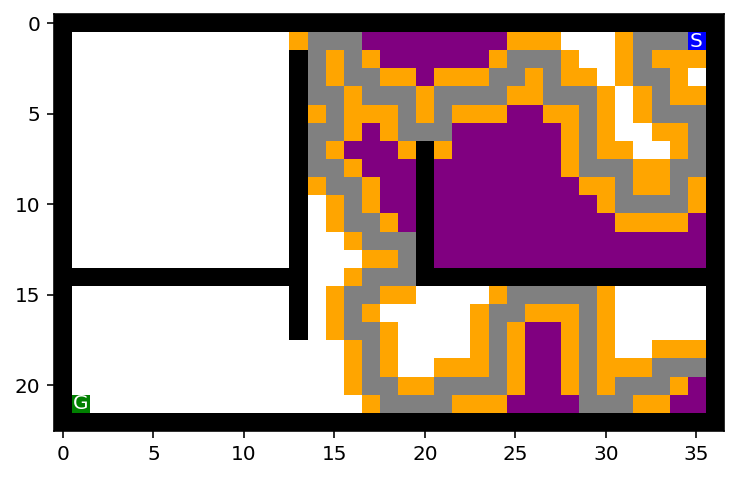

Node - pos = (18, 35); parent = <__main__.Node object at 0x7f100aee6730>; action = North; cost = 117


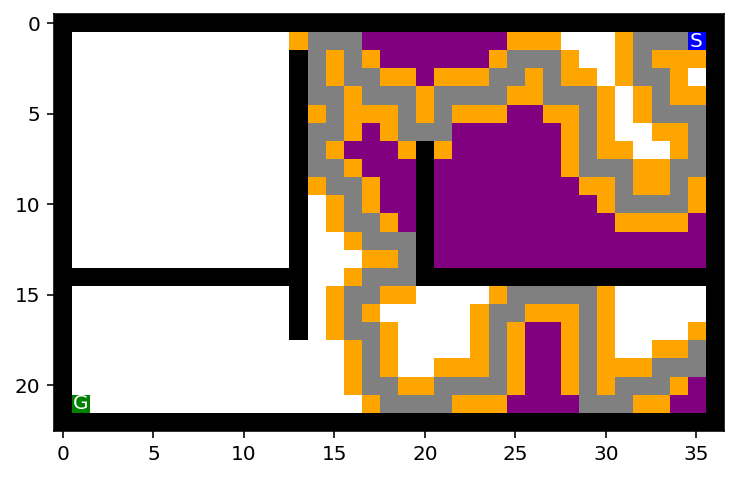

Node - pos = (17, 35); parent = <__main__.Node object at 0x7f100ae6cf40>; action = North; cost = 118


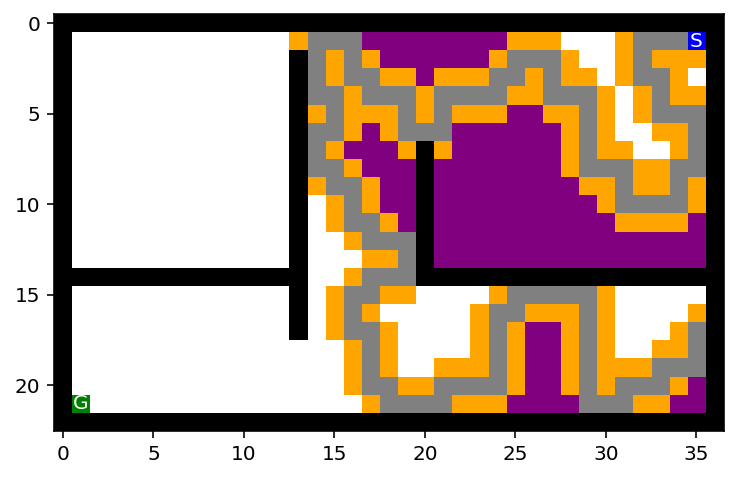

Node - pos = (17, 34); parent = <__main__.Node object at 0x7f100b1164c0>; action = West; cost = 119


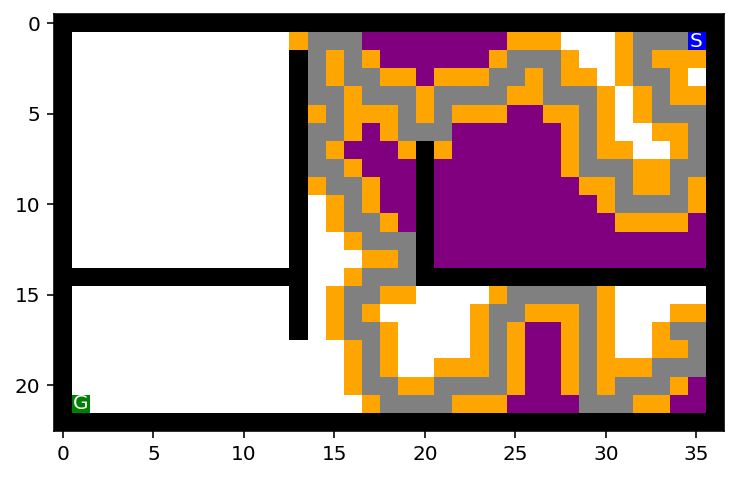

Node - pos = (16, 34); parent = <__main__.Node object at 0x7f100af0c7c0>; action = North; cost = 120


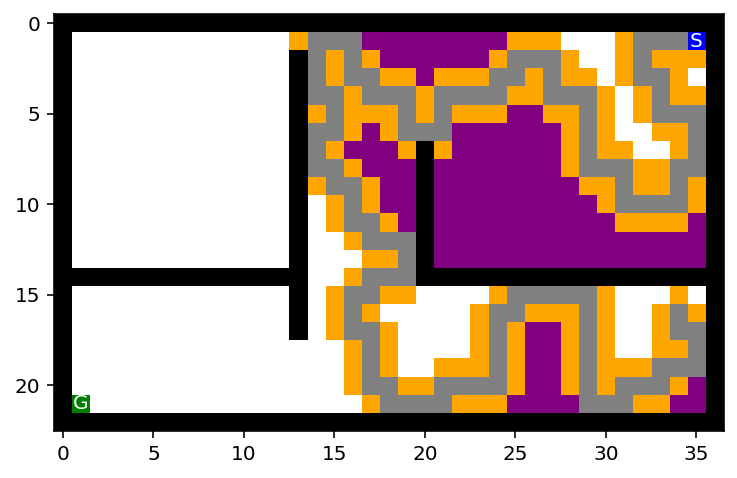

Node - pos = (15, 34); parent = <__main__.Node object at 0x7f100b23b400>; action = North; cost = 121


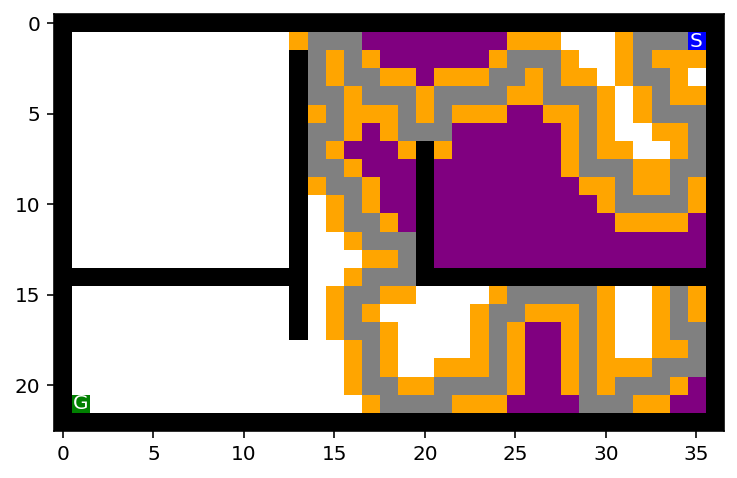

Node - pos = (15, 35); parent = <__main__.Node object at 0x7f100ae6c4c0>; action = East; cost = 122


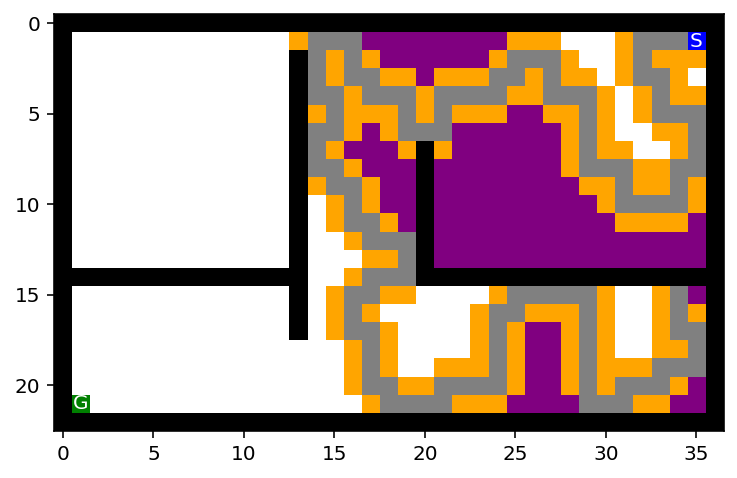

Node - pos = (15, 33); parent = <__main__.Node object at 0x7f100ae6c4c0>; action = West; cost = 122


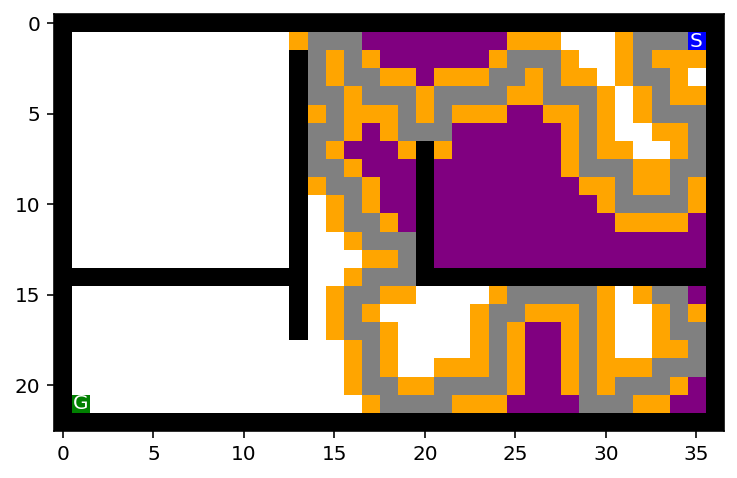

Node - pos = (15, 32); parent = <__main__.Node object at 0x7f100ae09460>; action = West; cost = 123


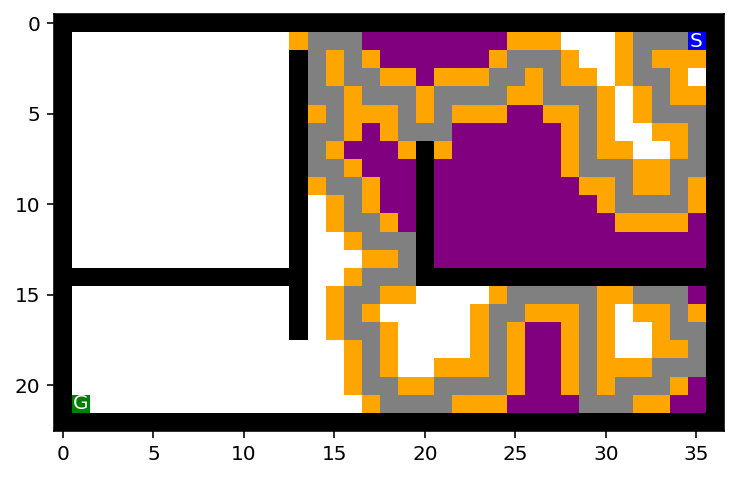

Node - pos = (15, 31); parent = <__main__.Node object at 0x7f100ada82e0>; action = West; cost = 124


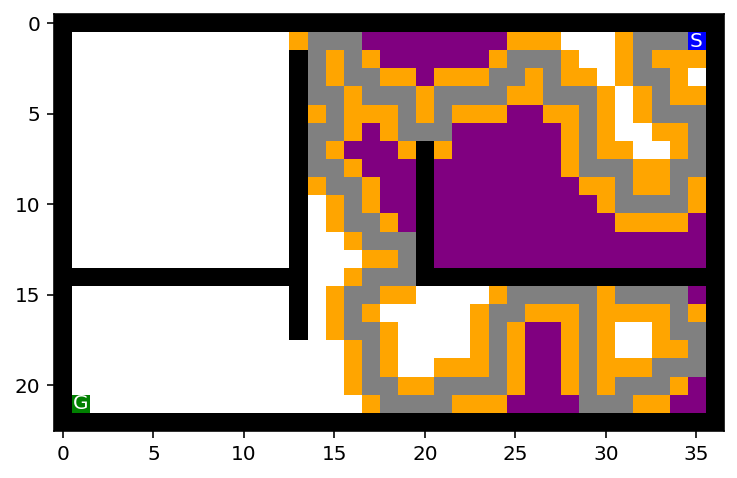

Node - pos = (16, 31); parent = <__main__.Node object at 0x7f100b1c8400>; action = South; cost = 125


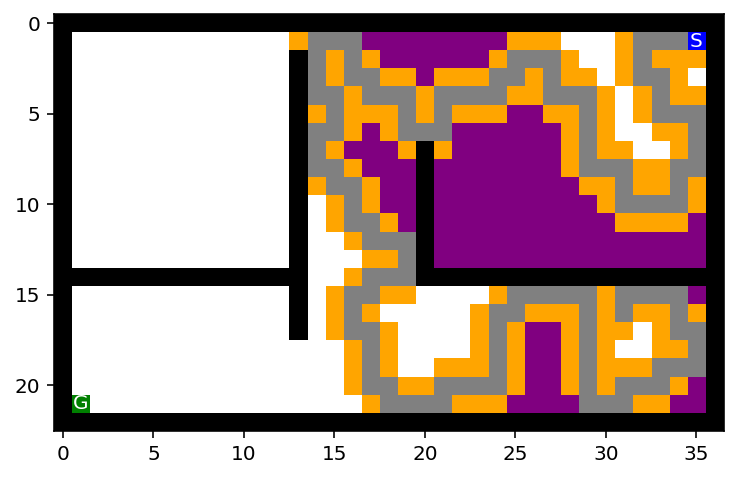

Node - pos = (17, 31); parent = <__main__.Node object at 0x7f100b14af40>; action = South; cost = 126


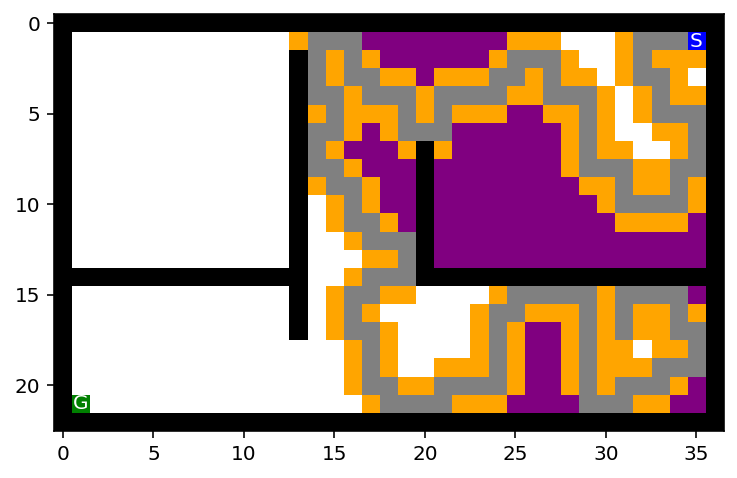

Node - pos = (18, 31); parent = <__main__.Node object at 0x7f100b221610>; action = South; cost = 127


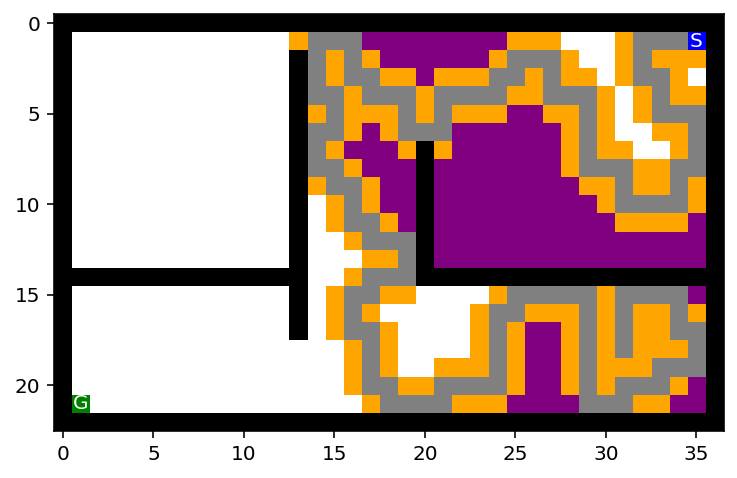

Node - pos = (18, 32); parent = <__main__.Node object at 0x7f100b15e970>; action = East; cost = 128


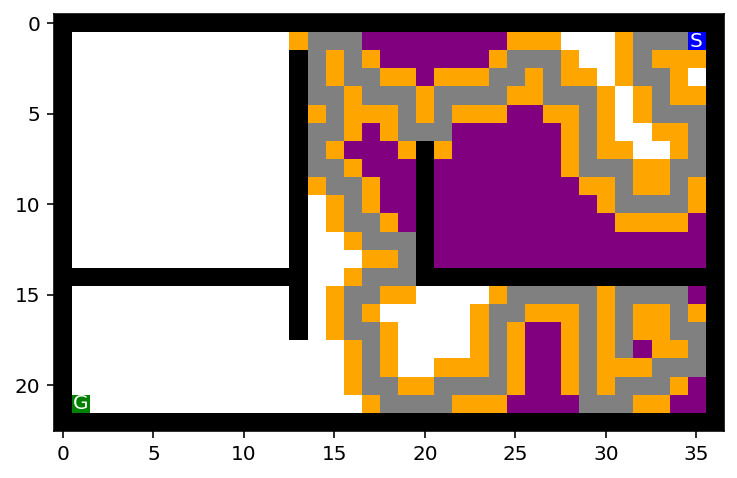

Node - pos = (18, 31); parent = <__main__.Node object at 0x7f100b221610>; action = South; cost = 127


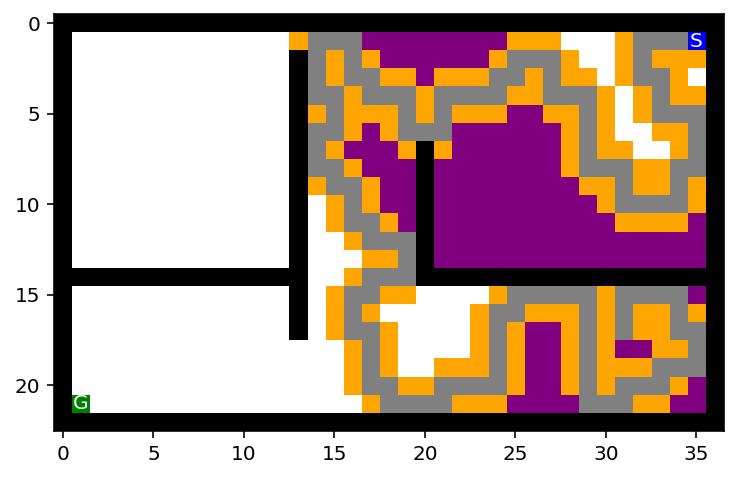

Node - pos = (17, 32); parent = <__main__.Node object at 0x7f100b221610>; action = East; cost = 127


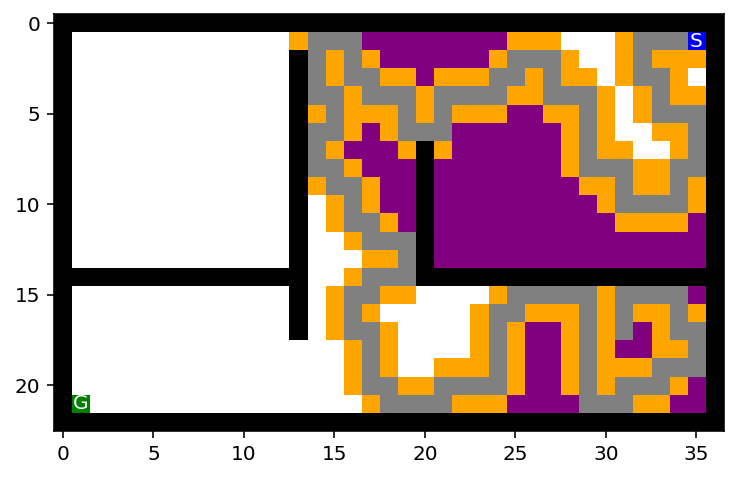

Node - pos = (17, 31); parent = <__main__.Node object at 0x7f100b14af40>; action = South; cost = 126


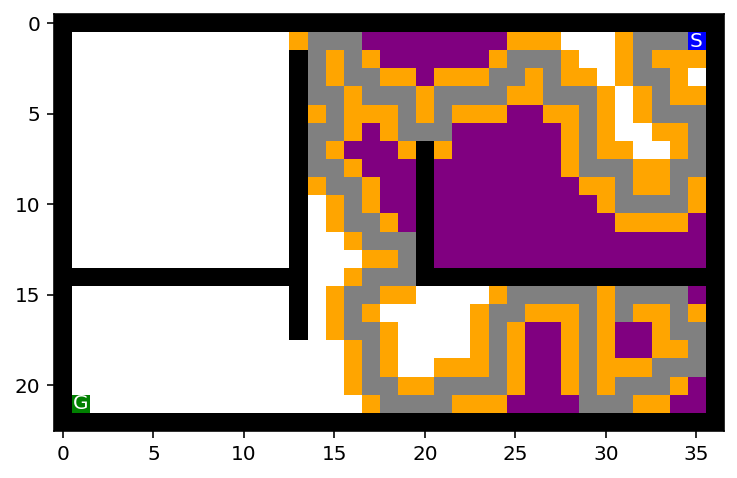

Node - pos = (16, 31); parent = <__main__.Node object at 0x7f100b1c8400>; action = South; cost = 125


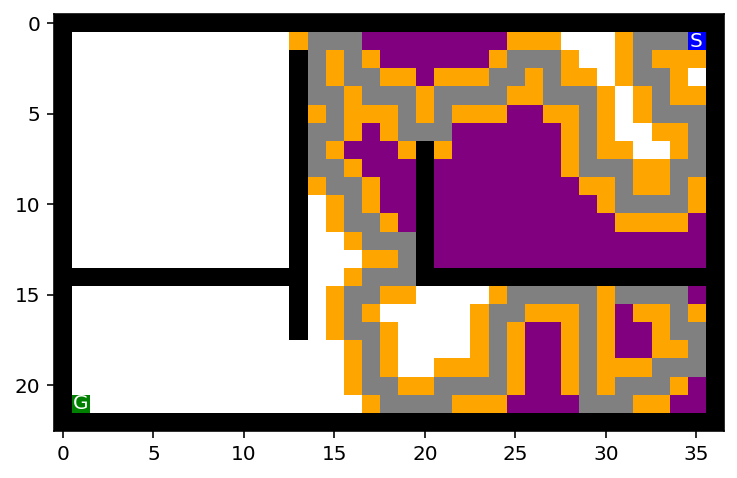

Node - pos = (15, 31); parent = <__main__.Node object at 0x7f100ada82e0>; action = West; cost = 124


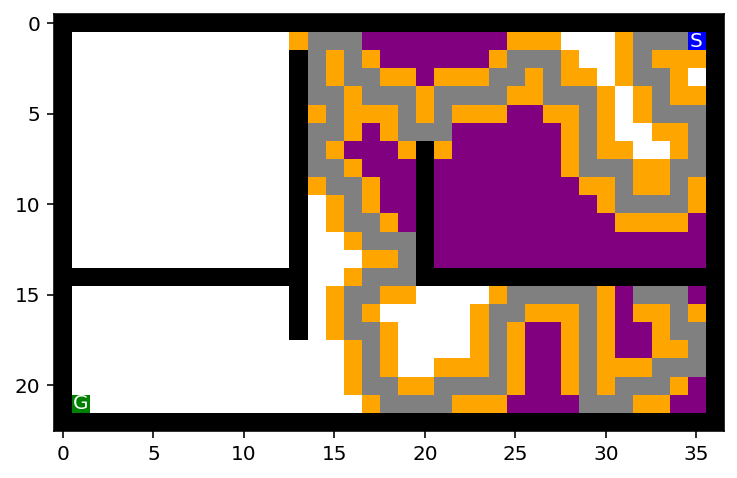

Node - pos = (16, 32); parent = <__main__.Node object at 0x7f100ada82e0>; action = South; cost = 124


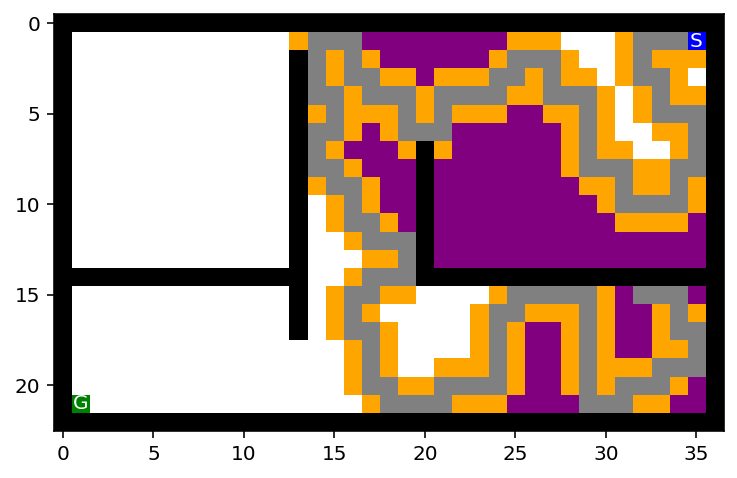

Node - pos = (15, 32); parent = <__main__.Node object at 0x7f100ae09460>; action = West; cost = 123


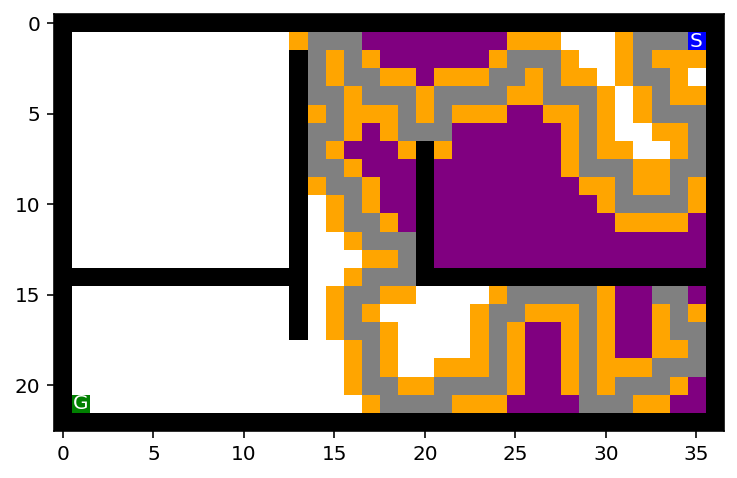

Node - pos = (15, 33); parent = <__main__.Node object at 0x7f100ae6c4c0>; action = West; cost = 122


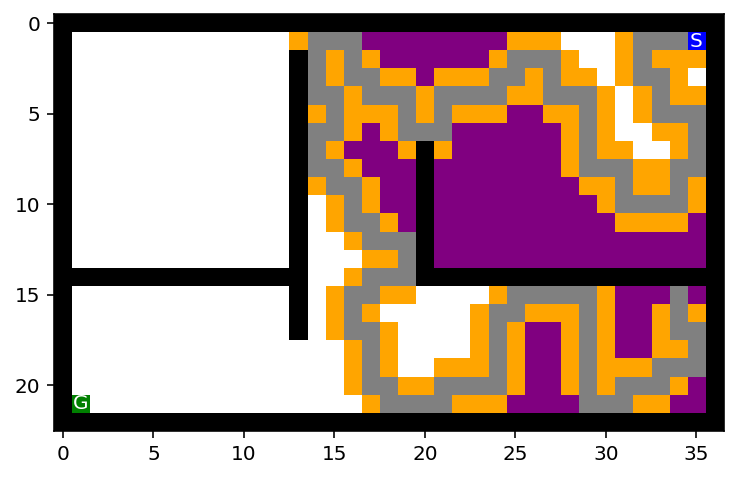

Node - pos = (15, 34); parent = <__main__.Node object at 0x7f100b23b400>; action = North; cost = 121


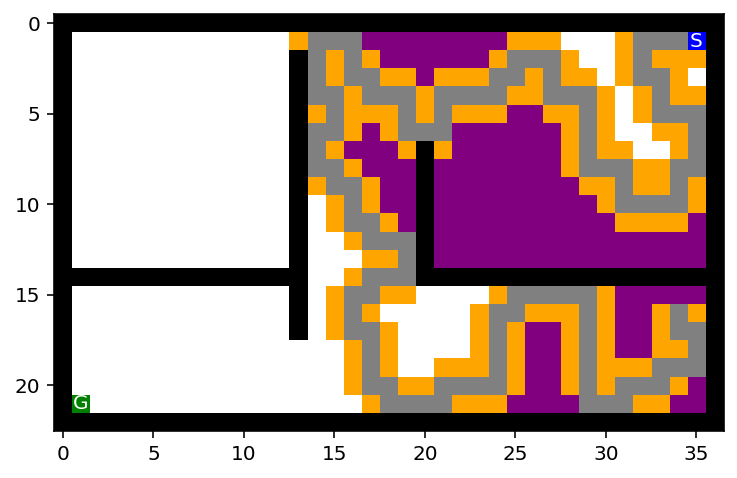

Node - pos = (16, 33); parent = <__main__.Node object at 0x7f100b23b400>; action = West; cost = 121


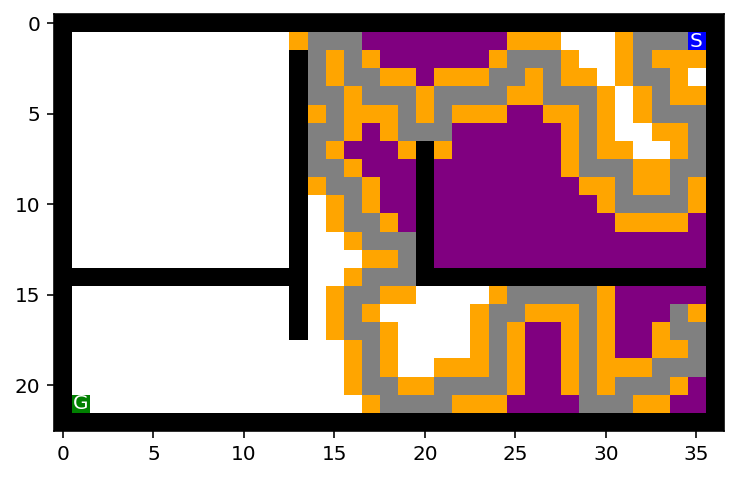

Node - pos = (16, 34); parent = <__main__.Node object at 0x7f100af0c7c0>; action = North; cost = 120


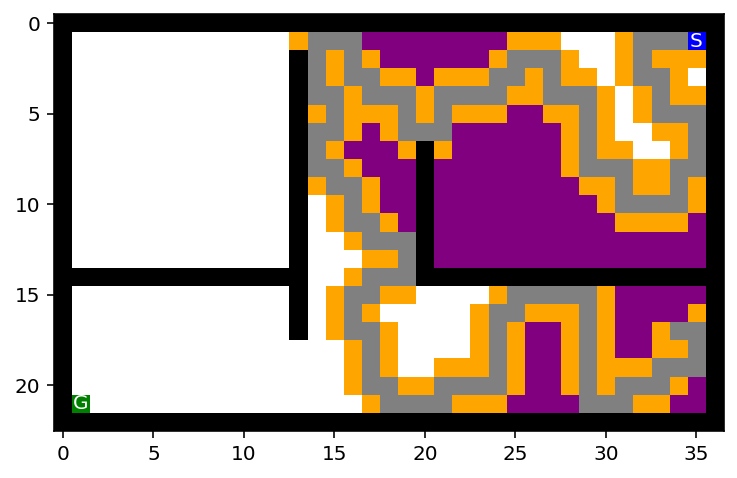

Node - pos = (17, 33); parent = <__main__.Node object at 0x7f100af0c7c0>; action = West; cost = 120


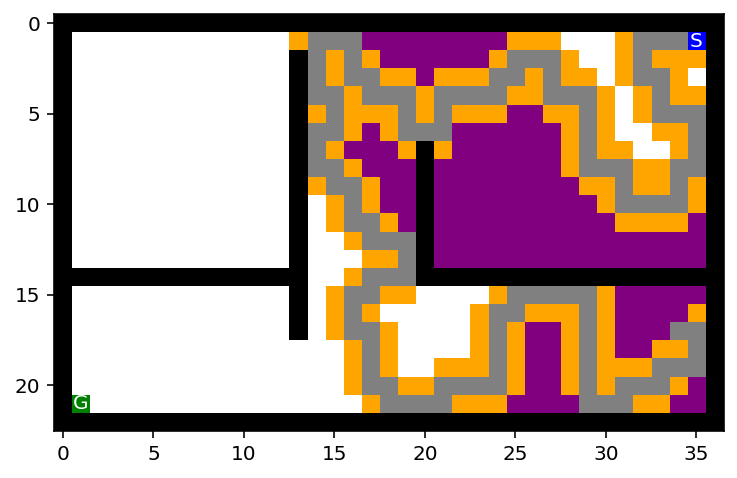

Node - pos = (17, 34); parent = <__main__.Node object at 0x7f100b1164c0>; action = West; cost = 119


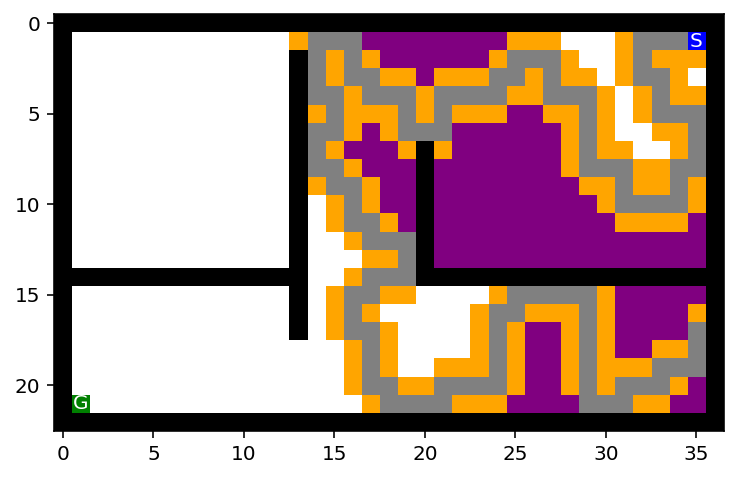

Node - pos = (16, 35); parent = <__main__.Node object at 0x7f100b1164c0>; action = North; cost = 119


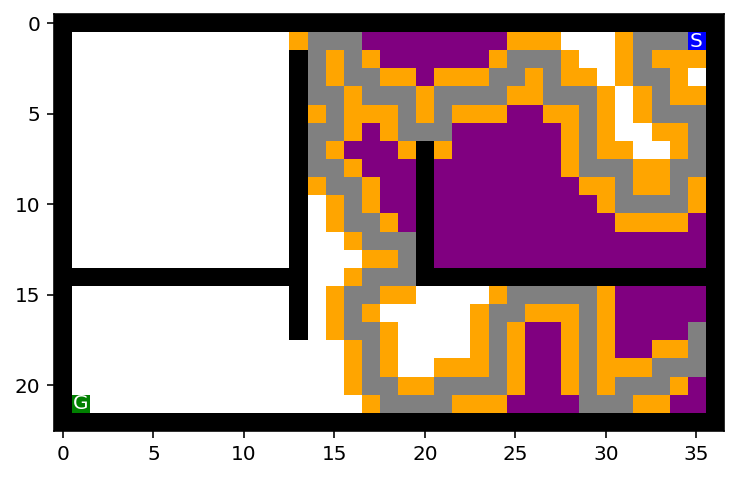

Node - pos = (17, 35); parent = <__main__.Node object at 0x7f100ae6cf40>; action = North; cost = 118


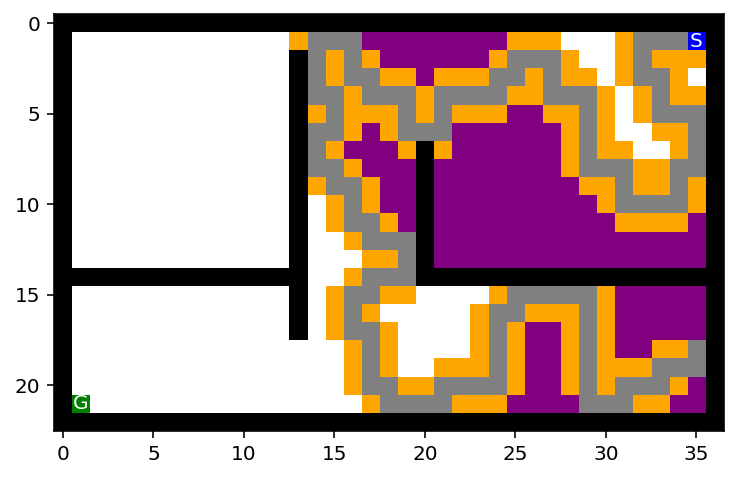

Node - pos = (18, 35); parent = <__main__.Node object at 0x7f100aee6730>; action = North; cost = 117


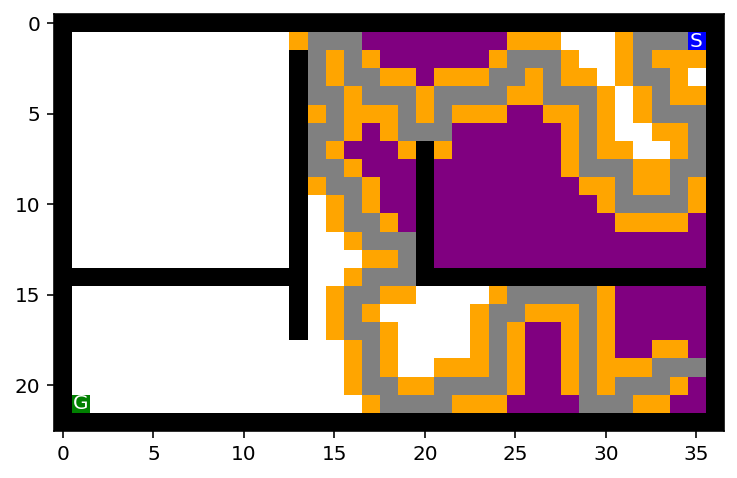

Node - pos = (19, 35); parent = <__main__.Node object at 0x7f102867cac0>; action = East; cost = 116


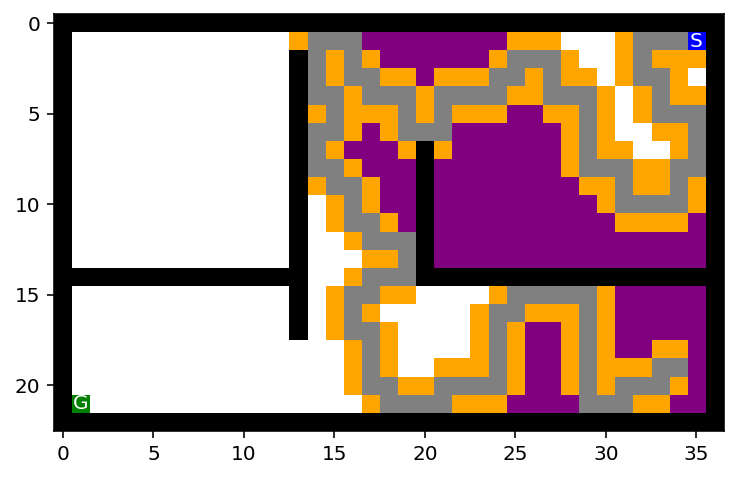

Node - pos = (18, 34); parent = <__main__.Node object at 0x7f102867cac0>; action = North; cost = 116


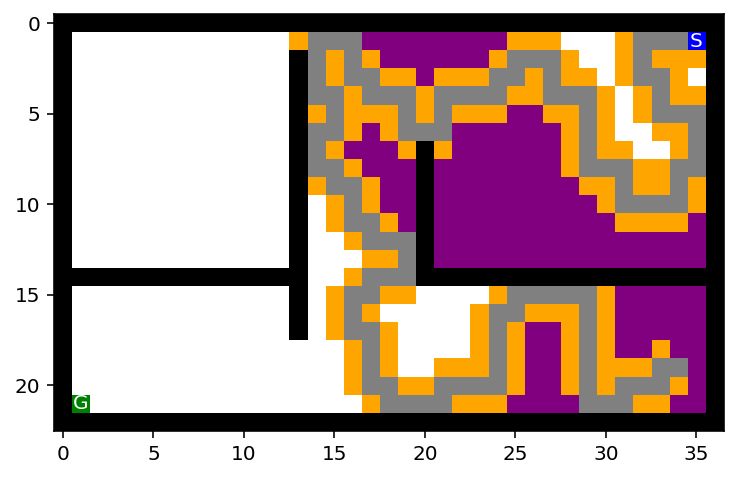

Node - pos = (19, 34); parent = <__main__.Node object at 0x7f100ae52850>; action = East; cost = 115


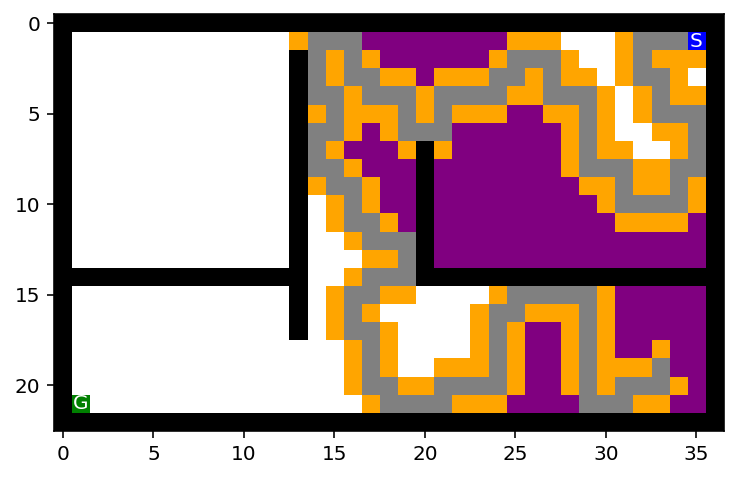

Node - pos = (18, 33); parent = <__main__.Node object at 0x7f100ae52850>; action = North; cost = 115


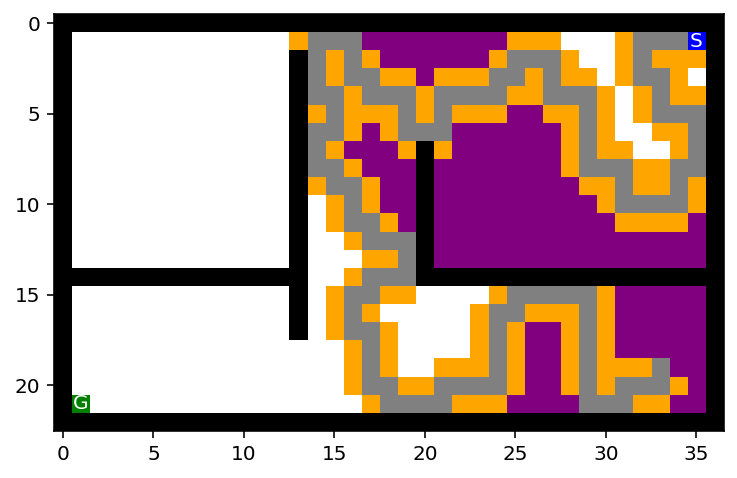

Node - pos = (19, 33); parent = <__main__.Node object at 0x7f100ad607c0>; action = North; cost = 114


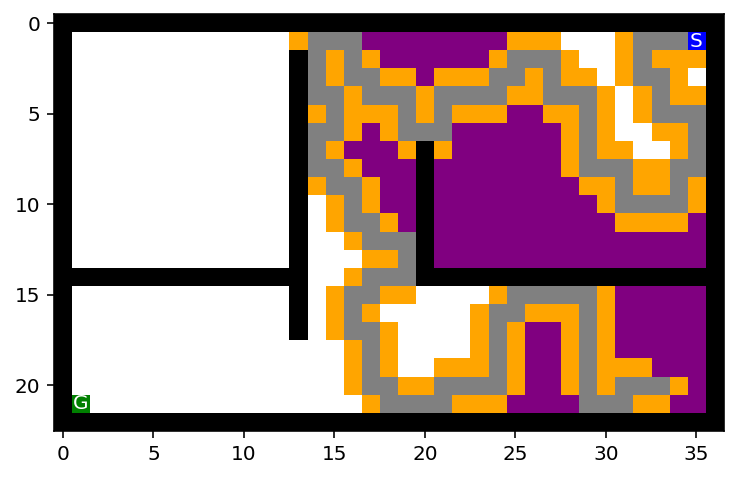

Node - pos = (21, 33); parent = <__main__.Node object at 0x7f100ad607c0>; action = South; cost = 114


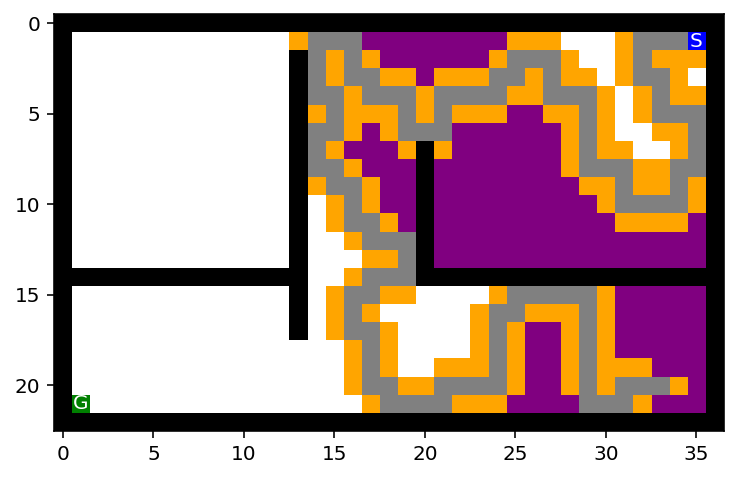

Node - pos = (20, 34); parent = <__main__.Node object at 0x7f100ad607c0>; action = East; cost = 114


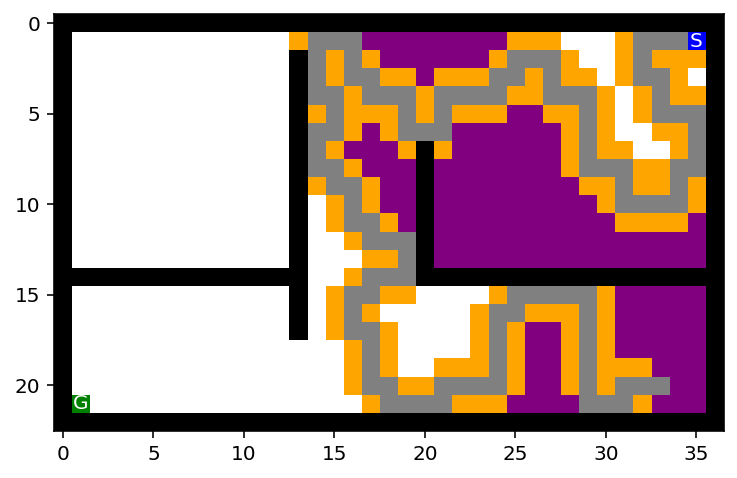

Node - pos = (20, 33); parent = <__main__.Node object at 0x7f100aefafa0>; action = East; cost = 113


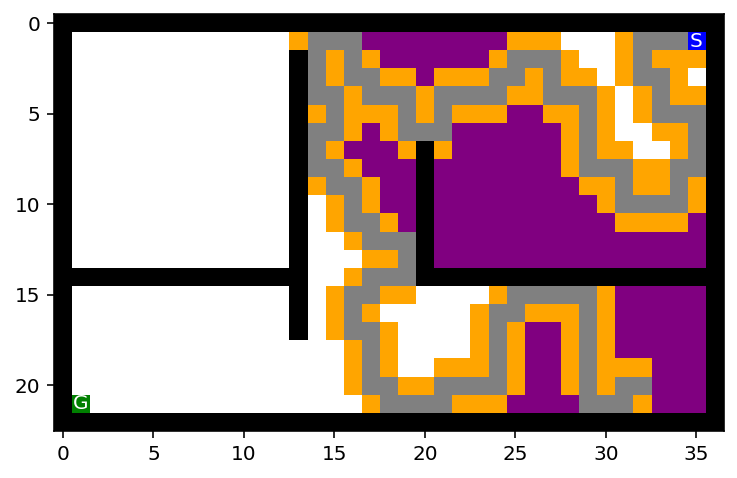

Node - pos = (19, 32); parent = <__main__.Node object at 0x7f100aefafa0>; action = North; cost = 113


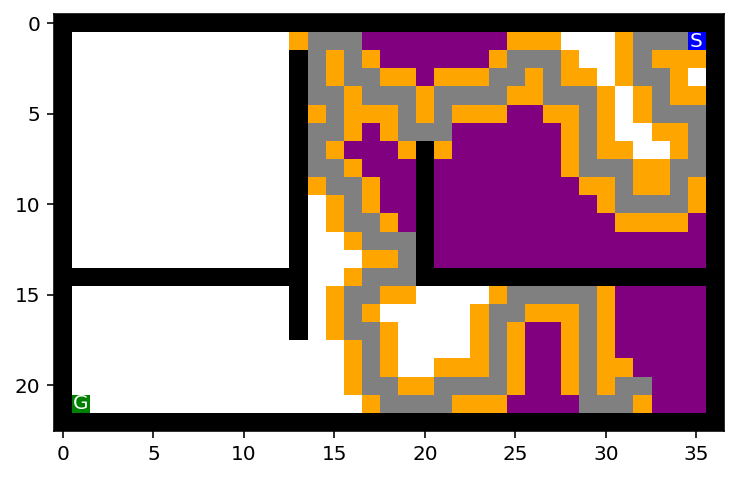

Node - pos = (20, 32); parent = <__main__.Node object at 0x7f100af164f0>; action = East; cost = 112


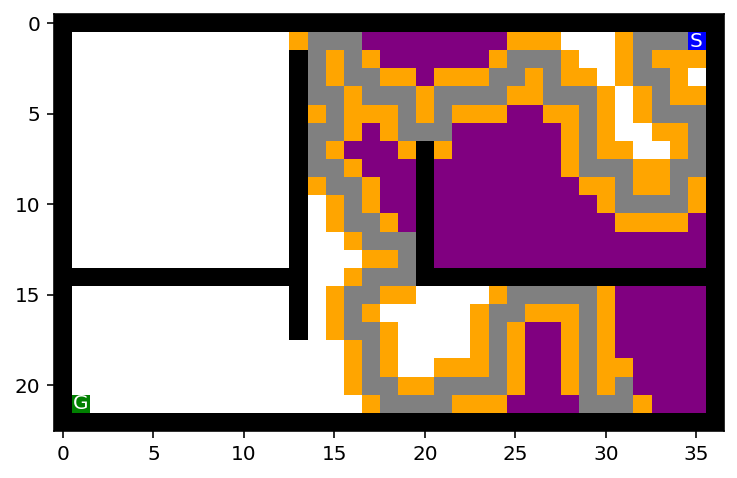

Node - pos = (19, 31); parent = <__main__.Node object at 0x7f100af164f0>; action = North; cost = 112


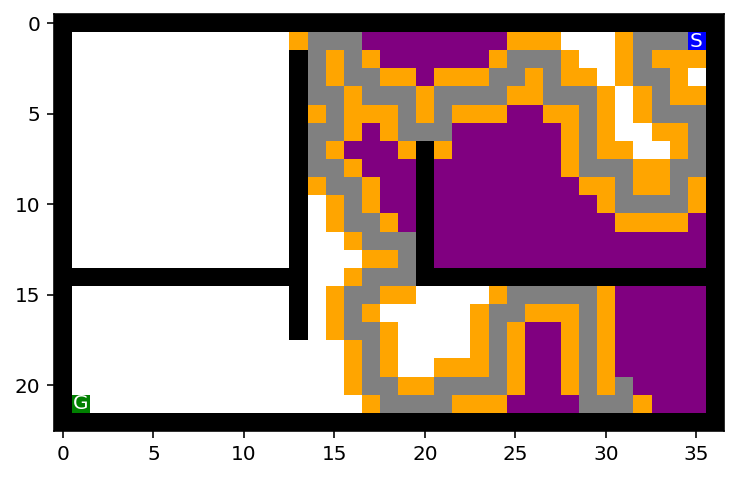

Node - pos = (20, 31); parent = <__main__.Node object at 0x7f100adce370>; action = North; cost = 111


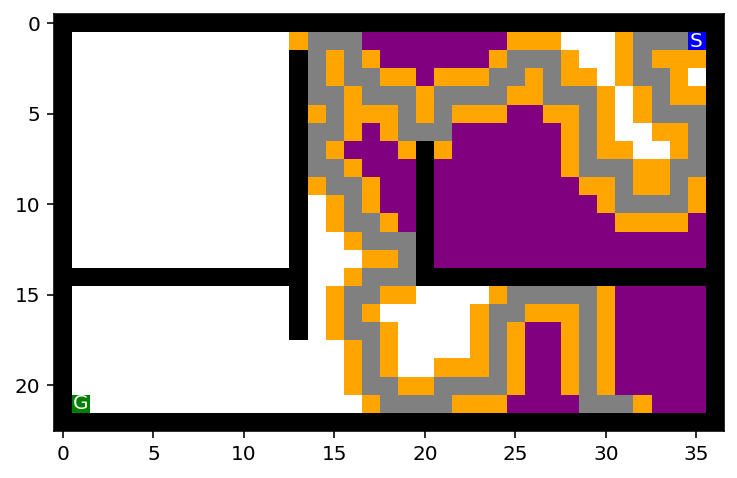

Node - pos = (21, 32); parent = <__main__.Node object at 0x7f100adce370>; action = East; cost = 111


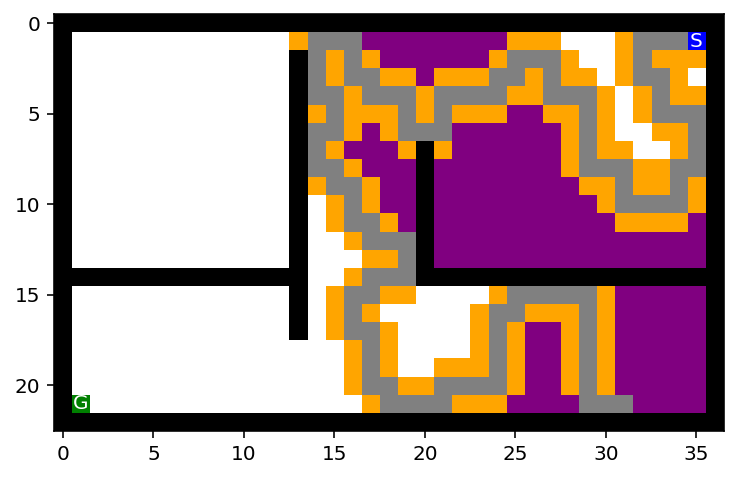

Node - pos = (21, 31); parent = <__main__.Node object at 0x7f100b0069d0>; action = East; cost = 110


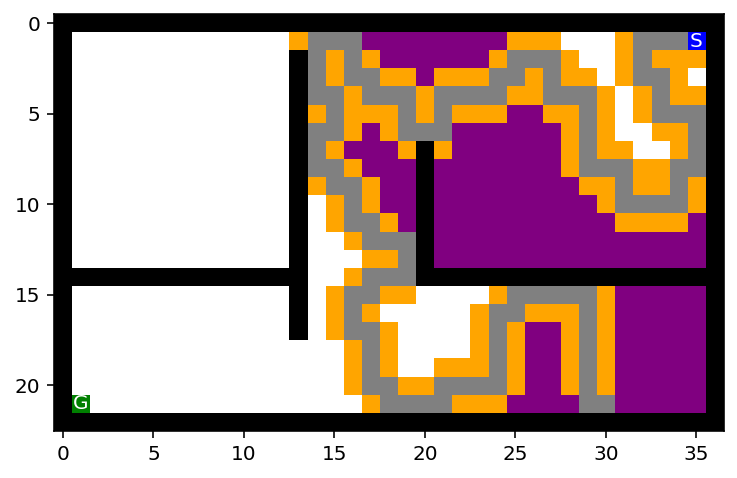

Node - pos = (21, 30); parent = <__main__.Node object at 0x7f100af1cd30>; action = East; cost = 109


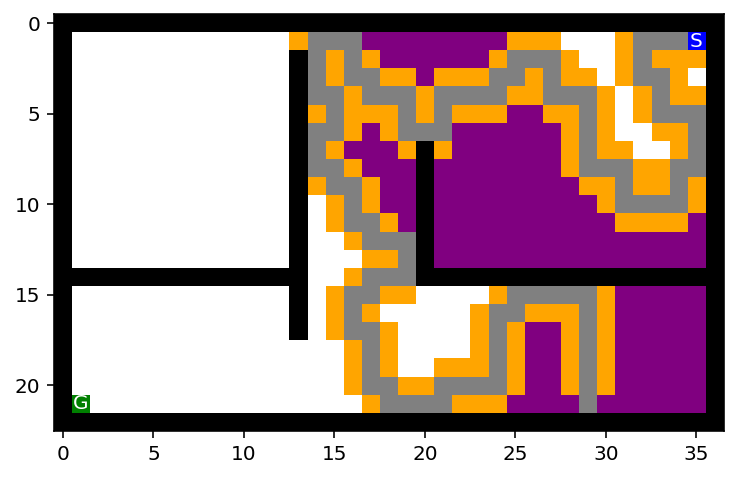

Node - pos = (21, 29); parent = <__main__.Node object at 0x7f100ad8d880>; action = South; cost = 108


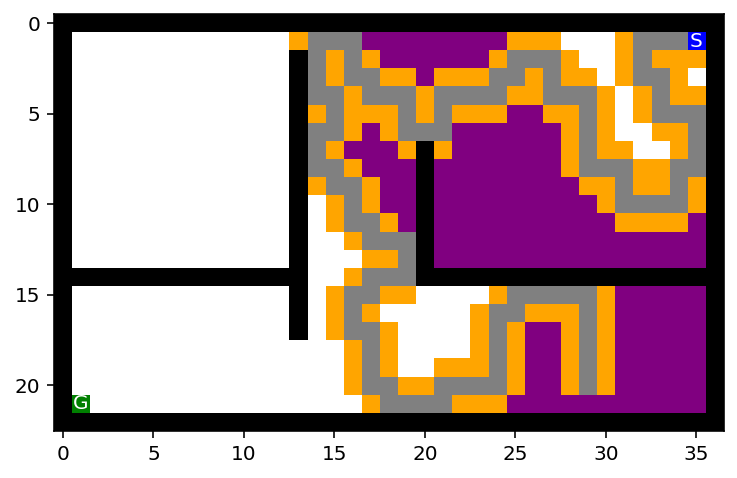

Node - pos = (20, 28); parent = <__main__.Node object at 0x7f100ad8d880>; action = West; cost = 108


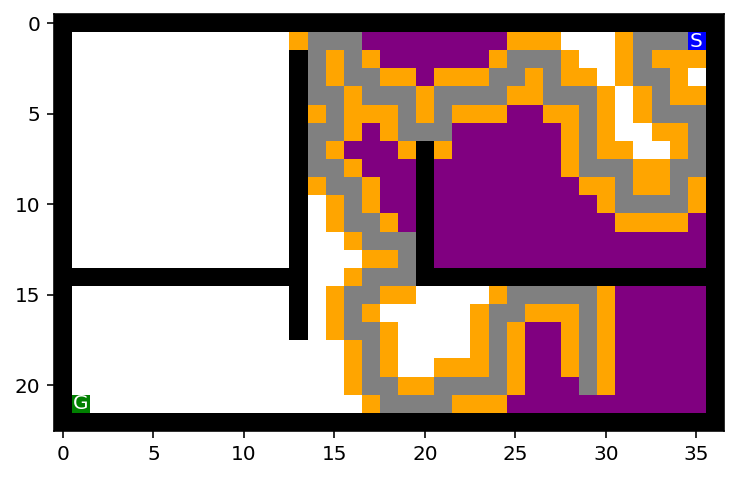

Node - pos = (20, 30); parent = <__main__.Node object at 0x7f100ad8d880>; action = East; cost = 108


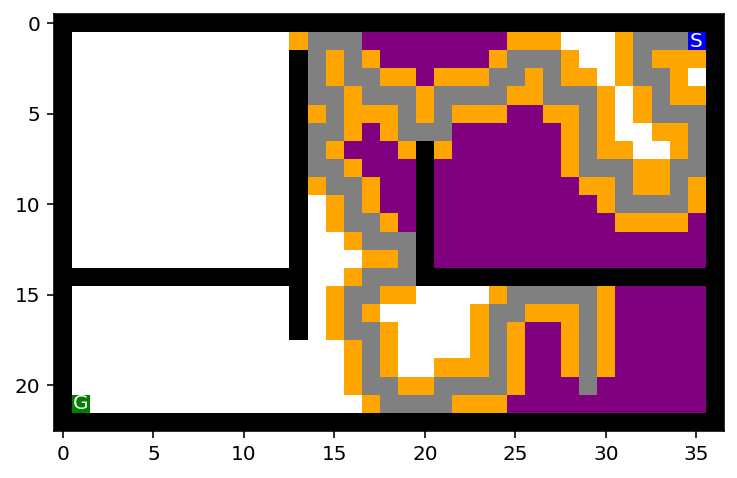

Node - pos = (20, 29); parent = <__main__.Node object at 0x7f100af23940>; action = South; cost = 107


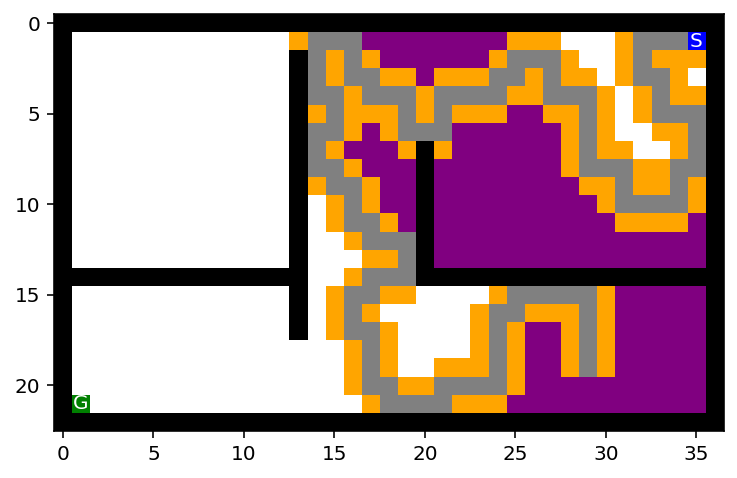

Node - pos = (19, 30); parent = <__main__.Node object at 0x7f100af23940>; action = East; cost = 107


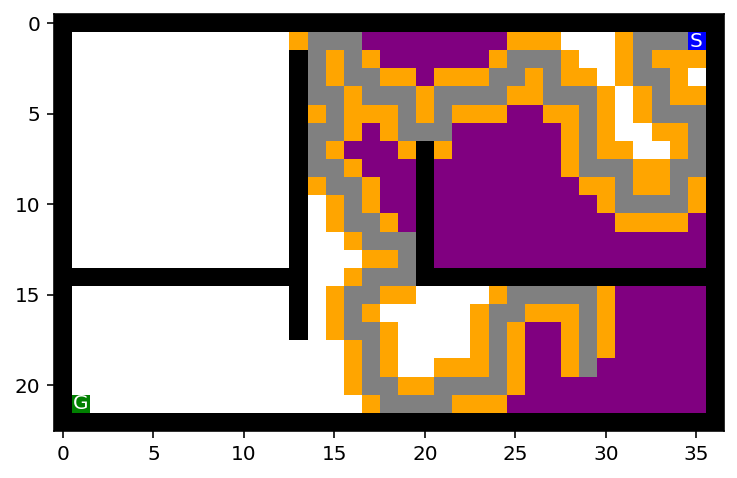

Node - pos = (19, 28); parent = <__main__.Node object at 0x7f100af23940>; action = West; cost = 107


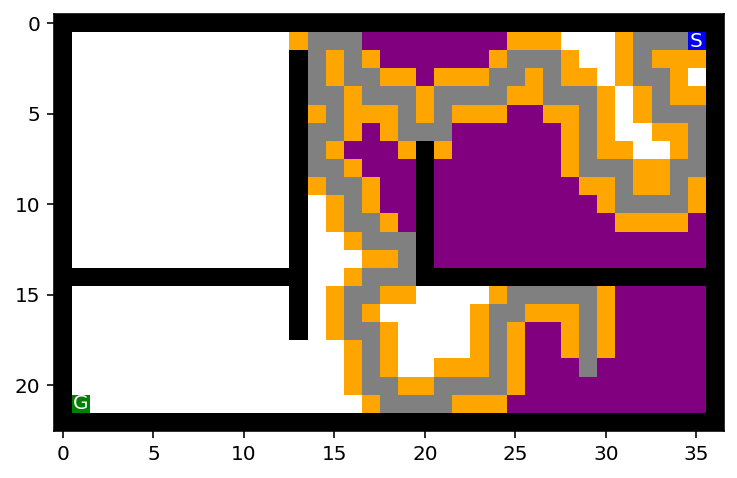

Node - pos = (19, 29); parent = <__main__.Node object at 0x7f100ae177f0>; action = South; cost = 106


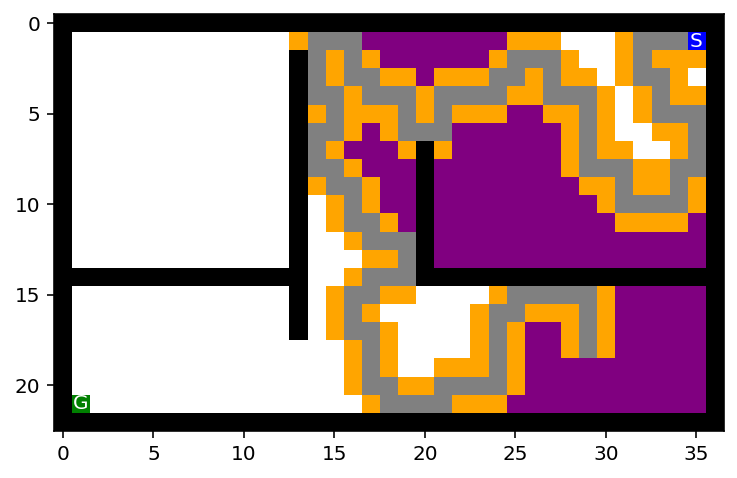

Node - pos = (18, 30); parent = <__main__.Node object at 0x7f100ae177f0>; action = East; cost = 106


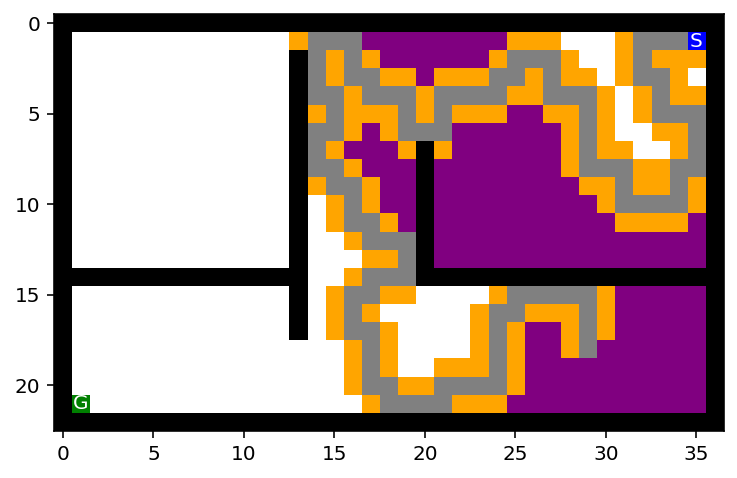

Node - pos = (18, 28); parent = <__main__.Node object at 0x7f100ae177f0>; action = West; cost = 106


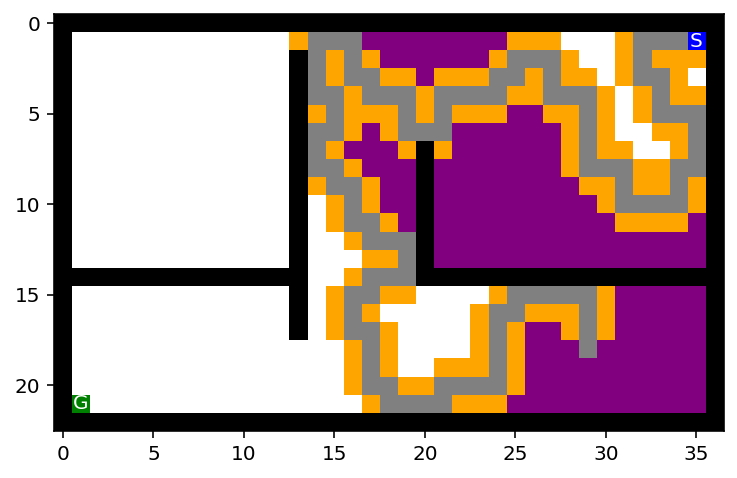

Node - pos = (18, 29); parent = <__main__.Node object at 0x7f100b104e80>; action = South; cost = 105


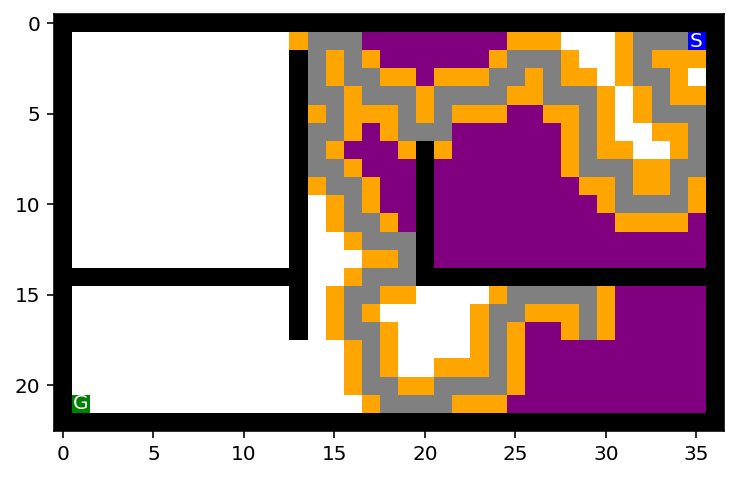

Node - pos = (17, 30); parent = <__main__.Node object at 0x7f100b104e80>; action = East; cost = 105


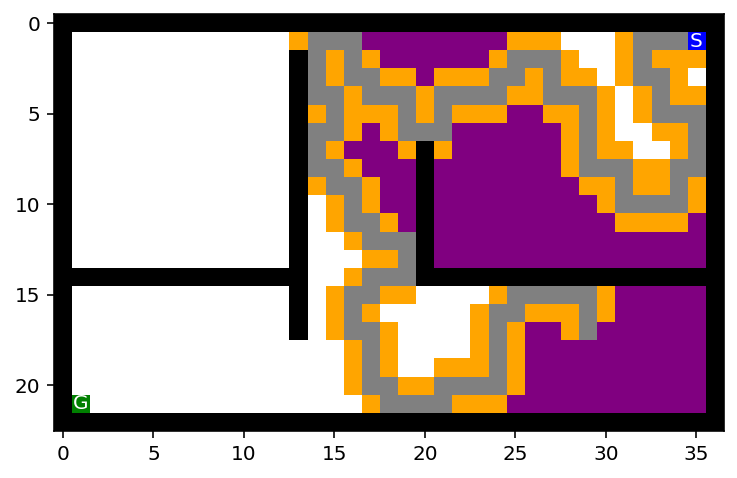

Node - pos = (17, 28); parent = <__main__.Node object at 0x7f100b104e80>; action = West; cost = 105


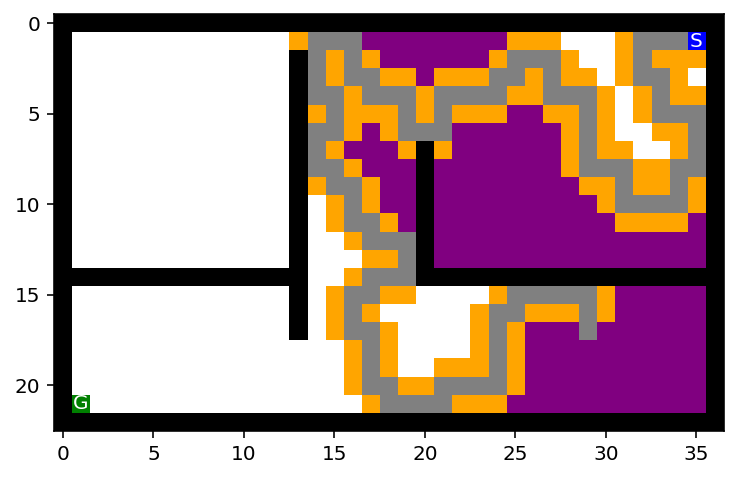

Node - pos = (17, 29); parent = <__main__.Node object at 0x7f100ae30970>; action = South; cost = 104


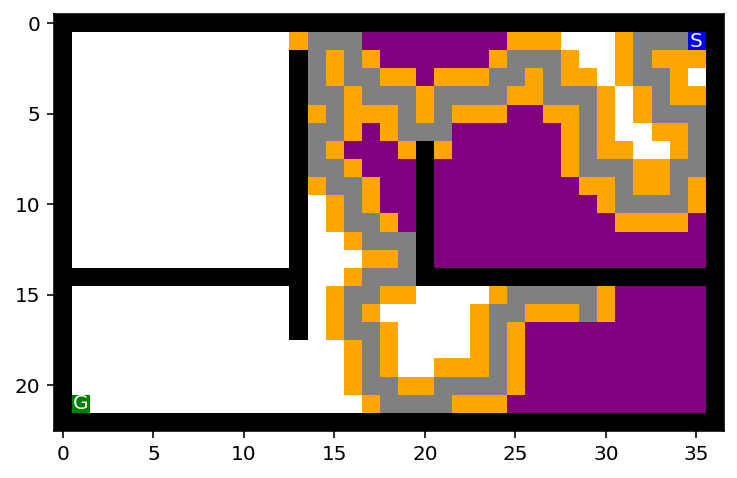

Node - pos = (16, 30); parent = <__main__.Node object at 0x7f100ae30970>; action = East; cost = 104


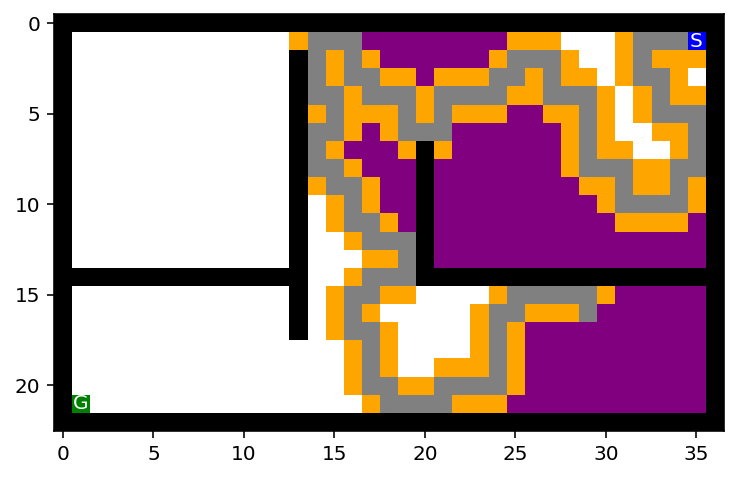

Node - pos = (16, 29); parent = <__main__.Node object at 0x7f100addba90>; action = South; cost = 103


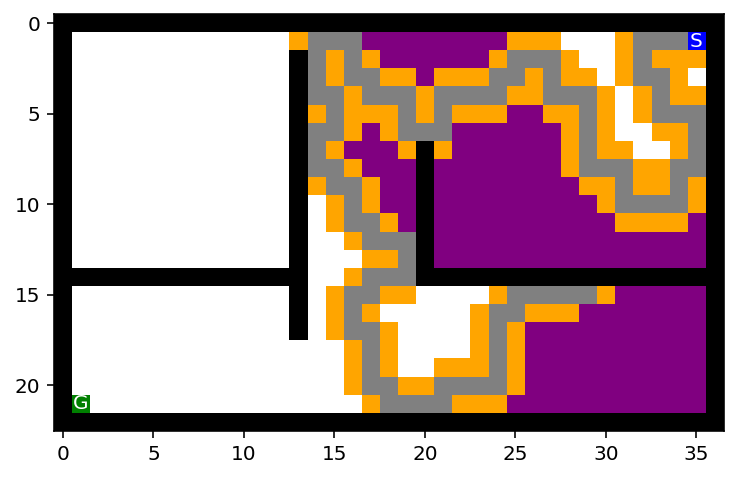

Node - pos = (15, 30); parent = <__main__.Node object at 0x7f100addba90>; action = East; cost = 103


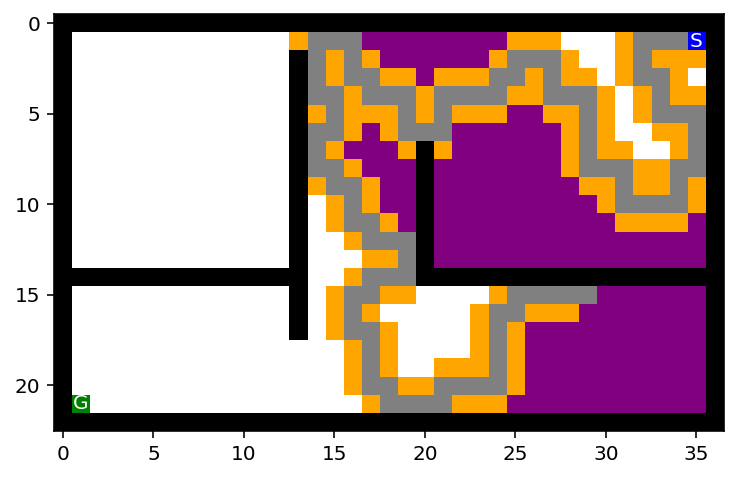

Node - pos = (15, 29); parent = <__main__.Node object at 0x7f100b0854f0>; action = East; cost = 102


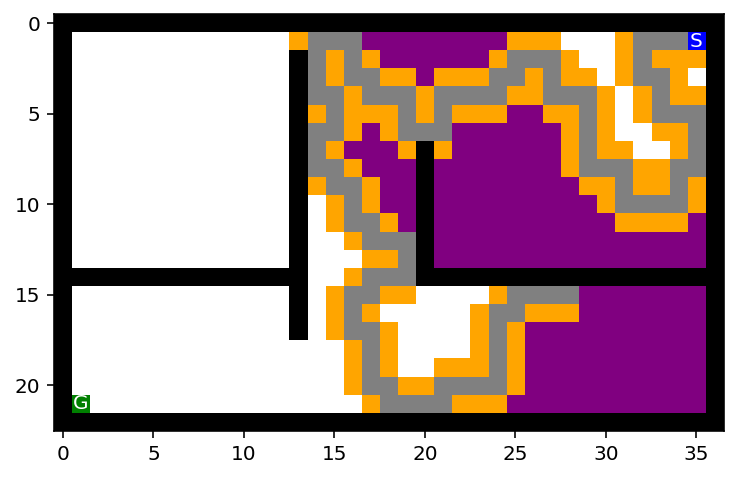

Node - pos = (16, 28); parent = <__main__.Node object at 0x7f100b0854f0>; action = South; cost = 102


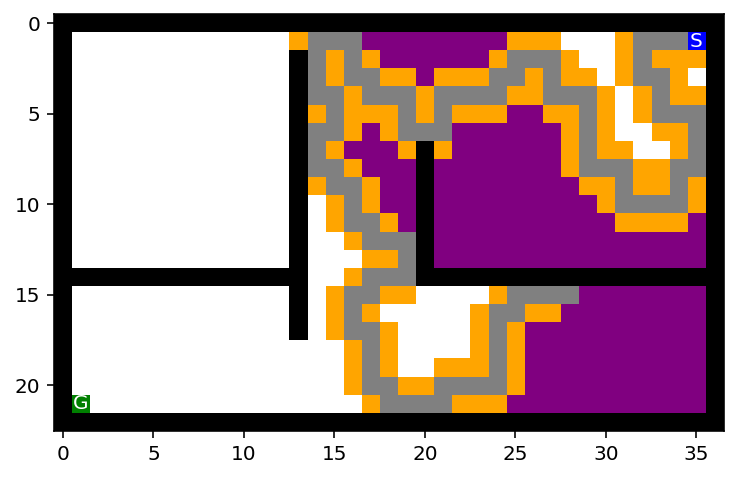

Node - pos = (15, 28); parent = <__main__.Node object at 0x7f100af38fd0>; action = East; cost = 101


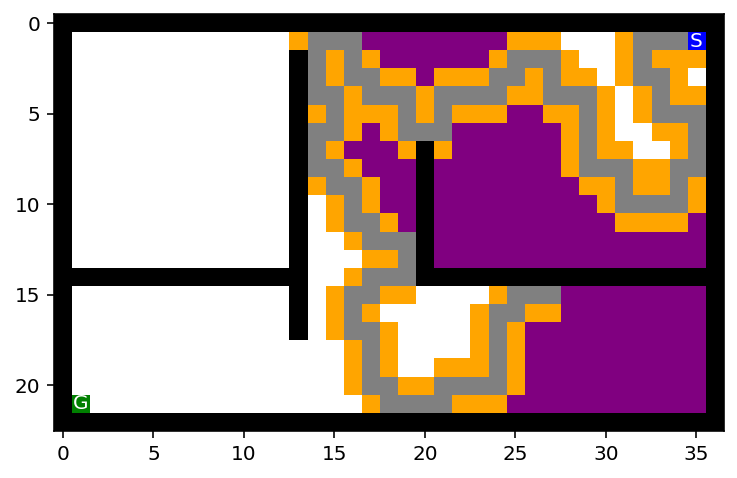

Node - pos = (16, 27); parent = <__main__.Node object at 0x7f100af38fd0>; action = South; cost = 101


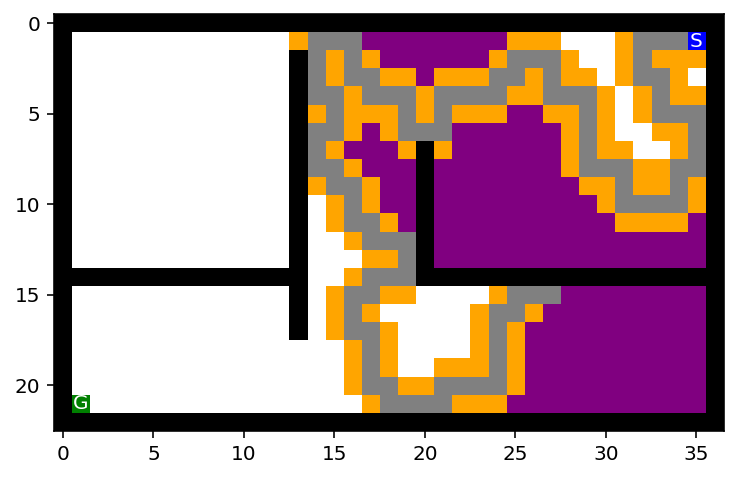

Node - pos = (15, 27); parent = <__main__.Node object at 0x7f100b18cc10>; action = East; cost = 100


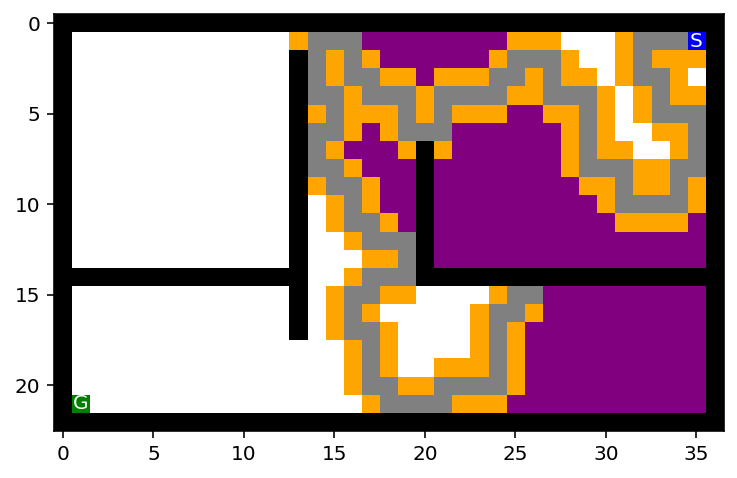

Node - pos = (15, 26); parent = <__main__.Node object at 0x7f100af0cd90>; action = East; cost = 99


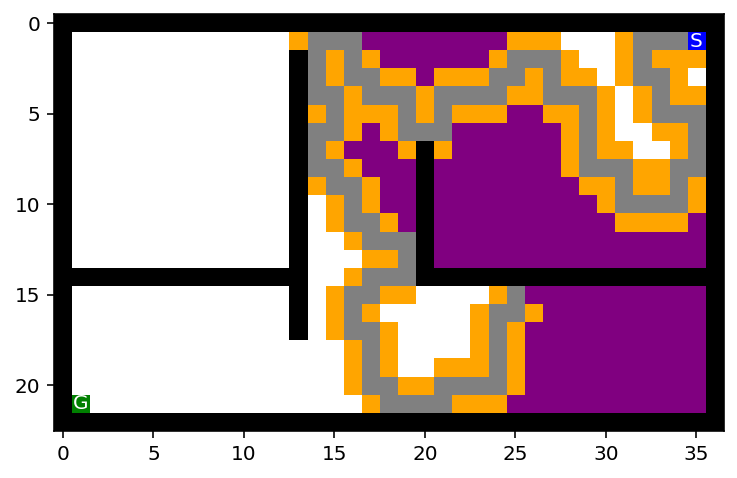

Node - pos = (15, 25); parent = <__main__.Node object at 0x7f100b12a880>; action = North; cost = 98


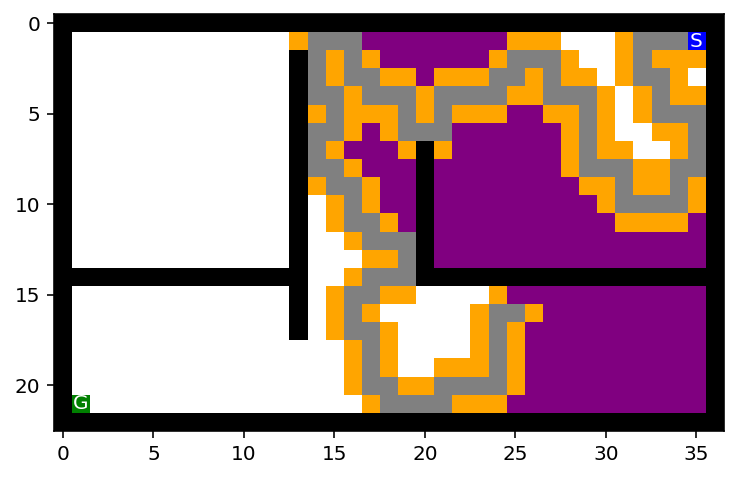

Node - pos = (16, 26); parent = <__main__.Node object at 0x7f100b12a880>; action = East; cost = 98


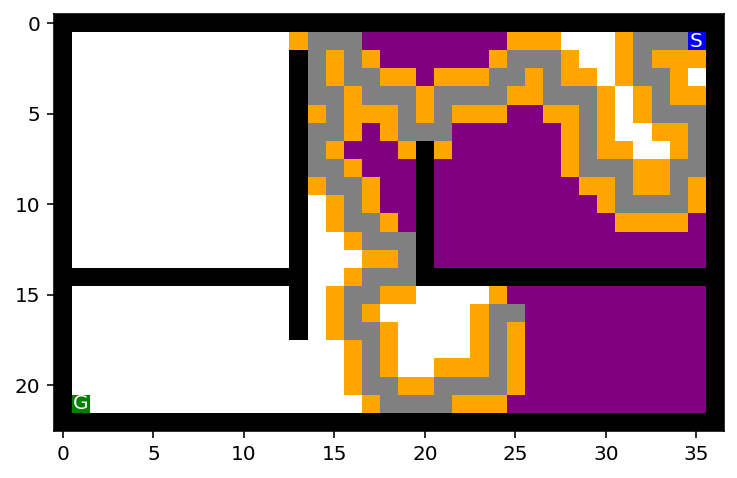

Node - pos = (16, 25); parent = <__main__.Node object at 0x7f100b12a7f0>; action = East; cost = 97


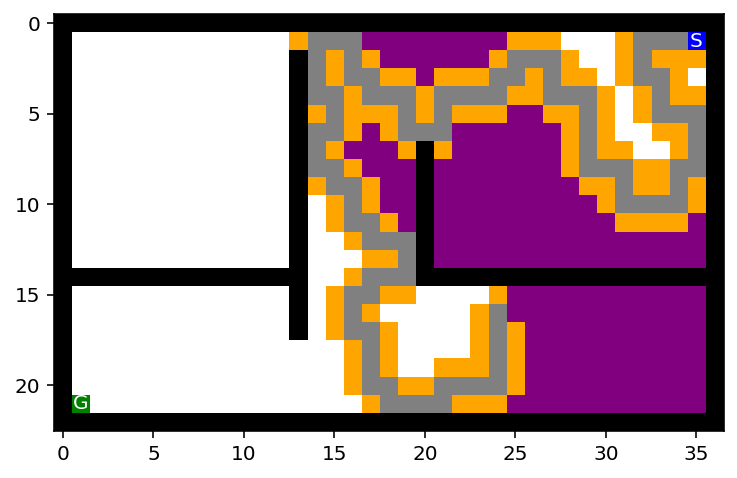

Node - pos = (15, 24); parent = <__main__.Node object at 0x7f100b12a7f0>; action = North; cost = 97


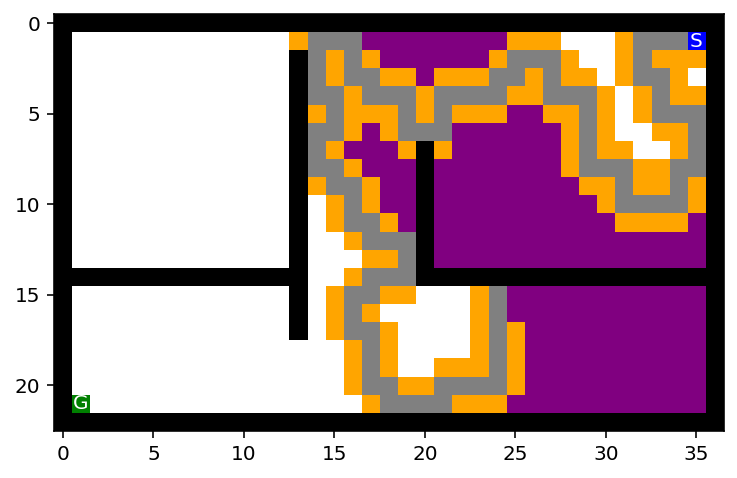

Node - pos = (15, 23); parent = <__main__.Node object at 0x7f100b12a610>; action = West; cost = 98


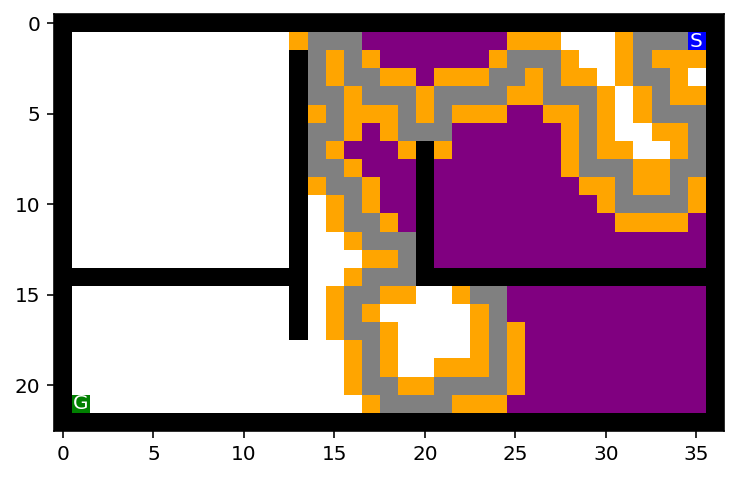

Node - pos = (15, 22); parent = <__main__.Node object at 0x7f100b04a610>; action = West; cost = 99


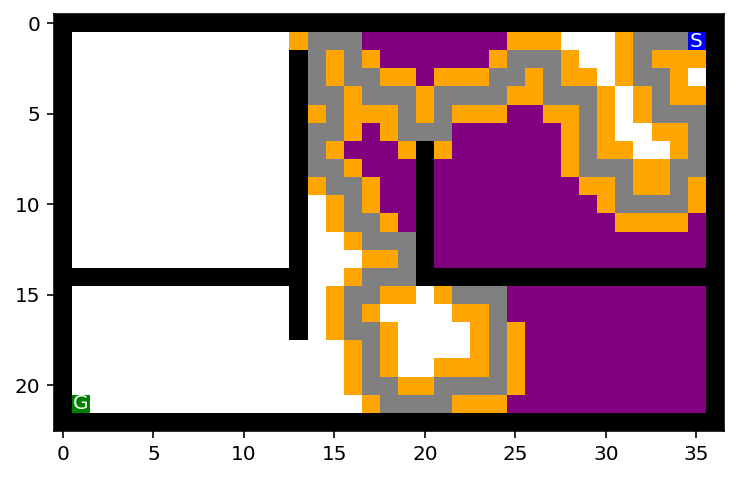

Node - pos = (15, 21); parent = <__main__.Node object at 0x7f100ad9a430>; action = West; cost = 100


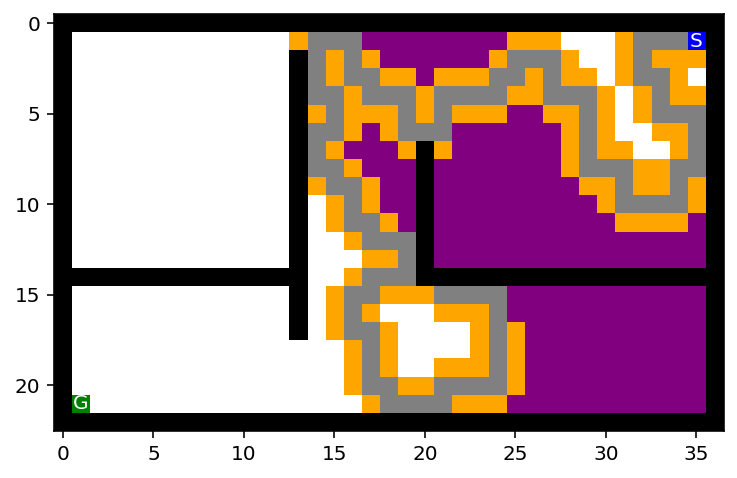

Node - pos = (15, 20); parent = <__main__.Node object at 0x7f100ad9fee0>; action = West; cost = 101


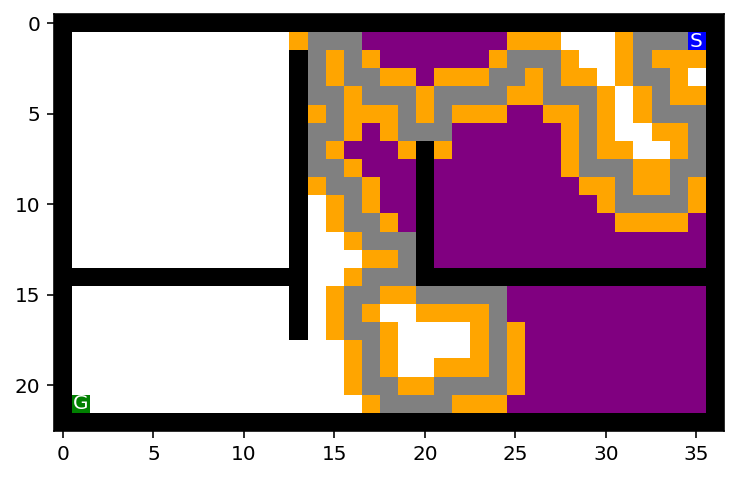

Node - pos = (16, 20); parent = <__main__.Node object at 0x7f100b14aca0>; action = South; cost = 102


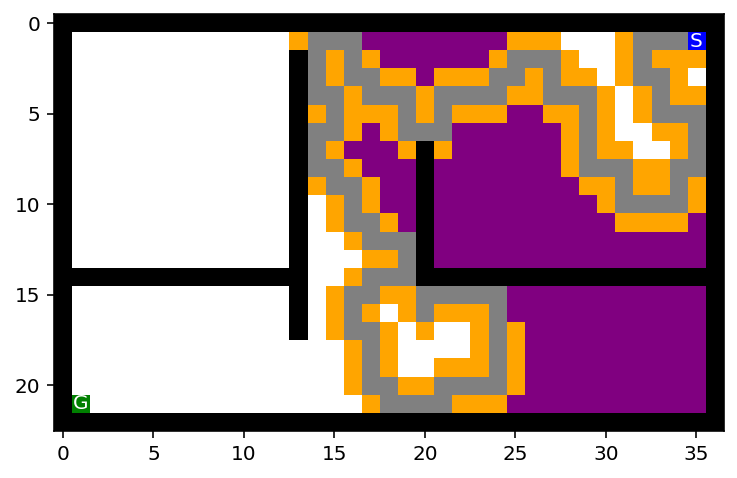

Node - pos = (17, 20); parent = <__main__.Node object at 0x7f100b129ac0>; action = South; cost = 103


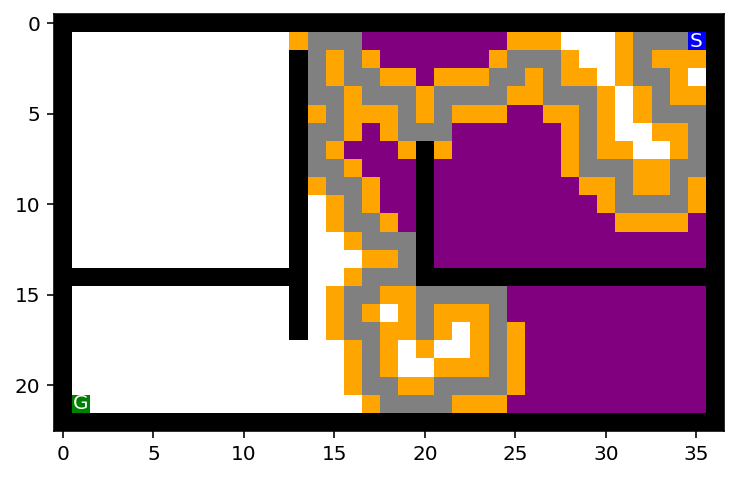

Node - pos = (18, 20); parent = <__main__.Node object at 0x7f100af16cd0>; action = South; cost = 104


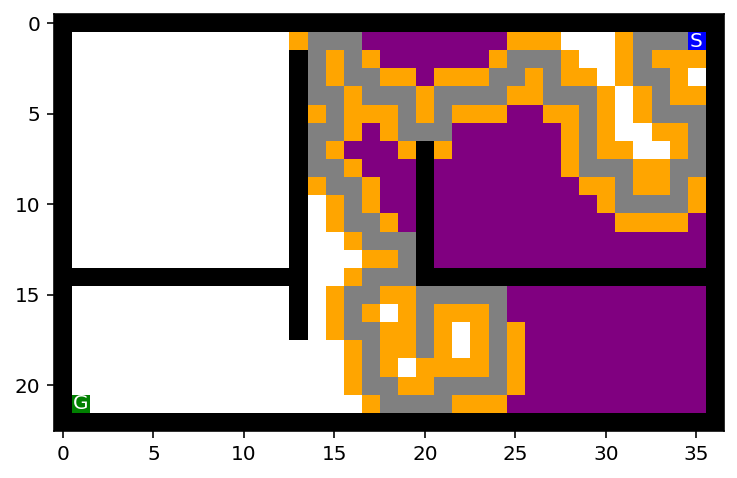

Node - pos = (18, 21); parent = <__main__.Node object at 0x7f100adef2b0>; action = East; cost = 105


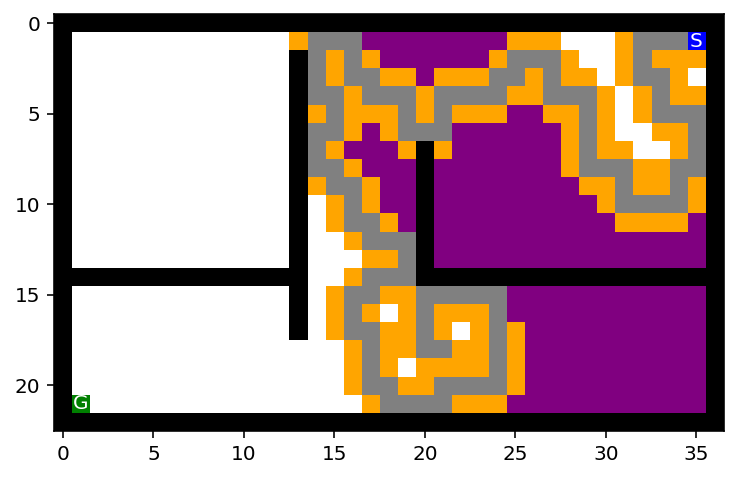

Node - pos = (18, 22); parent = <__main__.Node object at 0x7f100ad98130>; action = East; cost = 106


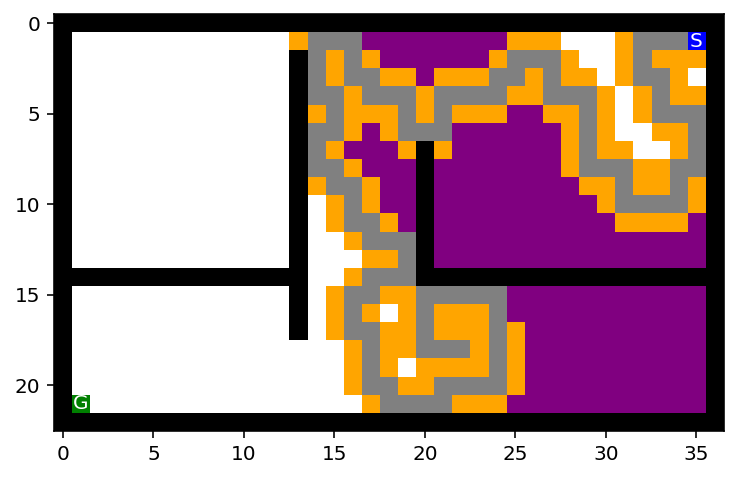

Node - pos = (17, 22); parent = <__main__.Node object at 0x7f100af165b0>; action = North; cost = 107


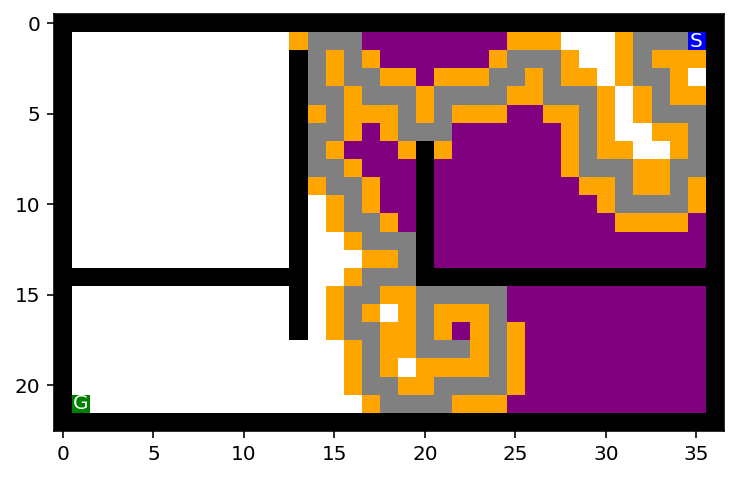

Node - pos = (18, 22); parent = <__main__.Node object at 0x7f100ad98130>; action = East; cost = 106


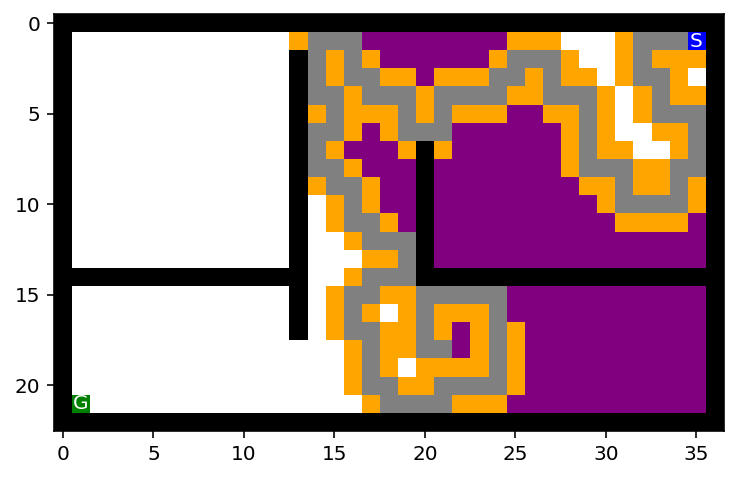

Node - pos = (18, 21); parent = <__main__.Node object at 0x7f100adef2b0>; action = East; cost = 105


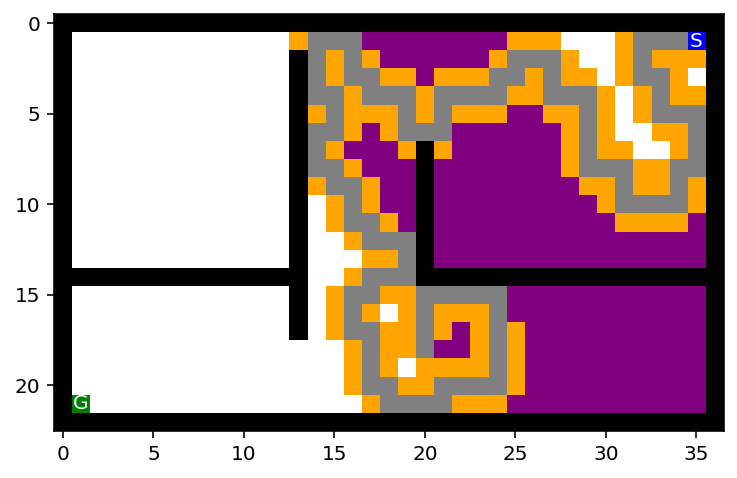

Node - pos = (19, 20); parent = <__main__.Node object at 0x7f100adef2b0>; action = South; cost = 105


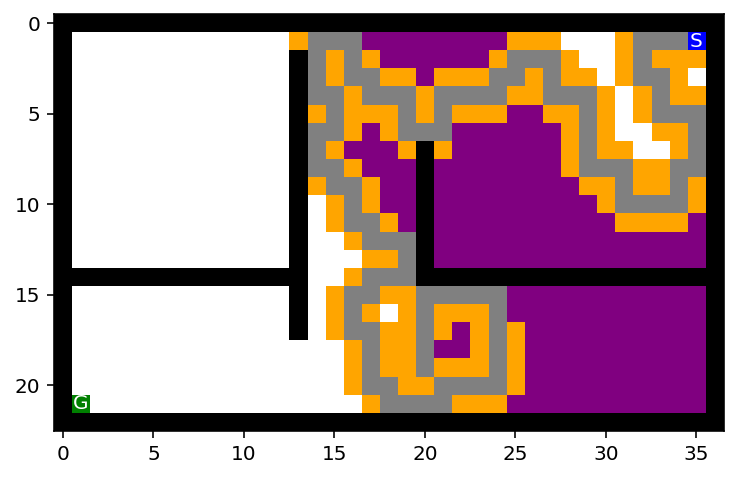

Node - pos = (19, 19); parent = <__main__.Node object at 0x7f100adefd90>; action = West; cost = 106


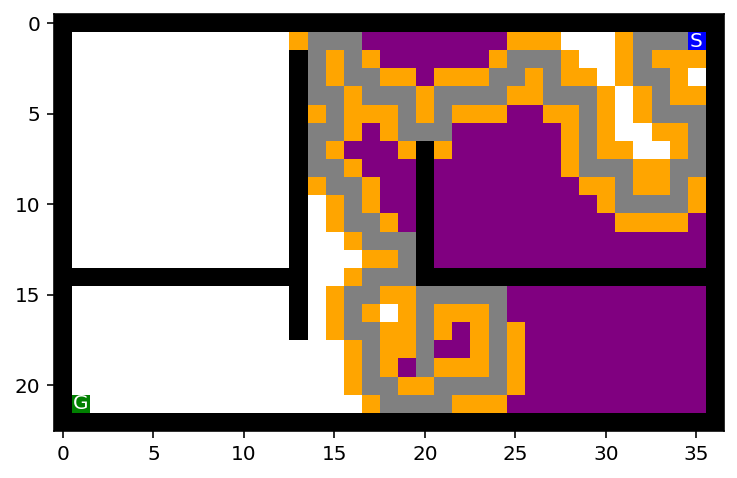

Node - pos = (19, 20); parent = <__main__.Node object at 0x7f100adef2b0>; action = South; cost = 105


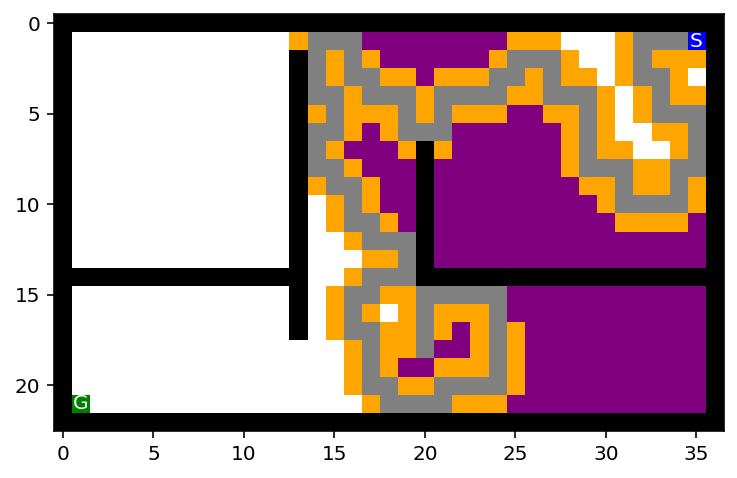

Node - pos = (18, 19); parent = <__main__.Node object at 0x7f100adef2b0>; action = West; cost = 105


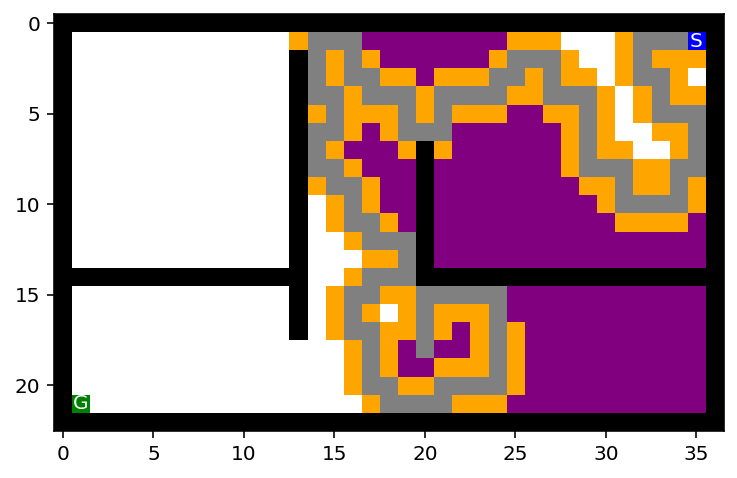

Node - pos = (18, 20); parent = <__main__.Node object at 0x7f100af16cd0>; action = South; cost = 104


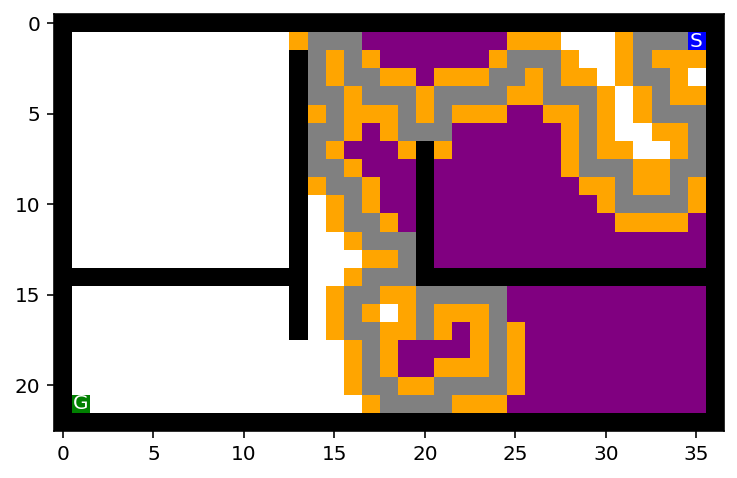

Node - pos = (17, 19); parent = <__main__.Node object at 0x7f100af16cd0>; action = West; cost = 104


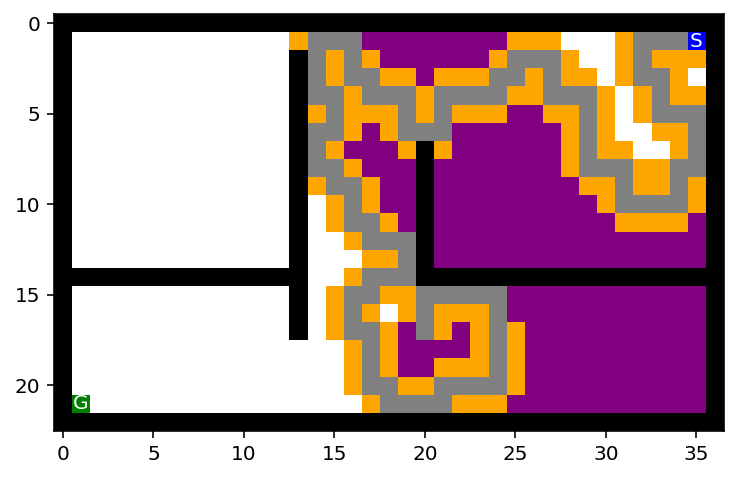

Node - pos = (17, 21); parent = <__main__.Node object at 0x7f100af16cd0>; action = East; cost = 104


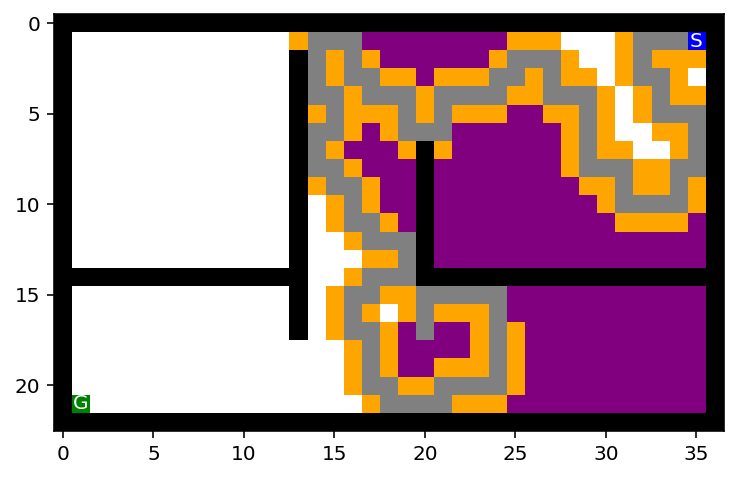

Node - pos = (17, 20); parent = <__main__.Node object at 0x7f100b129ac0>; action = South; cost = 103


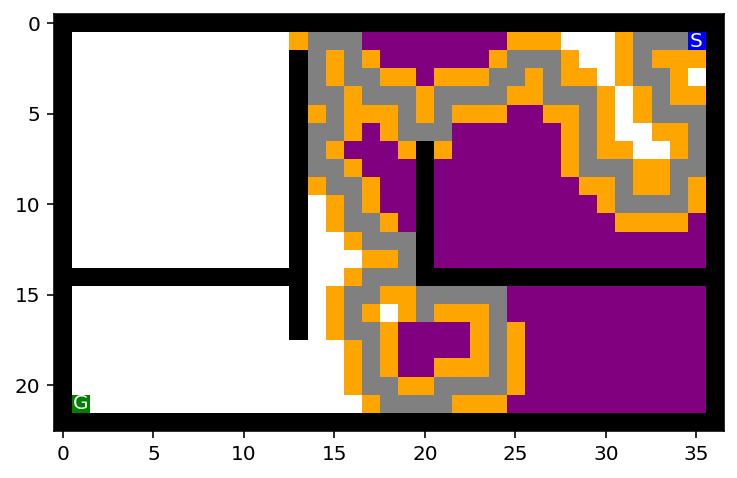

Node - pos = (16, 19); parent = <__main__.Node object at 0x7f100b129ac0>; action = West; cost = 103


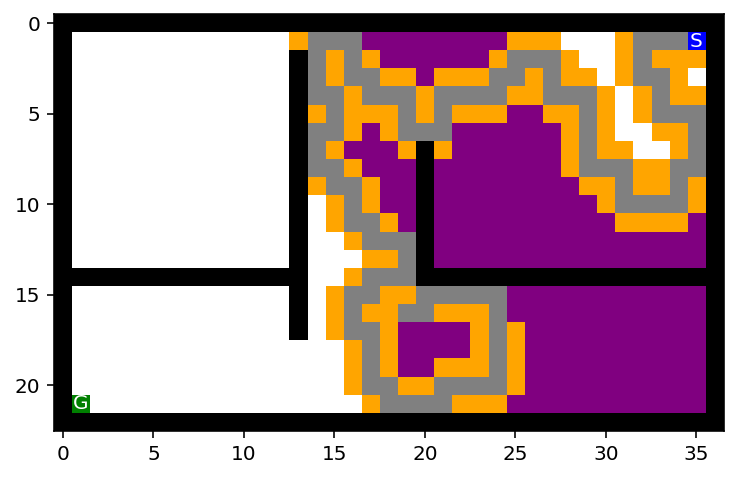

Node - pos = (16, 18); parent = <__main__.Node object at 0x7f100af167c0>; action = West; cost = 104


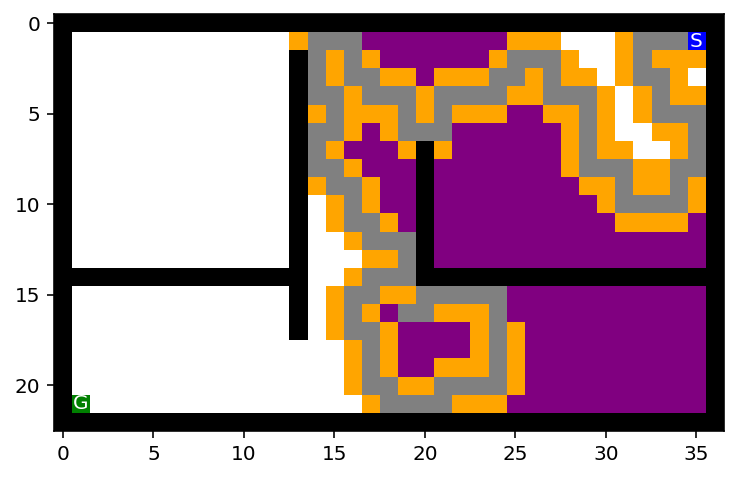

Node - pos = (16, 19); parent = <__main__.Node object at 0x7f100b129ac0>; action = West; cost = 103


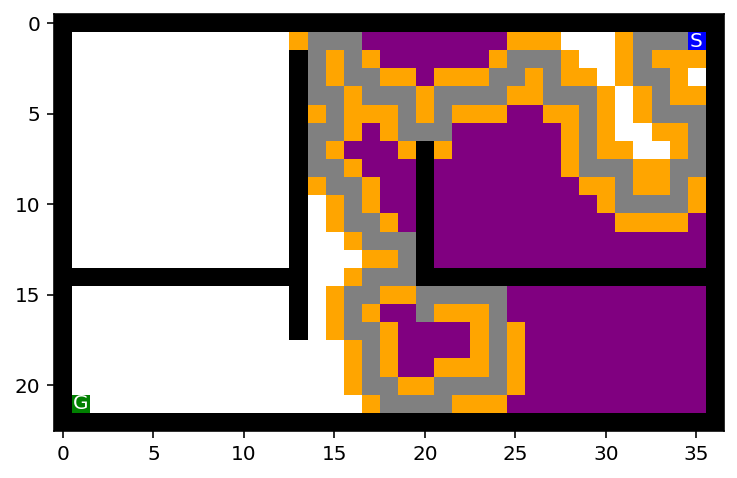

Node - pos = (16, 20); parent = <__main__.Node object at 0x7f100b14aca0>; action = South; cost = 102


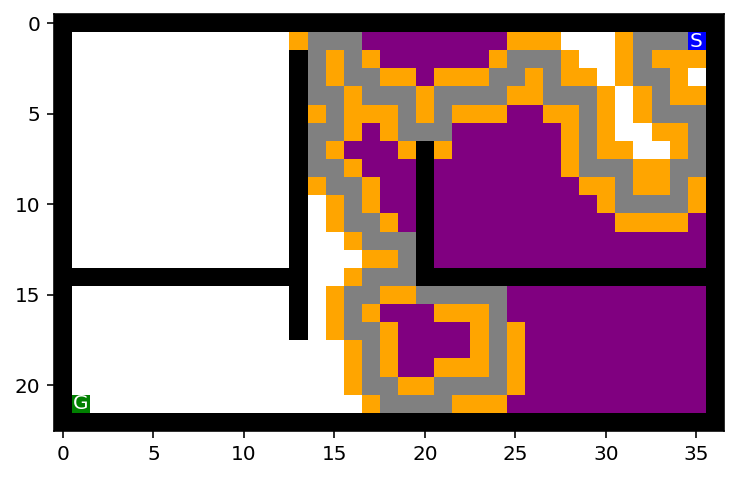

Node - pos = (15, 20); parent = <__main__.Node object at 0x7f100ad9fee0>; action = West; cost = 101


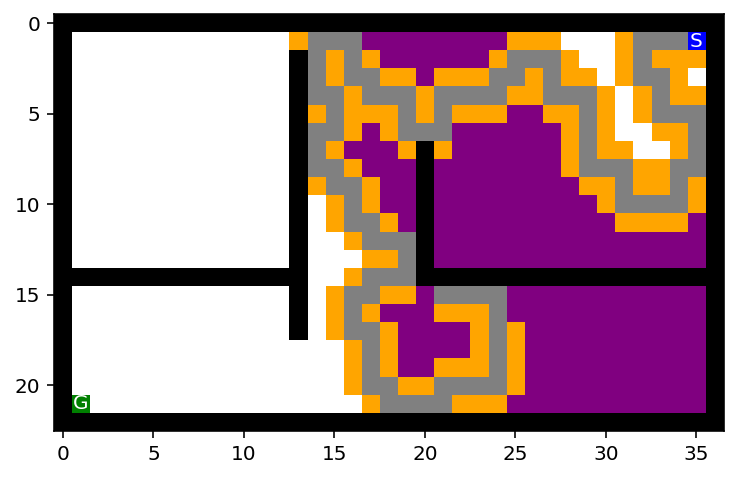

Node - pos = (16, 21); parent = <__main__.Node object at 0x7f100ad9fee0>; action = South; cost = 101


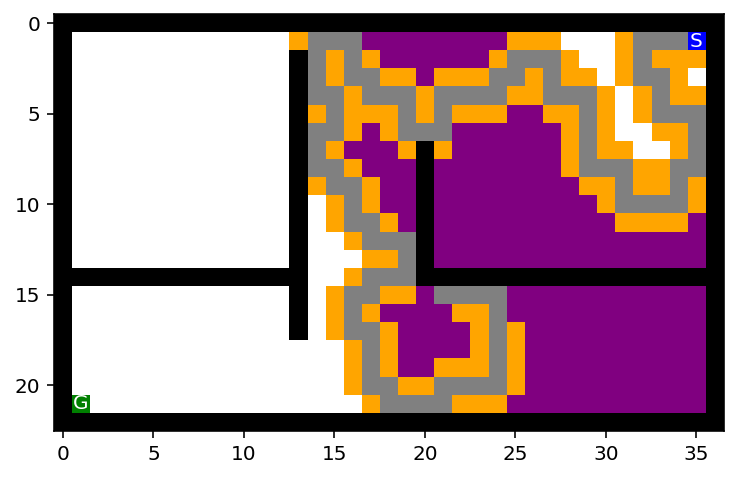

Node - pos = (15, 21); parent = <__main__.Node object at 0x7f100ad9a430>; action = West; cost = 100


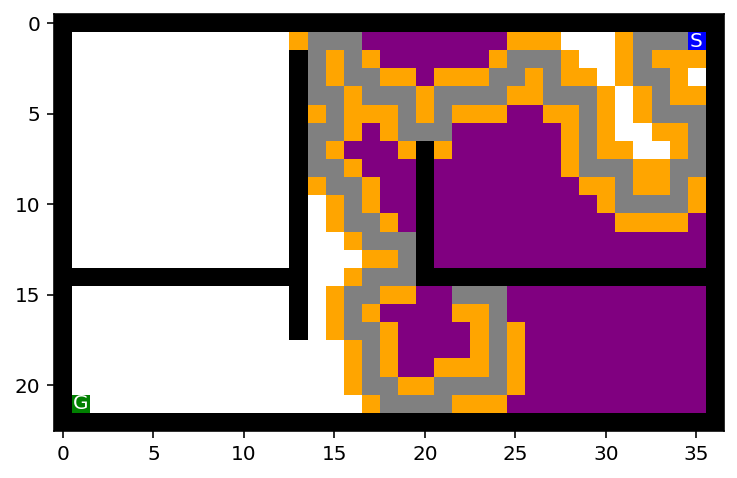

Node - pos = (16, 22); parent = <__main__.Node object at 0x7f100ad9a430>; action = South; cost = 100


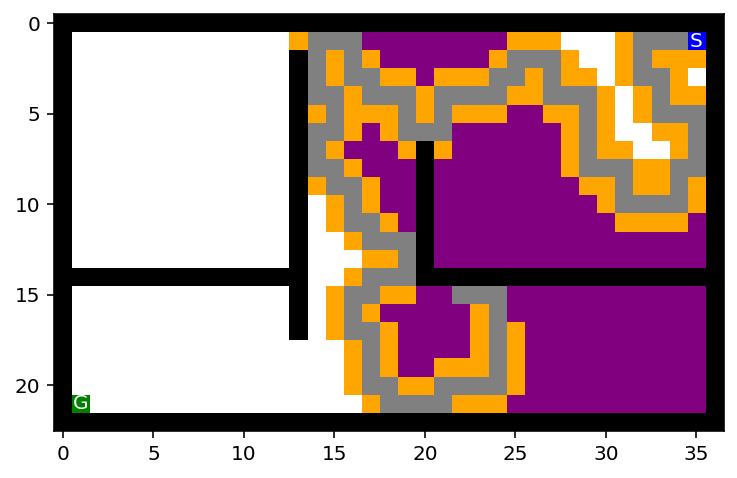

Node - pos = (15, 22); parent = <__main__.Node object at 0x7f100b04a610>; action = West; cost = 99


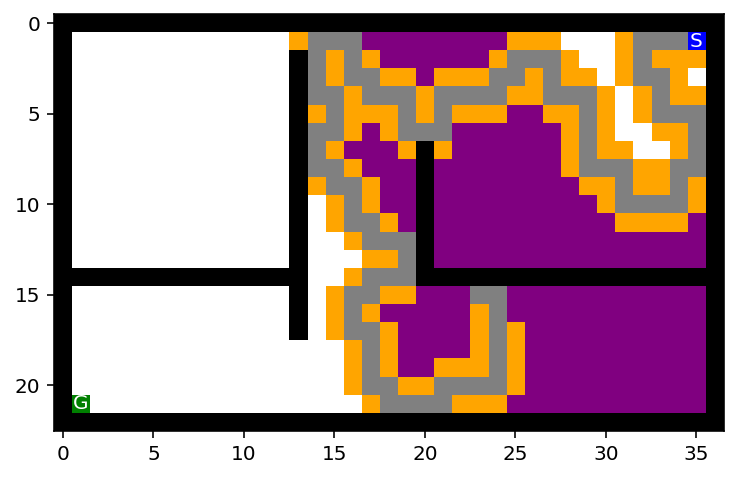

Node - pos = (15, 23); parent = <__main__.Node object at 0x7f100b12a610>; action = West; cost = 98


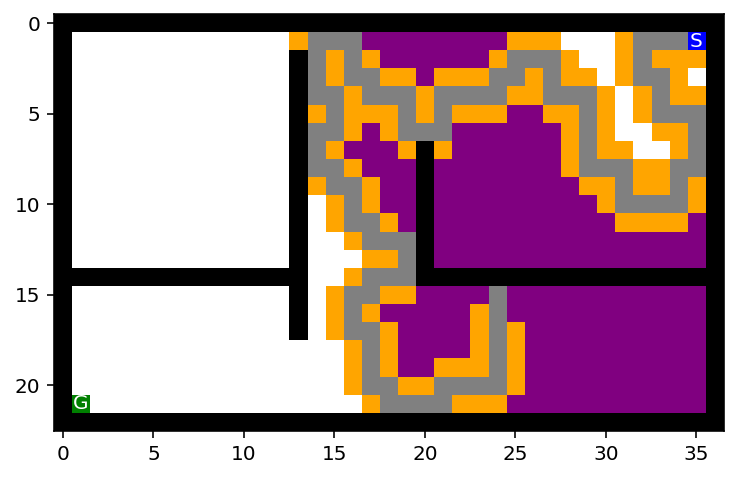

Node - pos = (15, 24); parent = <__main__.Node object at 0x7f100b12a7f0>; action = North; cost = 97


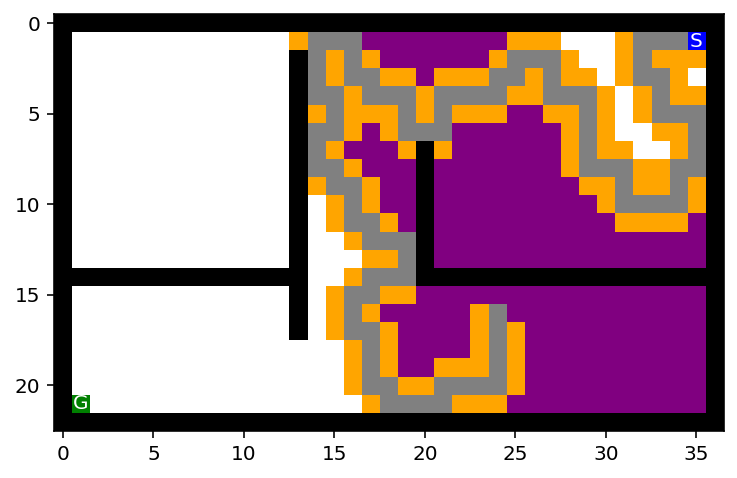

Node - pos = (16, 23); parent = <__main__.Node object at 0x7f100b12a7f0>; action = West; cost = 97


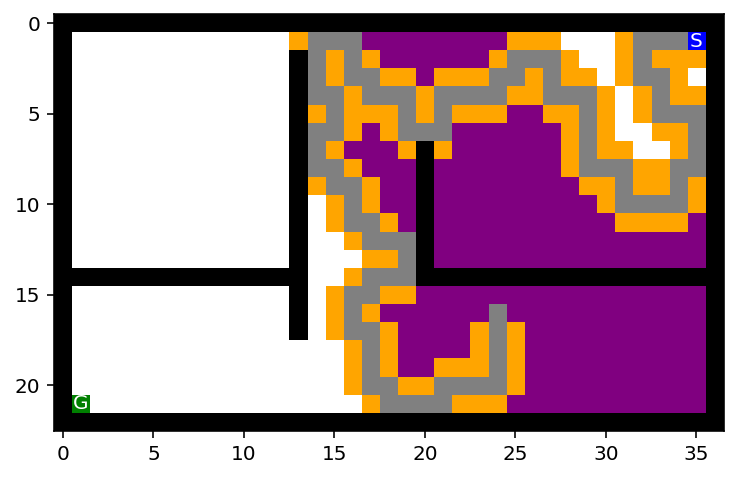

Node - pos = (16, 24); parent = <__main__.Node object at 0x7f100b04ad60>; action = North; cost = 96


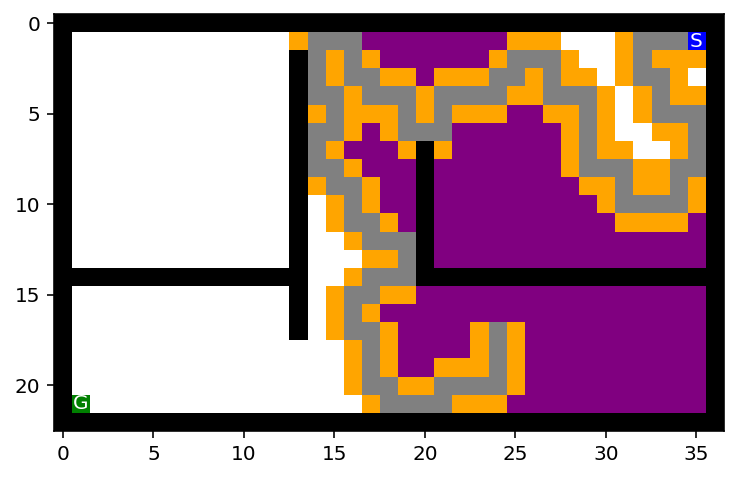

Node - pos = (17, 25); parent = <__main__.Node object at 0x7f100b04ad60>; action = East; cost = 96


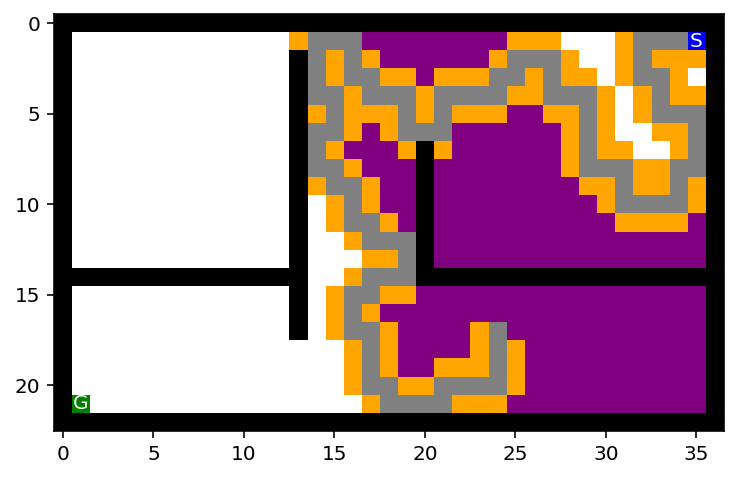

Node - pos = (17, 23); parent = <__main__.Node object at 0x7f100b04ad60>; action = West; cost = 96


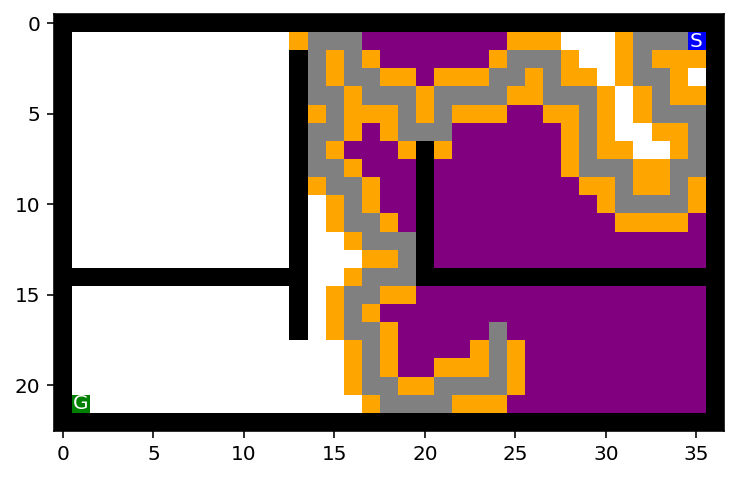

Node - pos = (17, 24); parent = <__main__.Node object at 0x7f100b18c850>; action = North; cost = 95


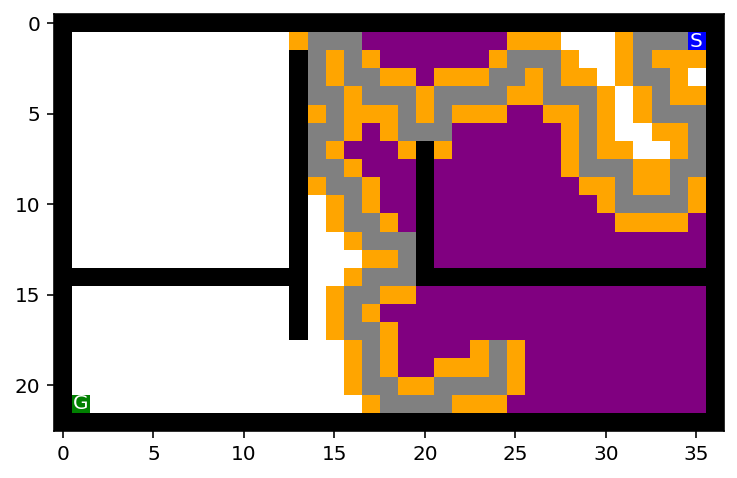

Node - pos = (18, 25); parent = <__main__.Node object at 0x7f100b18c850>; action = East; cost = 95


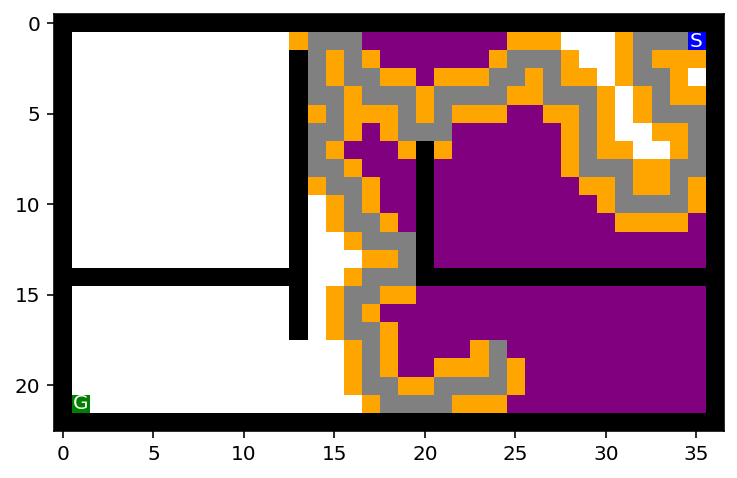

Node - pos = (18, 23); parent = <__main__.Node object at 0x7f100b18c850>; action = West; cost = 95


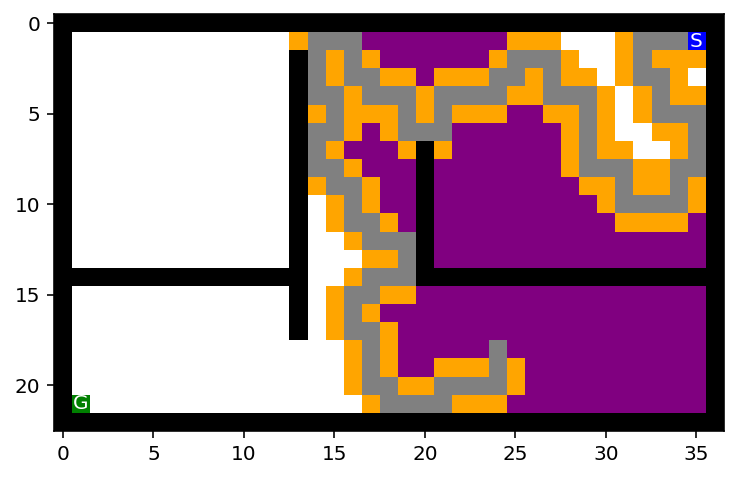

Node - pos = (18, 24); parent = <__main__.Node object at 0x7f100b056d30>; action = North; cost = 94


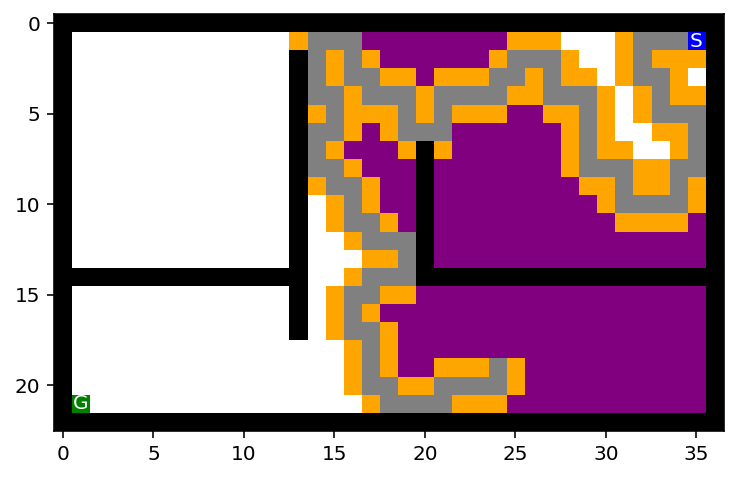

Node - pos = (19, 25); parent = <__main__.Node object at 0x7f100b056d30>; action = East; cost = 94


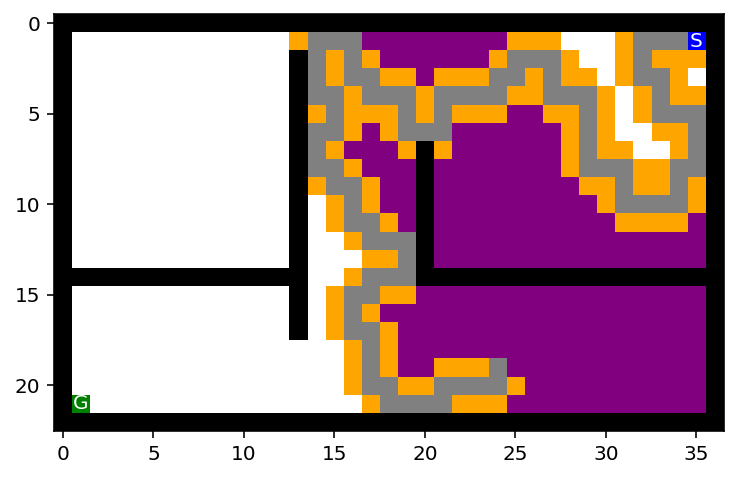

Node - pos = (19, 24); parent = <__main__.Node object at 0x7f100af98160>; action = North; cost = 93


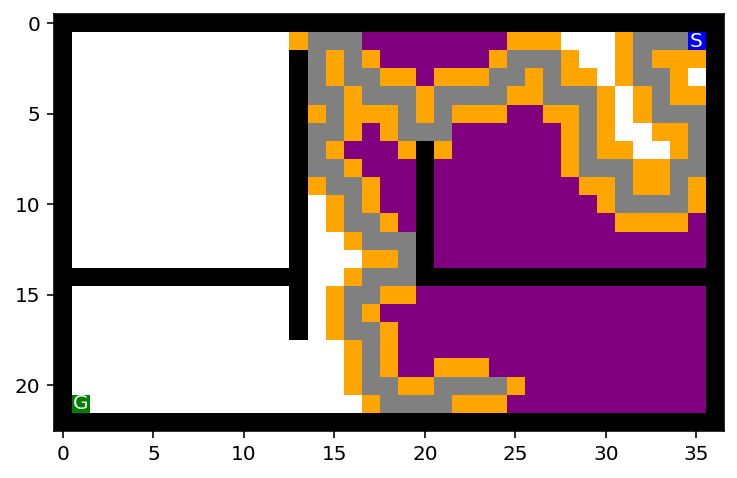

Node - pos = (21, 24); parent = <__main__.Node object at 0x7f100af98160>; action = South; cost = 93


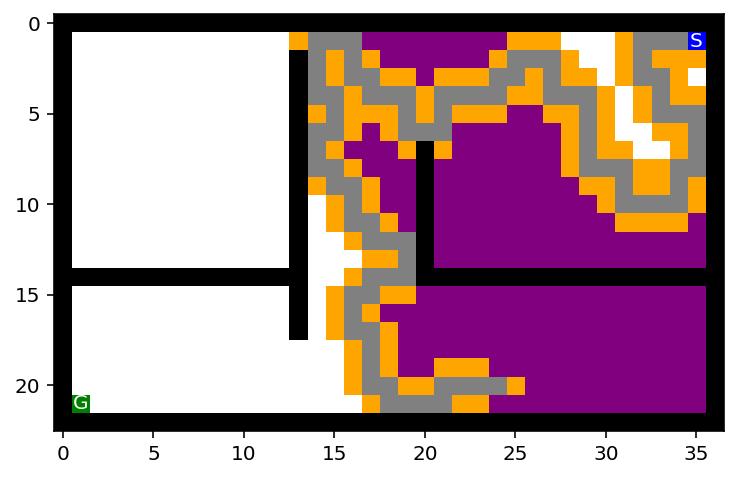

Node - pos = (20, 25); parent = <__main__.Node object at 0x7f100af98160>; action = East; cost = 93


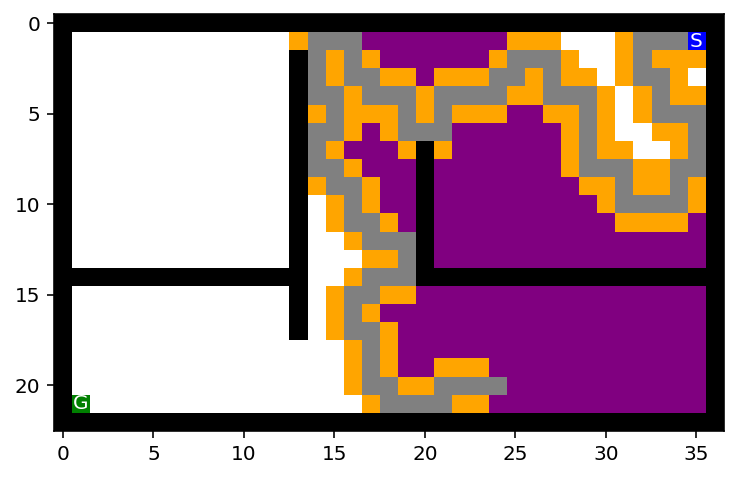

Node - pos = (20, 24); parent = <__main__.Node object at 0x7f100addbd30>; action = East; cost = 92


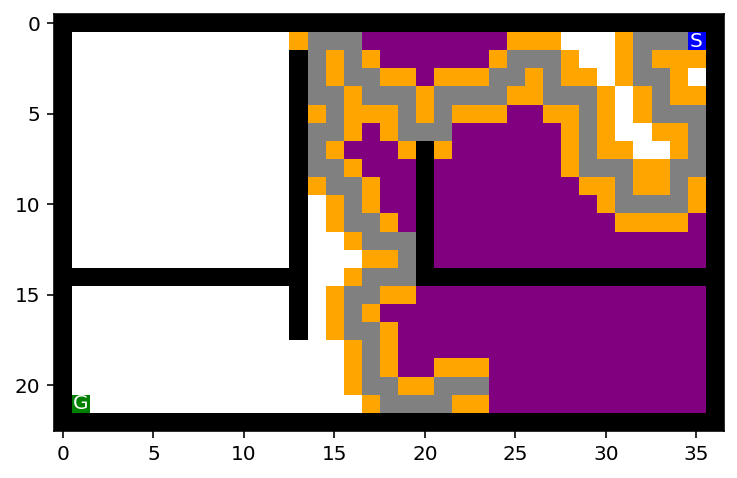

Node - pos = (21, 23); parent = <__main__.Node object at 0x7f100addbd30>; action = South; cost = 92


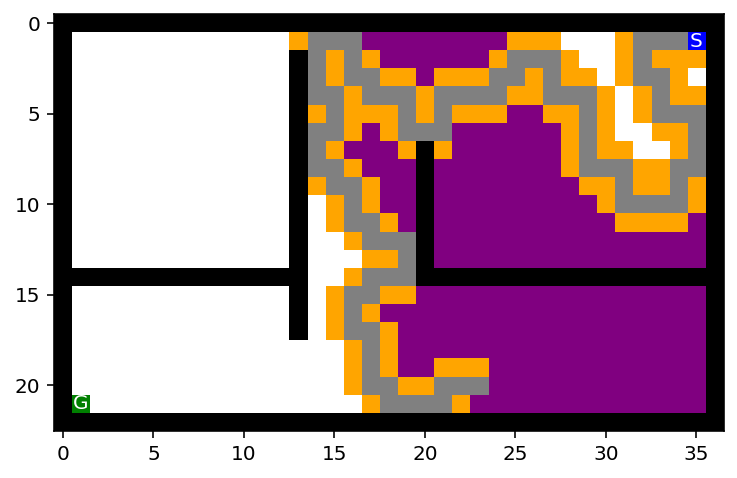

Node - pos = (19, 23); parent = <__main__.Node object at 0x7f100addbd30>; action = North; cost = 92


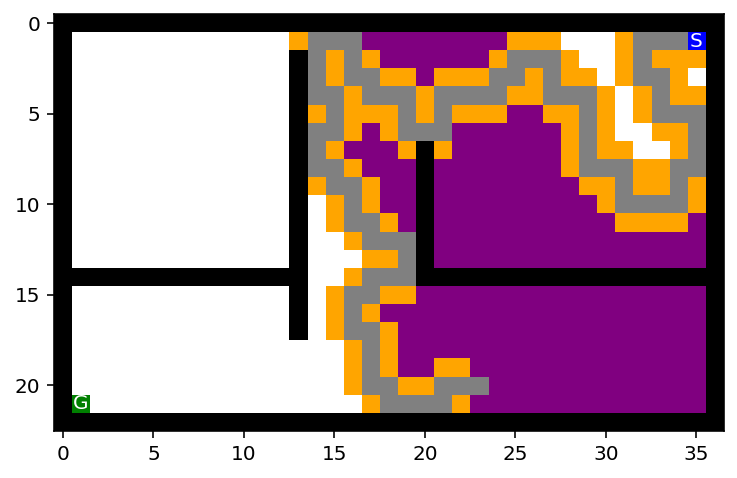

Node - pos = (20, 23); parent = <__main__.Node object at 0x7f100ae58580>; action = East; cost = 91


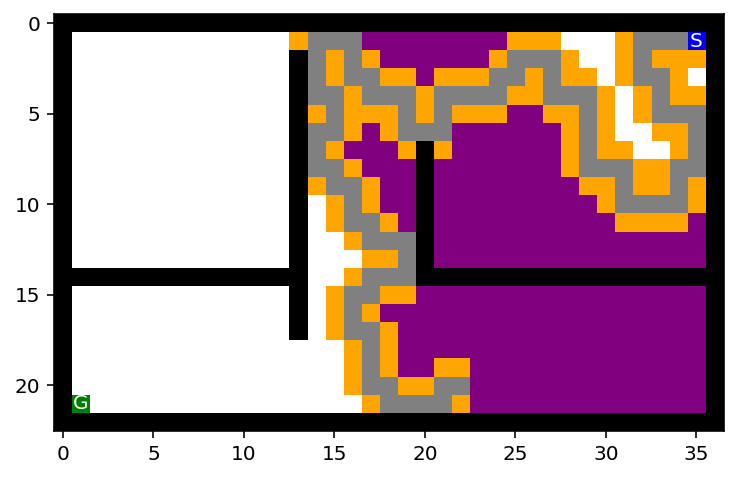

Node - pos = (19, 22); parent = <__main__.Node object at 0x7f100ae58580>; action = North; cost = 91


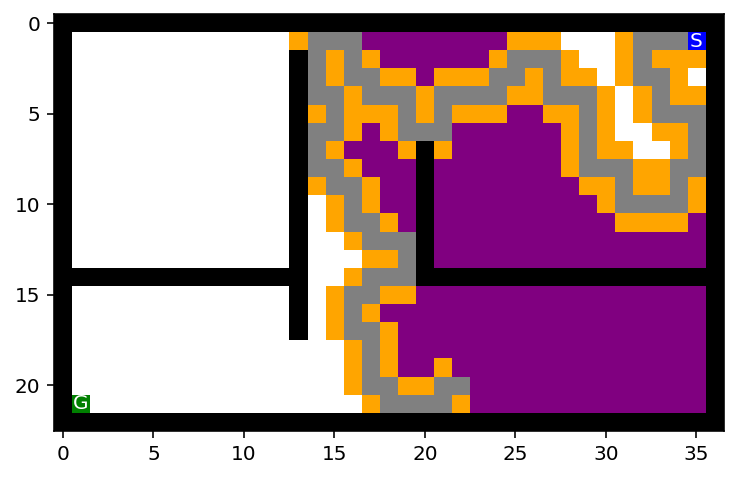

Node - pos = (20, 22); parent = <__main__.Node object at 0x7f100af16df0>; action = East; cost = 90


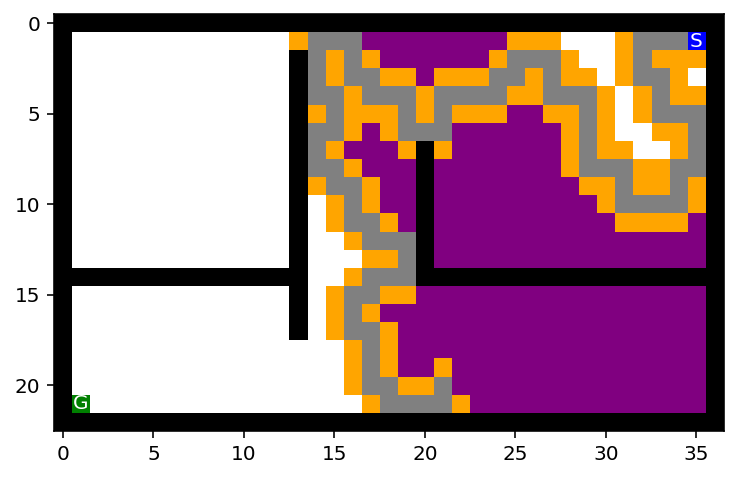

Node - pos = (19, 21); parent = <__main__.Node object at 0x7f100af16df0>; action = North; cost = 90


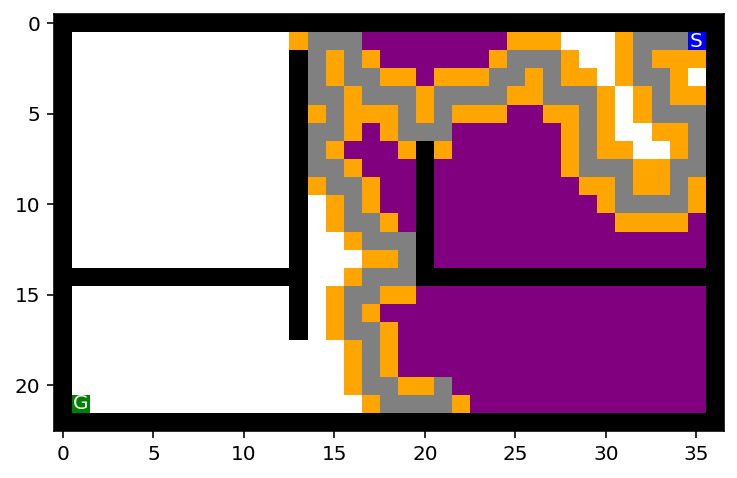

Node - pos = (20, 21); parent = <__main__.Node object at 0x7f100adb0af0>; action = North; cost = 89


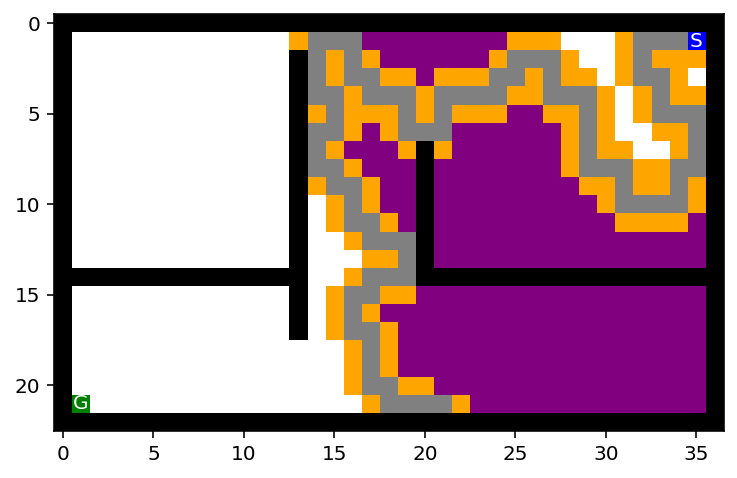

Node - pos = (21, 22); parent = <__main__.Node object at 0x7f100adb0af0>; action = East; cost = 89


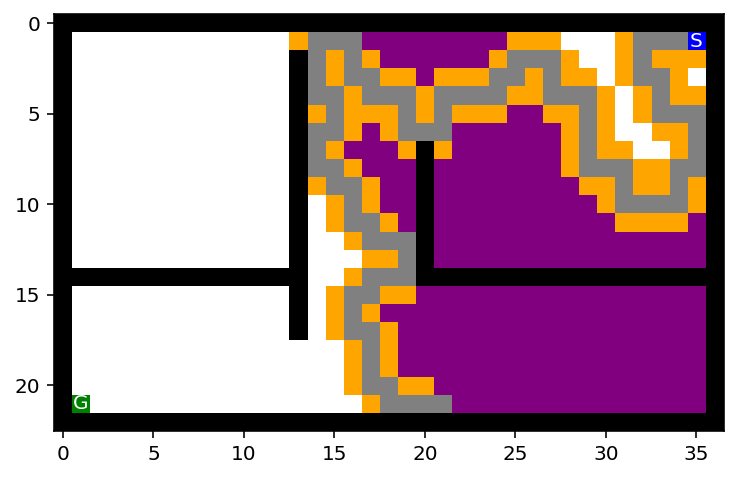

Node - pos = (21, 21); parent = <__main__.Node object at 0x7f100aec2430>; action = East; cost = 88


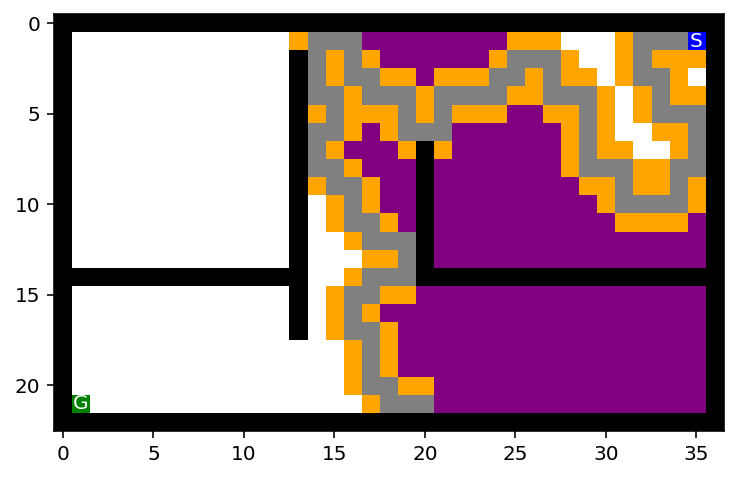

Node - pos = (20, 20); parent = <__main__.Node object at 0x7f100aec2430>; action = North; cost = 88


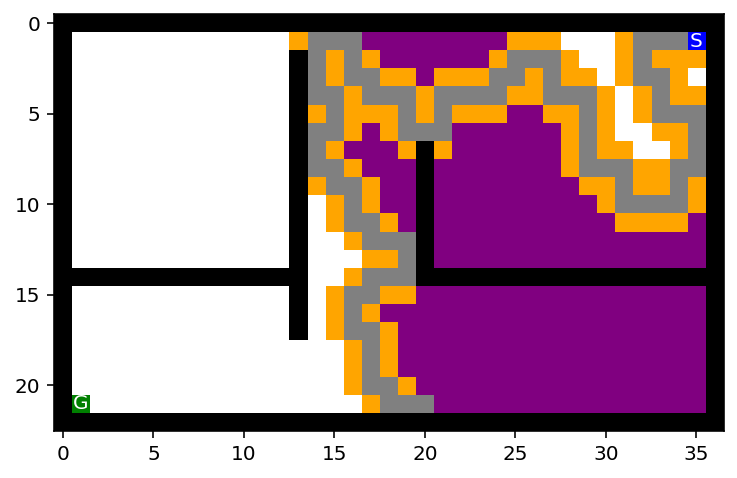

Node - pos = (21, 20); parent = <__main__.Node object at 0x7f100b154c70>; action = East; cost = 87


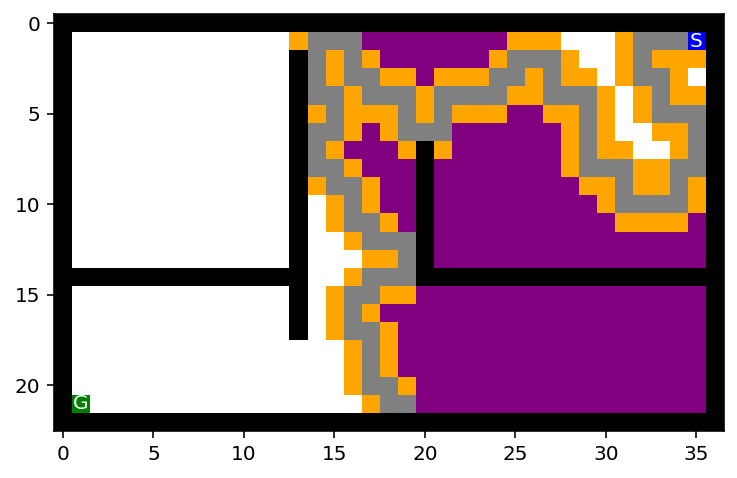

Node - pos = (21, 19); parent = <__main__.Node object at 0x7f100b0060d0>; action = East; cost = 86


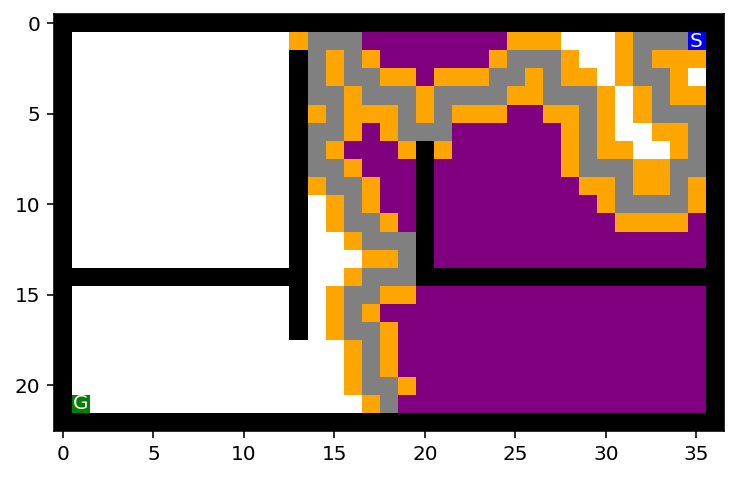

Node - pos = (21, 18); parent = <__main__.Node object at 0x7f100adce100>; action = South; cost = 85


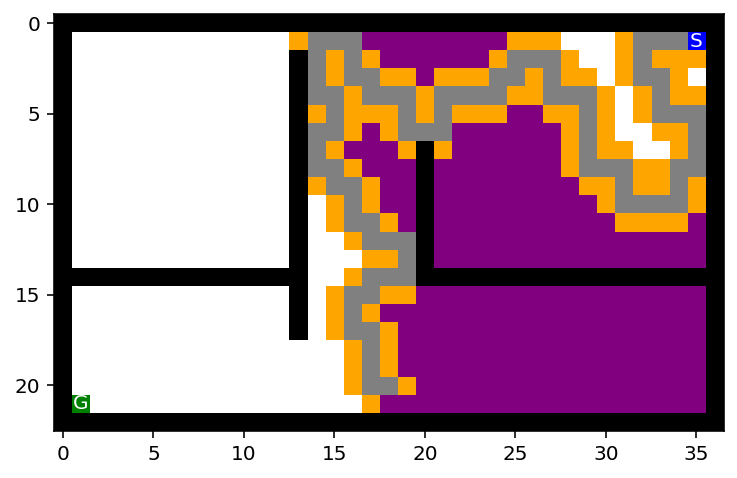

Node - pos = (20, 19); parent = <__main__.Node object at 0x7f100adce100>; action = East; cost = 85


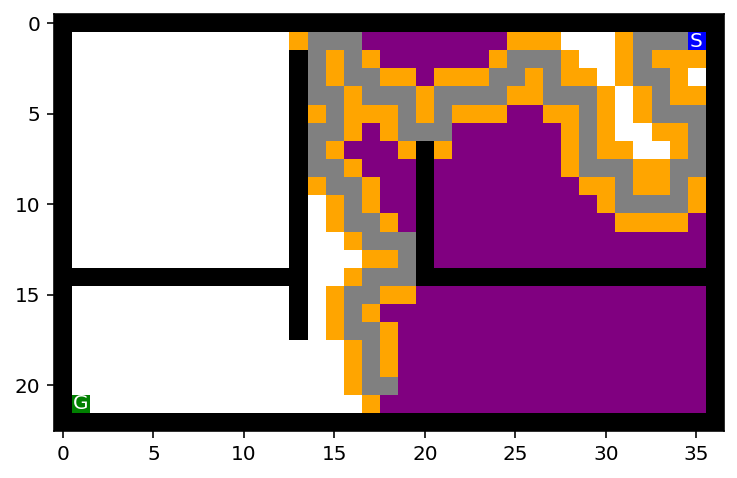

Node - pos = (20, 18); parent = <__main__.Node object at 0x7f100ada8bb0>; action = East; cost = 84


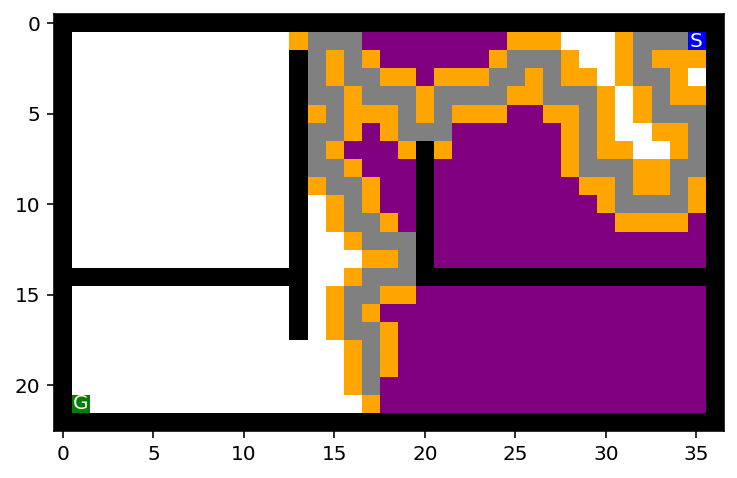

Node - pos = (21, 17); parent = <__main__.Node object at 0x7f100ada8bb0>; action = South; cost = 84


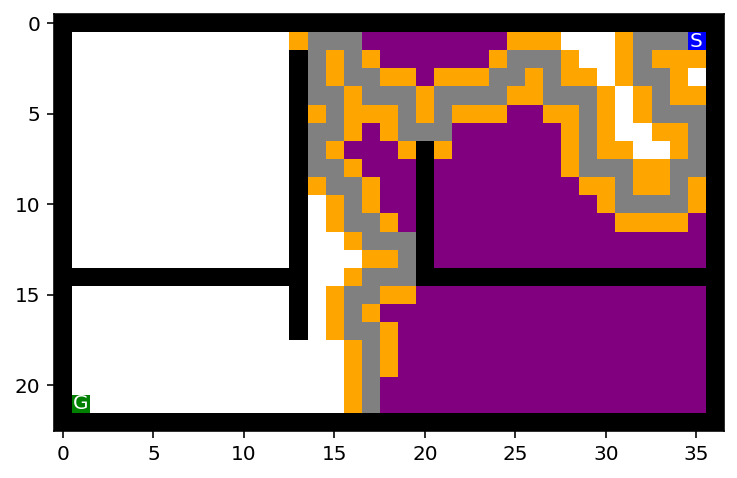

Node - pos = (21, 16); parent = <__main__.Node object at 0x7f100adce4c0>; action = West; cost = 85


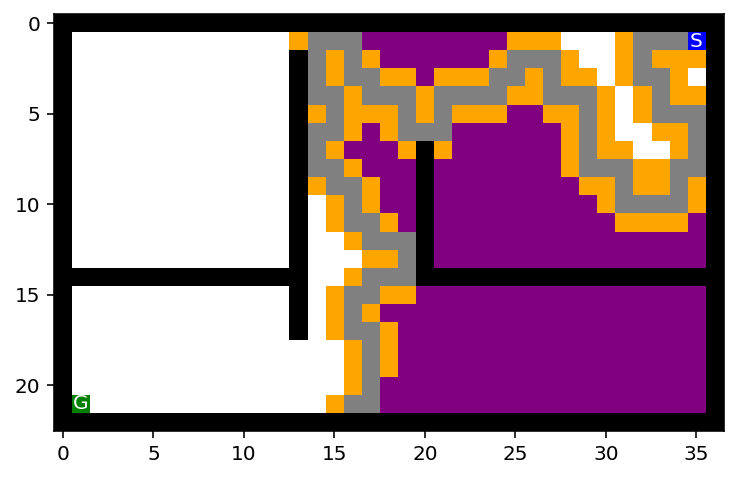

Node - pos = (21, 15); parent = <__main__.Node object at 0x7f100adc7700>; action = West; cost = 86


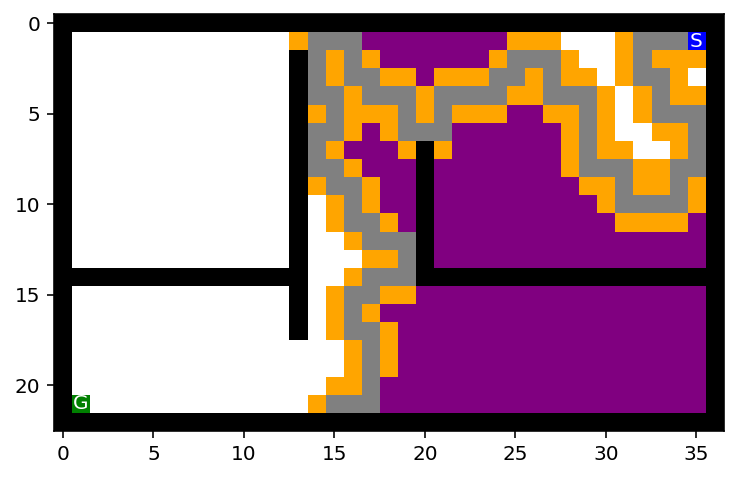

Node - pos = (20, 15); parent = <__main__.Node object at 0x7f100ae584f0>; action = North; cost = 87


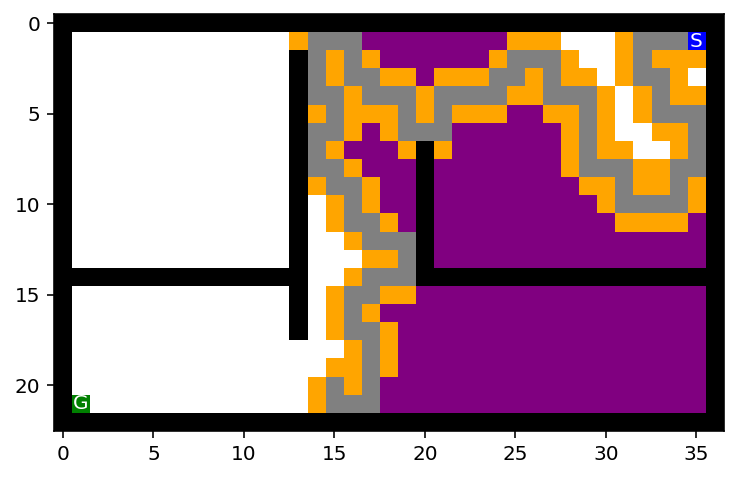

Node - pos = (20, 14); parent = <__main__.Node object at 0x7f100ad9b5e0>; action = West; cost = 88


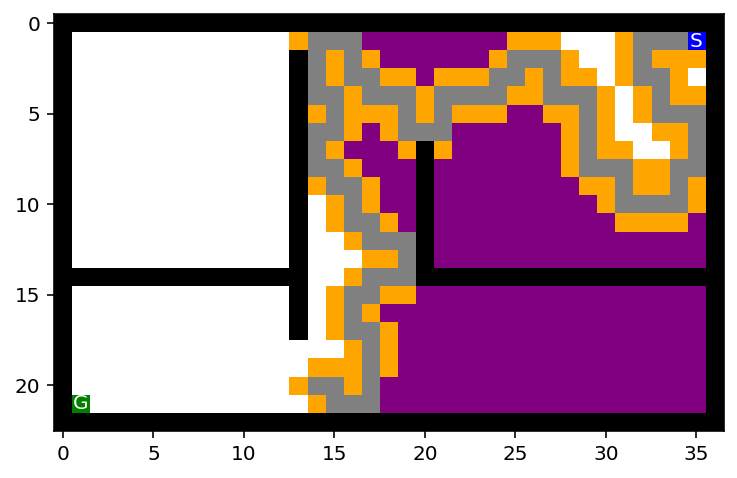

Node - pos = (19, 14); parent = <__main__.Node object at 0x7f100ad70eb0>; action = North; cost = 89


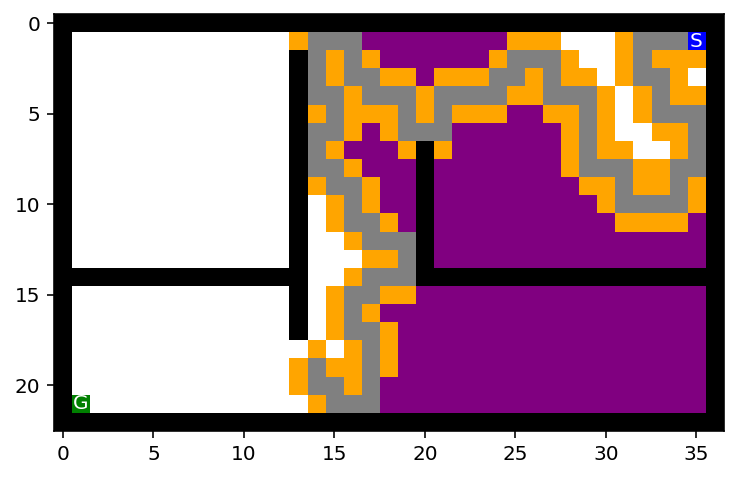

Node - pos = (18, 14); parent = <__main__.Node object at 0x7f100b1b2b20>; action = North; cost = 90


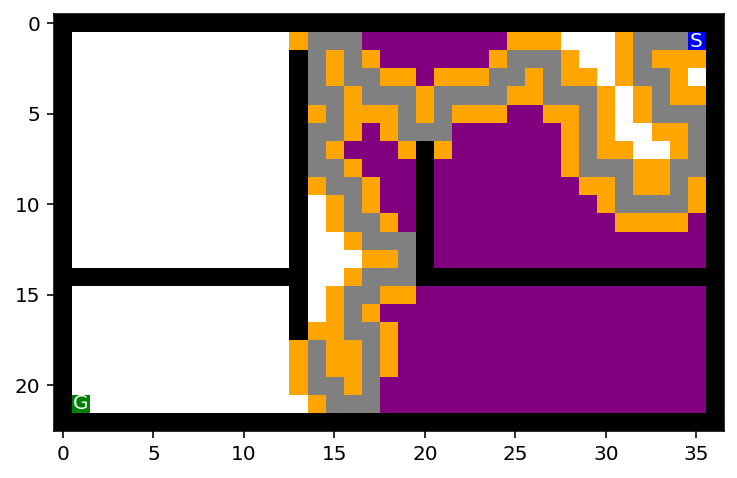

Node - pos = (18, 15); parent = <__main__.Node object at 0x7f100b0d3730>; action = East; cost = 91


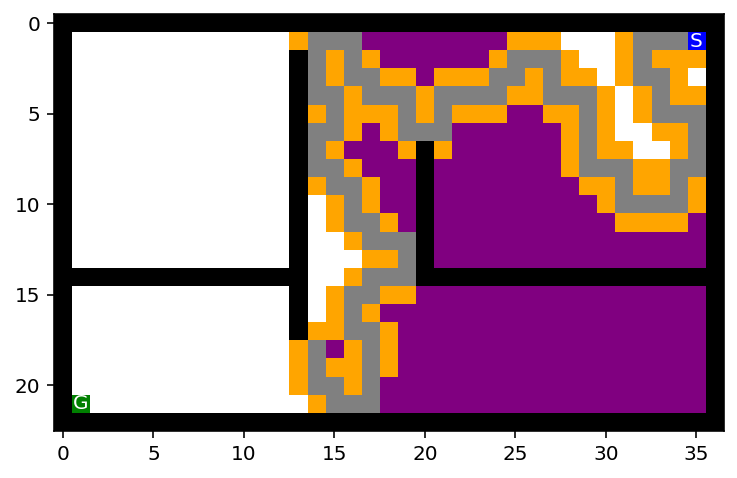

Node - pos = (17, 14); parent = <__main__.Node object at 0x7f100b0d3730>; action = North; cost = 91


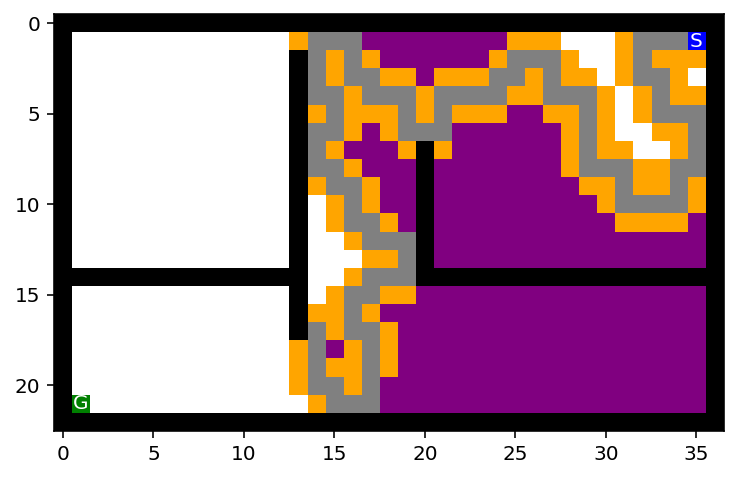

Node - pos = (16, 14); parent = <__main__.Node object at 0x7f100af80ac0>; action = North; cost = 92


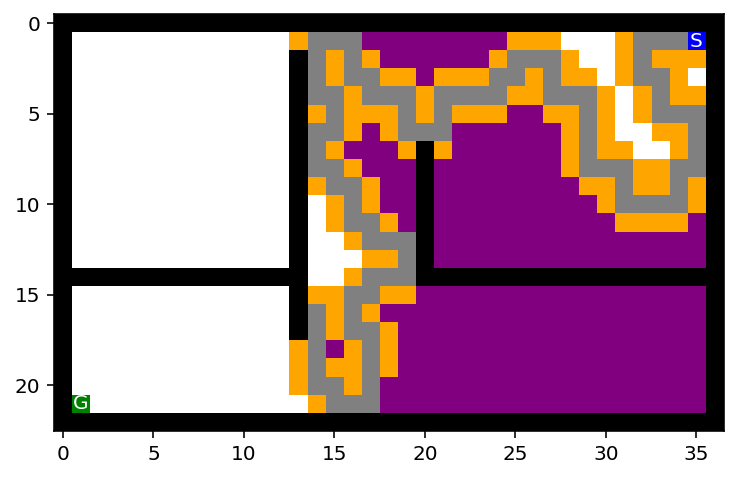

Node - pos = (15, 14); parent = <__main__.Node object at 0x7f100b13c940>; action = North; cost = 93


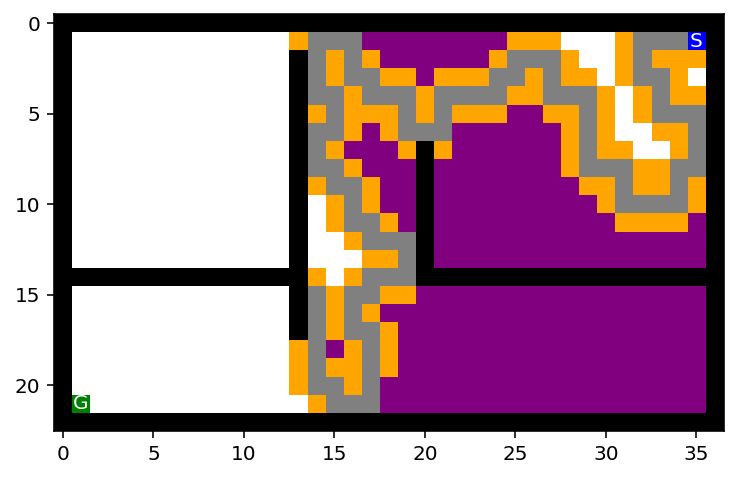

Node - pos = (14, 14); parent = <__main__.Node object at 0x7f100b0697f0>; action = North; cost = 94


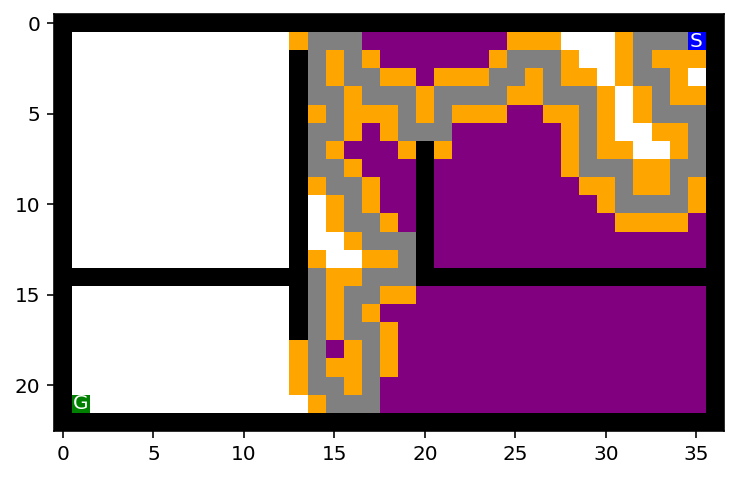

Node - pos = (13, 14); parent = <__main__.Node object at 0x7f100aec2670>; action = North; cost = 95


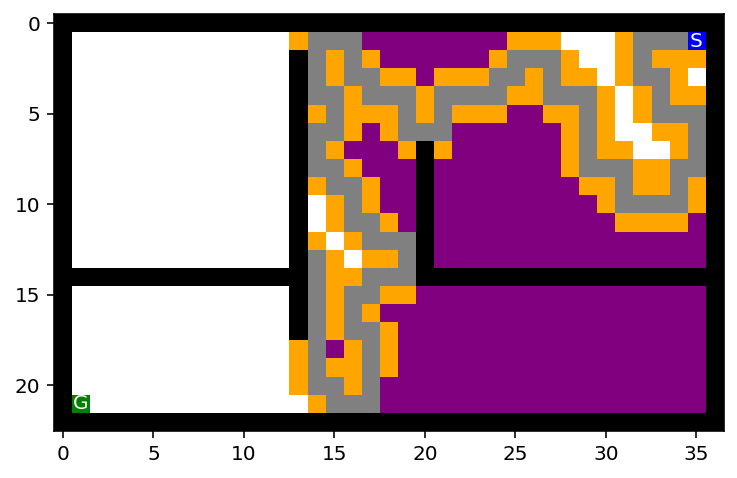

Node - pos = (12, 14); parent = <__main__.Node object at 0x7f100af38a90>; action = North; cost = 96


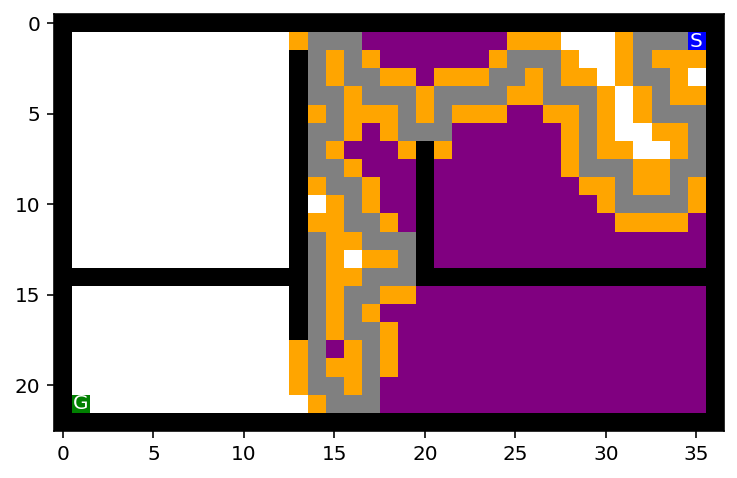

Node - pos = (12, 15); parent = <__main__.Node object at 0x7f100b0ac6a0>; action = East; cost = 97


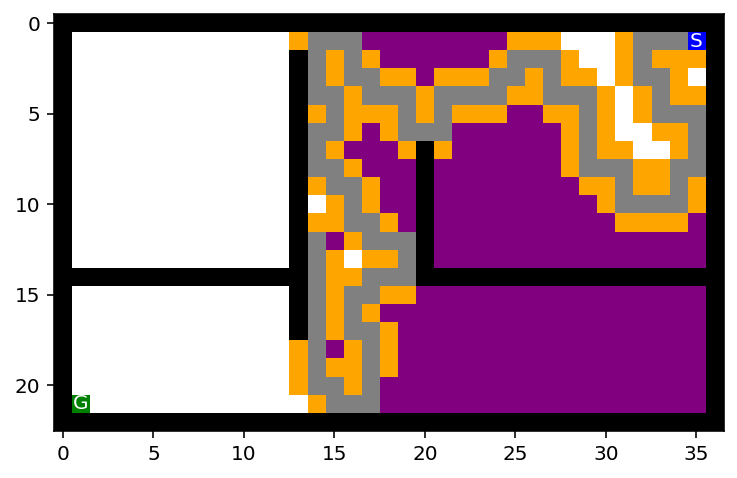

Node - pos = (11, 14); parent = <__main__.Node object at 0x7f100b0ac6a0>; action = North; cost = 97


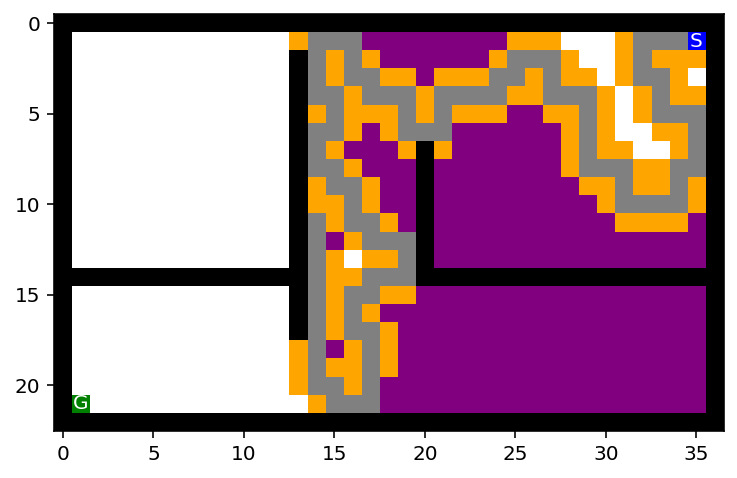

Node - pos = (10, 14); parent = <__main__.Node object at 0x7f100af24fa0>; action = North; cost = 98


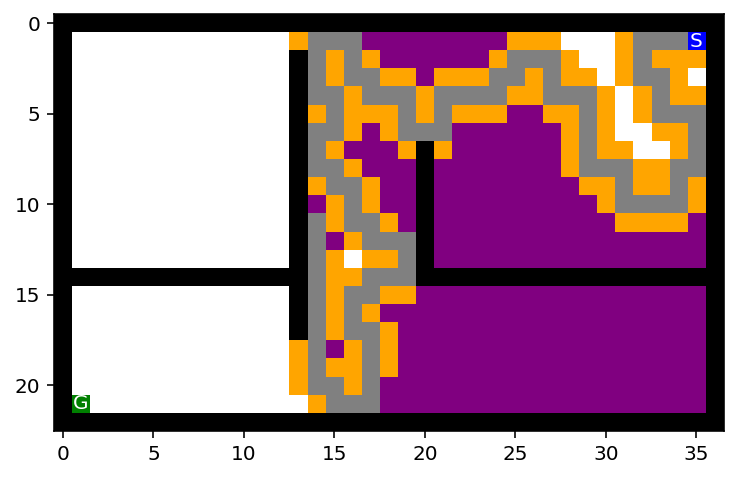

Node - pos = (11, 14); parent = <__main__.Node object at 0x7f100b0ac6a0>; action = North; cost = 97


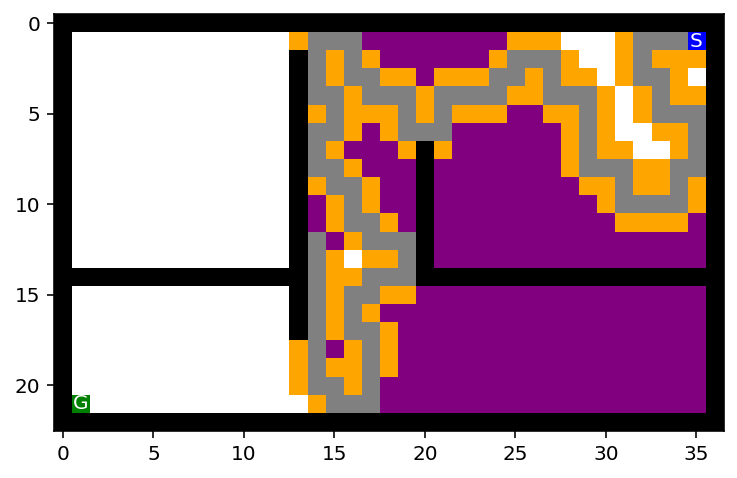

Node - pos = (12, 14); parent = <__main__.Node object at 0x7f100af38a90>; action = North; cost = 96


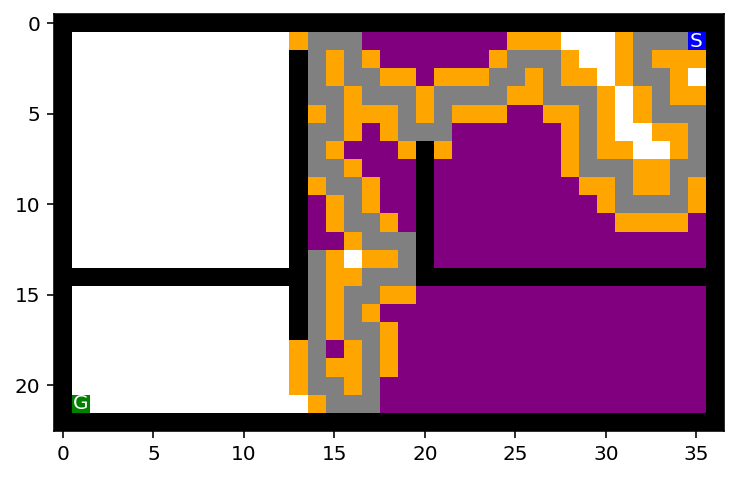

Node - pos = (13, 15); parent = <__main__.Node object at 0x7f100af38a90>; action = East; cost = 96


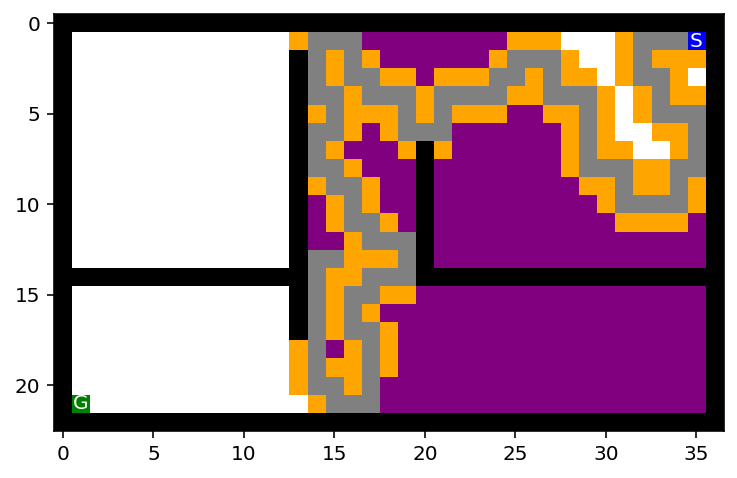

Node - pos = (13, 16); parent = <__main__.Node object at 0x7f100b0ac790>; action = East; cost = 97


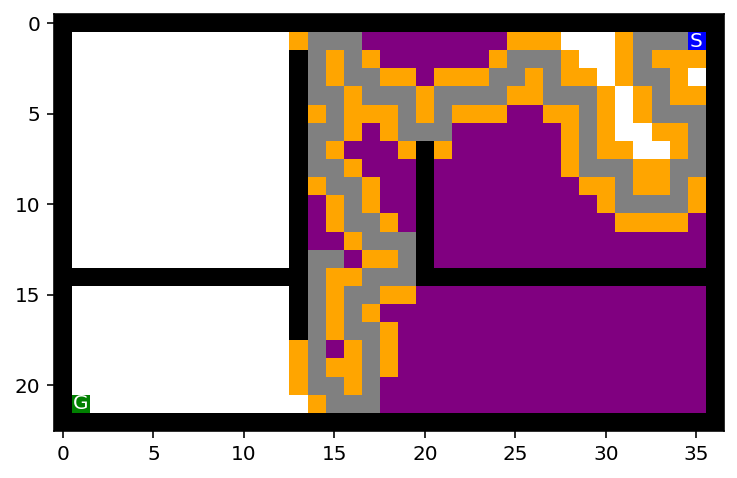

Node - pos = (13, 15); parent = <__main__.Node object at 0x7f100af38a90>; action = East; cost = 96


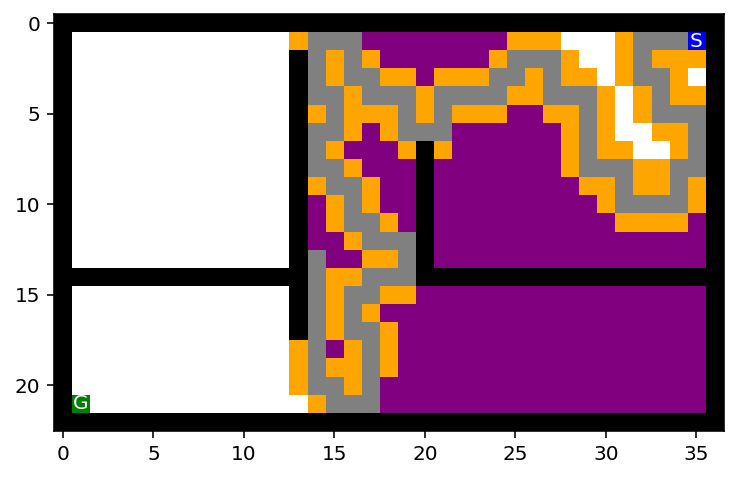

Node - pos = (13, 14); parent = <__main__.Node object at 0x7f100aec2670>; action = North; cost = 95


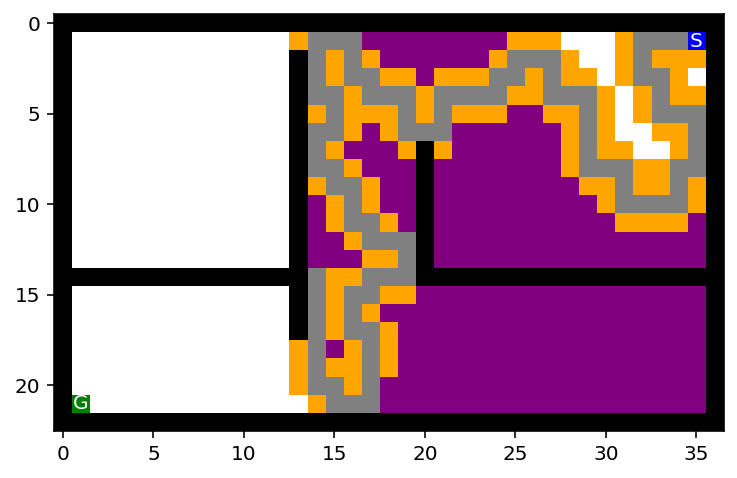

Node - pos = (14, 15); parent = <__main__.Node object at 0x7f100aec2670>; action = East; cost = 95


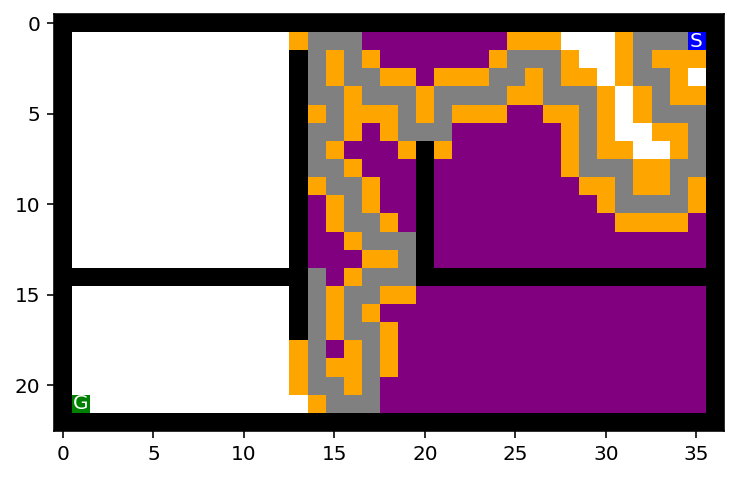

Node - pos = (14, 14); parent = <__main__.Node object at 0x7f100b0697f0>; action = North; cost = 94


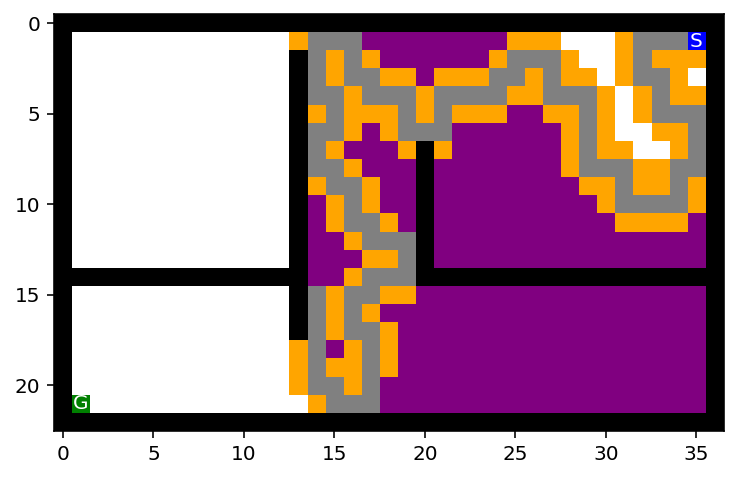

Node - pos = (15, 14); parent = <__main__.Node object at 0x7f100b13c940>; action = North; cost = 93


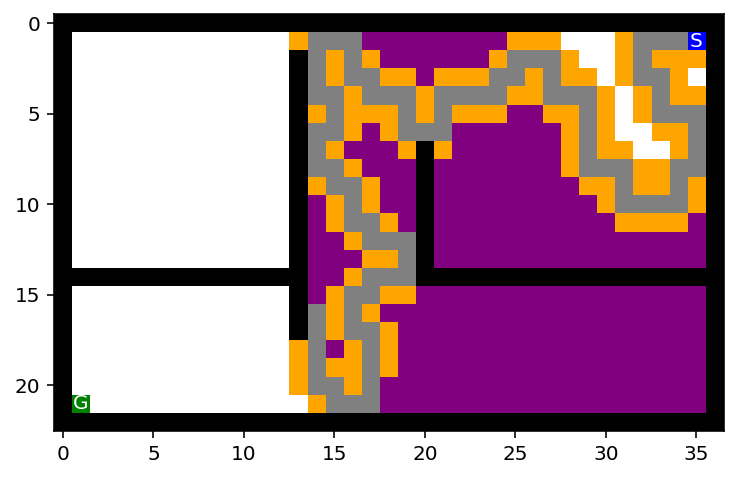

Node - pos = (16, 14); parent = <__main__.Node object at 0x7f100af80ac0>; action = North; cost = 92


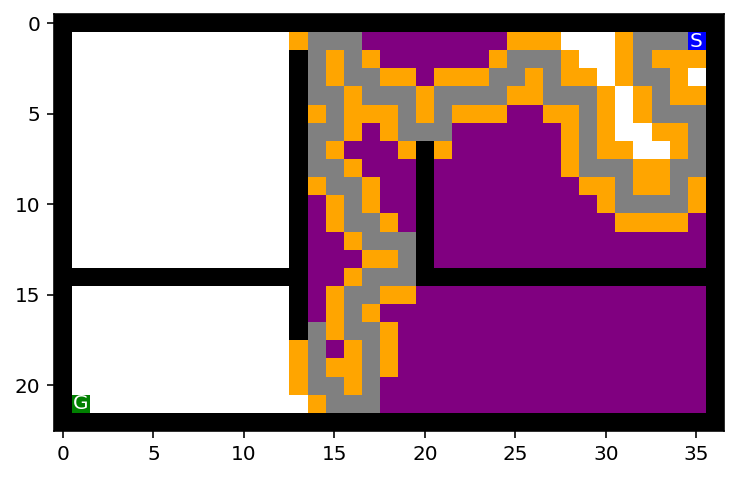

Node - pos = (17, 14); parent = <__main__.Node object at 0x7f100b0d3730>; action = North; cost = 91


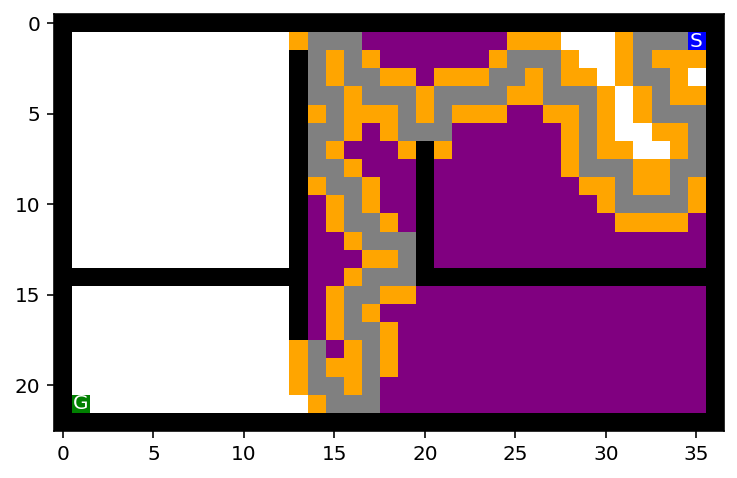

Node - pos = (18, 13); parent = <__main__.Node object at 0x7f100b0d3730>; action = West; cost = 91


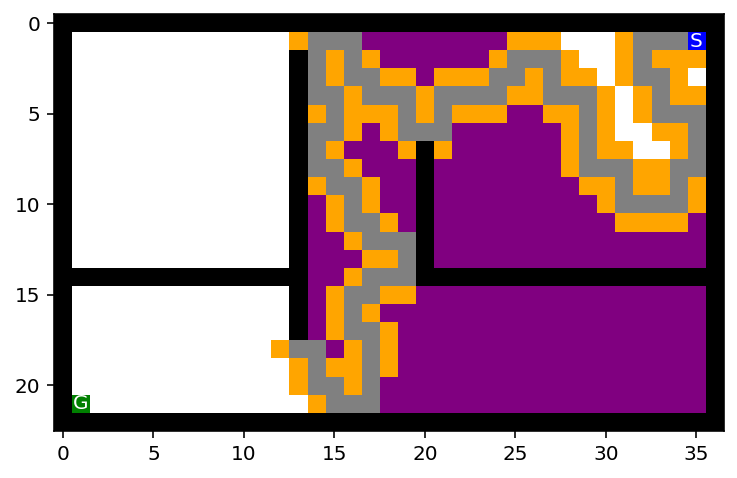

Node - pos = (18, 12); parent = <__main__.Node object at 0x7f100af80ca0>; action = West; cost = 92


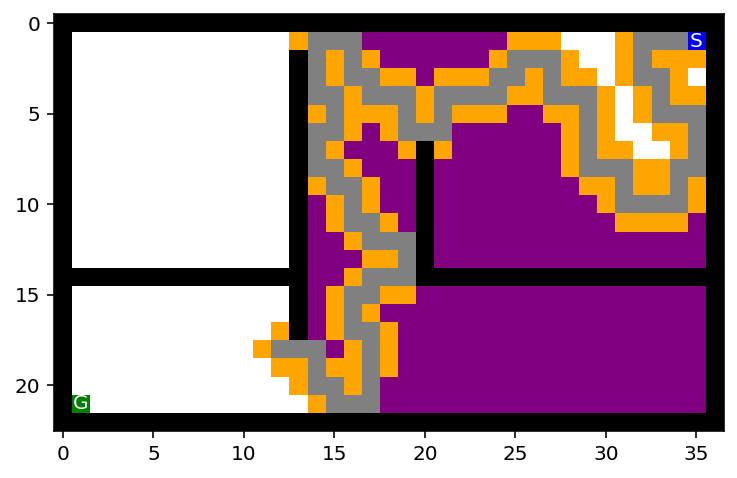

Node - pos = (17, 12); parent = <__main__.Node object at 0x7f100ade1be0>; action = North; cost = 93


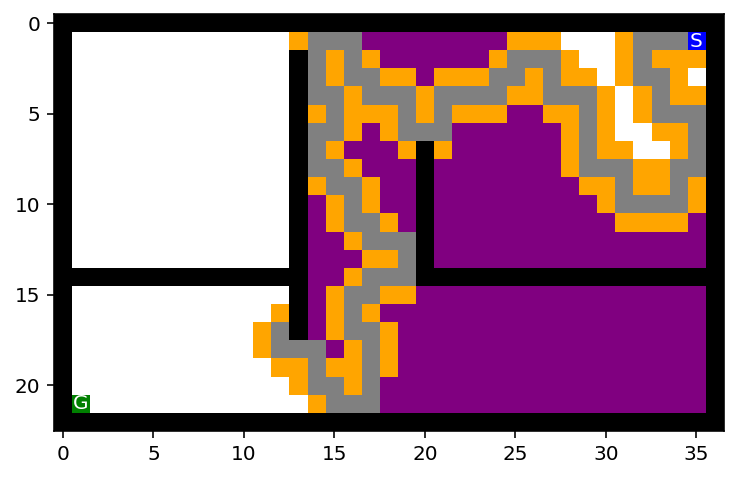

Node - pos = (17, 11); parent = <__main__.Node object at 0x7f100ad8de20>; action = West; cost = 94


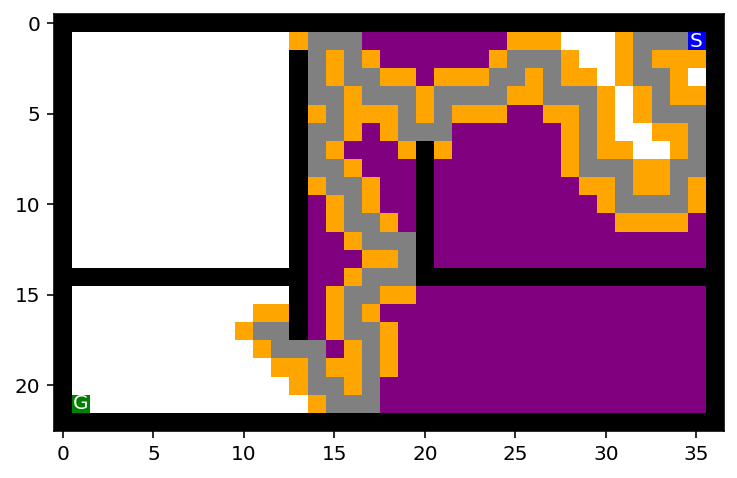

Node - pos = (16, 11); parent = <__main__.Node object at 0x7f100ae17d30>; action = North; cost = 95


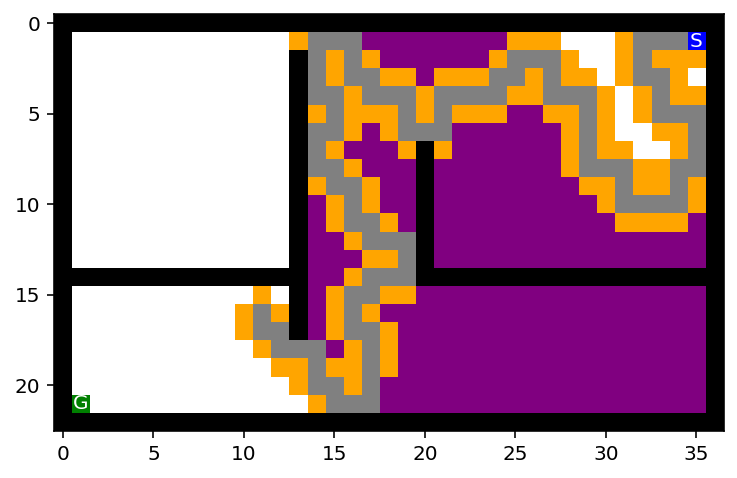

Node - pos = (15, 11); parent = <__main__.Node object at 0x7f100adf5940>; action = North; cost = 96


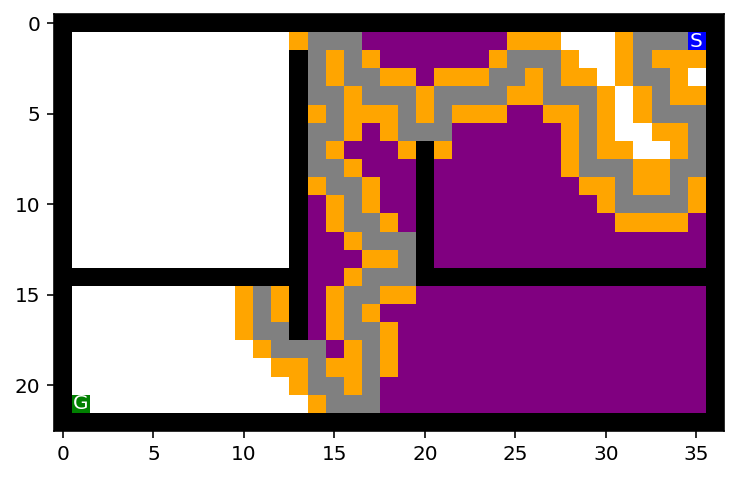

Node - pos = (15, 10); parent = <__main__.Node object at 0x7f100ae171f0>; action = West; cost = 97


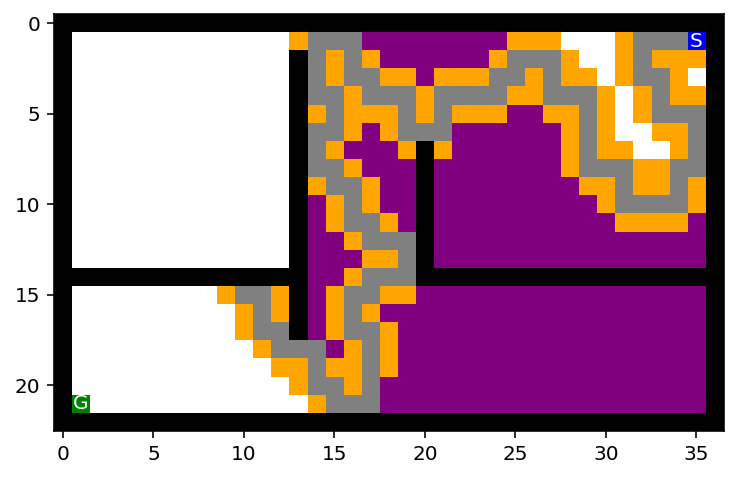

Node - pos = (15, 9); parent = <__main__.Node object at 0x7f100ada8520>; action = West; cost = 98


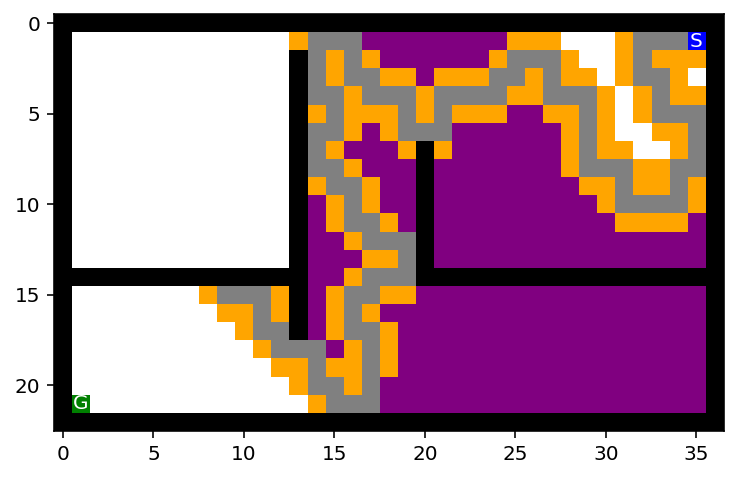

Node - pos = (15, 8); parent = <__main__.Node object at 0x7f100b00ad90>; action = West; cost = 99


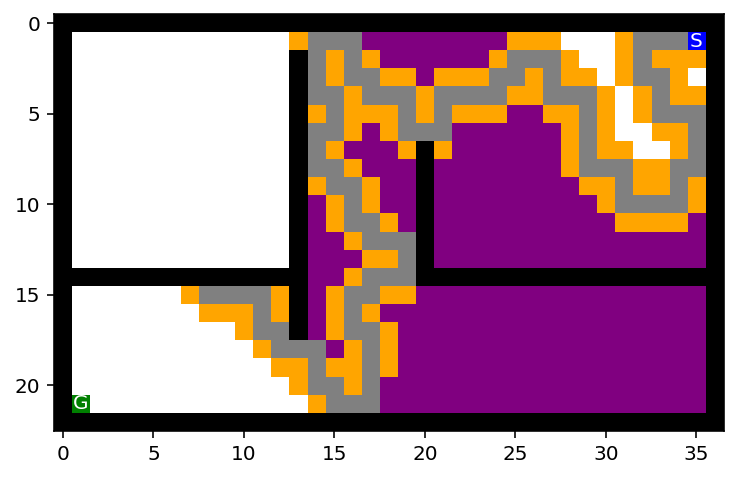

Node - pos = (16, 8); parent = <__main__.Node object at 0x7f100ad433a0>; action = South; cost = 100


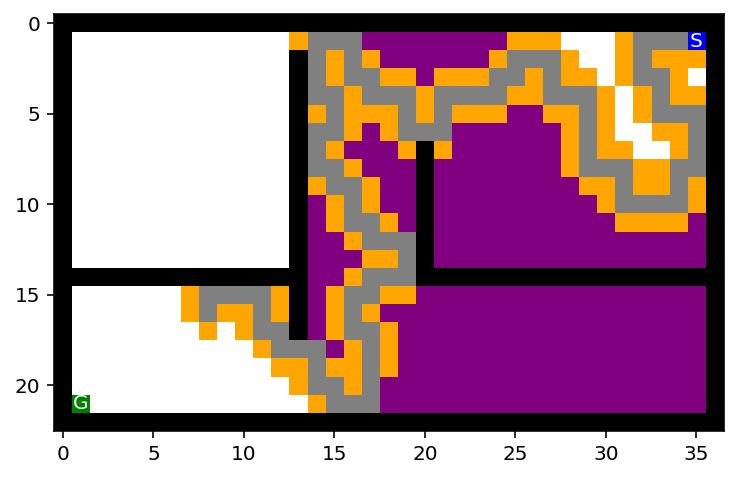

Node - pos = (17, 8); parent = <__main__.Node object at 0x7f100ae30e50>; action = South; cost = 101


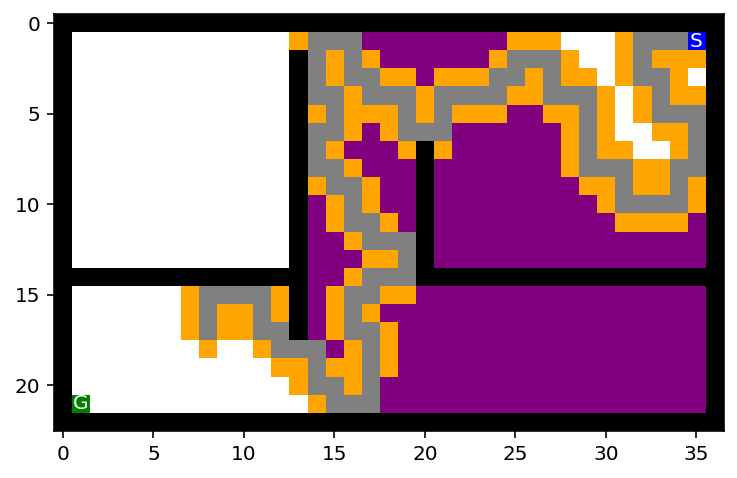

Node - pos = (17, 9); parent = <__main__.Node object at 0x7f100b15e6d0>; action = East; cost = 102


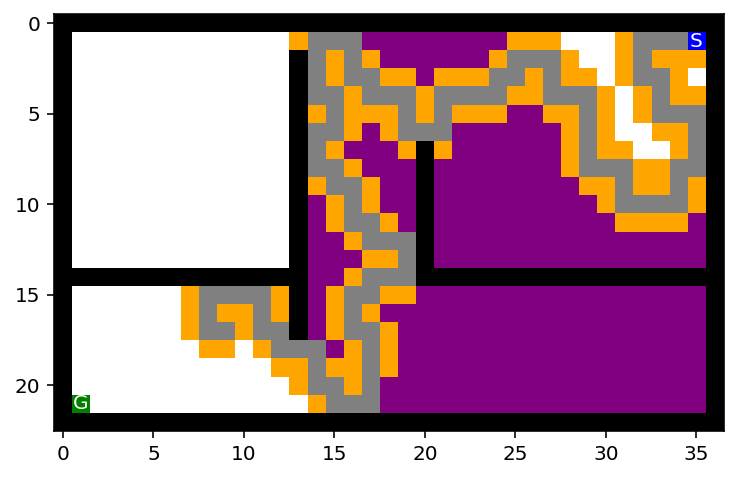

Node - pos = (18, 9); parent = <__main__.Node object at 0x7f100b1875e0>; action = South; cost = 103


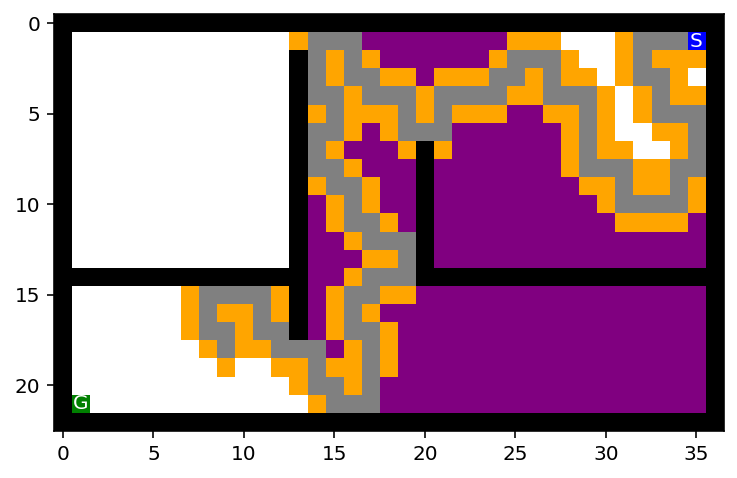

Node - pos = (18, 10); parent = <__main__.Node object at 0x7f100b0780d0>; action = East; cost = 104


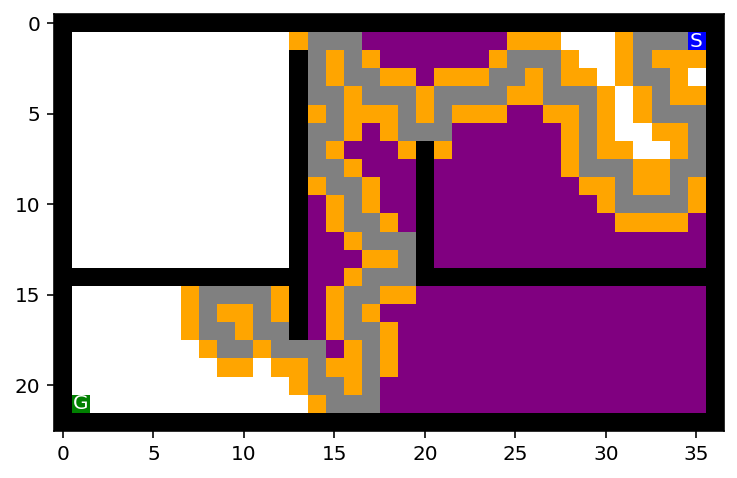

Node - pos = (19, 10); parent = <__main__.Node object at 0x7f100af431c0>; action = South; cost = 105


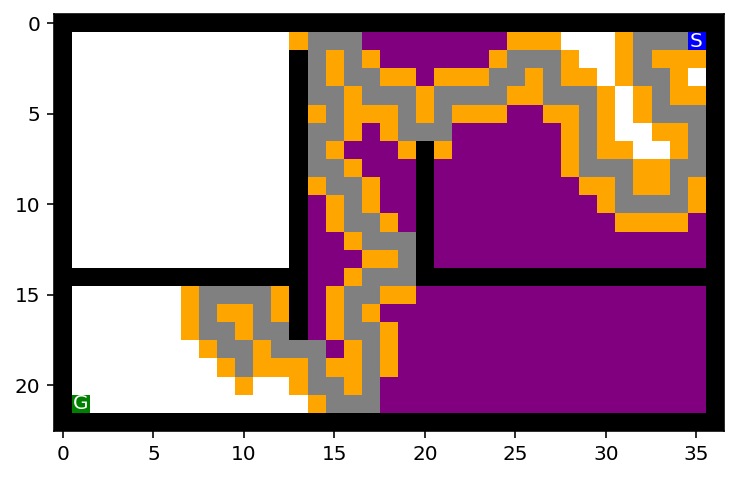

Node - pos = (20, 10); parent = <__main__.Node object at 0x7f100aec7e20>; action = South; cost = 106


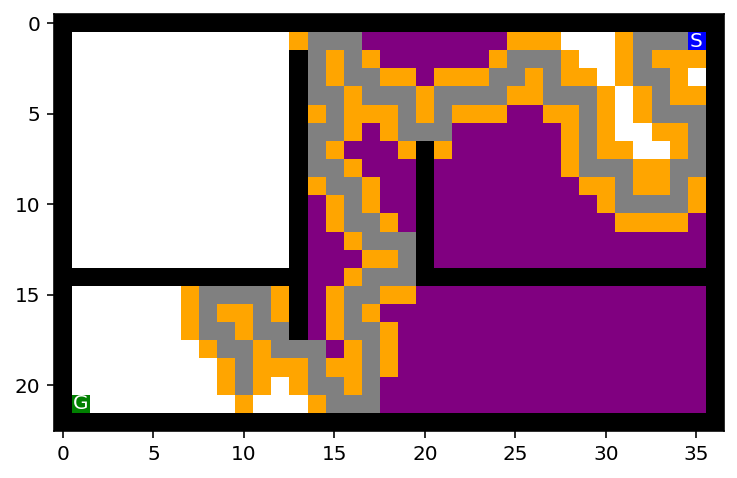

Node - pos = (20, 11); parent = <__main__.Node object at 0x7f100ad70af0>; action = East; cost = 107


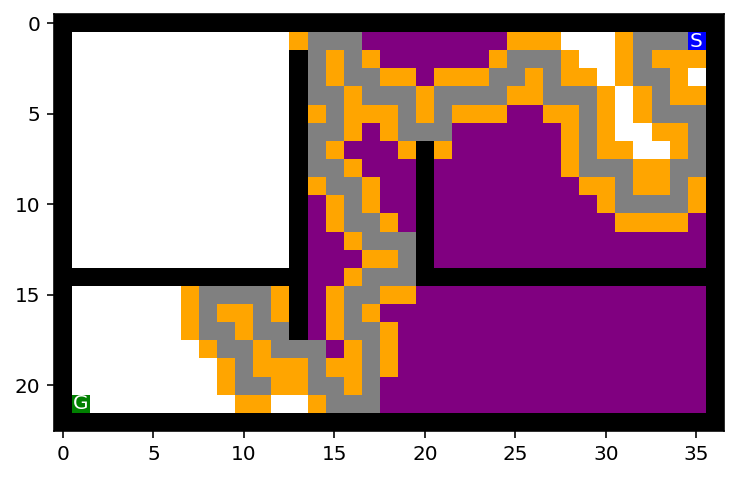

Node - pos = (21, 11); parent = <__main__.Node object at 0x7f100b191ca0>; action = South; cost = 108


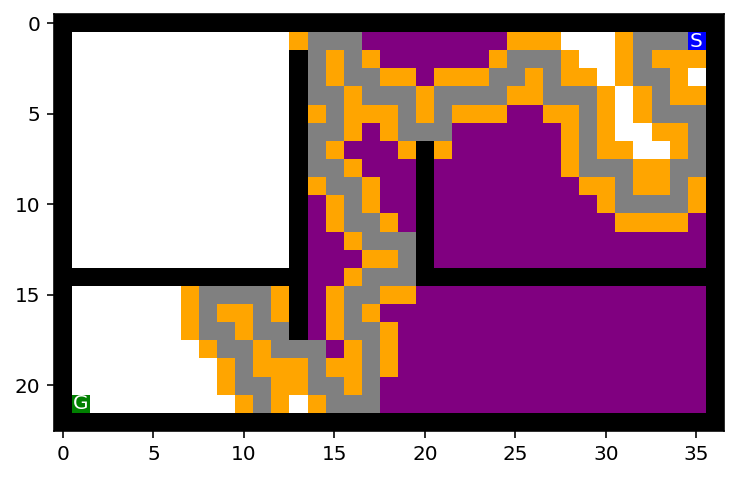

Node - pos = (21, 12); parent = <__main__.Node object at 0x7f100ae5dd30>; action = East; cost = 109


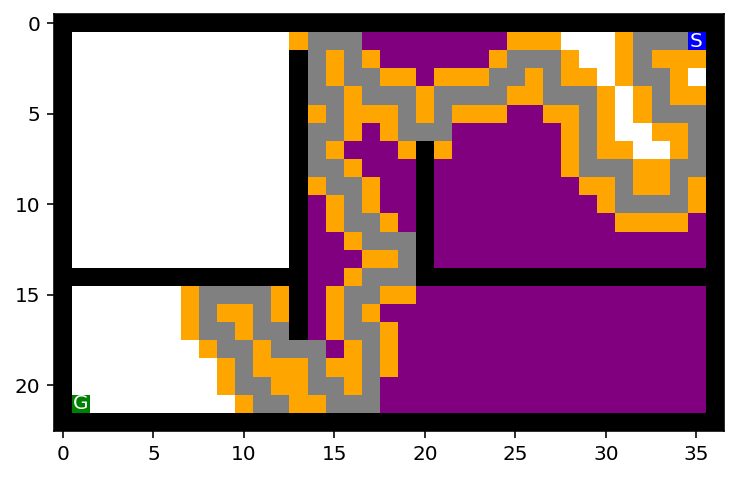

Node - pos = (21, 13); parent = <__main__.Node object at 0x7f100af01610>; action = East; cost = 110


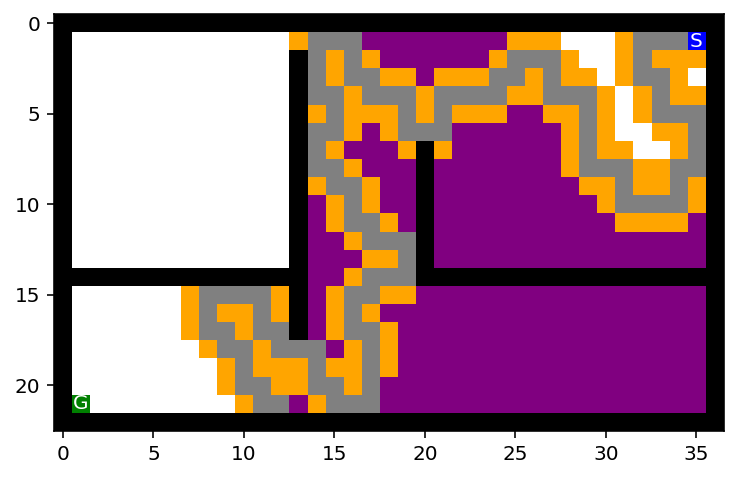

Node - pos = (21, 12); parent = <__main__.Node object at 0x7f100ae5dd30>; action = East; cost = 109


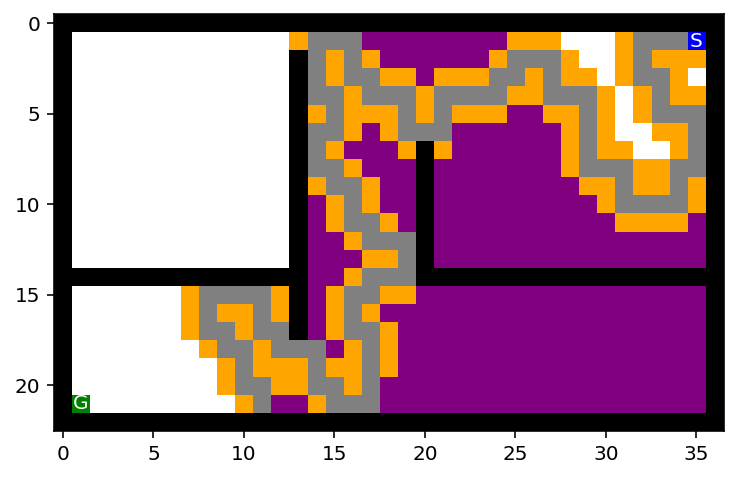

Node - pos = (21, 11); parent = <__main__.Node object at 0x7f100b191ca0>; action = South; cost = 108


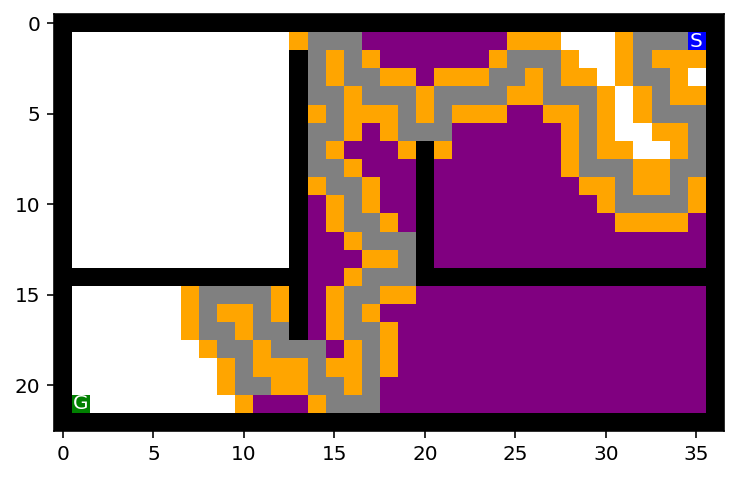

Node - pos = (20, 12); parent = <__main__.Node object at 0x7f100b191ca0>; action = East; cost = 108


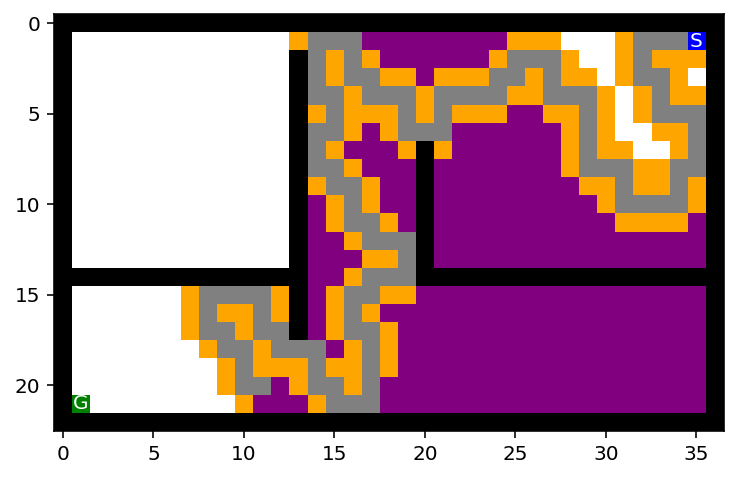

Node - pos = (20, 11); parent = <__main__.Node object at 0x7f100ad70af0>; action = East; cost = 107


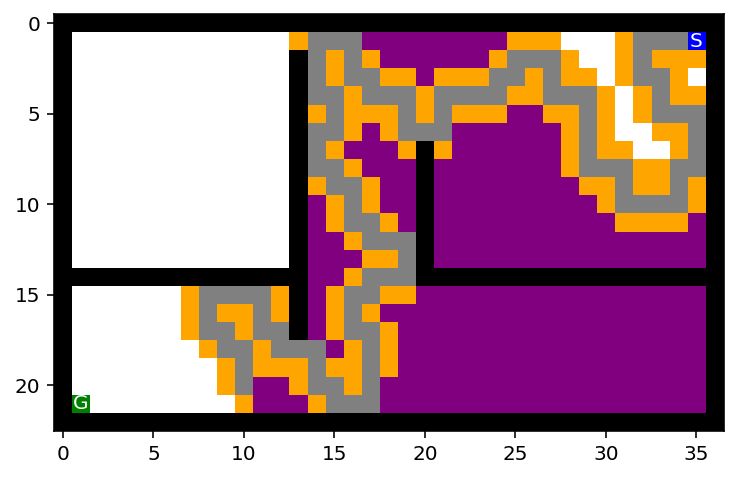

Node - pos = (20, 9); parent = <__main__.Node object at 0x7f100ad70af0>; action = West; cost = 107


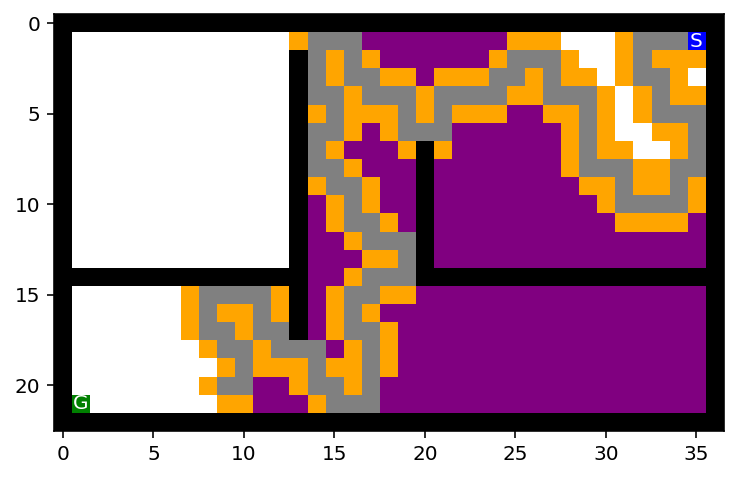

Node - pos = (21, 9); parent = <__main__.Node object at 0x7f102a23c850>; action = South; cost = 108


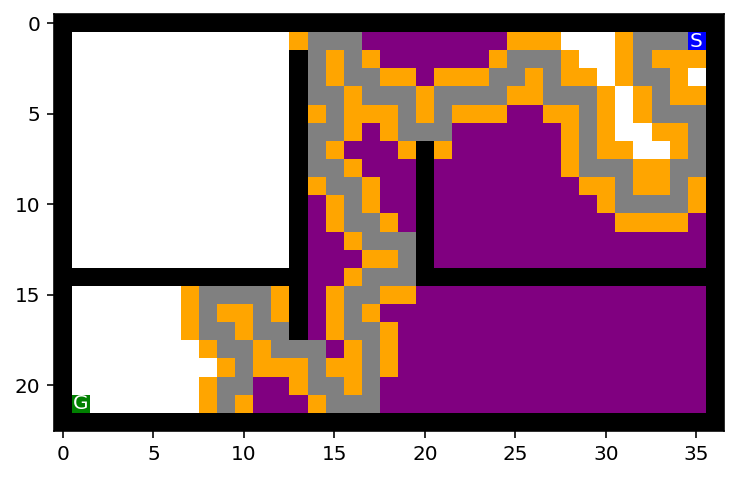

Node - pos = (21, 8); parent = <__main__.Node object at 0x7f100af80a00>; action = West; cost = 109


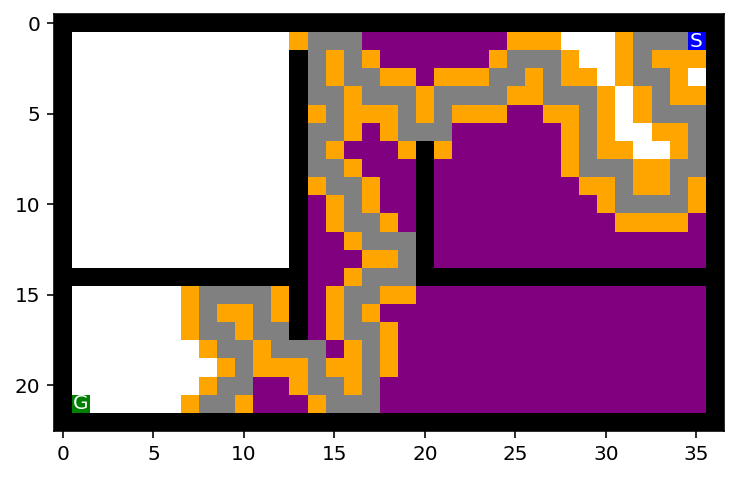

Node - pos = (21, 7); parent = <__main__.Node object at 0x7f100b083610>; action = West; cost = 110


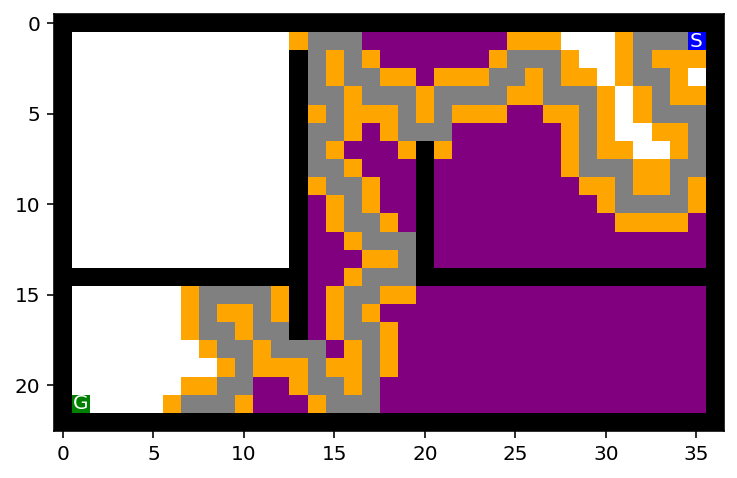

Node - pos = (20, 7); parent = <__main__.Node object at 0x7f100ad65b80>; action = North; cost = 111


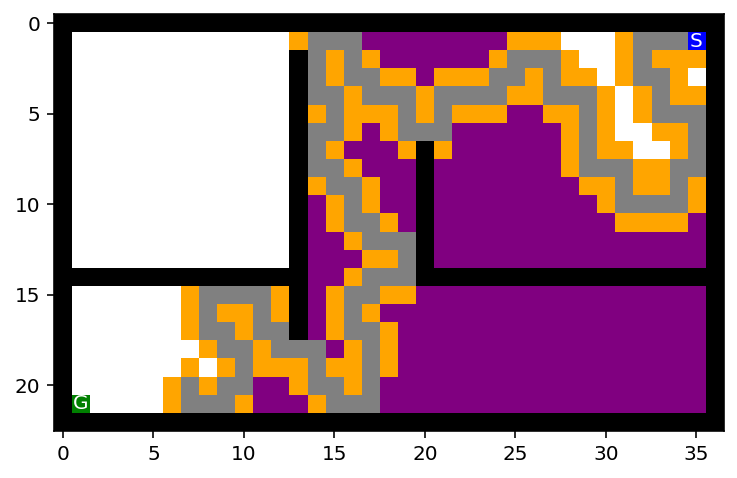

Node - pos = (19, 7); parent = <__main__.Node object at 0x7f100ae074c0>; action = North; cost = 112


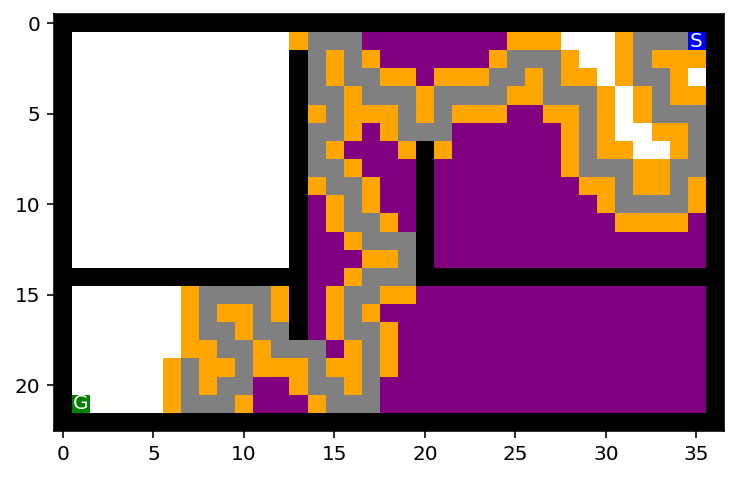

Node - pos = (19, 8); parent = <__main__.Node object at 0x7f100ae52c10>; action = East; cost = 113


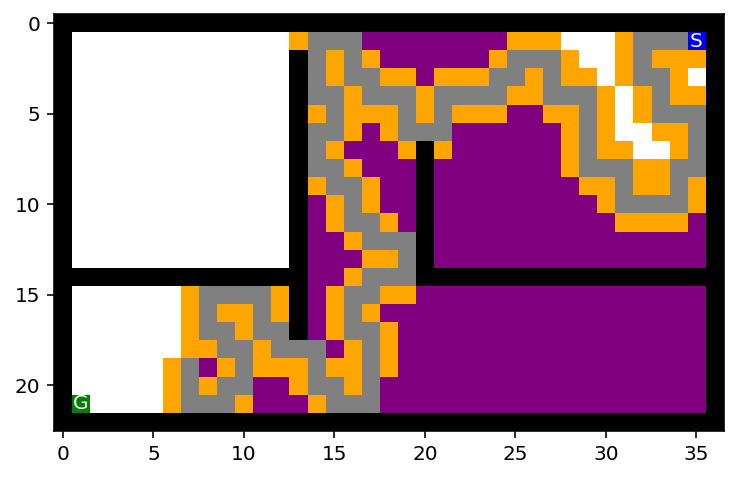

Node - pos = (18, 7); parent = <__main__.Node object at 0x7f100ae52c10>; action = North; cost = 113


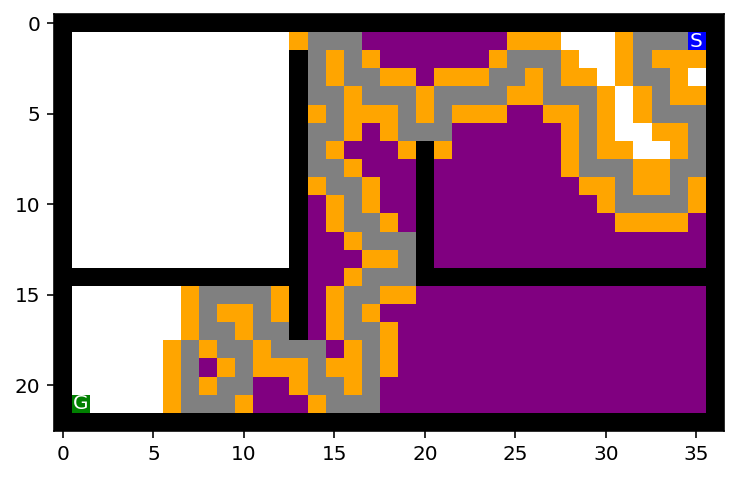

Node - pos = (18, 6); parent = <__main__.Node object at 0x7f100ad53490>; action = West; cost = 114


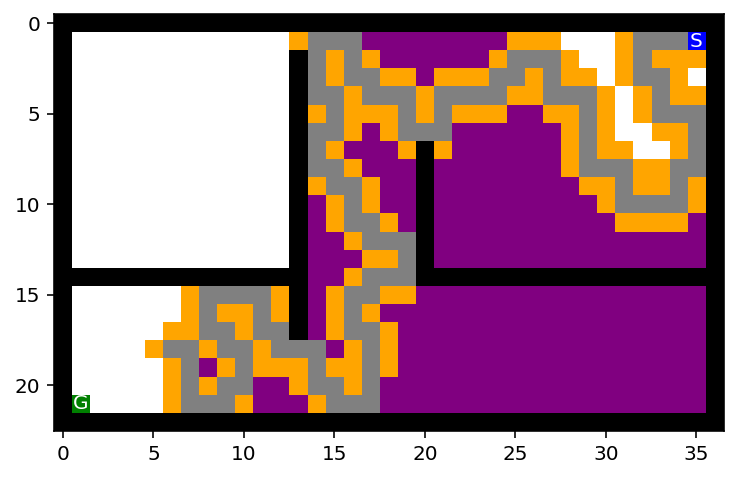

Node - pos = (17, 6); parent = <__main__.Node object at 0x7f100ad43160>; action = North; cost = 115


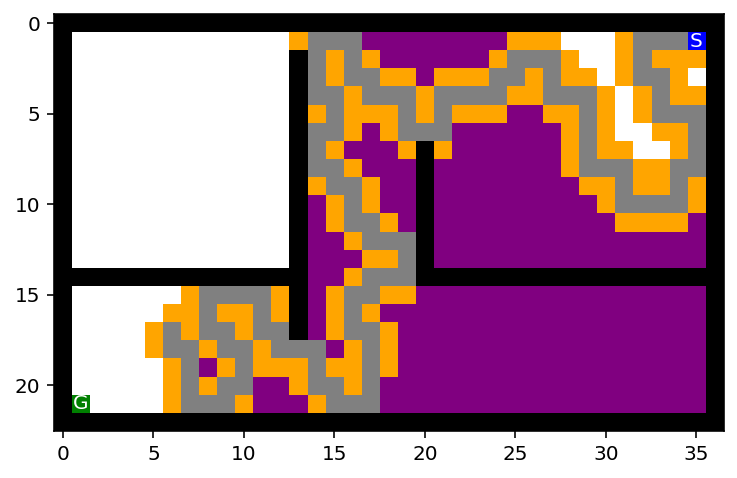

Node - pos = (17, 5); parent = <__main__.Node object at 0x7f100aefca00>; action = West; cost = 116


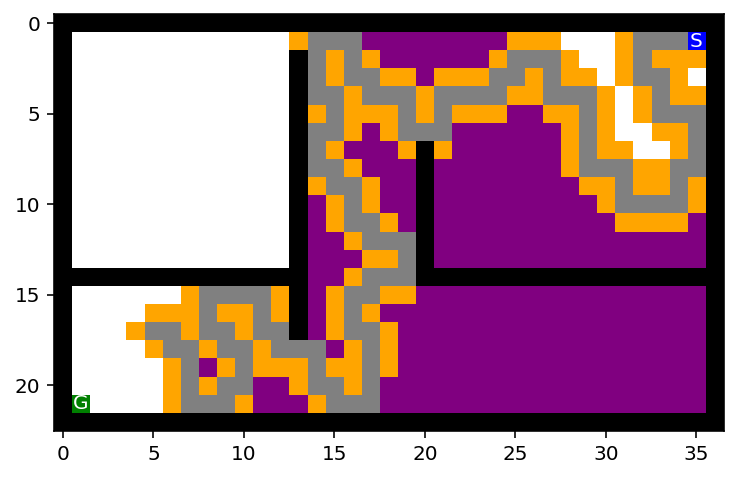

Node - pos = (16, 5); parent = <__main__.Node object at 0x7f100b1b8a30>; action = North; cost = 117


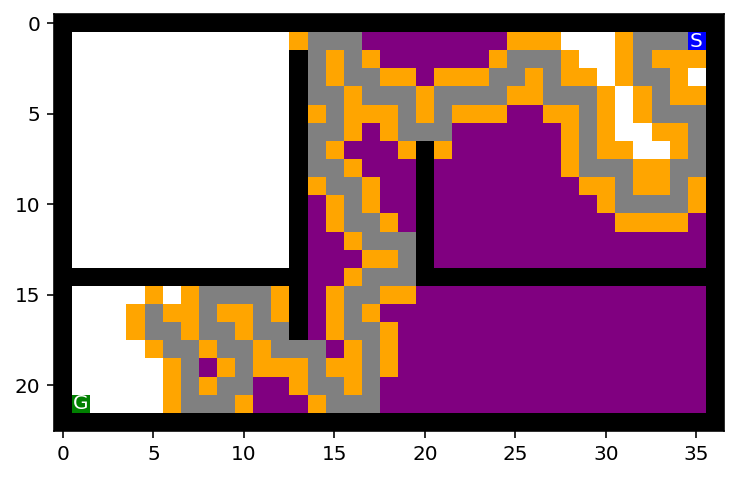

Node - pos = (15, 5); parent = <__main__.Node object at 0x7f100af43c70>; action = North; cost = 118


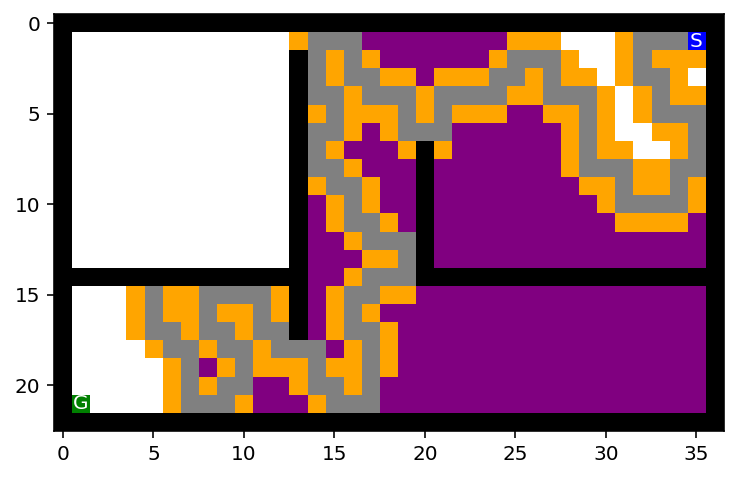

Node - pos = (15, 6); parent = <__main__.Node object at 0x7f100b00a520>; action = East; cost = 119


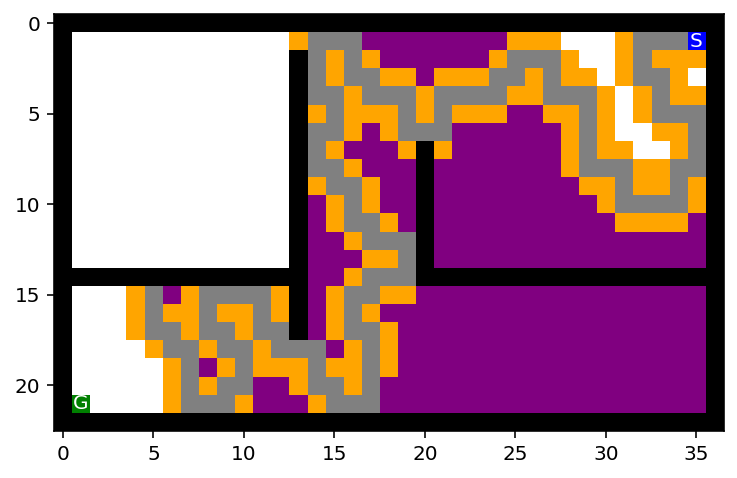

Node - pos = (15, 4); parent = <__main__.Node object at 0x7f100b00a520>; action = West; cost = 119


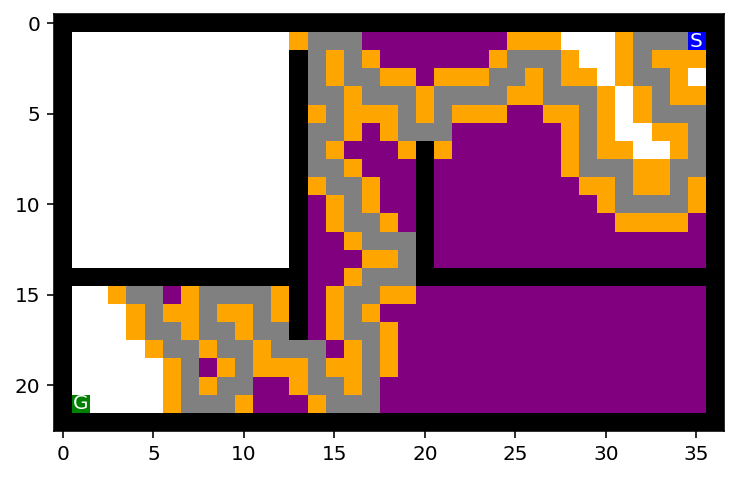

Node - pos = (15, 3); parent = <__main__.Node object at 0x7f100af805b0>; action = West; cost = 120


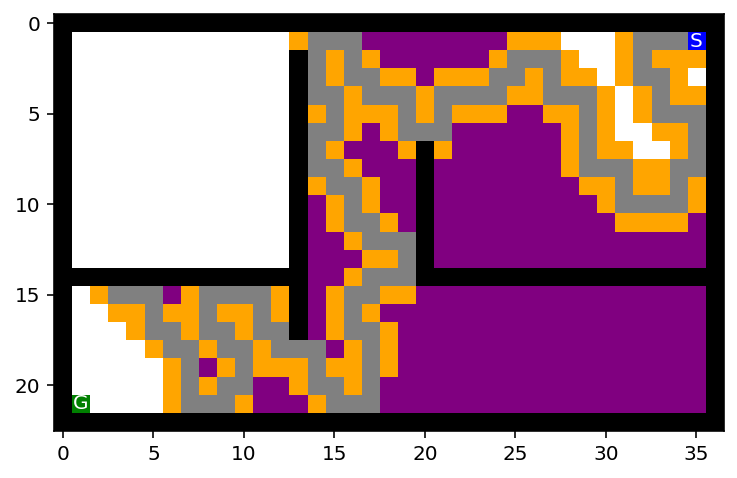

Node - pos = (15, 2); parent = <__main__.Node object at 0x7f100ad9a160>; action = West; cost = 121


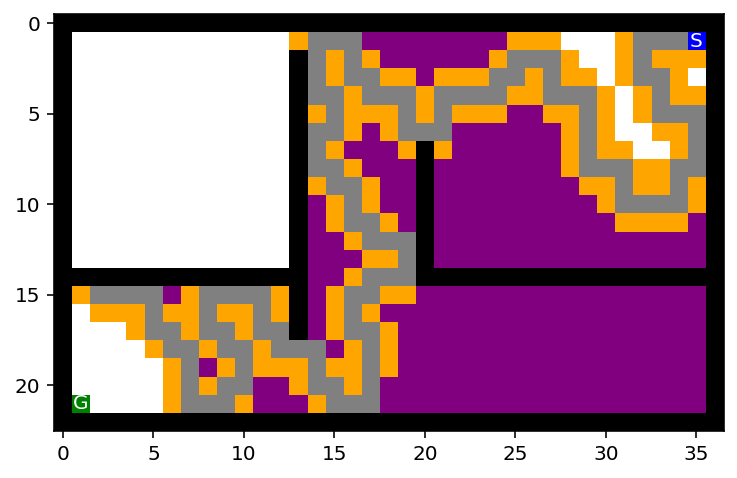

Node - pos = (16, 2); parent = <__main__.Node object at 0x7f100ad49910>; action = South; cost = 122


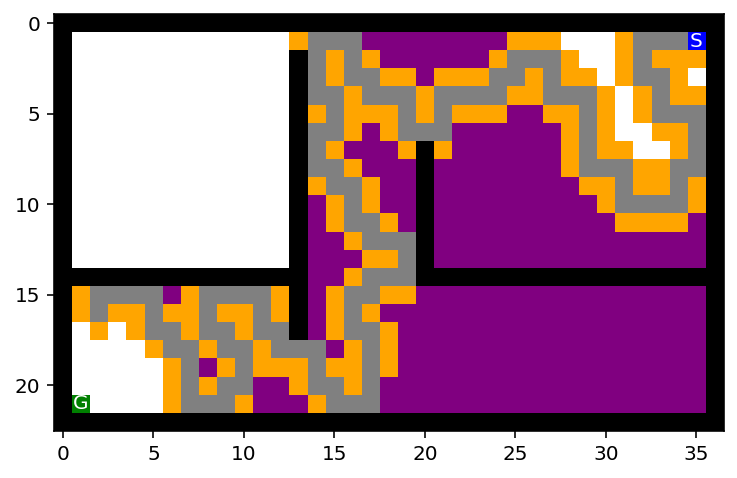

Node - pos = (16, 1); parent = <__main__.Node object at 0x7f100aec2370>; action = West; cost = 123


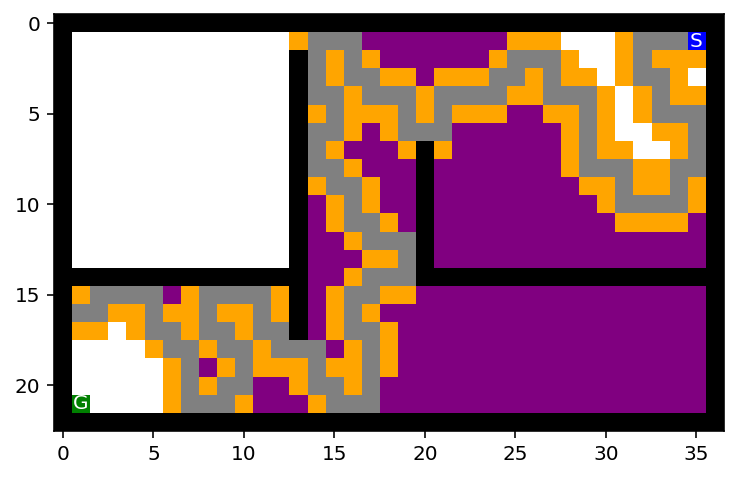

Node - pos = (17, 1); parent = <__main__.Node object at 0x7f100af16550>; action = South; cost = 124


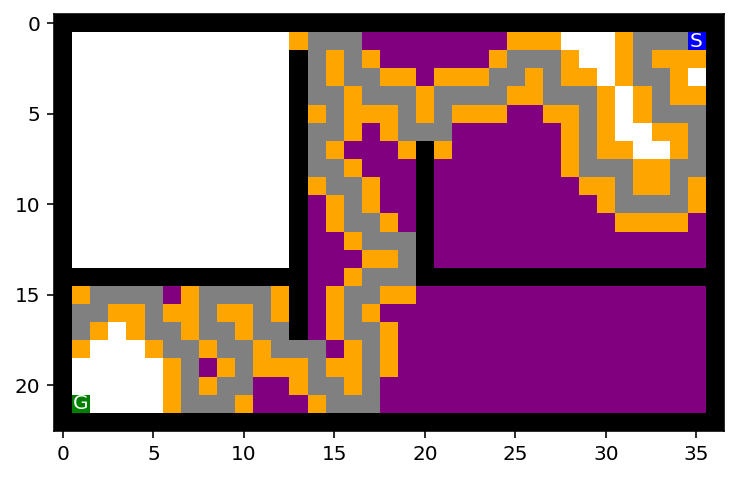

Node - pos = (18, 1); parent = <__main__.Node object at 0x7f100b069280>; action = South; cost = 125


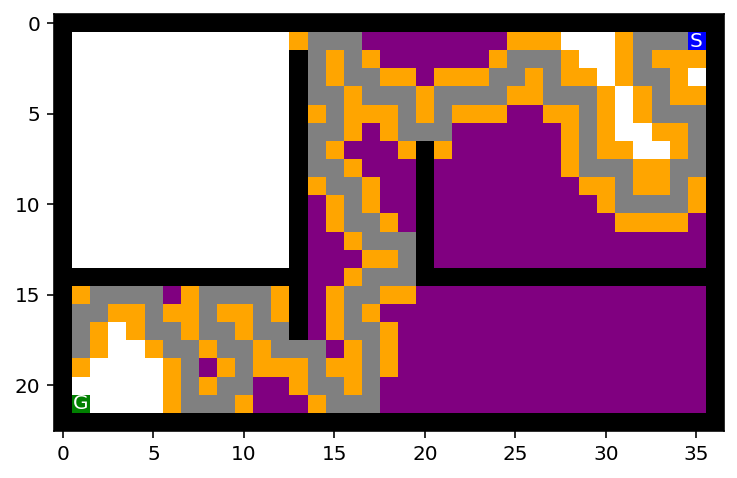

Node - pos = (18, 2); parent = <__main__.Node object at 0x7f100b1017c0>; action = East; cost = 126


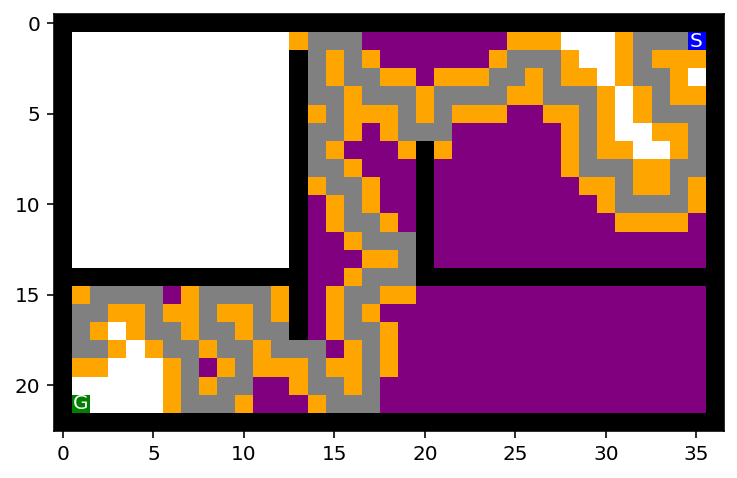

Node - pos = (19, 2); parent = <__main__.Node object at 0x7f100b1a7be0>; action = South; cost = 127


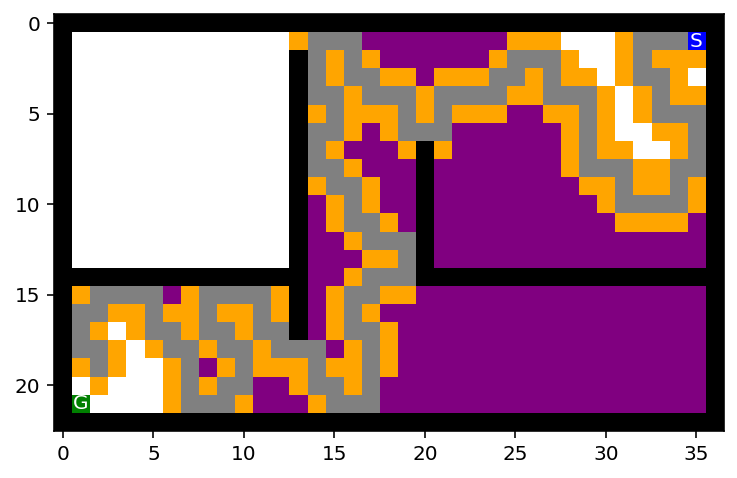

Node - pos = (20, 2); parent = <__main__.Node object at 0x7f100aefbb50>; action = South; cost = 128


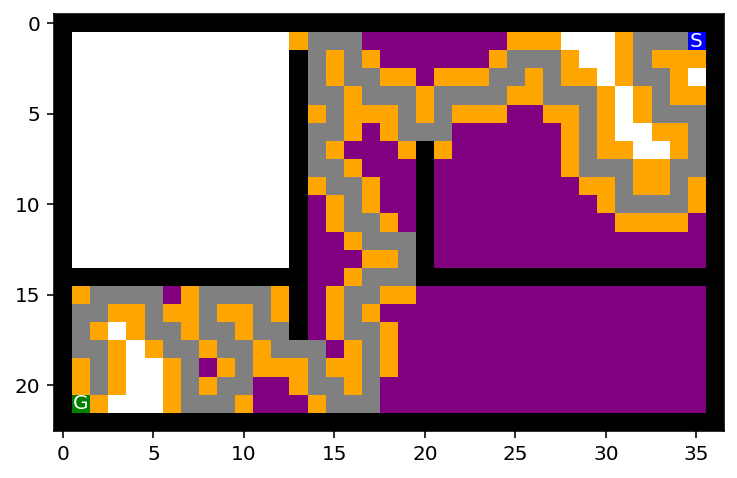

Node - pos = (20, 3); parent = <__main__.Node object at 0x7f100b083b80>; action = East; cost = 129


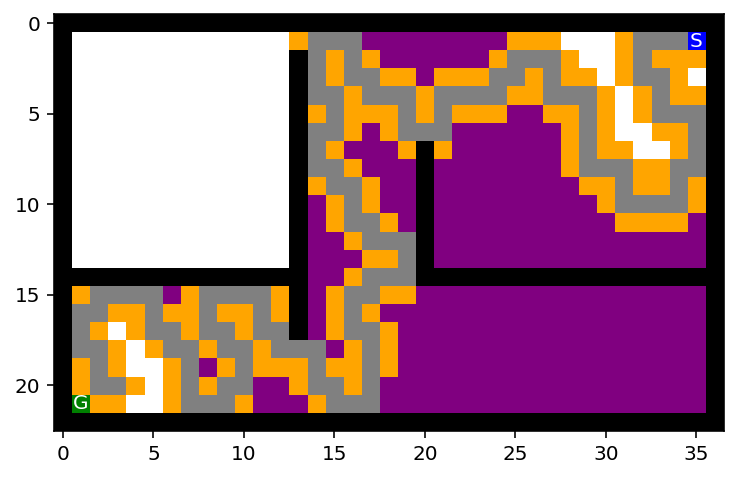

Node - pos = (21, 3); parent = <__main__.Node object at 0x7f100b154b80>; action = South; cost = 130


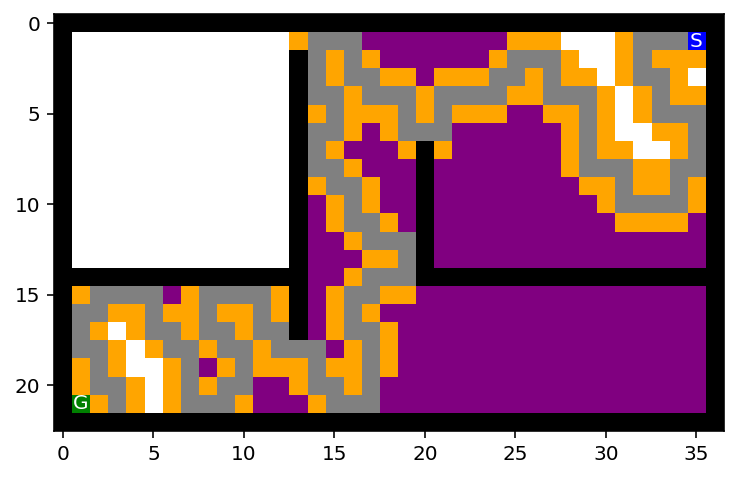

Node - pos = (21, 4); parent = <__main__.Node object at 0x7f100b14a6d0>; action = East; cost = 131


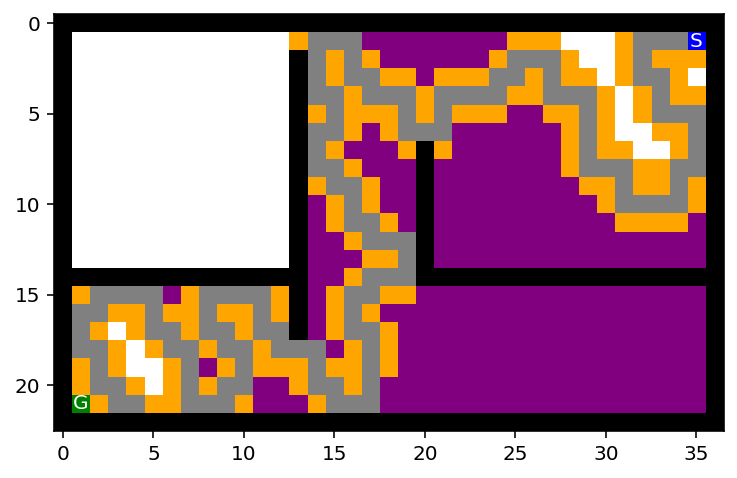

Node - pos = (21, 5); parent = <__main__.Node object at 0x7f100ad9b1c0>; action = East; cost = 132


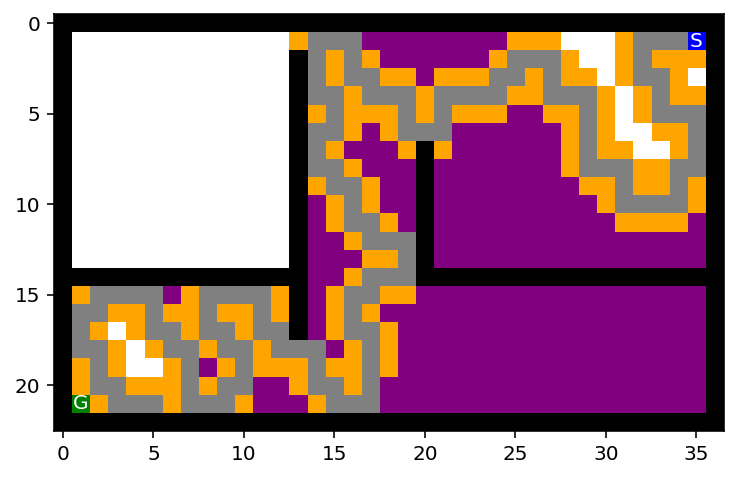

Node - pos = (20, 5); parent = <__main__.Node object at 0x7f100add11f0>; action = North; cost = 133


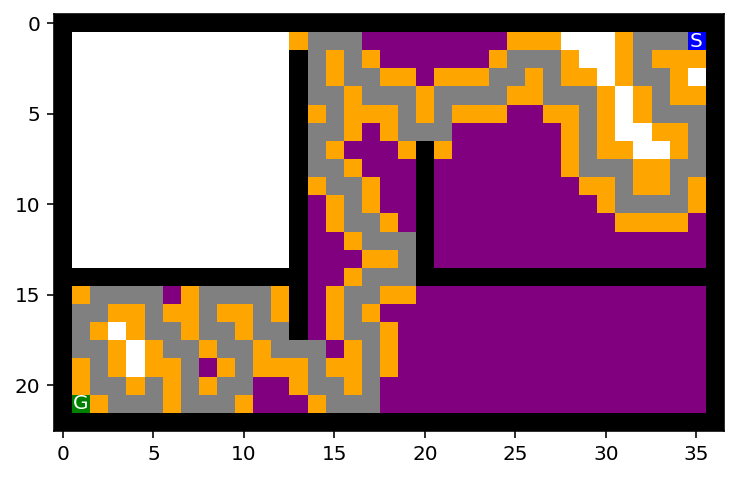

Node - pos = (19, 5); parent = <__main__.Node object at 0x7f100ae6aa30>; action = North; cost = 134


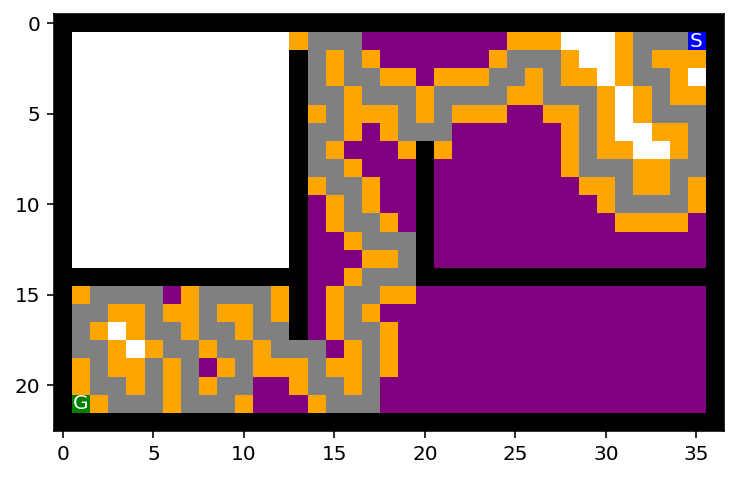

Node - pos = (19, 4); parent = <__main__.Node object at 0x7f102866e6d0>; action = West; cost = 135


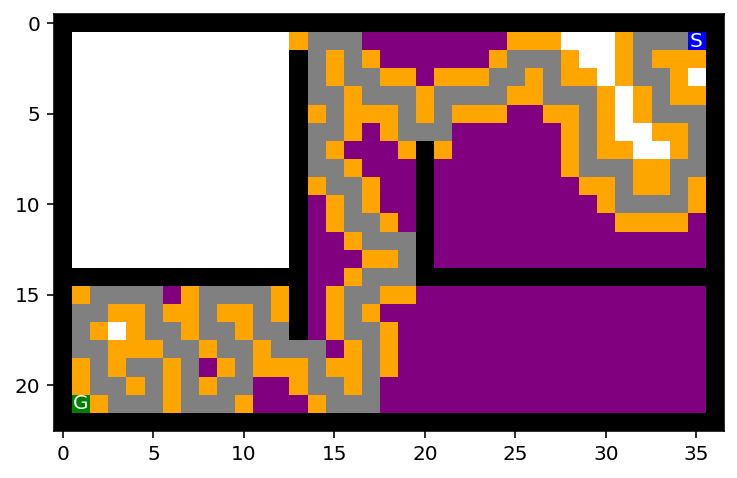

Node - pos = (18, 4); parent = <__main__.Node object at 0x7f100af7efa0>; action = North; cost = 136


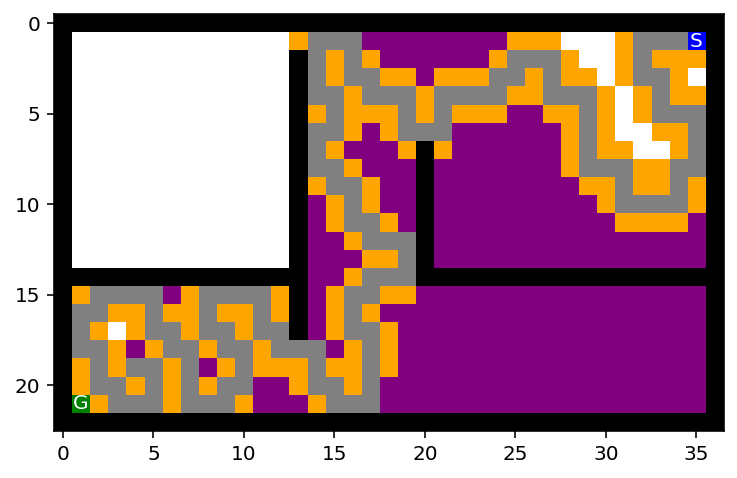

Node - pos = (19, 4); parent = <__main__.Node object at 0x7f102866e6d0>; action = West; cost = 135


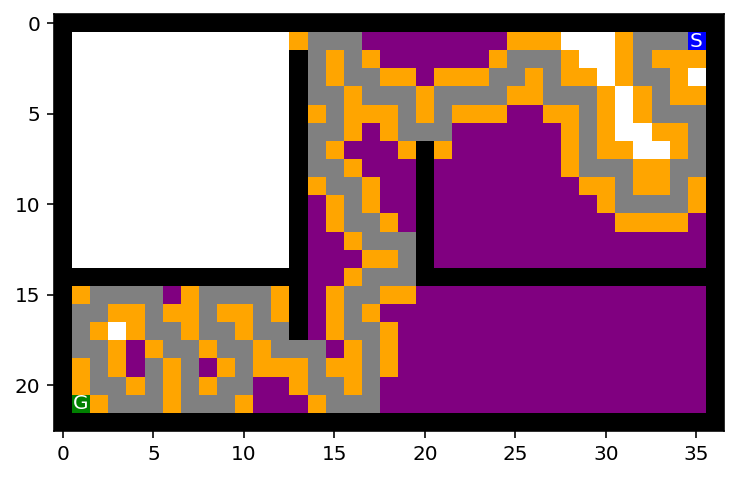

Node - pos = (19, 5); parent = <__main__.Node object at 0x7f100ae6aa30>; action = North; cost = 134


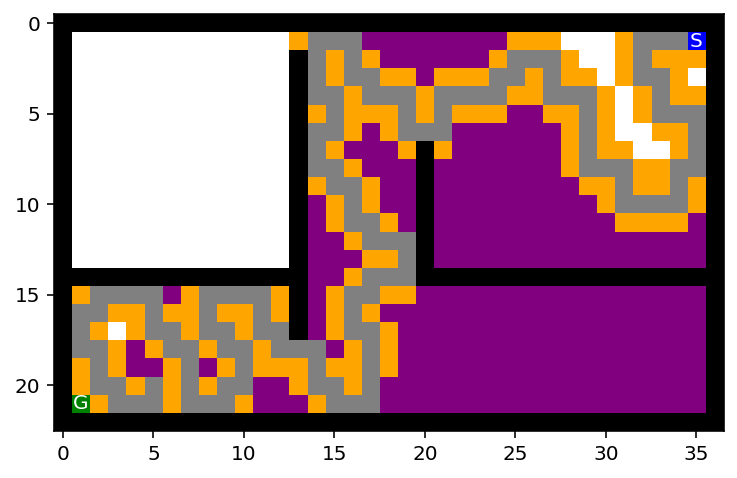

Node - pos = (20, 5); parent = <__main__.Node object at 0x7f100add11f0>; action = North; cost = 133


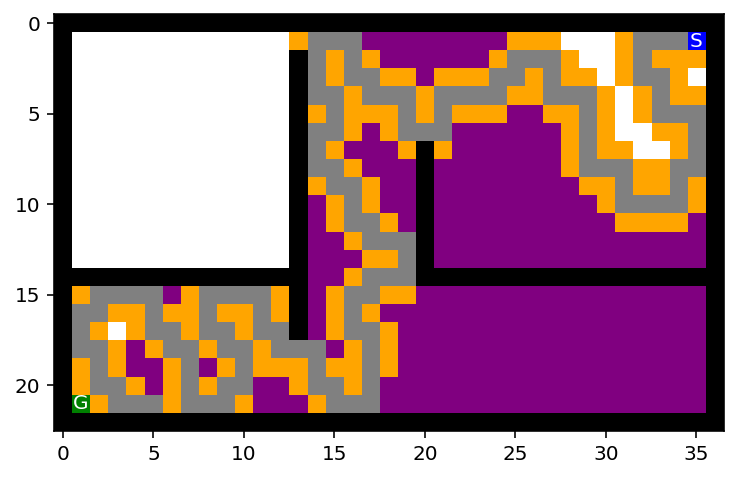

Node - pos = (21, 5); parent = <__main__.Node object at 0x7f100ad9b1c0>; action = East; cost = 132


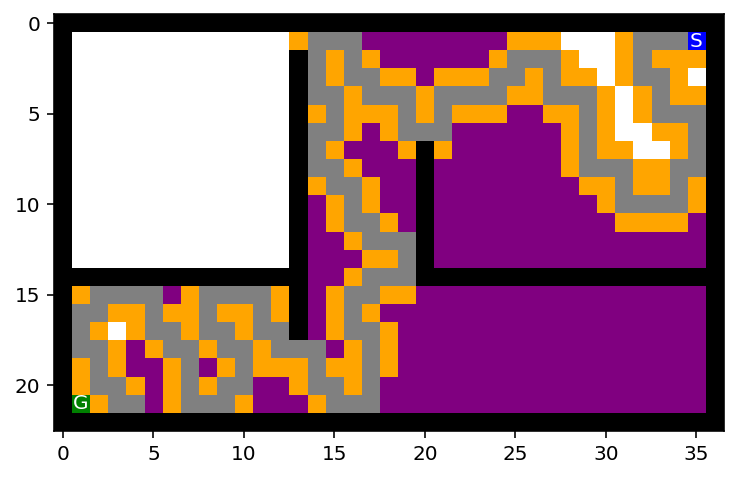

Node - pos = (21, 4); parent = <__main__.Node object at 0x7f100b14a6d0>; action = East; cost = 131


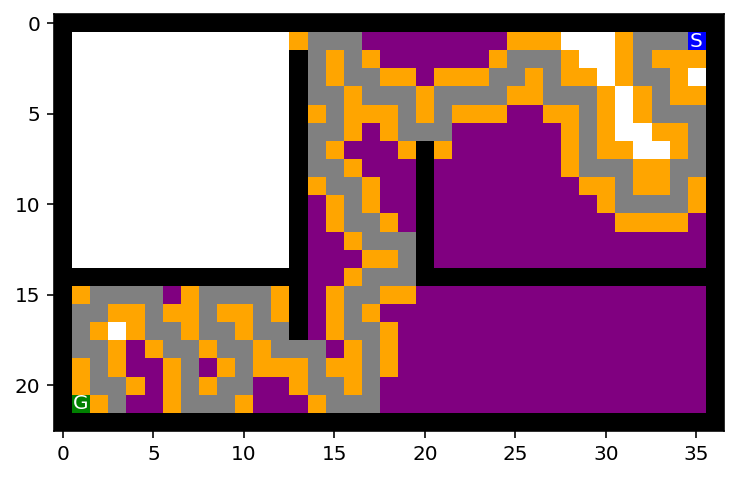

Node - pos = (21, 3); parent = <__main__.Node object at 0x7f100b154b80>; action = South; cost = 130


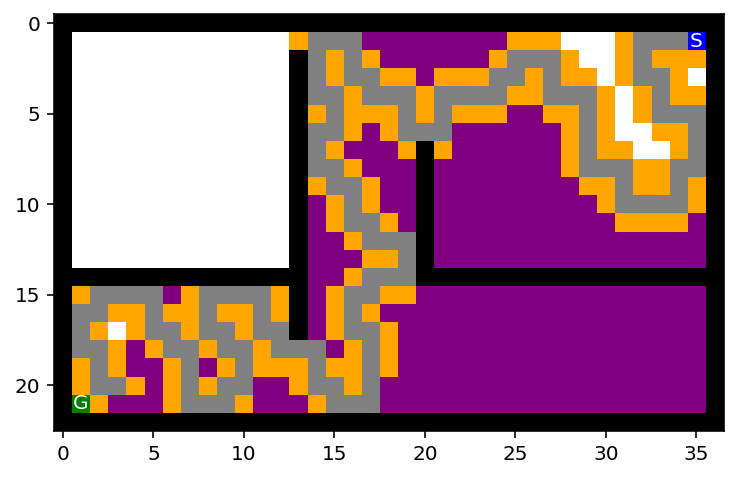

Node - pos = (20, 4); parent = <__main__.Node object at 0x7f100b154b80>; action = East; cost = 130


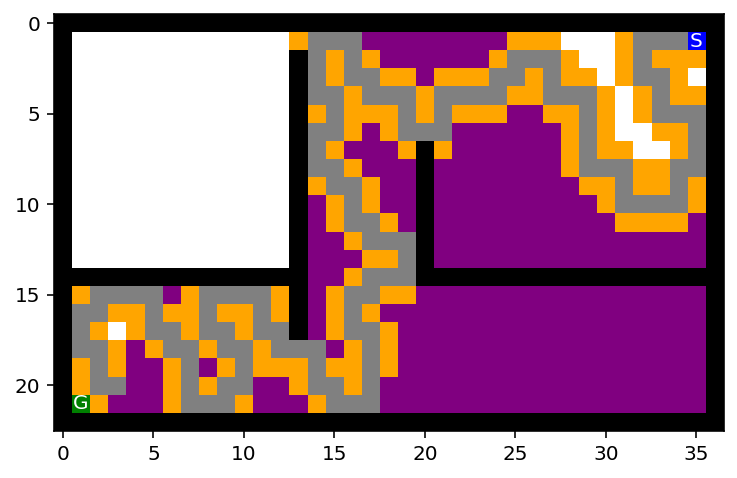

Node - pos = (20, 3); parent = <__main__.Node object at 0x7f100b083b80>; action = East; cost = 129


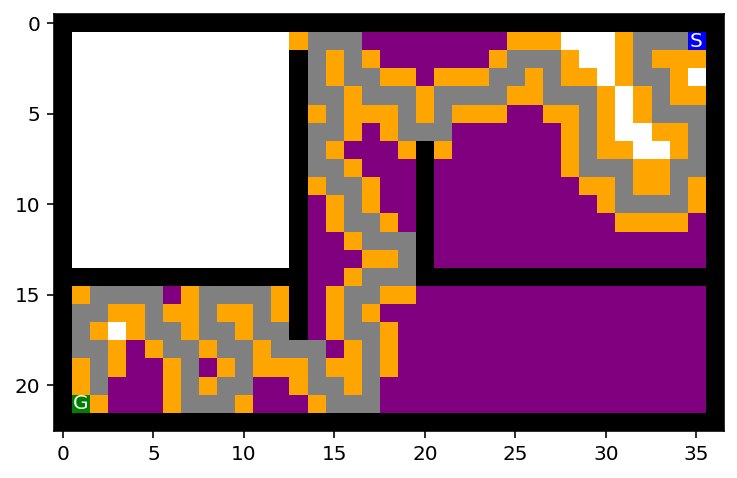

Node - pos = (20, 1); parent = <__main__.Node object at 0x7f100b083b80>; action = West; cost = 129


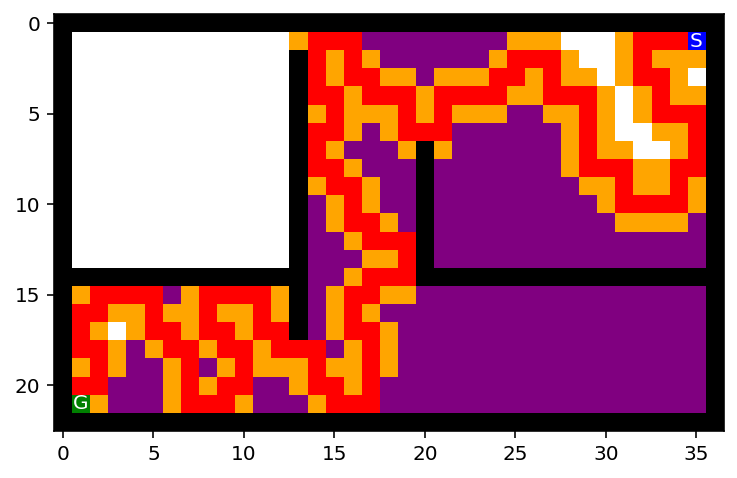

In [15]:
f = open("open_maze.txt", "r")
maze_str = f.read()
maze = parse_maze(maze_str)
dfs(maze, verb=True)
show_maze(maze)

How do you deal with loops (cycles)?

# Loops Discussion

### Tree implementation

I am not sure how the search tree was supposed to be implemented, so I have simply NOT explicitly costructed a search tree. Originally, I was going to 'Treeify' the entire 2D array to traverse as a traditional search tree, but then opted out because I thought that would simply be extra, unneeded work. I think the 2D array can be interpreted as a tree, and as we 'Nodify' array positions and add them to respective data structures, we can interpret the collection of expanded nodes and frontier nodes as the search tree.

### BFS:

For BFS, it keeps a reached/visited data structure. So it should not expand a node in the reached/visited data structure. 

In my implementaton, visited nodes are saved in a set. BFS only expands nodes on the frontier, so we simply have to avoid adding a visited node back to the frontier. This is rather trivial to do.

### DFS:
For DFS, we don't have a reached/visited collection, but we do have a 'current loop' collection. As we expand nodes, we cannot add nodes to the frontier if they exist on the current loop collection. If there is only one possible node, but it exists in the current_loop, then we mark that as a dead end, and must backtrack.

For backtracking, DFS determines if a node leads to a dead end. If it has reached a dead end, then we remove the node from the current loop collection, and we remove it completely from the tree. Since I don't have a explicitly constructed tree, removed nodes are 'marked' as removed in the 2d array. I marked these nodes as 'R', and have displayed them as purple in the visual demonstration. After removing from current loop and popping from the frontier, we examine the previous item in the frontier. Since we have 'removed' the dead-end node, this node will NOT consider it again, AND we do not have to save the removed node anywhere in a collection


Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

# Implementation Discussion

### Making Decisions
The order in which child nodes are added into the frontier is important in how both algorithms choose their path. Originally, I decided to return child nodes in a static order. This lead to consistent solutions from both algorithms. BFS always returned the same solution, and it was a very 'L' shaped solution for the open path mazes. When I tried looking at solutions with DFS, however, the solutions I was seeing were very peculiar. They were consistent throughout the mazes, but the solutions would explore unneeded rooms, or it would go through roundabout paths to get to the solution. So to make things interesting, I decided to return child nodes in random order. This lead to BFS open maze solutions to go different paths (although still the same cost), and for DFS to show a variety of different solutions.
 
 
#### Here are a couple of different solutions from DFS with random children (tested on open_maze.txt):

 open_maze
-------------------


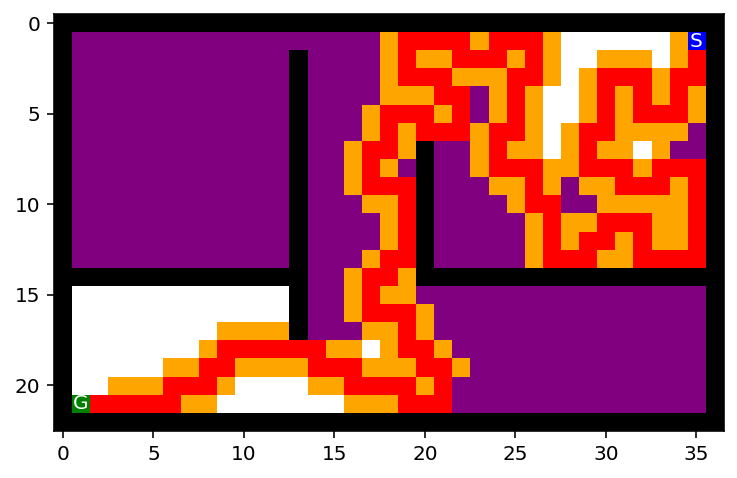

 open_maze
-------------------


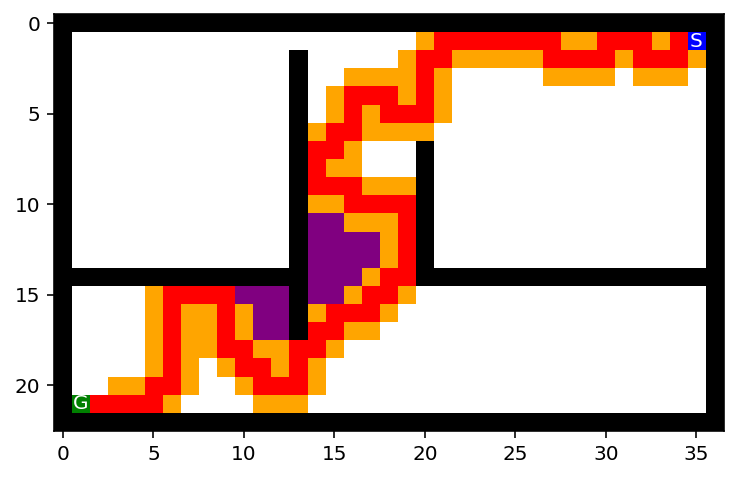

 open_maze
-------------------


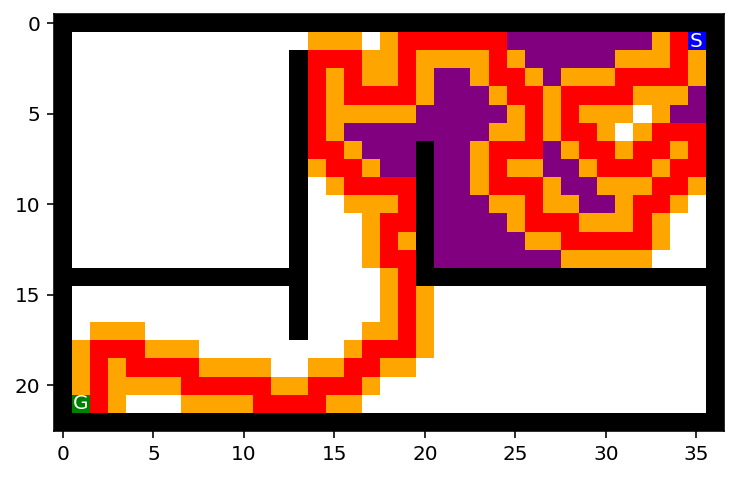

 open_maze
-------------------


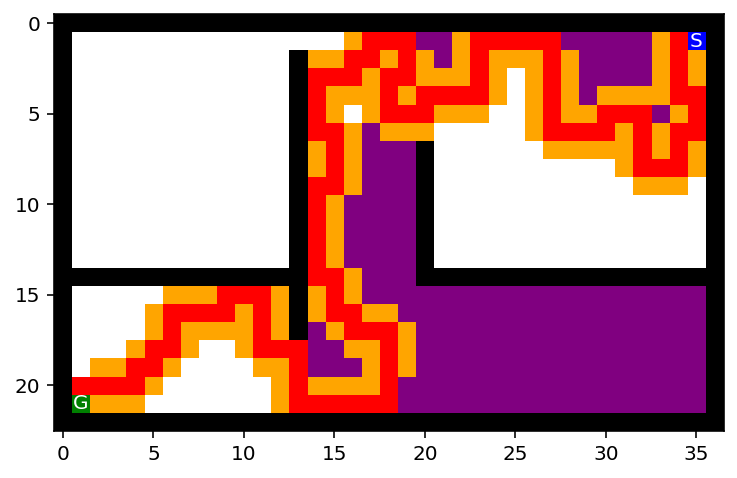

 open_maze
-------------------


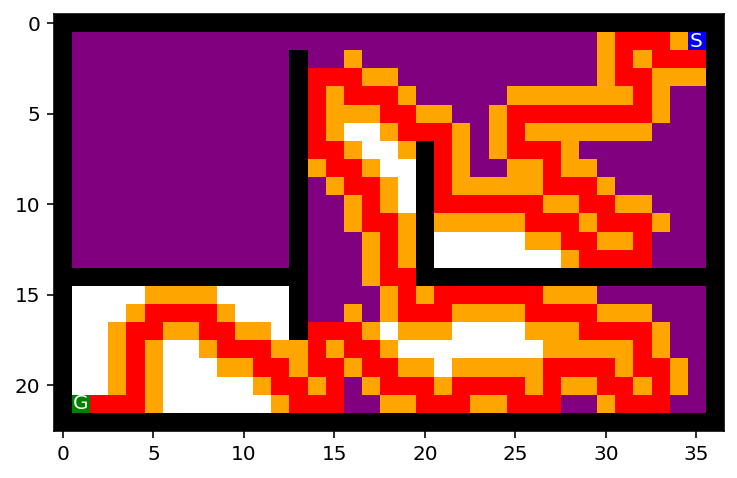

In [16]:
for i in range(1,6):
    f = open("open_maze.txt", "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' open_maze\n-------------------')
    dfs(maze)
    show_maze(maze)  
    f.close()

#### Here are a couple of BFS results with the same maze

 open_maze
-------------------


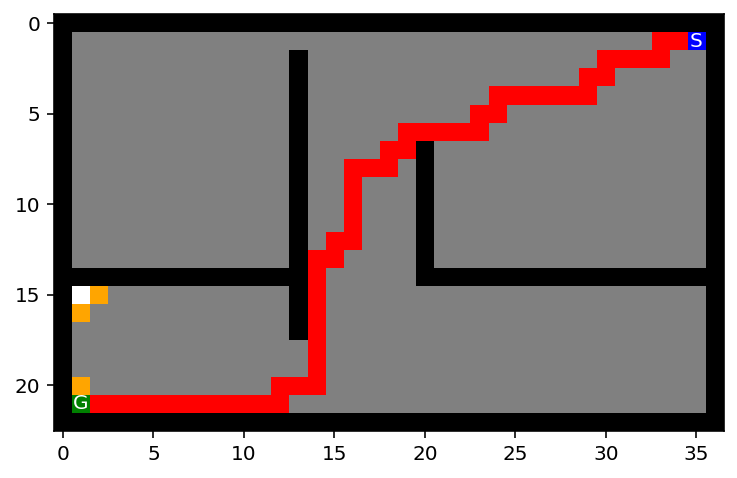

 open_maze
-------------------


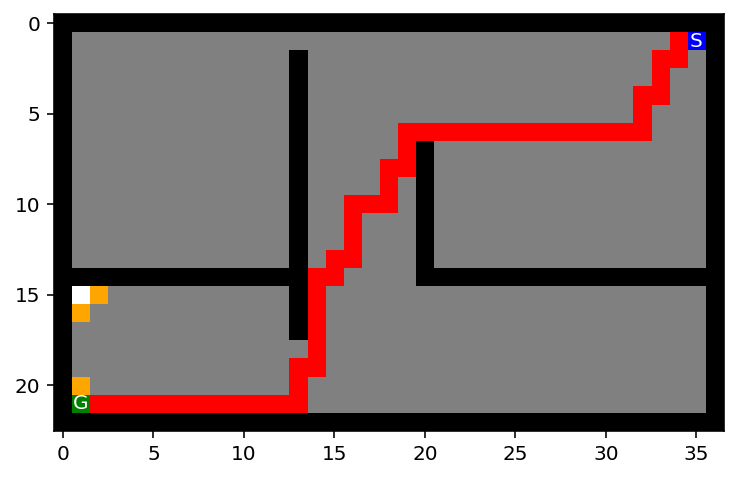

 open_maze
-------------------


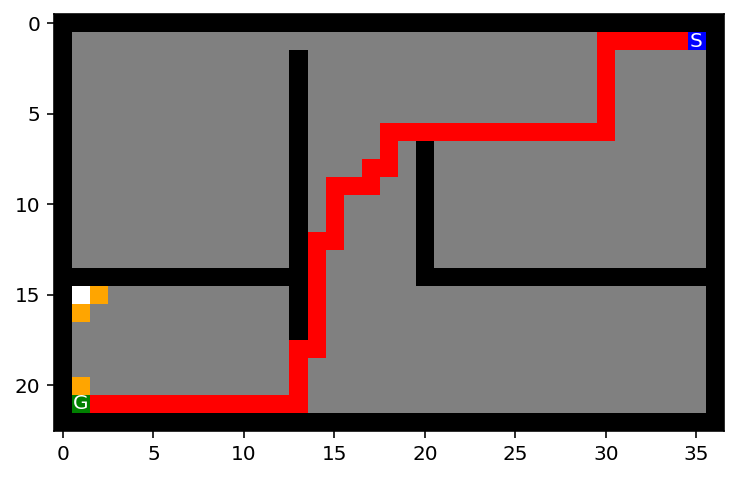

 open_maze
-------------------


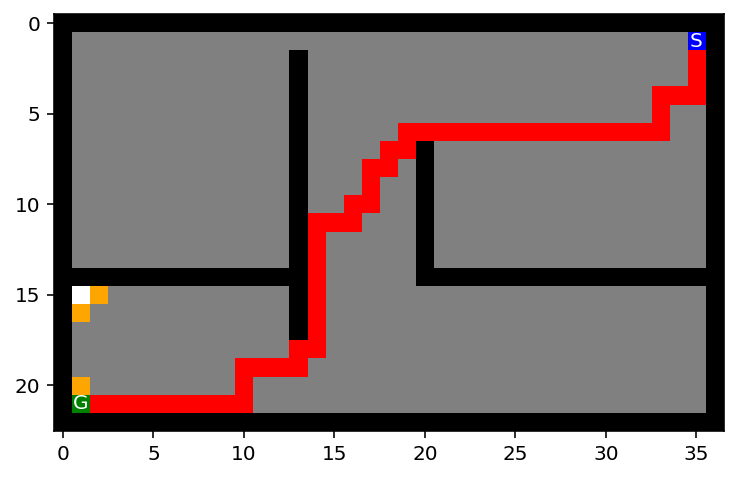

 open_maze
-------------------


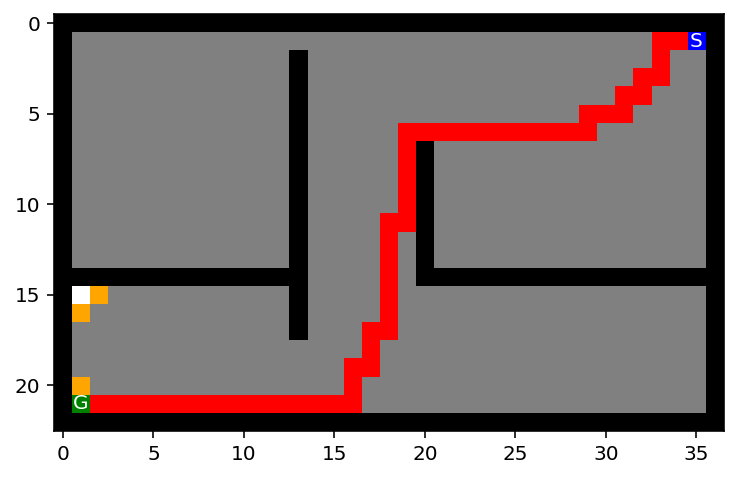

In [17]:
for i in range(1,6):
    f = open("open_maze.txt", "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    print(f' open_maze\n-------------------')
    bfs(maze)
    show_maze(maze)  
    f.close()

We can see that for, BFS, we always get the optimal cost. Although the paths may be different, with taxicab geometry, they all cost the same. With DFS, we get completely different results all the time. If there are more decisions to make (i.e. in open areas) DFS suffers a lot because its decision may be completely roundabout or even completely wrong. If there are multiple options, DFS is not guaranteed to choose the best option: it just finds an option. BFS on the other hand, always chooses the least-cost option. Therefore we can see that both solutions are complete: they both find answers. However, only BFS is optimal, while DFS is not optimal.

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

In [18]:
# Your code goes here

Are your implementations complete and optimal? What is the time and space complexity?

In [19]:
# Discussion

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts.

In [20]:
# Add code, table, charts.

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | nodes expanded | max tree depth | max tree size | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [21]:
# Add discussion

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

In [22]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [23]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [24]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [25]:
# Your code/answer goes here